In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline
from pylab import rcParams
import random
from datetime import datetime
import pickle

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.metrics import r2_score, mean_squared_error as mse
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, GridSearchCV

##### **Заготовка для вывода оценки качества предсказания - метрики R2 и диаграммы рассеяния для Train & Test:**

In [5]:
def evaluate_pred(train_values, train_pred, valid_values, valid_pred):
    print(f'Train_R2:\t{str(r2_score(train_values, train_pred))}')
    print(f'Valid_R2:\t{str(r2_score(valid_values, valid_pred))}')
    
    rcParams['figure.figsize'] = 20, 12
    
    plt.subplot(121)
    sns.scatterplot(train_values, train_pred)
    plt.plot([0, 600000], [0, 6e5], linestyle='--', color='red')
    plt.ylabel('True_Train_Values')
    plt.xlabel('Train_prediction')
    plt.title('TRAIN')
    
    plt.subplot(122)
    sns.scatterplot(valid_values, valid_pred)
    plt.plot([0, 600000], [0, 6e5], linestyle='--', color='red')
    plt.xlabel('True_Valid_Values')
    plt.ylabel('Valid_prediction')
    plt.title('VALID')
    
    plt.show()

In [6]:
def IQR_stats_print(feat):
    
    '''
    напечатать статистику квартилей и межквартильного размаха
    '''

    Q1 = feat.quantile(.25)
    Q2 = feat.median()
    Q3 = feat.quantile(.75)
    IQR = Q3 - Q1
    min_IQR = Q1 - 1.5 * IQR
    max_IQR = Q3 + 1.5 * IQR
    
    print(feat.describe())
    print(f'min_IQR:\t{min_IQR}')
    print(f'первый квартиль - Q1:\t{Q1}')
    print(f'IQR:\t{IQR}')
    print(f'третий квартиль - Q1:\t{Q3}')
    print(f'max_IQR:\t{max_IQR}')
    print(f'количество выбросов <min_IQR:\t{feat[feat < min_IQR].count()}')
    print(f'количество выбросов >max_IQR:\t{feat[feat > max_IQR].count()}')
    
    rcParams['figure.figsize'] = 18, 6
    plt.subplot(121)
    sns.boxplot(train_df.Square, whis=1.5)
    plt.subplot(122)
    plt.hist(train_df.Square, bins=30)
    plt.show
#     return None

In [7]:
# поскольку не нашел в Pandas функцию для расчета IQR создам функцию.
def outlier_processing(feat):
        
    '''
    функция для заполнения выбросов за пределами +/-1.5*IQR() значениями медианы по распределению признака
    функция получает аргументом один признак из dataFrame - удаляет из него выбросы и возвращает обработанным
    '''
    
    Q1 = feat.quantile(.25)
    Q2 = feat.median()
    Q3 = feat.quantile(.75)
    IQR = Q3 - Q1
    quantile_025 = feat.quantile(.025)
    quantile_975 = feat.quantile(.975)
    min_IQR = Q1 - 1.5 * IQR
    max_IQR = Q3 + 1.5 * IQR
    
#     print(f'IQR:\t{IQR}')
#     print(f'min_IQR:\t{min_IQR}')
#     print(f'max_IQR:\t{max_IQR}')
    
#     feat[(feat < min_IQR) | (feat > max_IQR)] = Q2
    
    # возможно диапазон определенный для выбросов [min, min_IQR) + (max_IQR, max] слишком широк
    # может быть его нужно было бы определитель исходя из квантилей: [min, .025) и (.975, max]
        
    feat[(feat < quantile_025) | (feat > quantile_975)] = Q2
    
    return feat

### **Подготовительный этап: загрузка данных в DataFrame:**

In [8]:
# TRAIN_DATASET_PATH = '../input/real-estate-price-prediction-moscow/train.csv'
# TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'

# TRAIN_DATASET_PATH = 'c:\Users\gorah\Documents\pylibs-ds_src\lss10_web06\train.csv'
TRAIN_DATASET_PATH = '../lss10_web06/train.csv'
TEST_DATASET_PATH = 'c:/Users/gorah/Documents/pylibs-ds_src/lss10_web06/test.csv'

RESULTS_PATH = 'c:/Users/gorah/Documents/pylibs-ds_src/lss10_web06/results_/'

train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

##### **Обзор данных, количество объектов, признаков, типов данных**

In [9]:
train_df.head(10)
# train_df.info()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27    3.0  115.027311         NaN           10.0      4   
1   3013          22    1.0   39.832524   23.169223            8.0      7   
2   8215           1    3.0   78.342215   47.671972           10.0      2   
3   2352           1    1.0   40.409907         NaN            1.0     10   
4  13866          94    2.0   64.285067   38.562517            9.0     16   
5   5804          99    3.0   62.528465   47.103833            6.0      9   
6   8864          44    1.0   33.938750   21.772930            9.0      1   
7  13072          59    2.0   50.391814   32.893256            8.0      8   
8   9951           1    1.0   46.887892   44.628132            1.0     12   
9   8094           6    3.0   79.867477   75.085125            1.0      3   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424         B         B        11      3097   
1         8.0       1966   0.118537         B         B        30      6207   
2        17.0       1988   0.025609         B         B        33      5261   
3        22.0       1977   0.007122         B         B         1       264   
4        16.0       1972   0.282798         B         B        33      8667   
5         9.0       1972   0.012339         B         B        35      5776   
6        12.0       1968   0.232205         B         B        24      4860   
7        17.0       1986   0.019509         B         B        37      7687   
8        20.0       1977   0.007122         B         B         1       264   
9        17.0       2014   0.243205         B         B         5      1564   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         0           NaN            0        0       B  305018.871089  
1         1        1183.0            1        0       B  177734.553407  
2         0         240.0            3        1       B  282078.720850  
3         0           NaN            0        1       B  168106.007630  
4         2           NaN            0        6       B  343995.102962  
5         1        2078.0            2        4       B  161044.944138  
6         1          80.0            0        3       B  142402.739272  
7        11         176.0            5        5       B  326174.175191  
8         0           NaN            0        1       B  160400.401732  
9         0         540.0            0        0       B  194756.023945

In [10]:
#исключаем признаки Id & DistrictId из анализа делая их строковыми
train_df[['Id', 'DistrictId']] = train_df[['Id', 'DistrictId']].astype(str)

In [11]:
test_df.head()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

### **1. EDA**

##### _*посмотрим на распределение целовой переменной*_

<function matplotlib.pyplot.show(close=None, block=None)>

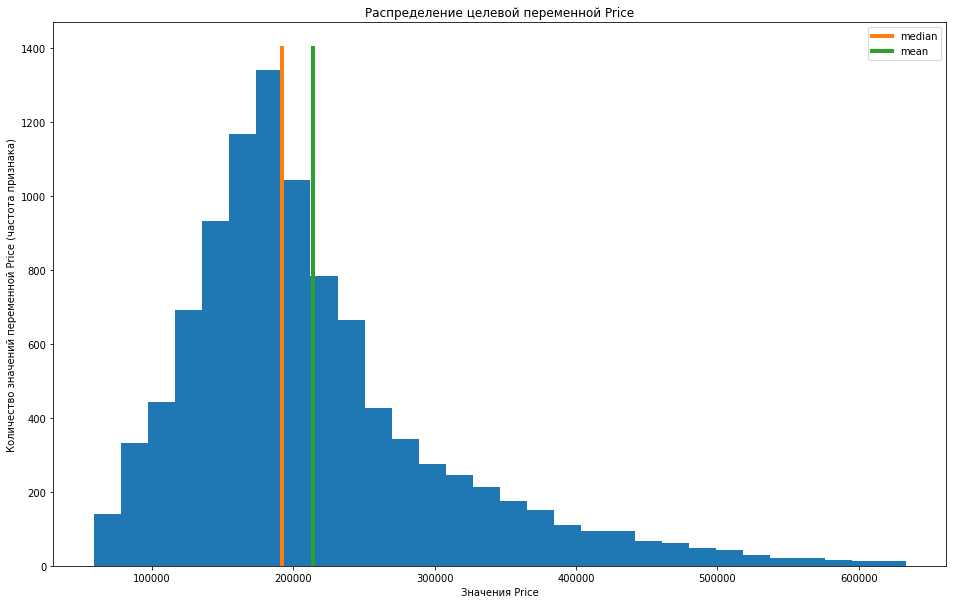

In [12]:
rcParams['figure.figsize'] = 16, 10
plt.hist(train_df.Price, bins=30)
plt.plot([train_df.Price.median()] * 8, np.linspace(0, 1400, 8), label='median', linewidth=4)
plt.plot([train_df.Price.mean()] * 8, np.linspace(0, 1400, 8), label='mean', linewidth=4)
plt.title('Распределение целевой переменной Price')
plt.xlabel('Значения Price')
plt.ylabel('Количество значений переменной Price (частота признака)')
plt.legend()
plt.show

Вывод: Распределение целевой переменной в целом имее нормальную форму с некоторым отклонением от нормальности (положительная ассиметрия - схост справа).

##### _**Статистики вещественных признаков**_

In [13]:
train_df.describe()

Rooms        Square   LifeSquare  KitchenSquare         Floor  \
count  10000.000000  10000.000000  7887.000000   10000.000000  10000.000000   
mean       1.890500     56.315775    37.199645       6.273300      8.526700   
std        0.839512     21.058732    86.241209      28.560917      5.241148   
min        0.000000      1.136859     0.370619       0.000000      1.000000   
25%        1.000000     41.774881    22.769832       1.000000      4.000000   
50%        2.000000     52.513310    32.781260       6.000000      7.000000   
75%        2.000000     65.900625    45.128803       9.000000     12.000000   
max       19.000000    641.065193  7480.592129    2014.000000     42.000000   

         HouseFloor     HouseYear     Ecology_1      Social_1      Social_2  \
count  10000.000000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean      12.609400  3.990166e+03      0.118858     24.687000   5352.157400   
std        6.775974  2.005003e+05      0.119025     17.532614   4006.799803   
min        0.000000  1.910000e+03      0.000000      0.000000    168.000000   
25%        9.000000  1.974000e+03      0.017647      6.000000   1564.000000   
50%       13.000000  1.977000e+03      0.075424     25.000000   5285.000000   
75%       17.000000  2.001000e+03      0.195781     36.000000   7227.000000   
max      117.000000  2.005201e+07      0.521867     74.000000  19083.000000   

           Social_3  Healthcare_1   Helthcare_2       Shops_1          Price  
count  10000.000000   5202.000000  10000.000000  10000.000000   10000.000000  
mean       8.039200   1142.904460      1.319500      4.231300  214138.857399  
std       23.831875   1021.517264      1.493601      4.806341   92872.293865  
min        0.000000      0.000000      0.000000      0.000000   59174.778028  
25%        0.000000    350.000000      0.000000      1.000000  153872.633942  
50%        2.000000    900.000000      1.000000      3.000000  192269.644879  
75%        5.000000   1548.000000      2.000000      6.000000  249135.462171  
max      141.000000   4849.000000      6.000000     23.000000  633233.466570

**_видно что часть переменных (Rooms, Square, LifeSquare, KitchenSquare) имеют бессмысленные значения и выбросы; это требует в дальнейшем преобразования._**

In [14]:
train_df.select_dtypes(include='object').columns

Index(['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

In [15]:
train_df.Ecology_2.value_counts(), train_df.Ecology_3.value_counts(), train_df.Shops_2.value_counts(), 

(B    9903
 A      97
 Name: Ecology_2, dtype: int64,
 B    9725
 A     275
 Name: Ecology_3, dtype: int64,
 B    9175
 A     825
 Name: Shops_2, dtype: int64)

***Видно что переменные Ecology_2, Ecologiy_3, Shops_2 бинарные и сильно несбалансированные.***

возможно применения к этим признакам dummy-кодирования или замена значений 'A', 'B' на 0 или 1;

In [16]:
train_df.DistrictId.value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

###### **Подслушано на вебинаре)))**
DistrictId:
Кодирование ранговой шкалой (заменять признак порядковыми числами) особого смысла не имеет; бинарное кодирование ввиду большого количества dummy-переменных тоже;
Можно перевести категориальную переменную в переменную абсолютной шкалы (в вещественный тип) путем замены значения категории количеством (частотой) объектов в выборке с таким значением категории;

### **2. Обработка выбросов и пропусков**

##### Обработка выбросов в **Rooms:**

In [17]:
# train_df.Rooms.value_counts()
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.loc[train_df.Rooms == 0, 'Rooms'] = 1
train_df.loc[train_df.Rooms >= 6, 'Rooms'] = train_df.Rooms.median()
train_df.Rooms.value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

##### Обработка выбросов в **KitchenSquare:**

In [18]:
train_df.KitchenSquare.value_counts()
condition_1 = (train_df['KitchenSquare'].isna()) | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
train_df.loc[condition_1, 'KitchenSquare'] = train_df.KitchenSquare.median()
train_df.loc[train_df.KitchenSquare < 3, 'KitchenSquare'] = 3

In [19]:
train_df.KitchenSquare.value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

##### Обработка выбросов в **Floor, HouseFloor:**

In [20]:
train_df.HouseFloor.value_counts().sort_index()

# sns.boxplot(train_df.Floor)
(train_df.Floor > train_df.HouseFloor).sum()

1825

In [21]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df.HouseFloor == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df.Floor > train_df.HouseFloor, 'HouseFloor_outlier'] = 1
(train_df['HouseFloor_outlier'] == 1).sum()

1825

In [22]:
train_df.loc[(train_df.HouseFloor == 0), 'HouseFloor'] = train_df.HouseFloor.median()
(train_df.HouseFloor == 0).sum()

0

In [23]:
condition_2 = (train_df.Floor > train_df.HouseFloor)
train_df.loc[condition_2, ['Floor', 'HouseFloor']]

Floor  HouseFloor
17        6         5.0
19       16        14.0
21       11         9.0
25       18         1.0
26       13         1.0
...     ...         ...
9953     19        17.0
9960     15         1.0
9968     18        17.0
9970     18        17.0
9975     18        17.0

[1610 rows x 2 columns]

In [24]:
train_df.loc[condition_2, 'Floor'] = train_df.loc[condition_2, 'HouseFloor'].apply(lambda x: random.randint(1, x))
condition_2.sum()

1610

##### Обработка выбросов в **HouseYear:**

In [25]:
train_df.HouseYear.sort_values(ascending=False)
train_df.loc[train_df.HouseYear > 2020, 'HouseYear'] = 2020
train_df['HouseYear'].value_counts()

1977    2652
2017     308
2016     305
2015     299
2014     210
        ... 
1947       1
1914       1
1928       1
1910       1
1916       1
Name: HouseYear, Length: 95, dtype: int64

##### Обработка выбросов в **Square:**

In [26]:
print(train_df.Square.describe())

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

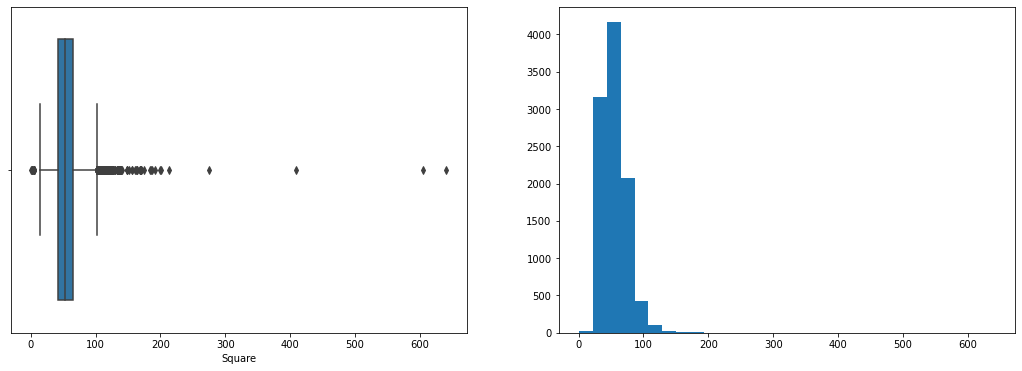

In [27]:
rcParams['figure.figsize'] = 18, 6
plt.subplot(121)
sns.boxplot(train_df.Square, whis=1.5)
plt.subplot(122)
plt.hist(train_df.Square, bins=30)
plt.show

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64
min_IQR:	5.586264180189367
первый квартиль - Q1:	41.774880819469836
IQR:	24.125744426186976
третий квартиль - Q1:	65.90062524565681
max_IQR:	102.08924188493728
количество выбросов <min_IQR:	12
количество выбросов >max_IQR:	230


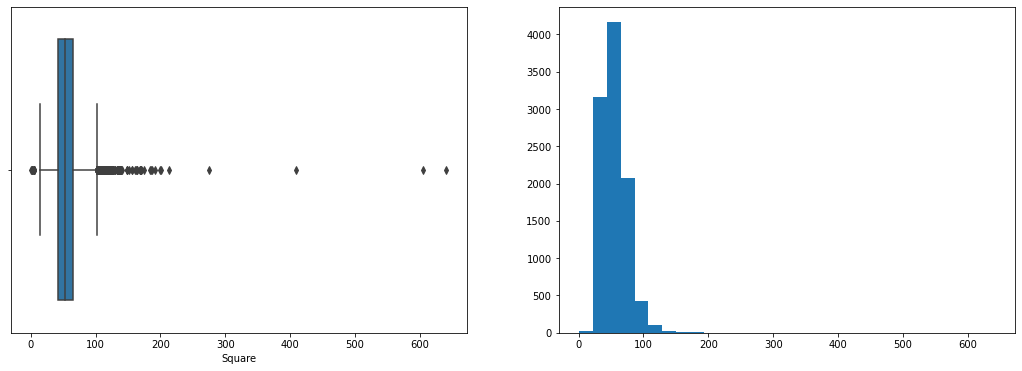

In [28]:
IQR_stats_print(train_df.Square)

<AxesSubplot:xlabel='Square'>

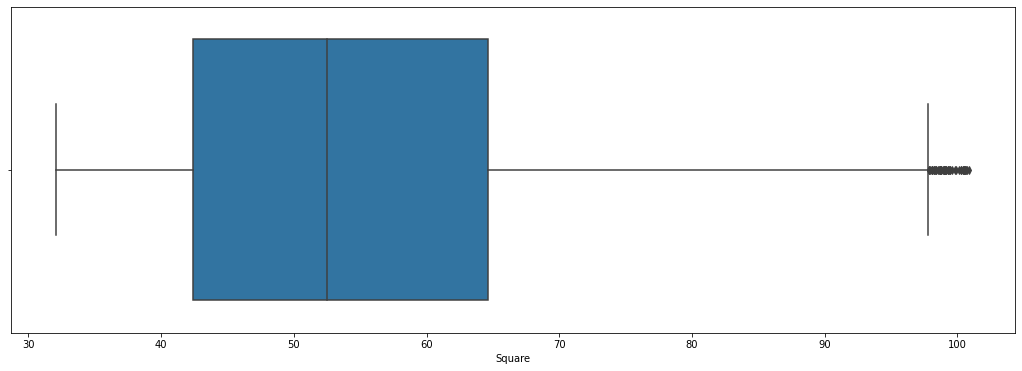

In [29]:
outlier_processing(train_df.Square)
sns.boxplot(train_df.Square)

count    10000.000000
mean        55.108599
std         15.215053
min         32.105270
25%         42.432730
50%         52.513310
75%         64.591720
max        100.904263
Name: Square, dtype: float64
min_IQR:	9.194245318990184
первый квартиль - Q1:	42.4327298985676
IQR:	22.158989719718278
третий квартиль - Q1:	64.59171961828588
max_IQR:	97.8302041978633
количество выбросов <min_IQR:	0
количество выбросов >max_IQR:	50


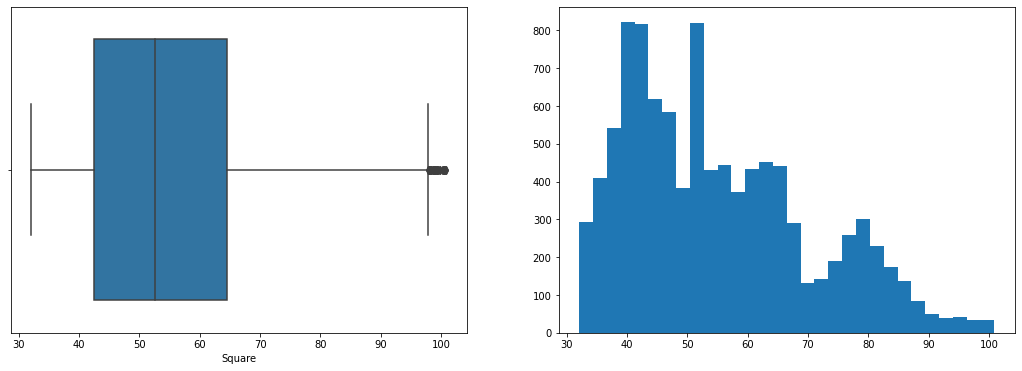

In [30]:
IQR_stats_print(train_df.Square)

вроде Square теперь по-лучше)))

##### Обработка пропусков и выбросов в **LifeSquare:**

In [31]:
# заполним выбросы в LifeSquare - заменяя значения вне пределов 4*IQR медианой распределения значений признака
# но сначала нужно удалить пропуски

In [32]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [33]:
train_df.loc[train_df.LifeSquare.isna(), ['Square', 'LifeSquare', 'KitchenSquare']]
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1
condition_3 = (train_df.LifeSquare.isna()) \
            & (~train_df.Square.isna()) \
            & (~train_df.KitchenSquare.isna())
train_df.loc[condition_3, 'LifeSquare'] = train_df.loc[condition_3, 'Square'] - \
                                                    train_df.KitchenSquare - 3
train_df.LifeSquare.isna().sum()

0

count    10000.000000
mean        40.284608
std         77.143361
min          0.370619
25%         25.480024
50%         35.676008
75%         48.346311
max       7480.592129
Name: LifeSquare, dtype: float64
min_IQR:	-8.819406040805085
первый квартиль - Q1:	25.480024339544478
IQR:	22.866286920233044
третий квартиль - Q1:	48.34631125977752
max_IQR:	82.64574164012708
количество выбросов <min_IQR:	0
количество выбросов >max_IQR:	213


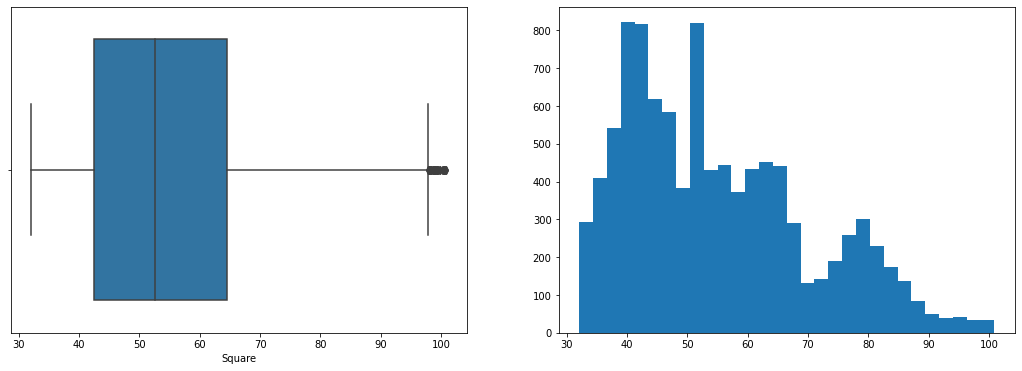

In [34]:
IQR_stats_print(train_df.LifeSquare)

Ну удалось убрать все выбросы; Остались значения признака сильно меньшего разумной величины:

In [35]:
train_df.LifeSquare.quantile(.025)

15.146123972262354

In [36]:
train_df.loc[train_df['LifeSquare'] < train_df.LifeSquare.quantile(.025), ['Square', 'LifeSquare', 'KitchenSquare']]

Square  LifeSquare  KitchenSquare
26    83.262530    4.769174            3.0
119   63.591740    0.795539           10.0
161   52.513310    5.257278            3.0
212   38.936986    3.064320            3.0
227   46.722042    1.944446            3.0
...         ...         ...            ...
9912  52.787090    5.600609            3.0
9915  52.513310   12.125029            7.0
9938  94.888593    2.637095            3.0
9982  36.112393    1.855415            3.0
9990  52.513310   11.419796            3.0

[250 rows x 3 columns]

Значение LifeSquare которые менее quantile_025 заменю этим значением;

In [37]:
quantile_025 = train_df.LifeSquare.quantile(.025)
train_df.loc[train_df.LifeSquare < quantile_025, 'LifeSquare'] = quantile_025
# или медианой? в функции медианой (Q2)!

In [38]:
train_df.loc[train_df.LifeSquare < quantile_025, ['Square', 'LifeSquare', 'KitchenSquare']].count()

Square           0
LifeSquare       0
KitchenSquare    0
dtype: int64

In [39]:
class DataPreprocessing:
    '''Обработка пропусков и выбросов в датасете'''
    def __init__(self):
        '''инициализация атрибутов экземпляра класса'''
        self.medians = None
        self.KitchenSquare_quantile = None
    
    def fit(self, df):
        '''расчет статистик для заполнения выбросов и пропусков'''
        self.medians = df.median()
        self.KitchenSquare_quantile = df['KitchenSquare'].quantile(.975)
    
    def transform(self, df):
        '''преобразование данных'''
        
        # Rooms
#         df['Rooms_outlier'] = 0
#         df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6), 'Rooms_outlier'] = 1
#         df.loc[df['Rooms'] == 0, 'Rooms'] = 1
#         df.loc[df['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        
        # Rooms
        df['Rooms_outlier'] = 0
        df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6), 'Rooms_outlier'] = 1
        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
        df.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        
        
        # KitchenSquare
        condition_1 = (df['KitchenSquare'].isna()) | \
            (df['KitchenSquare'] > self.KitchenSquare_quantile)
        df.loc[condition_1, 'KitchenSquare'] = self.medians['KitchenSquare']
        df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        df['HouseFloor_outlier'] = 0
        df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_outlier'] = 1
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        condition_2 = (train_df.Floor > train_df.HouseFloor)
        df.loc[condition_2, 'Floor'] = \
                df.loc[condition_2, 'HouseFloor'].apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        df['HouseYear_outlier'] = 0
        df.loc[df['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        df.loc[df['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in df.columns:
            df.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        df['LifeSquare_nan'] = df['LifeSquare'].isna() * 1
        condition_3 = (df['LifeSquare'].isna()) & \
                      (~df['Square'].isna()) & \
                      (~df['KitchenSquare'].isna())
        df.loc[condition_3, 'LifeSquare'] = df.loc[condition_3, 'Square'] - 3 - \
                                    df.loc[condition_3, 'KitchenSquare']
        # для избавления от оставшихся выбрасов.
        outlier_processing(df.LifeSquare)
        
        # Square
        outlier_processing(df.Square)
        
        df.fillna(self.medians, inplace=True)
        
        return df        

Обработка пропусков в признаке Healthcare_1:

In [40]:
train_df.loc[~train_df['Healthcare_1'].isna()]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
1      3013         22    1.0  39.832524   23.169223            8.0      7   
2      8215          1    3.0  78.342215   47.671972           10.0      2   
5      5804         99    3.0  62.528465   47.103833            6.0      9   
6      8864         44    1.0  33.938750   21.772930            9.0      1   
7     13072         59    2.0  50.391814   32.893256            8.0      8   
...     ...        ...    ...        ...         ...            ...    ...   
9990  10635         21    1.0  52.513310   15.146124            3.0      1   
9991  11173          6    2.0  62.648779   56.648779            3.0      6   
9992  11753         37    2.0  50.902724   27.159548            6.0      4   
9994   4356          9    1.0  43.303458   21.519087            8.0     12   
9998  14561         21    1.0  32.330292   22.326870            5.0      3   

      HouseFloor  HouseYear  Ecology_1  ... Social_2 Social_3  Healthcare_1  \
1            8.0       1966   0.118537  ...     6207        1        1183.0   
2           17.0       1988   0.025609  ...     5261        0         240.0   
5            9.0       1972   0.012339  ...     5776        1        2078.0   
6           12.0       1968   0.232205  ...     4860        1          80.0   
7           17.0       1986   0.019509  ...     7687       11         176.0   
...          ...        ...        ...  ...      ...      ...           ...   
9990         5.0       1967   0.194489  ...     8004        3         125.0   
9991        17.0       1977   0.243205  ...     1564        0         540.0   
9992         9.0       1972   0.127812  ...     7287        5         320.0   
9994        14.0       1992   0.161532  ...     5648        1          30.0   
9998         9.0       1969   0.194489  ...     8004        3         125.0   

      Helthcare_2  Shops_1  Shops_2          Price  Rooms_outlier  \
1               1        0        B  177734.553407              0   
2               3        1        B  282078.720850              0   
5               2        4        B  161044.944138              0   
6               0        3        B  142402.739272              0   
7               5        5        B  326174.175191              0   
...           ...      ...      ...            ...            ...   
9990            3        5        B  112411.221700              0   
9991            0        0        B  182625.548872              0   
9992            1        3        B  196641.468817              0   
9994            2        4        B  136744.340827              0   
9998            3        5        B  171842.411855              0   

     HouseFloor_outlier  LifeSquare_nan  
1                     0               0  
2                     0               0  
5                     0               0  
6                     0               0  
7                     0               0  
...                 ...             ...  
9990                  0               0  
9991                  0               1  
9992                  0               0  
9994                  0               0  
9998                  0               0  

[5202 rows x 23 columns]

<AxesSubplot:>

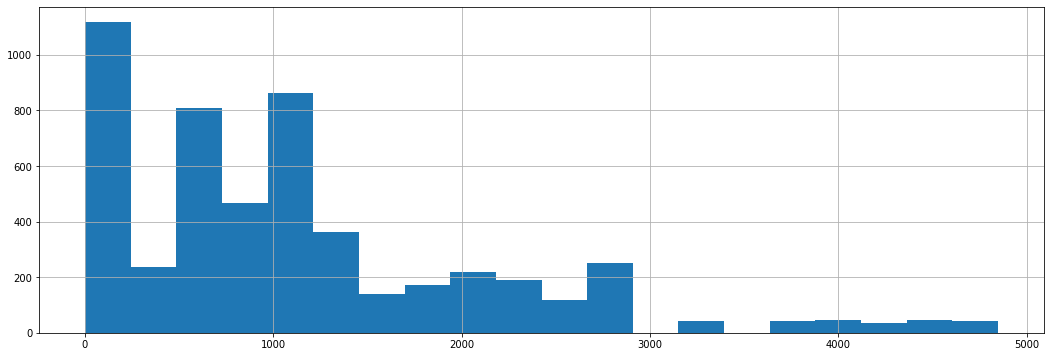

In [41]:
train_df['Healthcare_1'].hist(bins=20)

Вывод: Распределение значений признака Healthcare_1 далеко от нормального.

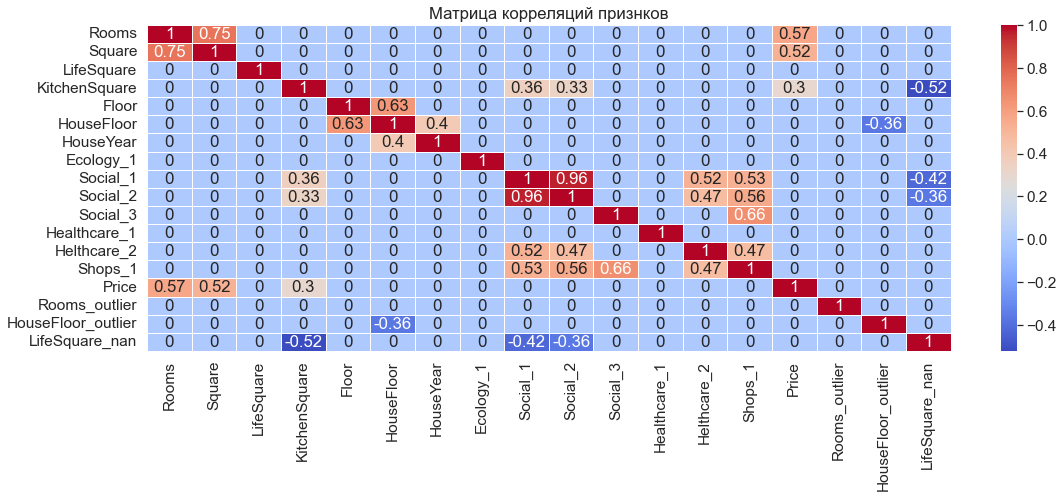

In [42]:
sns.set(font_scale=1.4)
corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < .3] = 0
sns.heatmap(corr_matrix, annot=True, linewidth=.5, cmap='coolwarm')
plt.title('Матрица корреляций признков')
plt.show()

значимых корреляций у признака Healthcare_1 с другими признаками у меня не удалось выявить.
Удаляю этот признак.

In [43]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [44]:
# import pandas_profiling
# from pandas_profiling import ProfileReport
# ProfileReport(train_df)
# не удалось установить пакет profiling для анализа HealthCare_1

### 4. Построение новых признаков

Генерация новой фичи (DistrictId_size) на основе частоты употребления значения (DistrictId) в выборке.

In [45]:
# тренировочка:
# train_df.groupby('DistrictId').size().sort_values(ascending=False)
# train_df.DistrictId.value_counts()

In [46]:
train_df['DistrictId_size'] = train_df['DistrictId'].map(train_df.groupby('DistrictId').size())

In [47]:
(train_df.DistrictId_size > 100).value_counts()

True     5069
False    4931
Name: DistrictId_size, dtype: int64

In [48]:
train_df['IsDistrictId_large'] = (train_df.DistrictId_size > 100) * 1
train_df['IsDistrictId_large']

0       1
1       0
2       1
3       1
4       0
       ..
9995    1
9996    1
9997    0
9998    1
9999    0
Name: IsDistrictId_large, Length: 10000, dtype: int32

Новая фича MedPriceByDistrict

In [49]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'})\
                                    .rename(columns={'Price': 'MedPriceByDistrict'})
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

Floor to Category: создание из вещественного признака номинативного;

In [50]:
train_df.Floor.max()

42

In [51]:
def floor_to_cat(df):
    bins=[0, 3, 5, 9, 15, df.Floor.max()]
    df['Floor_cat'] = pd.cut(df.Floor, bins=bins, labels=False)
    
    df.Floor_cat.fillna(-1, inplace=True)
    return df

In [52]:
floor_to_cat(train_df)

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0     11809         27    3.0  52.513310   39.513310           10.0      4   
1      3013         22    1.0  39.832524   23.169223            8.0      7   
2      8215          1    3.0  78.342215   47.671972           10.0      2   
3      2352          1    1.0  40.409907   34.409907            3.0     10   
4     13866         94    2.0  64.285067   38.562517            9.0     16   
...     ...        ...    ...        ...         ...            ...    ...   
9995   1260         61    2.0  49.090728   33.272626            6.0      3   
9996  16265         27    2.0  64.307684   37.038420            9.0     13   
9997   2795        178    1.0  52.513310   16.555363            5.0      3   
9998  14561         21    1.0  32.330292   22.326870            5.0      3   
9999   7202         94    1.0  35.815476   22.301367            6.0      9   

      HouseFloor  HouseYear  Ecology_1  ... Shops_1 Shops_2          Price  \
0           10.0       2014   0.075424  ...       0       B  305018.871089   
1            8.0       1966   0.118537  ...       0       B  177734.553407   
2           17.0       1988   0.025609  ...       1       B  282078.720850   
3           22.0       1977   0.007122  ...       1       B  168106.007630   
4           16.0       1972   0.282798  ...       6       B  343995.102962   
...          ...        ...        ...  ...     ...     ...            ...   
9995        12.0       1981   0.300323  ...       9       B  119367.455796   
9996        13.0       1977   0.072158  ...       0       A  199715.148807   
9997         5.0       1958   0.460556  ...       5       B  165953.912580   
9998         9.0       1969   0.194489  ...       5       B  171842.411855   
9999         9.0       1975   0.127376  ...       9       B  177685.627486   

      Rooms_outlier  HouseFloor_outlier  LifeSquare_nan  DistrictId_size  \
0                 0                   0               1              851   
1                 0                   0               0               78   
2                 0                   0               0              652   
3                 0                   0               1              652   
4                 0                   0               0               89   
...             ...                 ...             ...              ...   
9995              0                   0               0              118   
9996              0                   1               0              851   
9997              0                   0               0                7   
9998              0                   0               0              165   
9999              0                   0               0               89   

     IsDistrictId_large  MedPriceByDistrict  Floor_cat  
0                     1       213530.788443          1  
1                     0       146032.829834          2  
2                     1       244005.272380          0  
3                     1       146735.671740          3  
4                     0       201584.441255          4  
...                 ...                 ...        ...  
9995                  1       232514.855623          0  
9996                  1       165683.084779          3  
9997                  0       165953.912580          0  
9998                  1       153921.400690          0  
9999                  0       158830.639873          2  

[10000 rows x 26 columns]

Создание нового признака Year -->> Category;

In [53]:
def year_to_cat(df):
    bins=[0, 1940, 1950, 1970, 1990, 2000, 2010, df.HouseYear.max()]
    df['Year_cat'] = pd.cut(df.HouseYear, bins=bins, labels=False)
    
    df.Year_cat.fillna(-1, inplace=True)
    return df

In [54]:
year_to_cat(train_df)

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0     11809         27    3.0  52.513310   39.513310           10.0      4   
1      3013         22    1.0  39.832524   23.169223            8.0      7   
2      8215          1    3.0  78.342215   47.671972           10.0      2   
3      2352          1    1.0  40.409907   34.409907            3.0     10   
4     13866         94    2.0  64.285067   38.562517            9.0     16   
...     ...        ...    ...        ...         ...            ...    ...   
9995   1260         61    2.0  49.090728   33.272626            6.0      3   
9996  16265         27    2.0  64.307684   37.038420            9.0     13   
9997   2795        178    1.0  52.513310   16.555363            5.0      3   
9998  14561         21    1.0  32.330292   22.326870            5.0      3   
9999   7202         94    1.0  35.815476   22.301367            6.0      9   

      HouseFloor  HouseYear  Ecology_1  ... Shops_2          Price  \
0           10.0       2014   0.075424  ...       B  305018.871089   
1            8.0       1966   0.118537  ...       B  177734.553407   
2           17.0       1988   0.025609  ...       B  282078.720850   
3           22.0       1977   0.007122  ...       B  168106.007630   
4           16.0       1972   0.282798  ...       B  343995.102962   
...          ...        ...        ...  ...     ...            ...   
9995        12.0       1981   0.300323  ...       B  119367.455796   
9996        13.0       1977   0.072158  ...       A  199715.148807   
9997         5.0       1958   0.460556  ...       B  165953.912580   
9998         9.0       1969   0.194489  ...       B  171842.411855   
9999         9.0       1975   0.127376  ...       B  177685.627486   

      Rooms_outlier  HouseFloor_outlier  LifeSquare_nan  DistrictId_size  \
0                 0                   0               1              851   
1                 0                   0               0               78   
2                 0                   0               0              652   
3                 0                   0               1              652   
4                 0                   0               0               89   
...             ...                 ...             ...              ...   
9995              0                   0               0              118   
9996              0                   1               0              851   
9997              0                   0               0                7   
9998              0                   0               0              165   
9999              0                   0               0               89   

      IsDistrictId_large MedPriceByDistrict  Floor_cat  Year_cat  
0                      1      213530.788443          1         6  
1                      0      146032.829834          2         2  
2                      1      244005.272380          0         3  
3                      1      146735.671740          3         3  
4                      0      201584.441255          4         3  
...                  ...                ...        ...       ...  
9995                   1      232514.855623          0         3  
9996                   1      165683.084779          3         3  
9997                   0      165953.912580          0         2  
9998                   1      153921.400690          0         2  
9999                   0      158830.639873          2         3  

[10000 rows x 27 columns]

формирование новой переменной targetencoding year_floor:

In [55]:
MedPrice_floor_year = train_df.groupby(['Floor_cat', 'Year_cat'], as_index=False)\
                                .agg({'Price':'median'})\
                                .rename(columns={'Price': 'MedPriceByFloorYear'})
# MedPrice_floor_year
train_df = train_df.merge(MedPrice_floor_year, on=['Floor_cat', 'Year_cat'], how='left')

Замена литеральных значений числовыми в признаках: 'Ecology_2', 'Ecology_3', 'Shops_2':

In [56]:
train_df['Ecology_2'].value_counts(), \
train_df['Ecology_3'].value_counts(), \
train_df['Shops_2'].value_counts()

(B    9903
 A      97
 Name: Ecology_2, dtype: int64,
 B    9725
 A     275
 Name: Ecology_3, dtype: int64,
 B    9175
 A     825
 Name: Shops_2, dtype: int64)

In [57]:
train_df['Ecology_2'] = train_df['Ecology_2'].map({'A': 0, 'B': 1})
train_df['Ecology_3'] = train_df['Ecology_3'].map({'A': 0, 'B': 1})
train_df['Shops_2'] = train_df['Shops_2'].map({'A': 0, 'B': 1})

In [58]:
train_df[['Ecology_2', 'Ecology_3', 'Shops_2']]

Ecology_2  Ecology_3  Shops_2
0             1          1        1
1             1          1        1
2             1          1        1
3             1          1        1
4             1          1        1
...         ...        ...      ...
9995          1          1        1
9996          1          1        0
9997          1          1        1
9998          1          1        1
9999          1          1        1

[10000 rows x 3 columns]

In [59]:
class FeatureGen:
    
    def __init__(self):
        self.map_dict = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        
    def fit(self, df, y=None):
        df = df.copy()
        self.map_dict = {'A': 0, 'B': 1}
        
        df_1 = df.copy()
        
        if y is not None:
            df_1['Price'] = y.values
            self.med_price_by_district = df_1.groupby(['DistrictId', 'Rooms'], as_index=False)\
                                            .agg({'Price': 'median'})\
                                            .rename(columns={'Price': 'MedPriceByDistrict'})
            self.med_price_by_district_median = \
                                self.med_price_by_district['MedPriceByDistrict'].median()
    
        if y is not None:
            self.floor_max = df_1.Floor.max()
            self.year_max = df_1.HouseYear.max()
            df_1['Price'] = y.values
            df_1 = self.floor_to_cat(df_1)
            df_1 = self.year_to_cat(df_1)
            self.med_price_by_floor_year = df_1.groupby(['Floor_cat', 'Year_cat'], as_index=False)\
                                            .agg({'Price': 'median'})\
                                            .rename(columns={'Price': 'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = \
                                self.med_price_by_floor_year['MedPriceByFloorYear'].median()
    
    def transform(self, df):
        df['Ecology_2'] = df['Ecology_2'].map(self.map_dict)
        df['Ecology_3'] = df['Ecology_3'].map(self.map_dict)
        df['Shops_2']   = df['Shops_2'].map(self.map_dict)
        
        df['DistrictId_size'] = df['DistrictId'].map(df.groupby('DistrictId').size())
        
        df['new_district'] = 0
        df.loc[df['DistrictId_size'].isna(), 'new_district'] = 1
        
        df['DistrictId_size'].fillna(5, inplace=True)
        
        df['IsDistrictLarge'] = (df['DistrictId_size'] > 100) * 1
                
        df = self.floor_to_cat(df)
        df = self.year_to_cat(df)
        
        if self.med_price_by_district is not None:
            df = df.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            df['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
        
        if self.med_price_by_floor_year is not None:
            df = df.merge(self.med_price_by_floor_year, on=['Floor_cat', 'Year_cat'], how='left')
            df['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return df
    
    def floor_to_cat(self, df):
        bins=[0, 3, 5, 9, 15, df.Floor.max()]
        df['Floor_cat'] = pd.cut(df.Floor, bins=bins, labels=False)
        df.Floor_cat.fillna(-1, inplace=True)
        return df
    
    def year_to_cat(self, df):
        bins=[0, 1940, 1950, 1970, 1990, 2000, 2010, df.HouseYear.max()]
        df['Year_cat'] = pd.cut(df.HouseFloor, bins=bins, labels=False)
        df.Year_cat.fillna(-1, inplace=True)
        return df

### 5. Отбор признаков

In [60]:
train_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Price', 'Rooms_outlier', 'HouseFloor_outlier',
       'LifeSquare_nan', 'DistrictId_size', 'IsDistrictId_large',
       'MedPriceByDistrict', 'Floor_cat', 'Year_cat', 'MedPriceByFloorYear'],
      dtype='object')

In [61]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 
                 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 
                 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2']
new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 
                     'DistrictId_size', 'new_district', 'IsDistrictLarge', 'MedPriceByDistrict', 
                     'MedPriceByFloorYear']
target_name = 'Price'

### 6. Разбиение на train & valid

In [62]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [63]:
X_train, X_valid,  y_train, y_valid = train_test_split(X, y, test_size=.3, \
                                                      shuffle=True, random_state=29)

In [64]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

preprocessor.transform(X_train)
preprocessor.transform(X_valid)
preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 22), (3000, 22), (5000, 22))

In [65]:
features_gen = FeatureGen()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 29), (3000, 29), (5000, 29))

In [66]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]
X_train.shape, X_valid.shape, test_df.shape

((7000, 25), (3000, 25), (5000, 25))

In [67]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 7. Построение модели

###### 1. DecisionTree model

Train_R2:	0.759038881918737
Valid_R2:	0.5977792662507833


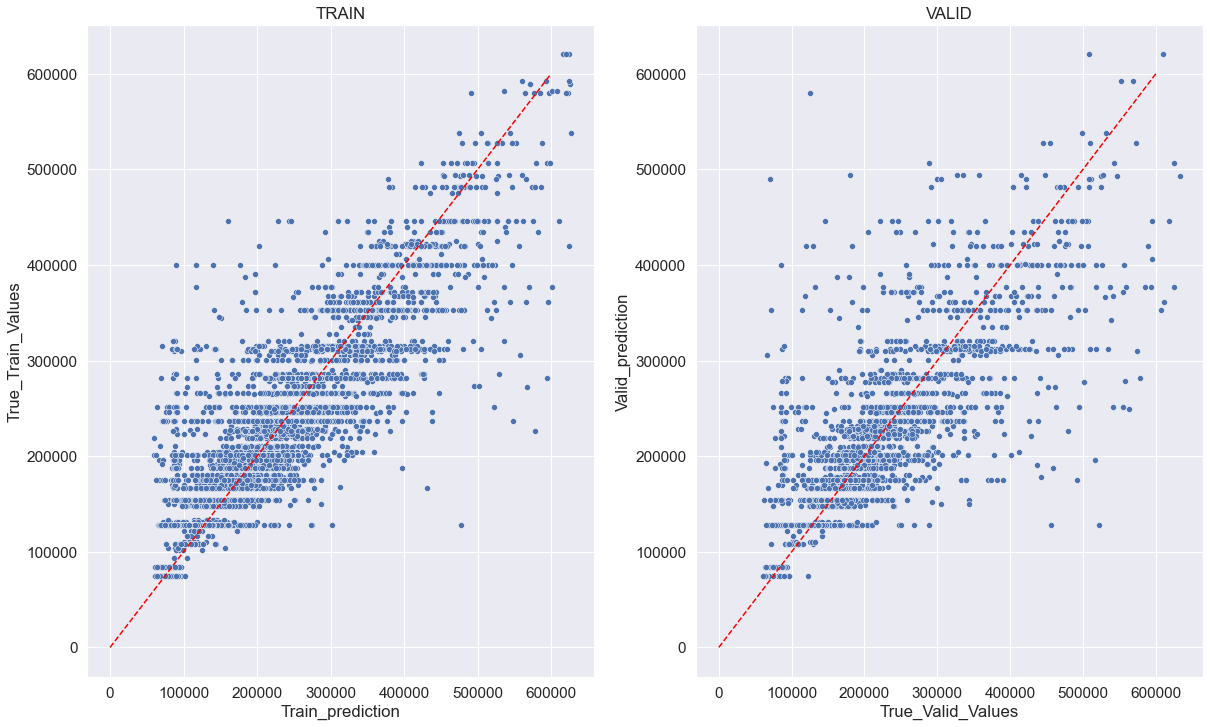

In [68]:
DecisionTree_model = DecisionTreeRegressor(criterion='mse',
                                           max_depth=7,
                                           min_samples_leaf=3,
                                           random_state=29)
DecisionTree_model.fit(X_train, y_train)
y_train_pred = DecisionTree_model.predict(X_train)
y_valid_pred = DecisionTree_model.predict(X_valid)
evaluate_pred(y_train, y_train_pred, y_valid, y_valid_pred)


Модель основанная на Деревьях Решений (DecisionTreeRegressro) переобучена.

###### 2. RamdomForest model

Train_R2:	0.7463492207746227
Valid_R2:	0.6220370131795081


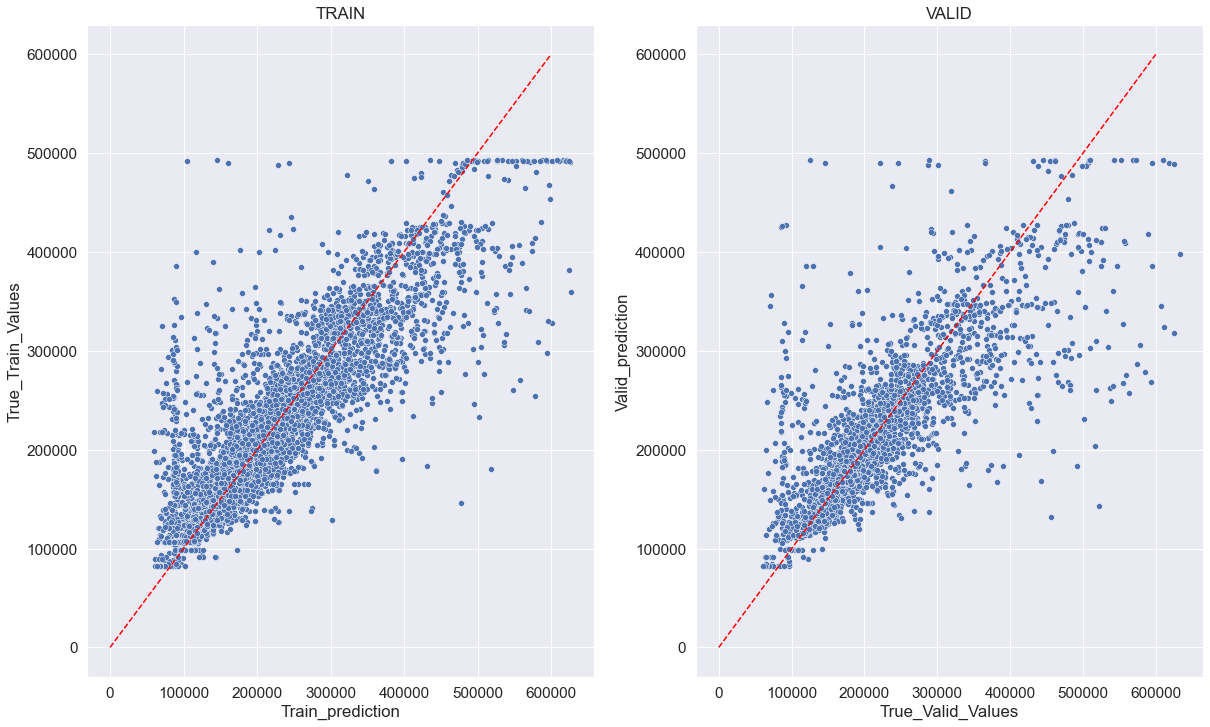

In [69]:
RandomForest_model = RandomForestRegressor(criterion='mse',
                                           max_depth=10,
                                           min_samples_leaf=40,
                                           n_estimators=100,
                                           random_state=29)
RandomForest_model.fit(X_train, y_train)
y_train_pred = RandomForest_model.predict(X_train)
y_valid_pred = RandomForest_model.predict(X_valid)
evaluate_pred(y_train, y_train_pred, y_valid, y_valid_pred)

Train_R2:	0.9638260406701973
Valid_R2:	0.6835638188383567


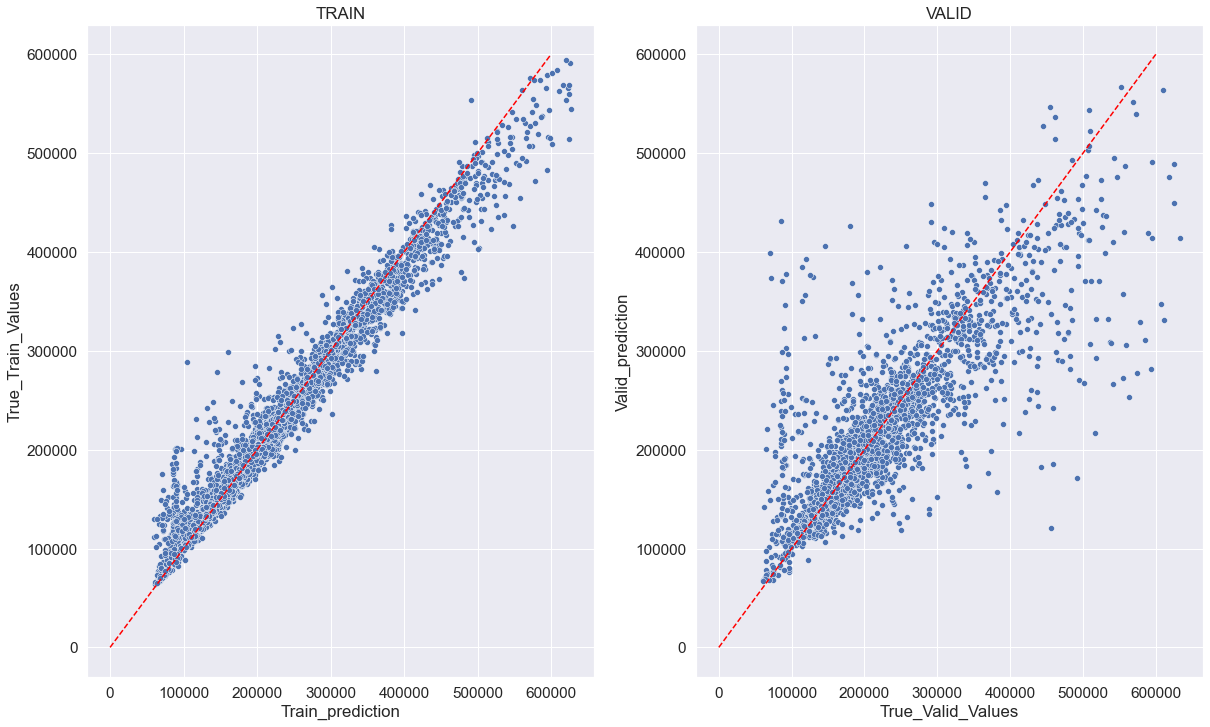

In [70]:
# на дефолтных параметрах
rf_model_2 = RandomForestRegressor(criterion='mse', random_state=29,)
#                                    max_depth=12, min_samples_leaf=5,
#                                    n_estimators=300)
rf_model_2.fit(X_train, y_train)
y_train_pred = rf_model_2.predict(X_train)
y_valid_pred = rf_model_2.predict(X_valid)
evaluate_pred(y_train, y_train_pred, y_valid, y_valid_pred)

In [71]:
%%time
# поиск по сетке параметров для RandomForest
params = {'max_depth': [3, 5, 7, 10, 12],
          'min_samples_leaf': [5, 10, 20, 30],
          'n_estimators': [50, 100, 200, 300]}
gs_2 = GridSearchCV(rf_model_2, params, scoring='r2',
                    cv=KFold(n_splits=5,
                             shuffle=True,
                             random_state=29),
                    n_jobs=-1)
# gs_2.fit(X_train, y_train)

Wall time: 3min 41s


GridSearchCV(cv=KFold(n_splits=5, random_state=29, shuffle=True),
             estimator=RandomForestRegressor(random_state=29), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, 12],
                         'min_samples_leaf': [5, 10, 20, 30],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='r2')

In [72]:
# gs_2.best_params_, gs_2.best_score_

({'max_depth': 12, 'min_samples_leaf': 5, 'n_estimators': 100},
 0.7419431309651093)

({'max_depth': 12, 'min_samples_leaf': 5, 'n_estimators': 100},
 0.7419431309651093)

In [73]:
# res = pd.DataFrame(gs_2.cv_results_)
# res[['param_max_depth', 'param_min_samples_leaf', 'param_n_estimators', 'rank_test_score']]\
#                         .sort_values('rank_test_score').head(2)

param_max_depth param_min_samples_leaf param_n_estimators  rank_test_score
65              12                      5                100                1
66              12                      5                200                2

	param_max_depth | param_min_samples_leaf | param_n_estimators | rank_test_score
65 | 12 | 5 | 100 | 1
66 | 12 | 5 | 200 | 2

Train_R2:	0.8678046146622268
Valid_R2:	0.6686977245301153


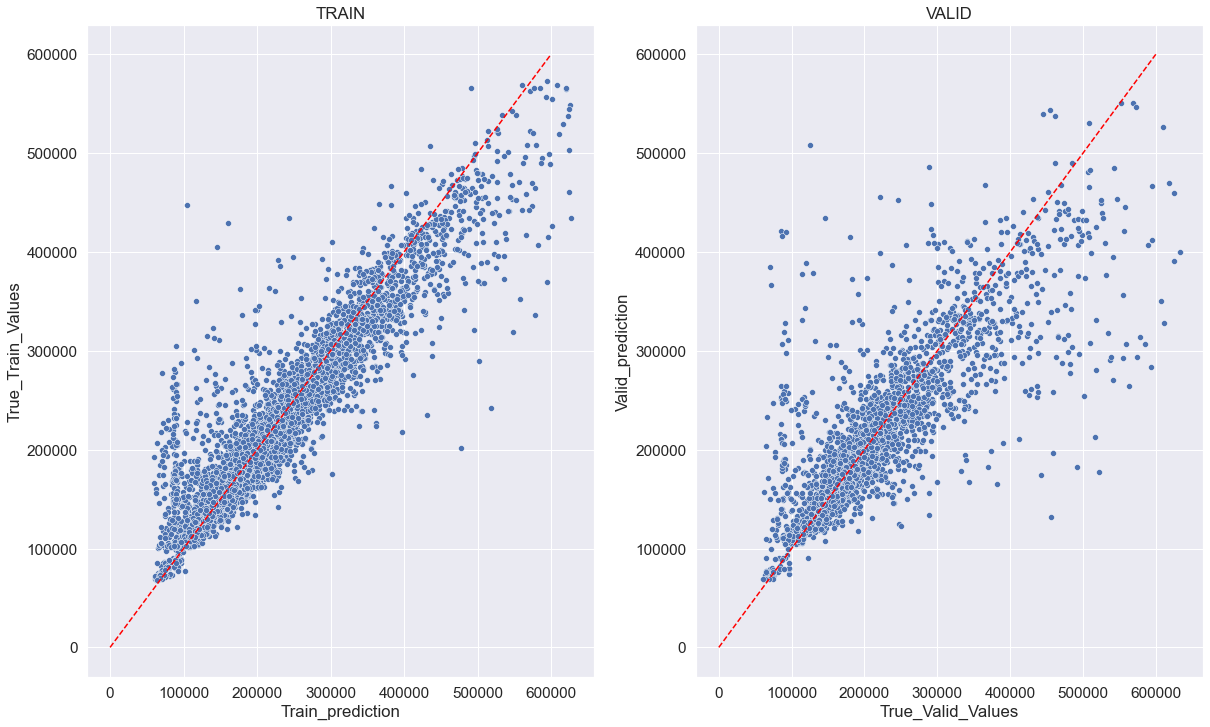

In [74]:
rf_model_2 = RandomForestRegressor(criterion='mse', random_state=29,
                                   max_depth=12, min_samples_leaf=5,
                                   n_estimators=300)
rf_model_2.fit(X_train, y_train)
y_train_pred = rf_model_2.predict(X_train)
y_valid_pred = rf_model_2.predict(X_valid)
evaluate_pred(y_train, y_train_pred, y_valid, y_valid_pred)

###### 3. GradientBoosting_DT

Train_R2:	0.8313806326650935
Valid_R2:	0.6862036205576161


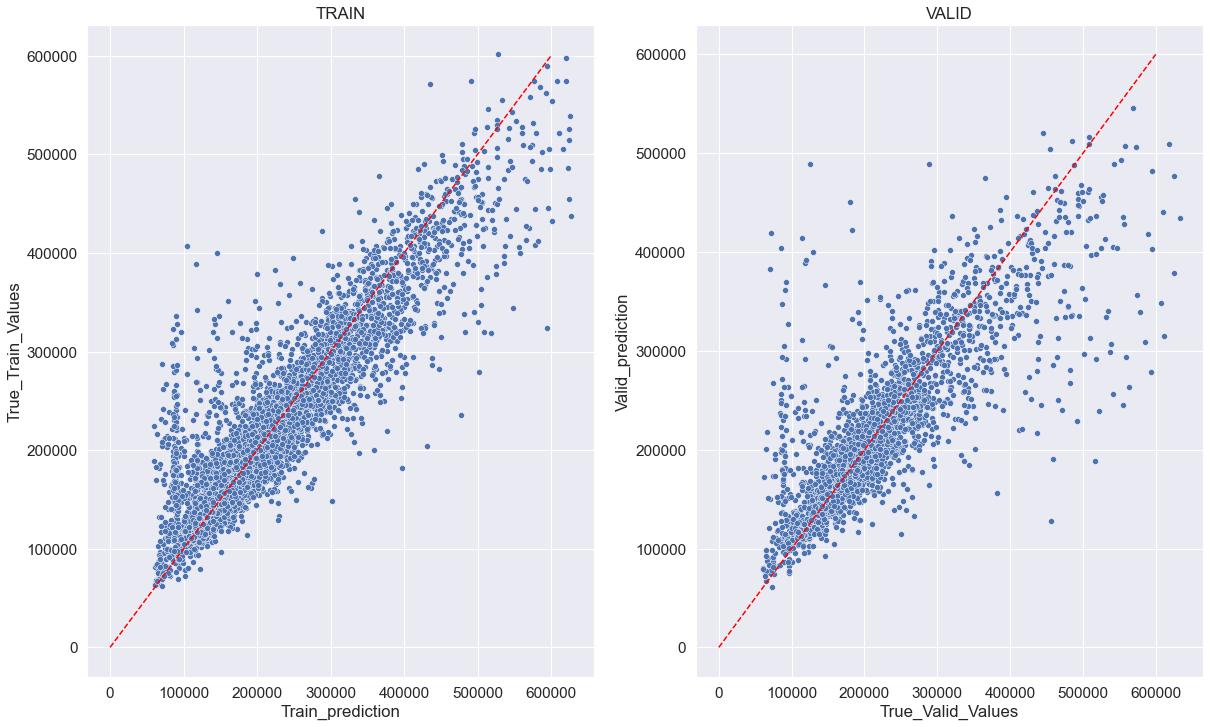

In [97]:
GradientBoosting_model = GradientBoostingRegressor(criterion='mse',
                                                   max_depth=3,
                                                   min_samples_leaf=30,
                                                   n_estimators=400,
                                                   random_state=29)
GradientBoosting_model.fit(X_train, y_train)
y_train_pred = GradientBoosting_model.predict(X_train)
y_valid_pred = GradientBoosting_model.predict(X_valid)
evaluate_pred(y_train, y_train_pred, y_valid, y_valid_pred)
# гиперпараметры модели взял из поиска по сетке.

###### *4. поиск по сетке параметров для модели GradientBoosting*

In [98]:
%%time
params = {'max_depth': [3, 5, 7, 10, 12],
          'min_samples_leaf': [5, 10, 20, 30],
          'n_estimators': [50, 100, 200, 400]}
grid_search = GridSearchCV(GradientBoosting_model, params,
                           scoring='r2',
                           cv=KFold(n_splits=5,
                                    random_state=29,
                                    shuffle=True),
                           n_jobs=-1)
# grid_search.fit(X_train, y_train)

Wall time: 0 ns


In [99]:
grid_search.best_params_, grid_search.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [78]:
res = pd.DataFrame(grid_search.cv_results_)
res.sort_values('rank_test_score').head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
11       4.513022      0.032550         0.009565        0.001562   
26       4.114616      0.108243         0.006744        0.002464   

   param_max_depth param_min_samples_leaf param_n_estimators  \
11               3                     20                400   
26               5                     20                200   

                                               params  split0_test_score  \
11  {'max_depth': 3, 'min_samples_leaf': 20, 'n_es...           0.750203   
26  {'max_depth': 5, 'min_samples_leaf': 20, 'n_es...           0.751811   

    split1_test_score  split2_test_score  split3_test_score  \
11           0.757310           0.747356           0.741485   
26           0.752132           0.752788           0.743156   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
11           0.783012         0.755873        0.014494                1  
26           0.773907         0.754759        0.010205                2

Вывод для результатов поиска по сетке параметров для метода GradientBoosting - лучшие параметры демонстрируют признаки переобучения: разница r2 train/valid - почти 15%! Но пока что это лучшний результат.

In [79]:
from catboost import CatBoostRegressor
catb = CatBoostRegressor(random_state=29)
# catb.fit(X_train, y_train, verbose=False,) #plot=True)
# y_train_pred = catb.predict(X_train)
# y_valid_pred = catb.predict(X_valid)
# evaluate_pred(y_train, y_train_pred, y_valid, y_valid_pred)

In [80]:
params = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

# grid_search_result = catb.grid_search(params, verbose=False, X=X_train, y=y_train,) # plot=True)

0:	learn: 226451.0805253	test: 226552.7976606	best: 226552.7976606 (0)	total: 141ms	remaining: 2m 20s
1:	learn: 220409.9004100	test: 220629.4532470	best: 220629.4532470 (1)	total: 145ms	remaining: 1m 12s
2:	learn: 214398.6592501	test: 214538.4834801	best: 214538.4834801 (2)	total: 149ms	remaining: 49.5s
3:	learn: 208479.2356058	test: 208678.5648661	best: 208678.5648661 (3)	total: 153ms	remaining: 38s
4:	learn: 202944.8290522	test: 203052.2190215	best: 203052.2190215 (4)	total: 156ms	remaining: 31s
5:	learn: 197603.4869789	test: 197727.8121133	best: 197727.8121133 (5)	total: 159ms	remaining: 26.4s
6:	learn: 192321.4317346	test: 192557.4927634	best: 192557.4927634 (6)	total: 162ms	remaining: 23s
7:	learn: 187188.3790549	test: 187427.6646748	best: 187427.6646748 (7)	total: 165ms	remaining: 20.5s
8:	learn: 182282.1401713	test: 182486.5801000	best: 182486.5801000 (8)	total: 168ms	remaining: 18.5s
9:	learn: 177508.0192750	test: 177799.2135492	best: 177799.2135492 (9)	total: 171ms	remaining: 

119:	learn: 50379.0897858	test: 52640.0141747	best: 52640.0141747 (119)	total: 314ms	remaining: 2.31s
120:	learn: 50312.9095944	test: 52583.7029873	best: 52583.7029873 (120)	total: 316ms	remaining: 2.29s
121:	learn: 50248.3746219	test: 52514.9396021	best: 52514.9396021 (121)	total: 317ms	remaining: 2.28s
122:	learn: 50195.7122350	test: 52469.9513392	best: 52469.9513392 (122)	total: 319ms	remaining: 2.27s
123:	learn: 50134.5731961	test: 52426.1397095	best: 52426.1397095 (123)	total: 320ms	remaining: 2.26s
124:	learn: 50085.2543660	test: 52381.4171297	best: 52381.4171297 (124)	total: 321ms	remaining: 2.25s
125:	learn: 50027.4763174	test: 52328.5080686	best: 52328.5080686 (125)	total: 322ms	remaining: 2.24s
126:	learn: 49970.7232797	test: 52289.0590815	best: 52289.0590815 (126)	total: 324ms	remaining: 2.23s
127:	learn: 49916.4850877	test: 52251.1021535	best: 52251.1021535 (127)	total: 325ms	remaining: 2.21s
128:	learn: 49856.0390275	test: 52196.2389995	best: 52196.2389995 (128)	total: 326

256:	learn: 46041.7075552	test: 49409.6395191	best: 49409.6395191 (256)	total: 490ms	remaining: 1.42s
257:	learn: 46010.6607579	test: 49392.2913517	best: 49392.2913517 (257)	total: 492ms	remaining: 1.41s
258:	learn: 45984.0539405	test: 49373.0436269	best: 49373.0436269 (258)	total: 493ms	remaining: 1.41s
259:	learn: 45969.8246001	test: 49364.1069838	best: 49364.1069838 (259)	total: 495ms	remaining: 1.41s
260:	learn: 45947.8684903	test: 49351.1395023	best: 49351.1395023 (260)	total: 496ms	remaining: 1.4s
261:	learn: 45915.7226227	test: 49326.6062457	best: 49326.6062457 (261)	total: 497ms	remaining: 1.4s
262:	learn: 45895.8752574	test: 49313.8583617	best: 49313.8583617 (262)	total: 498ms	remaining: 1.4s
263:	learn: 45882.8589567	test: 49302.4521827	best: 49302.4521827 (263)	total: 500ms	remaining: 1.39s
264:	learn: 45872.7600918	test: 49293.0046428	best: 49293.0046428 (264)	total: 501ms	remaining: 1.39s
265:	learn: 45855.2284186	test: 49287.0121413	best: 49287.0121413 (265)	total: 502ms	

396:	learn: 43498.1351889	test: 47944.2547120	best: 47944.2547120 (396)	total: 670ms	remaining: 1.02s
397:	learn: 43484.4086913	test: 47944.6997813	best: 47944.2547120 (396)	total: 671ms	remaining: 1.01s
398:	learn: 43465.6808093	test: 47934.2914900	best: 47934.2914900 (398)	total: 672ms	remaining: 1.01s
399:	learn: 43451.2557770	test: 47927.3089991	best: 47927.3089991 (399)	total: 673ms	remaining: 1.01s
400:	learn: 43439.4262841	test: 47923.2106187	best: 47923.2106187 (400)	total: 674ms	remaining: 1.01s
401:	learn: 43417.1677882	test: 47916.1816757	best: 47916.1816757 (401)	total: 676ms	remaining: 1s
402:	learn: 43405.7212433	test: 47908.8310833	best: 47908.8310833 (402)	total: 677ms	remaining: 1s
403:	learn: 43396.9167712	test: 47895.7418825	best: 47895.7418825 (403)	total: 678ms	remaining: 1s
404:	learn: 43380.0698005	test: 47891.7259450	best: 47891.7259450 (404)	total: 680ms	remaining: 999ms
405:	learn: 43366.4081337	test: 47885.1857459	best: 47885.1857459 (405)	total: 681ms	remain

536:	learn: 41511.9874903	test: 47176.4329822	best: 47163.9427125 (532)	total: 848ms	remaining: 731ms
537:	learn: 41496.7595245	test: 47163.5947561	best: 47163.5947561 (537)	total: 850ms	remaining: 730ms
538:	learn: 41490.5479485	test: 47161.7137607	best: 47161.7137607 (538)	total: 851ms	remaining: 728ms
539:	learn: 41479.0860424	test: 47161.4861416	best: 47161.4861416 (539)	total: 852ms	remaining: 726ms
540:	learn: 41471.9833002	test: 47157.6032479	best: 47157.6032479 (540)	total: 854ms	remaining: 724ms
541:	learn: 41463.2067374	test: 47151.7750748	best: 47151.7750748 (541)	total: 855ms	remaining: 723ms
542:	learn: 41451.8764807	test: 47140.5942835	best: 47140.5942835 (542)	total: 856ms	remaining: 721ms
543:	learn: 41441.3403079	test: 47135.4129881	best: 47135.4129881 (543)	total: 858ms	remaining: 719ms
544:	learn: 41430.8395578	test: 47128.5949930	best: 47128.5949930 (544)	total: 859ms	remaining: 717ms
545:	learn: 41416.5611201	test: 47125.7251287	best: 47125.7251287 (545)	total: 860

661:	learn: 39965.1970845	test: 46662.7506096	best: 46662.7506096 (661)	total: 1.02s	remaining: 522ms
662:	learn: 39950.5382511	test: 46667.2012305	best: 46662.7506096 (661)	total: 1.02s	remaining: 520ms
663:	learn: 39939.8664793	test: 46660.4921463	best: 46660.4921463 (663)	total: 1.02s	remaining: 518ms
664:	learn: 39926.0876574	test: 46649.0041354	best: 46649.0041354 (664)	total: 1.02s	remaining: 517ms
665:	learn: 39910.9787506	test: 46649.8195443	best: 46649.0041354 (664)	total: 1.03s	remaining: 515ms
666:	learn: 39895.9499899	test: 46641.3555385	best: 46641.3555385 (666)	total: 1.03s	remaining: 513ms
667:	learn: 39878.2104045	test: 46634.5996076	best: 46634.5996076 (667)	total: 1.03s	remaining: 512ms
668:	learn: 39861.5752091	test: 46627.9208671	best: 46627.9208671 (668)	total: 1.03s	remaining: 510ms
669:	learn: 39846.9977820	test: 46613.5657776	best: 46613.5657776 (669)	total: 1.03s	remaining: 508ms
670:	learn: 39840.5920394	test: 46609.4674704	best: 46609.4674704 (670)	total: 1.0

799:	learn: 38710.2496335	test: 46333.2767915	best: 46328.2610573 (797)	total: 1.2s	remaining: 300ms
800:	learn: 38708.6210064	test: 46335.2242267	best: 46328.2610573 (797)	total: 1.2s	remaining: 298ms
801:	learn: 38703.0548771	test: 46337.8736017	best: 46328.2610573 (797)	total: 1.2s	remaining: 297ms
802:	learn: 38698.8767888	test: 46336.8713653	best: 46328.2610573 (797)	total: 1.2s	remaining: 295ms
803:	learn: 38688.3278283	test: 46337.3388403	best: 46328.2610573 (797)	total: 1.2s	remaining: 294ms
804:	learn: 38680.2152370	test: 46337.5652608	best: 46328.2610573 (797)	total: 1.21s	remaining: 292ms
805:	learn: 38671.4138647	test: 46334.4170119	best: 46328.2610573 (797)	total: 1.21s	remaining: 290ms
806:	learn: 38668.8544776	test: 46337.3287287	best: 46328.2610573 (797)	total: 1.21s	remaining: 289ms
807:	learn: 38654.9120815	test: 46336.9358618	best: 46328.2610573 (797)	total: 1.21s	remaining: 287ms
808:	learn: 38653.2537808	test: 46336.6115113	best: 46328.2610573 (797)	total: 1.21s	re

941:	learn: 37691.9828684	test: 46094.4954664	best: 46094.0635267 (940)	total: 1.38s	remaining: 84.9ms
942:	learn: 37680.2918983	test: 46094.9760212	best: 46094.0635267 (940)	total: 1.38s	remaining: 83.4ms
943:	learn: 37674.8006315	test: 46095.9139621	best: 46094.0635267 (940)	total: 1.38s	remaining: 82ms
944:	learn: 37669.4856349	test: 46089.2902023	best: 46089.2902023 (944)	total: 1.38s	remaining: 80.5ms
945:	learn: 37666.4829933	test: 46089.2187518	best: 46089.2187518 (945)	total: 1.38s	remaining: 79ms
946:	learn: 37664.8722325	test: 46091.6384528	best: 46089.2187518 (945)	total: 1.39s	remaining: 77.5ms
947:	learn: 37654.9955598	test: 46090.4937404	best: 46089.2187518 (945)	total: 1.39s	remaining: 76.1ms
948:	learn: 37644.5154075	test: 46086.0991175	best: 46086.0991175 (948)	total: 1.39s	remaining: 74.6ms
949:	learn: 37633.4078720	test: 46085.2555737	best: 46085.2555737 (949)	total: 1.39s	remaining: 73.1ms
950:	learn: 37630.8537861	test: 46082.4427934	best: 46082.4427934 (950)	total

64:	learn: 47055.1971978	test: 50159.2844768	best: 50159.2844768 (64)	total: 96.5ms	remaining: 1.39s
65:	learn: 47007.6507430	test: 50114.9375543	best: 50114.9375543 (65)	total: 97.8ms	remaining: 1.38s
66:	learn: 46903.3097824	test: 50017.5311154	best: 50017.5311154 (66)	total: 99ms	remaining: 1.38s
67:	learn: 46837.3689296	test: 49966.6106807	best: 49966.6106807 (67)	total: 100ms	remaining: 1.38s
68:	learn: 46795.3552320	test: 49948.1636275	best: 49948.1636275 (68)	total: 102ms	remaining: 1.37s
69:	learn: 46647.7075567	test: 49881.2720418	best: 49881.2720418 (69)	total: 103ms	remaining: 1.37s
70:	learn: 46591.7579737	test: 49864.5019308	best: 49864.5019308 (70)	total: 104ms	remaining: 1.36s
71:	learn: 46496.3251918	test: 49767.1958577	best: 49767.1958577 (71)	total: 106ms	remaining: 1.36s
72:	learn: 46411.5018888	test: 49731.7540886	best: 49731.7540886 (72)	total: 107ms	remaining: 1.36s
73:	learn: 46338.6512576	test: 49671.0503985	best: 49671.0503985 (73)	total: 108ms	remaining: 1.36s

205:	learn: 39570.8121844	test: 46689.0254353	best: 46689.0254353 (205)	total: 275ms	remaining: 1.06s
206:	learn: 39541.4846516	test: 46699.7319312	best: 46689.0254353 (205)	total: 276ms	remaining: 1.06s
207:	learn: 39507.8044784	test: 46714.9594659	best: 46689.0254353 (205)	total: 278ms	remaining: 1.06s
208:	learn: 39496.9513971	test: 46698.2100423	best: 46689.0254353 (205)	total: 279ms	remaining: 1.05s
209:	learn: 39474.0827566	test: 46715.4884956	best: 46689.0254353 (205)	total: 280ms	remaining: 1.05s
210:	learn: 39455.2534501	test: 46702.6933797	best: 46689.0254353 (205)	total: 281ms	remaining: 1.05s
211:	learn: 39411.8786447	test: 46675.5799322	best: 46675.5799322 (211)	total: 283ms	remaining: 1.05s
212:	learn: 39369.0852832	test: 46695.9326807	best: 46675.5799322 (211)	total: 284ms	remaining: 1.05s
213:	learn: 39335.0754026	test: 46685.9901349	best: 46675.5799322 (211)	total: 285ms	remaining: 1.05s
214:	learn: 39285.9419049	test: 46700.9205678	best: 46675.5799322 (211)	total: 286

351:	learn: 36114.3222763	test: 46270.2747625	best: 46253.1594640 (348)	total: 457ms	remaining: 840ms
352:	learn: 36068.2356463	test: 46270.0379972	best: 46253.1594640 (348)	total: 458ms	remaining: 839ms
353:	learn: 36049.3834239	test: 46256.8430792	best: 46253.1594640 (348)	total: 459ms	remaining: 838ms
354:	learn: 36027.1542427	test: 46227.5104445	best: 46227.5104445 (354)	total: 460ms	remaining: 836ms
355:	learn: 36005.2008416	test: 46212.8120339	best: 46212.8120339 (355)	total: 462ms	remaining: 835ms
356:	learn: 35984.6162063	test: 46220.5746260	best: 46212.8120339 (355)	total: 463ms	remaining: 834ms
357:	learn: 35962.6264936	test: 46222.3145694	best: 46212.8120339 (355)	total: 464ms	remaining: 832ms
358:	learn: 35941.0031673	test: 46220.8465821	best: 46212.8120339 (355)	total: 465ms	remaining: 831ms
359:	learn: 35908.5925754	test: 46220.5851018	best: 46212.8120339 (355)	total: 467ms	remaining: 829ms
360:	learn: 35899.1557897	test: 46220.0926024	best: 46212.8120339 (355)	total: 468

487:	learn: 33660.6632207	test: 46066.9586220	best: 45999.7277911 (402)	total: 628ms	remaining: 659ms
488:	learn: 33638.0360707	test: 46048.4640136	best: 45999.7277911 (402)	total: 630ms	remaining: 658ms
489:	learn: 33618.0572385	test: 46057.3636115	best: 45999.7277911 (402)	total: 631ms	remaining: 657ms
490:	learn: 33599.0675326	test: 46048.7425767	best: 45999.7277911 (402)	total: 632ms	remaining: 655ms
491:	learn: 33588.8057576	test: 46054.0834098	best: 45999.7277911 (402)	total: 634ms	remaining: 654ms
492:	learn: 33575.1112164	test: 46042.8929044	best: 45999.7277911 (402)	total: 635ms	remaining: 653ms
493:	learn: 33557.3538644	test: 46035.6052379	best: 45999.7277911 (402)	total: 636ms	remaining: 651ms
494:	learn: 33551.3884445	test: 46035.7007321	best: 45999.7277911 (402)	total: 637ms	remaining: 650ms
495:	learn: 33541.6227068	test: 46034.0139876	best: 45999.7277911 (402)	total: 638ms	remaining: 649ms
496:	learn: 33529.6838408	test: 46043.8329869	best: 45999.7277911 (402)	total: 640

631:	learn: 31570.3211171	test: 46028.2182071	best: 45982.3496765 (509)	total: 810ms	remaining: 472ms
632:	learn: 31567.2798503	test: 46027.9430357	best: 45982.3496765 (509)	total: 811ms	remaining: 470ms
633:	learn: 31563.1722992	test: 46026.8747354	best: 45982.3496765 (509)	total: 812ms	remaining: 469ms
634:	learn: 31544.2699773	test: 46014.2289325	best: 45982.3496765 (509)	total: 814ms	remaining: 468ms
635:	learn: 31525.8721187	test: 46009.3519596	best: 45982.3496765 (509)	total: 815ms	remaining: 467ms
636:	learn: 31521.6703499	test: 46013.6593184	best: 45982.3496765 (509)	total: 816ms	remaining: 465ms
637:	learn: 31503.8106134	test: 46012.4448425	best: 45982.3496765 (509)	total: 818ms	remaining: 464ms
638:	learn: 31486.0927620	test: 46013.6406619	best: 45982.3496765 (509)	total: 819ms	remaining: 463ms
639:	learn: 31479.9413731	test: 46016.4725763	best: 45982.3496765 (509)	total: 820ms	remaining: 461ms
640:	learn: 31460.6623196	test: 46015.3671993	best: 45982.3496765 (509)	total: 821

762:	learn: 29992.1203385	test: 46008.8535199	best: 45959.8160113 (741)	total: 984ms	remaining: 306ms
763:	learn: 29973.0587860	test: 46006.5638748	best: 45959.8160113 (741)	total: 985ms	remaining: 304ms
764:	learn: 29966.2054460	test: 46017.4607112	best: 45959.8160113 (741)	total: 986ms	remaining: 303ms
765:	learn: 29953.2016373	test: 46021.6983878	best: 45959.8160113 (741)	total: 988ms	remaining: 302ms
766:	learn: 29946.8784967	test: 46018.1918513	best: 45959.8160113 (741)	total: 989ms	remaining: 300ms
767:	learn: 29934.0528115	test: 46011.8044037	best: 45959.8160113 (741)	total: 991ms	remaining: 299ms
768:	learn: 29926.8533686	test: 46015.8387797	best: 45959.8160113 (741)	total: 992ms	remaining: 298ms
769:	learn: 29922.1740358	test: 46011.4934763	best: 45959.8160113 (741)	total: 998ms	remaining: 298ms
770:	learn: 29909.3435187	test: 46015.9921859	best: 45959.8160113 (741)	total: 1000ms	remaining: 297ms
771:	learn: 29895.9287511	test: 46018.8668406	best: 45959.8160113 (741)	total: 1s

892:	learn: 28673.5407928	test: 46090.5031936	best: 45959.8160113 (741)	total: 1.16s	remaining: 139ms
893:	learn: 28657.0651748	test: 46091.4133590	best: 45959.8160113 (741)	total: 1.16s	remaining: 138ms
894:	learn: 28650.3534973	test: 46098.5901221	best: 45959.8160113 (741)	total: 1.16s	remaining: 136ms
895:	learn: 28642.6111643	test: 46108.1156374	best: 45959.8160113 (741)	total: 1.16s	remaining: 135ms
896:	learn: 28636.6939140	test: 46103.9321862	best: 45959.8160113 (741)	total: 1.16s	remaining: 134ms
897:	learn: 28626.2163897	test: 46100.0729485	best: 45959.8160113 (741)	total: 1.17s	remaining: 132ms
898:	learn: 28618.9805737	test: 46099.2305665	best: 45959.8160113 (741)	total: 1.17s	remaining: 131ms
899:	learn: 28611.9954733	test: 46100.6421421	best: 45959.8160113 (741)	total: 1.17s	remaining: 130ms
900:	learn: 28601.8426024	test: 46101.7455700	best: 45959.8160113 (741)	total: 1.17s	remaining: 128ms
901:	learn: 28595.3918078	test: 46108.3015566	best: 45959.8160113 (741)	total: 1.1

17:	learn: 145140.8030256	test: 145513.3999262	best: 145513.3999262 (17)	total: 28.8ms	remaining: 1.57s
18:	learn: 141556.2486025	test: 141948.3477883	best: 141948.3477883 (18)	total: 30.2ms	remaining: 1.56s
19:	learn: 138148.3212757	test: 138528.8541954	best: 138528.8541954 (19)	total: 31.8ms	remaining: 1.56s
20:	learn: 134782.7912126	test: 135142.2469251	best: 135142.2469251 (20)	total: 33.2ms	remaining: 1.55s
21:	learn: 131585.8869359	test: 131917.8578386	best: 131917.8578386 (21)	total: 34.3ms	remaining: 1.52s
22:	learn: 128517.1019146	test: 128847.1528501	best: 128847.1528501 (22)	total: 35.7ms	remaining: 1.51s
23:	learn: 125489.2002439	test: 125882.1436038	best: 125882.1436038 (23)	total: 37.2ms	remaining: 1.51s
24:	learn: 122520.2921917	test: 122932.5590177	best: 122932.5590177 (24)	total: 38.5ms	remaining: 1.5s
25:	learn: 119747.2845271	test: 120144.5067150	best: 120144.5067150 (25)	total: 39.8ms	remaining: 1.49s
26:	learn: 117019.7906133	test: 117426.7574889	best: 117426.75748

155:	learn: 48951.6742173	test: 51546.8977088	best: 51546.8977088 (155)	total: 205ms	remaining: 1.11s
156:	learn: 48933.0927132	test: 51531.5493487	best: 51531.5493487 (156)	total: 207ms	remaining: 1.11s
157:	learn: 48915.7743815	test: 51516.5456873	best: 51516.5456873 (157)	total: 208ms	remaining: 1.11s
158:	learn: 48885.7066770	test: 51491.0350159	best: 51491.0350159 (158)	total: 209ms	remaining: 1.1s
159:	learn: 48852.9291408	test: 51453.3021556	best: 51453.3021556 (159)	total: 210ms	remaining: 1.1s
160:	learn: 48821.6454778	test: 51424.2413285	best: 51424.2413285 (160)	total: 211ms	remaining: 1.1s
161:	learn: 48776.4788505	test: 51390.6843030	best: 51390.6843030 (161)	total: 213ms	remaining: 1.1s
162:	learn: 48749.7875289	test: 51375.6276715	best: 51375.6276715 (162)	total: 214ms	remaining: 1.1s
163:	learn: 48728.2513801	test: 51355.4779239	best: 51355.4779239 (163)	total: 216ms	remaining: 1.1s
164:	learn: 48702.4853189	test: 51336.8786552	best: 51336.8786552 (164)	total: 217ms	rem

294:	learn: 45636.7681544	test: 49080.2419929	best: 49080.2419929 (294)	total: 380ms	remaining: 908ms
295:	learn: 45622.2583292	test: 49071.2395872	best: 49071.2395872 (295)	total: 381ms	remaining: 907ms
296:	learn: 45609.2384548	test: 49066.1854058	best: 49066.1854058 (296)	total: 382ms	remaining: 905ms
297:	learn: 45589.2148182	test: 49056.7547202	best: 49056.7547202 (297)	total: 383ms	remaining: 903ms
298:	learn: 45557.1446204	test: 49047.3839271	best: 49047.3839271 (298)	total: 385ms	remaining: 902ms
299:	learn: 45536.3901447	test: 49031.2080298	best: 49031.2080298 (299)	total: 386ms	remaining: 901ms
300:	learn: 45519.4374265	test: 49023.3368531	best: 49023.3368531 (300)	total: 388ms	remaining: 900ms
301:	learn: 45502.6438865	test: 49011.9271990	best: 49011.9271990 (301)	total: 389ms	remaining: 898ms
302:	learn: 45484.1024625	test: 49000.1802149	best: 49000.1802149 (302)	total: 390ms	remaining: 897ms
303:	learn: 45455.6826317	test: 48985.2759797	best: 48985.2759797 (303)	total: 391

437:	learn: 43514.7056568	test: 48093.9956090	best: 48093.9956090 (437)	total: 560ms	remaining: 718ms
438:	learn: 43501.1039082	test: 48089.1253996	best: 48089.1253996 (438)	total: 561ms	remaining: 717ms
439:	learn: 43484.0509288	test: 48071.7849755	best: 48071.7849755 (439)	total: 562ms	remaining: 716ms
440:	learn: 43475.9328292	test: 48065.8213838	best: 48065.8213838 (440)	total: 563ms	remaining: 714ms
441:	learn: 43473.8843137	test: 48061.7501133	best: 48061.7501133 (441)	total: 565ms	remaining: 713ms
442:	learn: 43471.8721091	test: 48057.7486125	best: 48057.7486125 (442)	total: 566ms	remaining: 711ms
443:	learn: 43458.9986127	test: 48053.2231590	best: 48053.2231590 (443)	total: 567ms	remaining: 710ms
444:	learn: 43446.3602071	test: 48035.7055994	best: 48035.7055994 (444)	total: 568ms	remaining: 709ms
445:	learn: 43435.5705649	test: 48029.6631629	best: 48029.6631629 (445)	total: 569ms	remaining: 707ms
446:	learn: 43426.6548594	test: 48026.7911408	best: 48026.7911408 (446)	total: 571

576:	learn: 41959.7832596	test: 47467.4120547	best: 47467.4120547 (576)	total: 742ms	remaining: 544ms
577:	learn: 41945.8564870	test: 47455.8803836	best: 47455.8803836 (577)	total: 743ms	remaining: 543ms
578:	learn: 41936.6736177	test: 47449.9607019	best: 47449.9607019 (578)	total: 744ms	remaining: 541ms
579:	learn: 41930.2482539	test: 47453.6969342	best: 47449.9607019 (578)	total: 746ms	remaining: 540ms
580:	learn: 41916.3523276	test: 47444.3299789	best: 47444.3299789 (580)	total: 747ms	remaining: 539ms
581:	learn: 41906.7334481	test: 47439.1378545	best: 47439.1378545 (581)	total: 749ms	remaining: 538ms
582:	learn: 41890.8809820	test: 47436.5115442	best: 47436.5115442 (582)	total: 750ms	remaining: 536ms
583:	learn: 41881.7134982	test: 47438.6987679	best: 47436.5115442 (582)	total: 751ms	remaining: 535ms
584:	learn: 41869.9975946	test: 47432.0261549	best: 47432.0261549 (584)	total: 752ms	remaining: 534ms
585:	learn: 41852.8240898	test: 47414.8926721	best: 47414.8926721 (585)	total: 754

713:	learn: 40554.3354599	test: 46886.2945774	best: 46886.2945774 (713)	total: 913ms	remaining: 366ms
714:	learn: 40551.2076038	test: 46885.8640481	best: 46885.8640481 (714)	total: 915ms	remaining: 365ms
715:	learn: 40544.6052465	test: 46884.3463729	best: 46884.3463729 (715)	total: 916ms	remaining: 363ms
716:	learn: 40532.3624114	test: 46876.8193092	best: 46876.8193092 (716)	total: 917ms	remaining: 362ms
717:	learn: 40522.7629976	test: 46878.2182146	best: 46876.8193092 (716)	total: 918ms	remaining: 361ms
718:	learn: 40509.6769182	test: 46876.4259419	best: 46876.4259419 (718)	total: 920ms	remaining: 359ms
719:	learn: 40487.8150688	test: 46866.7242961	best: 46866.7242961 (719)	total: 921ms	remaining: 358ms
720:	learn: 40478.5571162	test: 46861.8495593	best: 46861.8495593 (720)	total: 922ms	remaining: 357ms
721:	learn: 40475.4776039	test: 46861.4185134	best: 46861.4185134 (721)	total: 924ms	remaining: 356ms
722:	learn: 40465.4259571	test: 46866.5640867	best: 46861.4185134 (721)	total: 925

851:	learn: 39352.6078773	test: 46597.0061810	best: 46589.8014114 (837)	total: 1.09s	remaining: 189ms
852:	learn: 39345.1178062	test: 46592.7204864	best: 46589.8014114 (837)	total: 1.09s	remaining: 188ms
853:	learn: 39338.4616757	test: 46595.8999358	best: 46589.8014114 (837)	total: 1.09s	remaining: 187ms
854:	learn: 39337.8075393	test: 46594.2763490	best: 46589.8014114 (837)	total: 1.09s	remaining: 185ms
855:	learn: 39328.7218754	test: 46594.0580482	best: 46589.8014114 (837)	total: 1.09s	remaining: 184ms
856:	learn: 39324.1729124	test: 46597.0803917	best: 46589.8014114 (837)	total: 1.1s	remaining: 183ms
857:	learn: 39313.0382346	test: 46597.3029012	best: 46589.8014114 (837)	total: 1.1s	remaining: 182ms
858:	learn: 39310.5030635	test: 46596.9634653	best: 46589.8014114 (837)	total: 1.1s	remaining: 180ms
859:	learn: 39301.4419188	test: 46593.7007459	best: 46589.8014114 (837)	total: 1.1s	remaining: 179ms
860:	learn: 39296.6760125	test: 46588.5789426	best: 46588.5789426 (860)	total: 1.1s	re

995:	learn: 38607.4008067	test: 46456.9094199	best: 46454.2865263 (994)	total: 1.27s	remaining: 5.1ms
996:	learn: 38600.0870841	test: 46454.9982366	best: 46454.2865263 (994)	total: 1.27s	remaining: 3.83ms
997:	learn: 38585.5372165	test: 46454.1153458	best: 46454.1153458 (997)	total: 1.27s	remaining: 2.55ms
998:	learn: 38583.5533415	test: 46453.7856026	best: 46453.7856026 (998)	total: 1.27s	remaining: 1.27ms
999:	learn: 38576.4756952	test: 46455.0013215	best: 46453.7856026 (998)	total: 1.27s	remaining: 0us

bestTest = 46453.7856
bestIteration = 998

0:	learn: 211769.3991963	test: 211799.5032449	best: 211799.5032449 (0)	total: 6.44ms	remaining: 6.44s
1:	learn: 193331.3941361	test: 193753.0501849	best: 193753.0501849 (1)	total: 8.08ms	remaining: 4.03s
2:	learn: 176277.0697894	test: 176476.4362654	best: 176476.4362654 (2)	total: 9.41ms	remaining: 3.13s
3:	learn: 160791.1359219	test: 161173.1250519	best: 161173.1250519 (3)	total: 10.7ms	remaining: 2.66s
4:	learn: 147575.3267323	test: 147736

129:	learn: 43558.3577694	test: 48253.4738631	best: 48253.4738631 (129)	total: 170ms	remaining: 1.13s
130:	learn: 43459.6065717	test: 48154.1685533	best: 48154.1685533 (130)	total: 171ms	remaining: 1.13s
131:	learn: 43438.9233543	test: 48137.4655128	best: 48137.4655128 (131)	total: 172ms	remaining: 1.13s
132:	learn: 43403.9773614	test: 48112.3622674	best: 48112.3622674 (132)	total: 173ms	remaining: 1.13s
133:	learn: 43333.4899993	test: 48107.7814224	best: 48107.7814224 (133)	total: 175ms	remaining: 1.13s
134:	learn: 43276.4153432	test: 48077.5593935	best: 48077.5593935 (134)	total: 176ms	remaining: 1.13s
135:	learn: 43262.0042984	test: 48077.5719920	best: 48077.5593935 (134)	total: 177ms	remaining: 1.13s
136:	learn: 43190.7275302	test: 48082.0107629	best: 48077.5593935 (134)	total: 178ms	remaining: 1.12s
137:	learn: 43157.2026729	test: 48080.3226638	best: 48077.5593935 (134)	total: 180ms	remaining: 1.12s
138:	learn: 43119.6700669	test: 48061.0399645	best: 48061.0399645 (138)	total: 181

270:	learn: 38667.6365747	test: 46635.7238517	best: 46629.5296057 (267)	total: 348ms	remaining: 936ms
271:	learn: 38665.2293600	test: 46635.4536183	best: 46629.5296057 (267)	total: 349ms	remaining: 935ms
272:	learn: 38636.5002728	test: 46647.9634391	best: 46629.5296057 (267)	total: 351ms	remaining: 933ms
273:	learn: 38625.1379219	test: 46645.9041514	best: 46629.5296057 (267)	total: 352ms	remaining: 932ms
274:	learn: 38603.4604065	test: 46632.4704752	best: 46629.5296057 (267)	total: 353ms	remaining: 931ms
275:	learn: 38572.5634849	test: 46600.6791861	best: 46600.6791861 (275)	total: 354ms	remaining: 930ms
276:	learn: 38550.7493902	test: 46607.7771879	best: 46600.6791861 (275)	total: 356ms	remaining: 928ms
277:	learn: 38548.3738489	test: 46607.6545236	best: 46600.6791861 (275)	total: 357ms	remaining: 927ms
278:	learn: 38544.1434667	test: 46607.4258809	best: 46600.6791861 (275)	total: 358ms	remaining: 926ms
279:	learn: 38530.7069977	test: 46597.0083224	best: 46597.0083224 (279)	total: 359

407:	learn: 36102.7032263	test: 46075.9029095	best: 46075.9029095 (407)	total: 522ms	remaining: 757ms
408:	learn: 36077.6423069	test: 46081.0512457	best: 46075.9029095 (407)	total: 523ms	remaining: 756ms
409:	learn: 36054.4644651	test: 46078.9413562	best: 46075.9029095 (407)	total: 524ms	remaining: 754ms
410:	learn: 36030.9897807	test: 46094.2970240	best: 46075.9029095 (407)	total: 526ms	remaining: 753ms
411:	learn: 36011.7236407	test: 46100.8133598	best: 46075.9029095 (407)	total: 527ms	remaining: 752ms
412:	learn: 35999.3389806	test: 46112.5813991	best: 46075.9029095 (407)	total: 528ms	remaining: 751ms
413:	learn: 35984.5744110	test: 46107.2228449	best: 46075.9029095 (407)	total: 529ms	remaining: 749ms
414:	learn: 35959.6718886	test: 46096.9132096	best: 46075.9029095 (407)	total: 531ms	remaining: 748ms
415:	learn: 35948.3184699	test: 46088.8283729	best: 46075.9029095 (407)	total: 532ms	remaining: 747ms
416:	learn: 35944.8465989	test: 46092.1451912	best: 46075.9029095 (407)	total: 533

543:	learn: 33992.6418425	test: 45840.7675593	best: 45821.5534232 (542)	total: 701ms	remaining: 588ms
544:	learn: 33980.4887043	test: 45848.6786533	best: 45821.5534232 (542)	total: 702ms	remaining: 586ms
545:	learn: 33963.0006325	test: 45847.5327804	best: 45821.5534232 (542)	total: 704ms	remaining: 585ms
546:	learn: 33949.8375839	test: 45847.4976107	best: 45821.5534232 (542)	total: 705ms	remaining: 584ms
547:	learn: 33945.5373244	test: 45855.7355968	best: 45821.5534232 (542)	total: 706ms	remaining: 582ms
548:	learn: 33944.9617881	test: 45853.3796532	best: 45821.5534232 (542)	total: 707ms	remaining: 581ms
549:	learn: 33932.2983966	test: 45857.6877040	best: 45821.5534232 (542)	total: 708ms	remaining: 580ms
550:	learn: 33912.8041928	test: 45842.4950356	best: 45821.5534232 (542)	total: 710ms	remaining: 578ms
551:	learn: 33894.6493319	test: 45834.9732236	best: 45821.5534232 (542)	total: 711ms	remaining: 577ms
552:	learn: 33882.9303760	test: 45833.6299317	best: 45821.5534232 (542)	total: 712

686:	learn: 32246.6636336	test: 45824.9036547	best: 45748.3526333 (641)	total: 882ms	remaining: 402ms
687:	learn: 32235.8910519	test: 45824.5535405	best: 45748.3526333 (641)	total: 883ms	remaining: 400ms
688:	learn: 32219.9686809	test: 45828.4522423	best: 45748.3526333 (641)	total: 884ms	remaining: 399ms
689:	learn: 32215.5605928	test: 45825.1089174	best: 45748.3526333 (641)	total: 885ms	remaining: 398ms
690:	learn: 32203.4243301	test: 45832.2393313	best: 45748.3526333 (641)	total: 887ms	remaining: 397ms
691:	learn: 32185.7435706	test: 45821.9784904	best: 45748.3526333 (641)	total: 888ms	remaining: 395ms
692:	learn: 32179.8427683	test: 45823.6698512	best: 45748.3526333 (641)	total: 890ms	remaining: 394ms
693:	learn: 32165.1279675	test: 45823.5479364	best: 45748.3526333 (641)	total: 891ms	remaining: 393ms
694:	learn: 32161.1530228	test: 45820.6420145	best: 45748.3526333 (641)	total: 892ms	remaining: 391ms
695:	learn: 32151.9106157	test: 45829.2406509	best: 45748.3526333 (641)	total: 893

815:	learn: 30853.8234751	test: 45877.1489826	best: 45748.3526333 (641)	total: 1.05s	remaining: 238ms
816:	learn: 30834.4998159	test: 45863.6644803	best: 45748.3526333 (641)	total: 1.06s	remaining: 237ms
817:	learn: 30828.2554352	test: 45863.5334036	best: 45748.3526333 (641)	total: 1.06s	remaining: 235ms
818:	learn: 30815.9403238	test: 45847.2770696	best: 45748.3526333 (641)	total: 1.06s	remaining: 234ms
819:	learn: 30804.9831711	test: 45851.5888452	best: 45748.3526333 (641)	total: 1.06s	remaining: 233ms
820:	learn: 30790.6804504	test: 45852.5209108	best: 45748.3526333 (641)	total: 1.06s	remaining: 231ms
821:	learn: 30776.7683450	test: 45841.7801875	best: 45748.3526333 (641)	total: 1.06s	remaining: 230ms
822:	learn: 30771.4687625	test: 45842.5164463	best: 45748.3526333 (641)	total: 1.06s	remaining: 229ms
823:	learn: 30767.0179384	test: 45857.1108387	best: 45748.3526333 (641)	total: 1.06s	remaining: 228ms
824:	learn: 30762.3718443	test: 45862.4493226	best: 45748.3526333 (641)	total: 1.0

945:	learn: 29568.8286174	test: 45966.6090342	best: 45748.3526333 (641)	total: 1.24s	remaining: 70.6ms
946:	learn: 29556.5591057	test: 45965.7819677	best: 45748.3526333 (641)	total: 1.24s	remaining: 69.3ms
947:	learn: 29546.8204899	test: 45972.6410511	best: 45748.3526333 (641)	total: 1.24s	remaining: 68ms
948:	learn: 29537.3118976	test: 45968.2677599	best: 45748.3526333 (641)	total: 1.24s	remaining: 66.7ms
949:	learn: 29532.5603677	test: 45967.2184686	best: 45748.3526333 (641)	total: 1.24s	remaining: 65.4ms
950:	learn: 29521.1477396	test: 45958.2938735	best: 45748.3526333 (641)	total: 1.24s	remaining: 64ms
951:	learn: 29519.8546488	test: 45962.1746752	best: 45748.3526333 (641)	total: 1.24s	remaining: 62.8ms
952:	learn: 29511.3256623	test: 45950.6707671	best: 45748.3526333 (641)	total: 1.25s	remaining: 61.4ms
953:	learn: 29496.9839717	test: 45954.8487752	best: 45748.3526333 (641)	total: 1.25s	remaining: 60.1ms
954:	learn: 29488.0424380	test: 45935.6817549	best: 45748.3526333 (641)	total

57:	learn: 68452.3070101	test: 69514.7954407	best: 69514.7954407 (57)	total: 102ms	remaining: 1.66s
58:	learn: 67633.8212759	test: 68722.9966755	best: 68722.9966755 (58)	total: 104ms	remaining: 1.66s
59:	learn: 66855.4303369	test: 67965.5079341	best: 67965.5079341 (59)	total: 105ms	remaining: 1.65s
60:	learn: 66098.0411900	test: 67254.8404850	best: 67254.8404850 (60)	total: 106ms	remaining: 1.64s
61:	learn: 65387.2096921	test: 66566.8478278	best: 66566.8478278 (61)	total: 108ms	remaining: 1.63s
62:	learn: 64745.9096923	test: 65977.8827322	best: 65977.8827322 (62)	total: 109ms	remaining: 1.62s
63:	learn: 64133.5959562	test: 65384.7542693	best: 65384.7542693 (63)	total: 110ms	remaining: 1.6s
64:	learn: 63511.6957828	test: 64794.0852791	best: 64794.0852791 (64)	total: 111ms	remaining: 1.59s
65:	learn: 62926.7117011	test: 64233.9972602	best: 64233.9972602 (65)	total: 112ms	remaining: 1.59s
66:	learn: 62352.4972571	test: 63690.0716010	best: 63690.0716010 (66)	total: 113ms	remaining: 1.58s
6

203:	learn: 47768.6385083	test: 50457.9250467	best: 50457.9250467 (203)	total: 285ms	remaining: 1.11s
204:	learn: 47741.9850958	test: 50431.3910303	best: 50431.3910303 (204)	total: 286ms	remaining: 1.11s
205:	learn: 47729.0880068	test: 50422.9224203	best: 50422.9224203 (205)	total: 287ms	remaining: 1.11s
206:	learn: 47712.0454081	test: 50403.1683078	best: 50403.1683078 (206)	total: 289ms	remaining: 1.1s
207:	learn: 47689.1562023	test: 50385.1034829	best: 50385.1034829 (207)	total: 290ms	remaining: 1.1s
208:	learn: 47669.7470850	test: 50372.9588011	best: 50372.9588011 (208)	total: 291ms	remaining: 1.1s
209:	learn: 47642.2225913	test: 50345.1392402	best: 50345.1392402 (209)	total: 292ms	remaining: 1.1s
210:	learn: 47625.5316743	test: 50328.2001804	best: 50328.2001804 (210)	total: 294ms	remaining: 1.1s
211:	learn: 47601.5512531	test: 50304.6082158	best: 50304.6082158 (211)	total: 295ms	remaining: 1.09s
212:	learn: 47572.9997204	test: 50284.6755288	best: 50284.6755288 (212)	total: 296ms	re

339:	learn: 45231.3729093	test: 48683.7176143	best: 48683.7176143 (339)	total: 456ms	remaining: 885ms
340:	learn: 45219.8002139	test: 48676.7929994	best: 48676.7929994 (340)	total: 457ms	remaining: 883ms
341:	learn: 45203.0831585	test: 48658.9524507	best: 48658.9524507 (341)	total: 458ms	remaining: 882ms
342:	learn: 45187.8413932	test: 48646.6305868	best: 48646.6305868 (342)	total: 459ms	remaining: 880ms
343:	learn: 45183.9271146	test: 48642.5403884	best: 48642.5403884 (343)	total: 461ms	remaining: 878ms
344:	learn: 45164.1597025	test: 48635.1882764	best: 48635.1882764 (344)	total: 462ms	remaining: 877ms
345:	learn: 45147.7529242	test: 48626.1765719	best: 48626.1765719 (345)	total: 463ms	remaining: 875ms
346:	learn: 45129.8394002	test: 48613.7894631	best: 48613.7894631 (346)	total: 464ms	remaining: 874ms
347:	learn: 45120.5455555	test: 48606.9836910	best: 48606.9836910 (347)	total: 466ms	remaining: 872ms
348:	learn: 45102.2243706	test: 48586.7562710	best: 48586.7562710 (348)	total: 467

483:	learn: 43490.3802756	test: 47888.3278350	best: 47888.3278350 (483)	total: 638ms	remaining: 680ms
484:	learn: 43489.1781186	test: 47885.8436804	best: 47885.8436804 (484)	total: 639ms	remaining: 679ms
485:	learn: 43469.0591217	test: 47877.6656761	best: 47877.6656761 (485)	total: 640ms	remaining: 677ms
486:	learn: 43467.8725535	test: 47877.2816348	best: 47877.2816348 (486)	total: 641ms	remaining: 676ms
487:	learn: 43454.1388685	test: 47865.5959463	best: 47865.5959463 (487)	total: 643ms	remaining: 674ms
488:	learn: 43448.9443412	test: 47864.8415714	best: 47864.8415714 (488)	total: 644ms	remaining: 673ms
489:	learn: 43432.2834948	test: 47857.7621644	best: 47857.7621644 (489)	total: 645ms	remaining: 672ms
490:	learn: 43419.3188054	test: 47848.7802121	best: 47848.7802121 (490)	total: 646ms	remaining: 670ms
491:	learn: 43404.1563012	test: 47846.4815102	best: 47846.4815102 (491)	total: 648ms	remaining: 669ms
492:	learn: 43389.3230452	test: 47836.4542698	best: 47836.4542698 (492)	total: 649

624:	learn: 41941.3373717	test: 47224.2699768	best: 47224.2699768 (624)	total: 812ms	remaining: 487ms
625:	learn: 41930.4757655	test: 47217.7238566	best: 47217.7238566 (625)	total: 814ms	remaining: 486ms
626:	learn: 41929.6561750	test: 47217.4720810	best: 47217.4720810 (626)	total: 815ms	remaining: 485ms
627:	learn: 41916.7167775	test: 47214.4908247	best: 47214.4908247 (627)	total: 817ms	remaining: 484ms
628:	learn: 41915.9061825	test: 47213.1063150	best: 47213.1063150 (628)	total: 818ms	remaining: 483ms
629:	learn: 41906.1213967	test: 47222.9431806	best: 47213.1063150 (628)	total: 820ms	remaining: 481ms
630:	learn: 41896.2343034	test: 47218.7769231	best: 47213.1063150 (628)	total: 821ms	remaining: 480ms
631:	learn: 41895.4366179	test: 47217.4152670	best: 47213.1063150 (628)	total: 822ms	remaining: 479ms
632:	learn: 41894.6442699	test: 47215.6170487	best: 47213.1063150 (628)	total: 823ms	remaining: 477ms
633:	learn: 41890.4828846	test: 47215.2611727	best: 47213.1063150 (628)	total: 825

759:	learn: 40704.5583637	test: 46827.9965239	best: 46827.9965239 (759)	total: 991ms	remaining: 313ms
760:	learn: 40696.6039464	test: 46829.2184988	best: 46827.9965239 (759)	total: 992ms	remaining: 312ms
761:	learn: 40680.9655822	test: 46836.8284669	best: 46827.9965239 (759)	total: 993ms	remaining: 310ms
762:	learn: 40670.0267731	test: 46824.8400293	best: 46824.8400293 (762)	total: 994ms	remaining: 309ms
763:	learn: 40663.4135014	test: 46816.4869209	best: 46816.4869209 (763)	total: 996ms	remaining: 308ms
764:	learn: 40653.2380896	test: 46814.1920245	best: 46814.1920245 (764)	total: 997ms	remaining: 306ms
765:	learn: 40642.4986589	test: 46807.4293855	best: 46807.4293855 (765)	total: 998ms	remaining: 305ms
766:	learn: 40633.2313852	test: 46809.5731996	best: 46807.4293855 (765)	total: 999ms	remaining: 304ms
767:	learn: 40621.6063532	test: 46797.0603523	best: 46797.0603523 (767)	total: 1s	remaining: 302ms
768:	learn: 40615.3138494	test: 46792.5609463	best: 46792.5609463 (768)	total: 1s	rem

895:	learn: 39440.1356067	test: 46472.0556002	best: 46472.0556002 (895)	total: 1.17s	remaining: 136ms
896:	learn: 39434.7958967	test: 46470.3144162	best: 46470.3144162 (896)	total: 1.17s	remaining: 134ms
897:	learn: 39427.4829166	test: 46467.1399568	best: 46467.1399568 (897)	total: 1.17s	remaining: 133ms
898:	learn: 39427.0507947	test: 46466.3529748	best: 46466.3529748 (898)	total: 1.17s	remaining: 132ms
899:	learn: 39423.8929163	test: 46466.9591030	best: 46466.3529748 (898)	total: 1.17s	remaining: 130ms
900:	learn: 39414.6765636	test: 46465.1273740	best: 46465.1273740 (900)	total: 1.17s	remaining: 129ms
901:	learn: 39412.6679239	test: 46464.8799660	best: 46464.8799660 (901)	total: 1.18s	remaining: 128ms
902:	learn: 39400.8582290	test: 46467.5053881	best: 46464.8799660 (901)	total: 1.18s	remaining: 126ms
903:	learn: 39397.4015978	test: 46467.3064230	best: 46464.8799660 (901)	total: 1.18s	remaining: 125ms
904:	learn: 39394.1273467	test: 46465.4730542	best: 46464.8799660 (901)	total: 1.1

31:	learn: 52131.0883183	test: 54556.7589638	best: 54556.7589638 (31)	total: 43.6ms	remaining: 1.32s
32:	learn: 51835.5939822	test: 54280.2532300	best: 54280.2532300 (32)	total: 45.3ms	remaining: 1.33s
33:	learn: 51605.0809843	test: 54087.0018922	best: 54087.0018922 (33)	total: 46.7ms	remaining: 1.33s
34:	learn: 51374.8546984	test: 53783.2026221	best: 53783.2026221 (34)	total: 47.8ms	remaining: 1.32s
35:	learn: 51220.8565523	test: 53656.4117705	best: 53656.4117705 (35)	total: 49.1ms	remaining: 1.31s
36:	learn: 50946.6021465	test: 53405.0784554	best: 53405.0784554 (36)	total: 50.3ms	remaining: 1.31s
37:	learn: 50769.1440348	test: 53233.3128943	best: 53233.3128943 (37)	total: 51.4ms	remaining: 1.3s
38:	learn: 50495.6576841	test: 53023.1720279	best: 53023.1720279 (38)	total: 53.1ms	remaining: 1.31s
39:	learn: 50273.4460878	test: 52776.0704422	best: 52776.0704422 (39)	total: 54.7ms	remaining: 1.31s
40:	learn: 50097.0014808	test: 52634.1134209	best: 52634.1134209 (40)	total: 56ms	remaining:

176:	learn: 42212.5690621	test: 47741.1288942	best: 47740.8579908 (175)	total: 224ms	remaining: 1.04s
177:	learn: 42197.4539943	test: 47740.0964136	best: 47740.0964136 (177)	total: 225ms	remaining: 1.04s
178:	learn: 42175.7887282	test: 47738.2683469	best: 47738.2683469 (178)	total: 226ms	remaining: 1.04s
179:	learn: 42145.3036380	test: 47719.7303538	best: 47719.7303538 (179)	total: 227ms	remaining: 1.03s
180:	learn: 42082.7229989	test: 47714.2425669	best: 47714.2425669 (180)	total: 228ms	remaining: 1.03s
181:	learn: 42029.8877783	test: 47700.5732920	best: 47700.5732920 (181)	total: 230ms	remaining: 1.03s
182:	learn: 41979.0544469	test: 47674.7841807	best: 47674.7841807 (182)	total: 231ms	remaining: 1.03s
183:	learn: 41948.3642279	test: 47653.2906662	best: 47653.2906662 (183)	total: 232ms	remaining: 1.03s
184:	learn: 41910.4361498	test: 47633.8783683	best: 47633.8783683 (184)	total: 234ms	remaining: 1.03s
185:	learn: 41881.9868505	test: 47623.7918750	best: 47623.7918750 (185)	total: 235

305:	learn: 38735.2199040	test: 46510.9307228	best: 46510.9307228 (305)	total: 398ms	remaining: 902ms
306:	learn: 38716.2970203	test: 46519.7991141	best: 46510.9307228 (305)	total: 399ms	remaining: 901ms
307:	learn: 38672.5931914	test: 46496.5611513	best: 46496.5611513 (307)	total: 400ms	remaining: 900ms
308:	learn: 38668.8303428	test: 46491.0604910	best: 46491.0604910 (308)	total: 402ms	remaining: 898ms
309:	learn: 38639.3882607	test: 46476.0723213	best: 46476.0723213 (309)	total: 403ms	remaining: 897ms
310:	learn: 38611.4219300	test: 46482.4353390	best: 46476.0723213 (309)	total: 404ms	remaining: 895ms
311:	learn: 38589.2273966	test: 46485.0324715	best: 46476.0723213 (309)	total: 405ms	remaining: 893ms
312:	learn: 38569.4879710	test: 46479.1918640	best: 46476.0723213 (309)	total: 406ms	remaining: 892ms
313:	learn: 38557.2972254	test: 46488.7532932	best: 46476.0723213 (309)	total: 408ms	remaining: 891ms
314:	learn: 38553.3955135	test: 46490.1831731	best: 46476.0723213 (309)	total: 409

442:	learn: 36438.7604118	test: 46109.6044278	best: 46103.8591328 (440)	total: 574ms	remaining: 721ms
443:	learn: 36419.8145104	test: 46102.3834087	best: 46102.3834087 (443)	total: 575ms	remaining: 720ms
444:	learn: 36417.9654932	test: 46102.1432516	best: 46102.1432516 (444)	total: 576ms	remaining: 719ms
445:	learn: 36416.4264721	test: 46101.5510061	best: 46101.5510061 (445)	total: 577ms	remaining: 717ms
446:	learn: 36396.6573140	test: 46084.7942071	best: 46084.7942071 (446)	total: 579ms	remaining: 716ms
447:	learn: 36383.8674690	test: 46084.9798685	best: 46084.7942071 (446)	total: 580ms	remaining: 715ms
448:	learn: 36383.0463494	test: 46087.6001905	best: 46084.7942071 (446)	total: 581ms	remaining: 713ms
449:	learn: 36379.5561153	test: 46091.1548500	best: 46084.7942071 (446)	total: 583ms	remaining: 712ms
450:	learn: 36367.2075989	test: 46087.7723272	best: 46084.7942071 (446)	total: 584ms	remaining: 711ms
451:	learn: 36366.7840363	test: 46087.7749179	best: 46084.7942071 (446)	total: 585

579:	learn: 34563.5110474	test: 45986.8617874	best: 45986.8617874 (579)	total: 749ms	remaining: 543ms
580:	learn: 34539.8976346	test: 45958.3216866	best: 45958.3216866 (580)	total: 751ms	remaining: 541ms
581:	learn: 34527.9610433	test: 45956.0688512	best: 45956.0688512 (581)	total: 752ms	remaining: 540ms
582:	learn: 34508.4628051	test: 45950.1414702	best: 45950.1414702 (582)	total: 753ms	remaining: 539ms
583:	learn: 34484.2114461	test: 45934.6504728	best: 45934.6504728 (583)	total: 754ms	remaining: 537ms
584:	learn: 34471.3455643	test: 45934.1023786	best: 45934.1023786 (584)	total: 756ms	remaining: 536ms
585:	learn: 34454.0946839	test: 45923.1654286	best: 45923.1654286 (585)	total: 757ms	remaining: 535ms
586:	learn: 34442.4168826	test: 45933.0006722	best: 45923.1654286 (585)	total: 758ms	remaining: 533ms
587:	learn: 34413.8353278	test: 45915.7576277	best: 45915.7576277 (587)	total: 759ms	remaining: 532ms
588:	learn: 34395.7208446	test: 45914.6666993	best: 45914.6666993 (588)	total: 760

715:	learn: 32900.3103728	test: 45832.9700663	best: 45806.8143307 (672)	total: 928ms	remaining: 368ms
716:	learn: 32884.0235987	test: 45836.5813834	best: 45806.8143307 (672)	total: 930ms	remaining: 367ms
717:	learn: 32863.3538382	test: 45821.9838107	best: 45806.8143307 (672)	total: 931ms	remaining: 366ms
718:	learn: 32844.5697252	test: 45817.8647633	best: 45806.8143307 (672)	total: 932ms	remaining: 364ms
719:	learn: 32830.5457588	test: 45818.3724372	best: 45806.8143307 (672)	total: 934ms	remaining: 363ms
720:	learn: 32828.8685547	test: 45821.2717396	best: 45806.8143307 (672)	total: 935ms	remaining: 362ms
721:	learn: 32819.8060266	test: 45825.8638093	best: 45806.8143307 (672)	total: 936ms	remaining: 360ms
722:	learn: 32806.1340554	test: 45816.0941933	best: 45806.8143307 (672)	total: 937ms	remaining: 359ms
723:	learn: 32797.9074970	test: 45808.4556324	best: 45806.8143307 (672)	total: 938ms	remaining: 358ms
724:	learn: 32784.2992557	test: 45807.0393896	best: 45806.8143307 (672)	total: 940

857:	learn: 31445.2092159	test: 45882.1170754	best: 45786.4534459 (734)	total: 1.11s	remaining: 184ms
858:	learn: 31438.3319424	test: 45890.2417876	best: 45786.4534459 (734)	total: 1.11s	remaining: 182ms
859:	learn: 31431.2220810	test: 45890.6063337	best: 45786.4534459 (734)	total: 1.11s	remaining: 181ms
860:	learn: 31416.1712914	test: 45892.3637858	best: 45786.4534459 (734)	total: 1.11s	remaining: 180ms
861:	learn: 31412.4422318	test: 45888.6155403	best: 45786.4534459 (734)	total: 1.11s	remaining: 178ms
862:	learn: 31406.3596615	test: 45888.3559300	best: 45786.4534459 (734)	total: 1.11s	remaining: 177ms
863:	learn: 31396.4907023	test: 45891.5349278	best: 45786.4534459 (734)	total: 1.12s	remaining: 176ms
864:	learn: 31391.8811289	test: 45893.2603835	best: 45786.4534459 (734)	total: 1.12s	remaining: 175ms
865:	learn: 31383.6128592	test: 45888.3891057	best: 45786.4534459 (734)	total: 1.12s	remaining: 173ms
866:	learn: 31372.7123730	test: 45887.0012652	best: 45786.4534459 (734)	total: 1.1

993:	learn: 30238.4303851	test: 45994.5473545	best: 45786.4534459 (734)	total: 1.28s	remaining: 7.74ms
994:	learn: 30234.4754527	test: 45993.9289776	best: 45786.4534459 (734)	total: 1.28s	remaining: 6.45ms
995:	learn: 30227.0220273	test: 45994.4950308	best: 45786.4534459 (734)	total: 1.28s	remaining: 5.16ms
996:	learn: 30220.3545165	test: 45995.9619142	best: 45786.4534459 (734)	total: 1.29s	remaining: 3.87ms
997:	learn: 30203.9072582	test: 45996.2854158	best: 45786.4534459 (734)	total: 1.29s	remaining: 2.58ms
998:	learn: 30199.1966668	test: 45993.3803312	best: 45786.4534459 (734)	total: 1.29s	remaining: 1.29ms
999:	learn: 30195.8375750	test: 45992.7841720	best: 45786.4534459 (734)	total: 1.29s	remaining: 0us

bestTest = 45786.45345
bestIteration = 734

0:	learn: 226558.9941938	test: 226657.0503910	best: 226657.0503910 (0)	total: 10.7ms	remaining: 10.7s
1:	learn: 220443.3190845	test: 220650.2031696	best: 220650.2031696 (1)	total: 12.7ms	remaining: 6.31s
2:	learn: 214508.9438344	test: 21

119:	learn: 50910.0118835	test: 53110.7887811	best: 53110.7887811 (119)	total: 168ms	remaining: 1.23s
120:	learn: 50841.6293292	test: 53047.2852020	best: 53047.2852020 (120)	total: 170ms	remaining: 1.23s
121:	learn: 50779.1923122	test: 52980.8938563	best: 52980.8938563 (121)	total: 171ms	remaining: 1.23s
122:	learn: 50689.2517866	test: 52901.2627780	best: 52901.2627780 (122)	total: 173ms	remaining: 1.23s
123:	learn: 50624.4899965	test: 52853.8063553	best: 52853.8063553 (123)	total: 174ms	remaining: 1.23s
124:	learn: 50570.2330791	test: 52815.0045714	best: 52815.0045714 (124)	total: 175ms	remaining: 1.23s
125:	learn: 50513.2290945	test: 52768.7498416	best: 52768.7498416 (125)	total: 177ms	remaining: 1.23s
126:	learn: 50457.4647213	test: 52728.7044329	best: 52728.7044329 (126)	total: 178ms	remaining: 1.22s
127:	learn: 50410.8498542	test: 52697.5080518	best: 52697.5080518 (127)	total: 179ms	remaining: 1.22s
128:	learn: 50355.8643327	test: 52641.0597739	best: 52641.0597739 (128)	total: 181

256:	learn: 46852.0727542	test: 49848.2125084	best: 49848.2125084 (256)	total: 343ms	remaining: 992ms
257:	learn: 46836.3890225	test: 49838.8624519	best: 49838.8624519 (257)	total: 345ms	remaining: 991ms
258:	learn: 46804.8494168	test: 49826.9959794	best: 49826.9959794 (258)	total: 346ms	remaining: 989ms
259:	learn: 46791.1677896	test: 49817.5702623	best: 49817.5702623 (259)	total: 347ms	remaining: 988ms
260:	learn: 46757.3764379	test: 49792.6298633	best: 49792.6298633 (260)	total: 348ms	remaining: 986ms
261:	learn: 46741.9065758	test: 49782.0967855	best: 49782.0967855 (261)	total: 349ms	remaining: 984ms
262:	learn: 46733.3133609	test: 49776.2668843	best: 49776.2668843 (262)	total: 351ms	remaining: 983ms
263:	learn: 46721.5041573	test: 49769.4609819	best: 49769.4609819 (263)	total: 352ms	remaining: 981ms
264:	learn: 46699.2132403	test: 49745.9274714	best: 49745.9274714 (264)	total: 353ms	remaining: 979ms
265:	learn: 46689.1775271	test: 49730.0534794	best: 49730.0534794 (265)	total: 354

400:	learn: 44684.7303553	test: 48531.2153184	best: 48531.2153184 (400)	total: 525ms	remaining: 785ms
401:	learn: 44671.0503387	test: 48520.4395078	best: 48520.4395078 (401)	total: 527ms	remaining: 784ms
402:	learn: 44669.1754660	test: 48516.9046012	best: 48516.9046012 (402)	total: 528ms	remaining: 782ms
403:	learn: 44667.3199540	test: 48516.5850678	best: 48516.5850678 (403)	total: 529ms	remaining: 781ms
404:	learn: 44662.2606136	test: 48515.3372963	best: 48515.3372963 (404)	total: 530ms	remaining: 779ms
405:	learn: 44660.3835583	test: 48514.2582837	best: 48514.2582837 (405)	total: 532ms	remaining: 778ms
406:	learn: 44641.0615418	test: 48509.5775281	best: 48509.5775281 (406)	total: 533ms	remaining: 776ms
407:	learn: 44625.3660187	test: 48501.0731379	best: 48501.0731379 (407)	total: 534ms	remaining: 775ms
408:	learn: 44623.5249811	test: 48500.0181474	best: 48500.0181474 (408)	total: 535ms	remaining: 773ms
409:	learn: 44621.7048071	test: 48495.9059775	best: 48495.9059775 (409)	total: 536

544:	learn: 43231.4154538	test: 47875.9512257	best: 47875.9512257 (544)	total: 702ms	remaining: 586ms
545:	learn: 43214.4396527	test: 47873.9988399	best: 47873.9988399 (545)	total: 704ms	remaining: 585ms
546:	learn: 43212.9377663	test: 47874.4712262	best: 47873.9988399 (545)	total: 705ms	remaining: 584ms
547:	learn: 43197.5313071	test: 47877.8312310	best: 47873.9988399 (545)	total: 706ms	remaining: 583ms
548:	learn: 43179.5449640	test: 47865.0044042	best: 47865.0044042 (548)	total: 708ms	remaining: 581ms
549:	learn: 43167.2836805	test: 47856.9761120	best: 47856.9761120 (549)	total: 709ms	remaining: 580ms
550:	learn: 43155.4470492	test: 47846.2214524	best: 47846.2214524 (550)	total: 710ms	remaining: 579ms
551:	learn: 43146.3355123	test: 47841.7560906	best: 47841.7560906 (551)	total: 711ms	remaining: 577ms
552:	learn: 43145.3347769	test: 47839.7865460	best: 47839.7865460 (552)	total: 713ms	remaining: 576ms
553:	learn: 43128.9305602	test: 47839.2553336	best: 47839.2553336 (553)	total: 714

688:	learn: 41775.4645702	test: 47297.0954256	best: 47297.0954256 (688)	total: 880ms	remaining: 397ms
689:	learn: 41768.5880150	test: 47293.6148067	best: 47293.6148067 (689)	total: 881ms	remaining: 396ms
690:	learn: 41758.8683178	test: 47285.2361533	best: 47285.2361533 (690)	total: 883ms	remaining: 395ms
691:	learn: 41747.4345954	test: 47276.4569823	best: 47276.4569823 (691)	total: 884ms	remaining: 393ms
692:	learn: 41746.1897005	test: 47277.3426769	best: 47276.4569823 (691)	total: 885ms	remaining: 392ms
693:	learn: 41745.0933990	test: 47277.7360125	best: 47276.4569823 (691)	total: 886ms	remaining: 391ms
694:	learn: 41732.4521998	test: 47278.0142838	best: 47276.4569823 (691)	total: 887ms	remaining: 389ms
695:	learn: 41711.2416440	test: 47256.7116185	best: 47256.7116185 (695)	total: 889ms	remaining: 388ms
696:	learn: 41694.0995084	test: 47257.7972435	best: 47256.7116185 (695)	total: 890ms	remaining: 387ms
697:	learn: 41682.7997643	test: 47256.6017548	best: 47256.6017548 (697)	total: 891

834:	learn: 40431.8434430	test: 46852.3822725	best: 46852.3822725 (834)	total: 1.06s	remaining: 209ms
835:	learn: 40419.6703041	test: 46851.4733467	best: 46851.4733467 (835)	total: 1.06s	remaining: 208ms
836:	learn: 40408.8969975	test: 46854.0922082	best: 46851.4733467 (835)	total: 1.06s	remaining: 206ms
837:	learn: 40400.5341578	test: 46853.4850573	best: 46851.4733467 (835)	total: 1.06s	remaining: 205ms
838:	learn: 40389.3455114	test: 46848.2906125	best: 46848.2906125 (838)	total: 1.06s	remaining: 204ms
839:	learn: 40383.2523517	test: 46846.1888318	best: 46846.1888318 (839)	total: 1.06s	remaining: 202ms
840:	learn: 40381.2444643	test: 46845.4788604	best: 46845.4788604 (840)	total: 1.06s	remaining: 201ms
841:	learn: 40379.2823976	test: 46846.1817546	best: 46845.4788604 (840)	total: 1.06s	remaining: 200ms
842:	learn: 40377.3688725	test: 46846.8521575	best: 46845.4788604 (840)	total: 1.07s	remaining: 199ms
843:	learn: 40370.5618207	test: 46841.7091442	best: 46841.7091442 (843)	total: 1.0

982:	learn: 39285.7413823	test: 46407.0848997	best: 46407.0848997 (982)	total: 1.24s	remaining: 21.4ms
983:	learn: 39284.1848118	test: 46406.8092937	best: 46406.8092937 (983)	total: 1.24s	remaining: 20.1ms
984:	learn: 39267.1389948	test: 46399.4784590	best: 46399.4784590 (984)	total: 1.24s	remaining: 18.9ms
985:	learn: 39265.5975910	test: 46399.2121688	best: 46399.2121688 (985)	total: 1.24s	remaining: 17.6ms
986:	learn: 39256.4493392	test: 46404.0922352	best: 46399.2121688 (985)	total: 1.24s	remaining: 16.4ms
987:	learn: 39249.8123397	test: 46399.8499980	best: 46399.2121688 (985)	total: 1.24s	remaining: 15.1ms
988:	learn: 39239.0863174	test: 46401.1428591	best: 46399.2121688 (985)	total: 1.25s	remaining: 13.8ms
989:	learn: 39236.2964386	test: 46402.6236781	best: 46399.2121688 (985)	total: 1.25s	remaining: 12.6ms
990:	learn: 39230.5685713	test: 46404.8745925	best: 46399.2121688 (985)	total: 1.25s	remaining: 11.3ms
991:	learn: 39224.5858969	test: 46401.0552809	best: 46399.2121688 (985)	t

119:	learn: 44571.7529808	test: 48789.4314765	best: 48789.4314765 (119)	total: 149ms	remaining: 1.09s
120:	learn: 44564.7850660	test: 48778.1053660	best: 48778.1053660 (120)	total: 151ms	remaining: 1.09s
121:	learn: 44549.1213269	test: 48775.3041245	best: 48775.3041245 (121)	total: 152ms	remaining: 1.09s
122:	learn: 44542.4338073	test: 48764.5704598	best: 48764.5704598 (122)	total: 153ms	remaining: 1.09s
123:	learn: 44483.5037747	test: 48734.1392531	best: 48734.1392531 (123)	total: 154ms	remaining: 1.09s
124:	learn: 44443.7847341	test: 48709.4885393	best: 48709.4885393 (124)	total: 155ms	remaining: 1.09s
125:	learn: 44407.9369424	test: 48720.0599140	best: 48709.4885393 (124)	total: 157ms	remaining: 1.08s
126:	learn: 44326.0143951	test: 48619.7692424	best: 48619.7692424 (126)	total: 158ms	remaining: 1.08s
127:	learn: 44287.1061548	test: 48586.1217511	best: 48586.1217511 (127)	total: 159ms	remaining: 1.08s
128:	learn: 44280.9452672	test: 48585.0384481	best: 48585.0384481 (128)	total: 160

254:	learn: 39984.5565582	test: 46996.5547433	best: 46989.5303775 (252)	total: 326ms	remaining: 953ms
255:	learn: 39960.6588580	test: 46981.3667696	best: 46981.3667696 (255)	total: 328ms	remaining: 952ms
256:	learn: 39954.6005685	test: 46980.3608924	best: 46980.3608924 (256)	total: 329ms	remaining: 950ms
257:	learn: 39921.2006390	test: 46979.9770319	best: 46979.9770319 (257)	total: 330ms	remaining: 948ms
258:	learn: 39905.8538349	test: 46977.8314954	best: 46977.8314954 (258)	total: 331ms	remaining: 947ms
259:	learn: 39880.0719253	test: 46973.3881942	best: 46973.3881942 (259)	total: 332ms	remaining: 946ms
260:	learn: 39862.3551171	test: 46983.3744762	best: 46973.3881942 (259)	total: 333ms	remaining: 944ms
261:	learn: 39860.5719515	test: 46980.8781392	best: 46973.3881942 (259)	total: 335ms	remaining: 942ms
262:	learn: 39854.7771768	test: 46980.0104878	best: 46973.3881942 (259)	total: 336ms	remaining: 941ms
263:	learn: 39822.8210162	test: 46961.7743075	best: 46961.7743075 (263)	total: 337

405:	learn: 37676.8498388	test: 46246.5984844	best: 46230.7341090 (403)	total: 507ms	remaining: 741ms
406:	learn: 37653.7835675	test: 46243.3975235	best: 46230.7341090 (403)	total: 508ms	remaining: 740ms
407:	learn: 37652.9169646	test: 46242.1251991	best: 46230.7341090 (403)	total: 509ms	remaining: 739ms
408:	learn: 37635.3921320	test: 46255.2698166	best: 46230.7341090 (403)	total: 510ms	remaining: 737ms
409:	learn: 37633.7730925	test: 46254.3401771	best: 46230.7341090 (403)	total: 511ms	remaining: 736ms
410:	learn: 37626.9929890	test: 46251.8351130	best: 46230.7341090 (403)	total: 513ms	remaining: 735ms
411:	learn: 37602.9675520	test: 46239.4222664	best: 46230.7341090 (403)	total: 514ms	remaining: 733ms
412:	learn: 37584.1970265	test: 46239.8909827	best: 46230.7341090 (403)	total: 515ms	remaining: 732ms
413:	learn: 37573.4866480	test: 46230.8453238	best: 46230.7341090 (403)	total: 516ms	remaining: 731ms
414:	learn: 37558.3233218	test: 46231.9772281	best: 46230.7341090 (403)	total: 517

552:	learn: 35846.9476102	test: 45924.0166598	best: 45924.0166598 (552)	total: 687ms	remaining: 556ms
553:	learn: 35825.9687751	test: 45914.4966163	best: 45914.4966163 (553)	total: 689ms	remaining: 555ms
554:	learn: 35821.6216187	test: 45912.6070909	best: 45912.6070909 (554)	total: 690ms	remaining: 553ms
555:	learn: 35802.6130764	test: 45893.1596061	best: 45893.1596061 (555)	total: 691ms	remaining: 552ms
556:	learn: 35778.9453567	test: 45893.1650492	best: 45893.1596061 (555)	total: 693ms	remaining: 551ms
557:	learn: 35776.7528279	test: 45895.7128956	best: 45893.1596061 (555)	total: 694ms	remaining: 549ms
558:	learn: 35776.0548861	test: 45895.6565566	best: 45893.1596061 (555)	total: 695ms	remaining: 548ms
559:	learn: 35754.8634548	test: 45891.8596739	best: 45891.8596739 (559)	total: 696ms	remaining: 547ms
560:	learn: 35749.4741027	test: 45903.6084442	best: 45891.8596739 (559)	total: 697ms	remaining: 546ms
561:	learn: 35737.8800125	test: 45893.4697779	best: 45891.8596739 (559)	total: 699

681:	learn: 34312.0416597	test: 45816.5994204	best: 45737.0236715 (663)	total: 867ms	remaining: 404ms
682:	learn: 34300.3383551	test: 45811.9412775	best: 45737.0236715 (663)	total: 869ms	remaining: 403ms
683:	learn: 34282.8277511	test: 45808.2193186	best: 45737.0236715 (663)	total: 870ms	remaining: 402ms
684:	learn: 34269.8328960	test: 45810.0862307	best: 45737.0236715 (663)	total: 871ms	remaining: 401ms
685:	learn: 34254.4090520	test: 45810.7196898	best: 45737.0236715 (663)	total: 872ms	remaining: 399ms
686:	learn: 34251.8411944	test: 45815.2473720	best: 45737.0236715 (663)	total: 874ms	remaining: 398ms
687:	learn: 34242.2161234	test: 45811.8784498	best: 45737.0236715 (663)	total: 875ms	remaining: 397ms
688:	learn: 34241.0090019	test: 45814.0002360	best: 45737.0236715 (663)	total: 876ms	remaining: 396ms
689:	learn: 34240.7237755	test: 45813.9918544	best: 45737.0236715 (663)	total: 878ms	remaining: 394ms
690:	learn: 34227.4559430	test: 45805.8275874	best: 45737.0236715 (663)	total: 879

821:	learn: 32817.7355265	test: 45891.8142253	best: 45737.0236715 (663)	total: 1.04s	remaining: 226ms
822:	learn: 32803.3499768	test: 45902.9664564	best: 45737.0236715 (663)	total: 1.04s	remaining: 225ms
823:	learn: 32794.2709012	test: 45897.7807424	best: 45737.0236715 (663)	total: 1.05s	remaining: 223ms
824:	learn: 32773.8163513	test: 45889.0265096	best: 45737.0236715 (663)	total: 1.05s	remaining: 222ms
825:	learn: 32760.3044959	test: 45892.4285684	best: 45737.0236715 (663)	total: 1.05s	remaining: 221ms
826:	learn: 32745.4175267	test: 45883.3073045	best: 45737.0236715 (663)	total: 1.05s	remaining: 220ms
827:	learn: 32735.8924184	test: 45878.9601459	best: 45737.0236715 (663)	total: 1.05s	remaining: 218ms
828:	learn: 32726.6051046	test: 45889.8643821	best: 45737.0236715 (663)	total: 1.05s	remaining: 217ms
829:	learn: 32712.8705338	test: 45890.1838038	best: 45737.0236715 (663)	total: 1.05s	remaining: 216ms
830:	learn: 32712.4790180	test: 45889.8856174	best: 45737.0236715 (663)	total: 1.0

958:	learn: 31541.2986315	test: 45945.8060698	best: 45737.0236715 (663)	total: 1.22s	remaining: 52ms
959:	learn: 31534.9093771	test: 45952.6303437	best: 45737.0236715 (663)	total: 1.22s	remaining: 50.7ms
960:	learn: 31517.2034496	test: 45961.9688260	best: 45737.0236715 (663)	total: 1.22s	remaining: 49.5ms
961:	learn: 31509.3841941	test: 45965.1075451	best: 45737.0236715 (663)	total: 1.22s	remaining: 48.2ms
962:	learn: 31493.2141245	test: 45967.0791773	best: 45737.0236715 (663)	total: 1.22s	remaining: 46.9ms
963:	learn: 31482.7162438	test: 45971.9995649	best: 45737.0236715 (663)	total: 1.22s	remaining: 45.6ms
964:	learn: 31477.4652827	test: 45983.1006915	best: 45737.0236715 (663)	total: 1.22s	remaining: 44.4ms
965:	learn: 31466.9534339	test: 45996.6538394	best: 45737.0236715 (663)	total: 1.23s	remaining: 43.1ms
966:	learn: 31457.3262507	test: 46008.4644689	best: 45737.0236715 (663)	total: 1.23s	remaining: 41.9ms
967:	learn: 31444.9829396	test: 46004.9341029	best: 45737.0236715 (663)	tot

84:	learn: 55985.6200741	test: 57803.9346815	best: 57803.9346815 (84)	total: 122ms	remaining: 1.32s
85:	learn: 55745.5578976	test: 57581.3300875	best: 57581.3300875 (85)	total: 124ms	remaining: 1.31s
86:	learn: 55507.0910062	test: 57352.9704627	best: 57352.9704627 (86)	total: 125ms	remaining: 1.31s
87:	learn: 55262.6004596	test: 57136.3666654	best: 57136.3666654 (87)	total: 126ms	remaining: 1.31s
88:	learn: 55016.4492290	test: 56916.7554481	best: 56916.7554481 (88)	total: 127ms	remaining: 1.3s
89:	learn: 54785.9045131	test: 56703.2283997	best: 56703.2283997 (89)	total: 129ms	remaining: 1.3s
90:	learn: 54586.4031853	test: 56520.8872599	best: 56520.8872599 (90)	total: 130ms	remaining: 1.3s
91:	learn: 54367.6108151	test: 56345.4010504	best: 56345.4010504 (91)	total: 131ms	remaining: 1.29s
92:	learn: 54204.4603263	test: 56188.2858186	best: 56188.2858186 (92)	total: 132ms	remaining: 1.29s
93:	learn: 54037.5328489	test: 56039.3797700	best: 56039.3797700 (93)	total: 134ms	remaining: 1.29s
94:

206:	learn: 48127.4211659	test: 50829.1774662	best: 50829.1774662 (206)	total: 297ms	remaining: 1.14s
207:	learn: 48106.0003547	test: 50810.9033394	best: 50810.9033394 (207)	total: 299ms	remaining: 1.14s
208:	learn: 48086.0267762	test: 50797.6205972	best: 50797.6205972 (208)	total: 300ms	remaining: 1.14s
209:	learn: 48066.3069192	test: 50770.4534942	best: 50770.4534942 (209)	total: 301ms	remaining: 1.13s
210:	learn: 48050.4663883	test: 50755.5439390	best: 50755.5439390 (210)	total: 302ms	remaining: 1.13s
211:	learn: 48010.6852130	test: 50720.3356383	best: 50720.3356383 (211)	total: 304ms	remaining: 1.13s
212:	learn: 47982.5086458	test: 50699.7043747	best: 50699.7043747 (212)	total: 305ms	remaining: 1.13s
213:	learn: 47957.7295728	test: 50673.4098510	best: 50673.4098510 (213)	total: 306ms	remaining: 1.12s
214:	learn: 47941.4652827	test: 50664.2446359	best: 50664.2446359 (214)	total: 307ms	remaining: 1.12s
215:	learn: 47917.4229181	test: 50648.7102872	best: 50648.7102872 (215)	total: 309

353:	learn: 45415.5456711	test: 48816.1247234	best: 48816.1247234 (353)	total: 479ms	remaining: 875ms
354:	learn: 45398.7772925	test: 48809.5827661	best: 48809.5827661 (354)	total: 481ms	remaining: 874ms
355:	learn: 45387.9445893	test: 48797.0717760	best: 48797.0717760 (355)	total: 482ms	remaining: 872ms
356:	learn: 45380.4577508	test: 48795.6083887	best: 48795.6083887 (356)	total: 483ms	remaining: 871ms
357:	learn: 45375.2303790	test: 48794.4230972	best: 48794.4230972 (357)	total: 485ms	remaining: 869ms
358:	learn: 45370.3452217	test: 48793.4477061	best: 48793.4477061 (358)	total: 486ms	remaining: 867ms
359:	learn: 45356.8624568	test: 48789.4882004	best: 48789.4882004 (359)	total: 487ms	remaining: 866ms
360:	learn: 45343.3622471	test: 48781.4529911	best: 48781.4529911 (360)	total: 488ms	remaining: 864ms
361:	learn: 45328.8440303	test: 48772.6498010	best: 48772.6498010 (361)	total: 489ms	remaining: 862ms
362:	learn: 45322.6403858	test: 48770.1276463	best: 48770.1276463 (362)	total: 491

491:	learn: 43695.4316245	test: 48049.2510291	best: 48049.2510291 (491)	total: 657ms	remaining: 678ms
492:	learn: 43667.1594589	test: 48015.2803168	best: 48015.2803168 (492)	total: 658ms	remaining: 677ms
493:	learn: 43657.4117869	test: 48004.5806847	best: 48004.5806847 (493)	total: 659ms	remaining: 675ms
494:	learn: 43628.1029717	test: 47989.7494276	best: 47989.7494276 (494)	total: 660ms	remaining: 674ms
495:	learn: 43616.6269562	test: 47981.1309991	best: 47981.1309991 (495)	total: 662ms	remaining: 672ms
496:	learn: 43598.1634536	test: 47966.3890001	best: 47966.3890001 (496)	total: 663ms	remaining: 671ms
497:	learn: 43596.9359893	test: 47964.1083591	best: 47964.1083591 (497)	total: 664ms	remaining: 669ms
498:	learn: 43595.7321421	test: 47965.0242525	best: 47964.1083591 (497)	total: 665ms	remaining: 668ms
499:	learn: 43585.8309024	test: 47961.4025665	best: 47961.4025665 (499)	total: 666ms	remaining: 666ms
500:	learn: 43574.0991739	test: 47969.4759954	best: 47961.4025665 (499)	total: 667

636:	learn: 42440.5045386	test: 47517.0553692	best: 47515.8091601 (631)	total: 835ms	remaining: 476ms
637:	learn: 42424.3864483	test: 47504.2257793	best: 47504.2257793 (637)	total: 836ms	remaining: 474ms
638:	learn: 42410.6130469	test: 47497.4057650	best: 47497.4057650 (638)	total: 837ms	remaining: 473ms
639:	learn: 42404.8809927	test: 47496.7380216	best: 47496.7380216 (639)	total: 839ms	remaining: 472ms
640:	learn: 42402.6824341	test: 47495.8167969	best: 47495.8167969 (640)	total: 840ms	remaining: 470ms
641:	learn: 42389.1846515	test: 47489.0691332	best: 47489.0691332 (641)	total: 841ms	remaining: 469ms
642:	learn: 42375.8155027	test: 47491.9408136	best: 47489.0691332 (641)	total: 843ms	remaining: 468ms
643:	learn: 42374.9148786	test: 47491.5005779	best: 47489.0691332 (641)	total: 844ms	remaining: 467ms
644:	learn: 42364.6513908	test: 47490.9743523	best: 47489.0691332 (641)	total: 845ms	remaining: 465ms
645:	learn: 42363.6520086	test: 47491.6079432	best: 47489.0691332 (641)	total: 846

771:	learn: 41430.0083676	test: 47093.7453331	best: 47093.7453331 (771)	total: 1.01s	remaining: 299ms
772:	learn: 41423.9108863	test: 47094.3984001	best: 47093.7453331 (771)	total: 1.01s	remaining: 297ms
773:	learn: 41416.4790126	test: 47094.1682579	best: 47093.7453331 (771)	total: 1.01s	remaining: 296ms
774:	learn: 41407.0026777	test: 47091.9116670	best: 47091.9116670 (774)	total: 1.01s	remaining: 295ms
775:	learn: 41400.2614405	test: 47089.3347597	best: 47089.3347597 (775)	total: 1.02s	remaining: 293ms
776:	learn: 41398.3502222	test: 47089.7311481	best: 47089.3347597 (775)	total: 1.02s	remaining: 292ms
777:	learn: 41381.4239293	test: 47096.7043728	best: 47089.3347597 (775)	total: 1.02s	remaining: 291ms
778:	learn: 41380.6532728	test: 47096.6392054	best: 47089.3347597 (775)	total: 1.02s	remaining: 289ms
779:	learn: 41373.1915239	test: 47097.5415859	best: 47089.3347597 (775)	total: 1.02s	remaining: 288ms
780:	learn: 41363.6067136	test: 47091.9551983	best: 47089.3347597 (775)	total: 1.0

916:	learn: 40197.9461727	test: 46701.4616696	best: 46701.4616696 (916)	total: 1.19s	remaining: 108ms
917:	learn: 40193.7567588	test: 46701.9133687	best: 46701.4616696 (916)	total: 1.19s	remaining: 107ms
918:	learn: 40192.2618598	test: 46701.6566261	best: 46701.4616696 (916)	total: 1.19s	remaining: 105ms
919:	learn: 40182.0478661	test: 46705.5759400	best: 46701.4616696 (916)	total: 1.2s	remaining: 104ms
920:	learn: 40180.5622444	test: 46705.3132100	best: 46701.4616696 (916)	total: 1.2s	remaining: 103ms
921:	learn: 40180.1265601	test: 46704.4420713	best: 46701.4616696 (916)	total: 1.2s	remaining: 101ms
922:	learn: 40169.9951542	test: 46702.5210222	best: 46701.4616696 (916)	total: 1.2s	remaining: 100ms
923:	learn: 40165.4369387	test: 46705.9252787	best: 46701.4616696 (916)	total: 1.2s	remaining: 98.8ms
924:	learn: 40157.6415980	test: 46704.3084983	best: 46701.4616696 (916)	total: 1.2s	remaining: 97.5ms
925:	learn: 40144.9152361	test: 46695.5445959	best: 46695.5445959 (925)	total: 1.2s	re

50:	learn: 49151.1222571	test: 51939.9262008	best: 51939.9262008 (50)	total: 65.9ms	remaining: 1.23s
51:	learn: 49089.3754884	test: 51889.7915814	best: 51889.7915814 (51)	total: 67.3ms	remaining: 1.23s
52:	learn: 49020.4370384	test: 51802.8080676	best: 51802.8080676 (52)	total: 68.4ms	remaining: 1.22s
53:	learn: 48953.4271379	test: 51717.6828621	best: 51717.6828621 (53)	total: 69.5ms	remaining: 1.22s
54:	learn: 48846.8327070	test: 51619.0100197	best: 51619.0100197 (54)	total: 70.8ms	remaining: 1.22s
55:	learn: 48798.7965890	test: 51562.9470785	best: 51562.9470785 (55)	total: 72.1ms	remaining: 1.22s
56:	learn: 48668.6366654	test: 51428.0855521	best: 51428.0855521 (56)	total: 73.3ms	remaining: 1.21s
57:	learn: 48584.2685386	test: 51396.5060160	best: 51396.5060160 (57)	total: 74.5ms	remaining: 1.21s
58:	learn: 48437.9579075	test: 51341.1905973	best: 51341.1905973 (58)	total: 75.7ms	remaining: 1.21s
59:	learn: 48198.8293738	test: 51143.2875506	best: 51143.2875506 (59)	total: 76.9ms	remaini

191:	learn: 42271.5481734	test: 47634.3800314	best: 47634.3800314 (191)	total: 241ms	remaining: 1.01s
192:	learn: 42230.8015794	test: 47600.9087806	best: 47600.9087806 (192)	total: 243ms	remaining: 1.01s
193:	learn: 42187.6786319	test: 47592.2119747	best: 47592.2119747 (193)	total: 244ms	remaining: 1.01s
194:	learn: 42154.8894838	test: 47590.5209905	best: 47590.5209905 (194)	total: 245ms	remaining: 1.01s
195:	learn: 42151.5789581	test: 47589.4009418	best: 47589.4009418 (195)	total: 246ms	remaining: 1.01s
196:	learn: 42148.8797652	test: 47588.1907389	best: 47588.1907389 (196)	total: 247ms	remaining: 1.01s
197:	learn: 42120.9967910	test: 47577.9544843	best: 47577.9544843 (197)	total: 248ms	remaining: 1.01s
198:	learn: 42085.8081653	test: 47557.2878909	best: 47557.2878909 (198)	total: 250ms	remaining: 1s
199:	learn: 42083.2280849	test: 47556.3032019	best: 47556.3032019 (199)	total: 251ms	remaining: 1s
200:	learn: 42052.3768318	test: 47542.8457267	best: 47542.8457267 (200)	total: 252ms	rem

339:	learn: 38975.3140143	test: 46304.4889412	best: 46300.6905430 (338)	total: 425ms	remaining: 825ms
340:	learn: 38971.0199735	test: 46303.9655527	best: 46300.6905430 (338)	total: 427ms	remaining: 825ms
341:	learn: 38970.0041284	test: 46304.1834045	best: 46300.6905430 (338)	total: 428ms	remaining: 824ms
342:	learn: 38967.9803966	test: 46301.0781741	best: 46300.6905430 (338)	total: 429ms	remaining: 822ms
343:	learn: 38944.2008848	test: 46301.1206872	best: 46300.6905430 (338)	total: 431ms	remaining: 821ms
344:	learn: 38942.2553093	test: 46300.4948516	best: 46300.4948516 (344)	total: 432ms	remaining: 820ms
345:	learn: 38941.2466938	test: 46299.3143457	best: 46299.3143457 (345)	total: 433ms	remaining: 818ms
346:	learn: 38918.4600526	test: 46291.7041597	best: 46291.7041597 (346)	total: 434ms	remaining: 816ms
347:	learn: 38880.6633586	test: 46275.1931991	best: 46275.1931991 (347)	total: 435ms	remaining: 815ms
348:	learn: 38872.4653034	test: 46270.5293788	best: 46270.5293788 (348)	total: 436

477:	learn: 37104.4610075	test: 45986.2471455	best: 45986.2471455 (477)	total: 597ms	remaining: 652ms
478:	learn: 37103.3204121	test: 45985.7877186	best: 45985.7877186 (478)	total: 598ms	remaining: 651ms
479:	learn: 37094.0223073	test: 46000.9233105	best: 45985.7877186 (478)	total: 600ms	remaining: 650ms
480:	learn: 37073.9971889	test: 46010.5795506	best: 45985.7877186 (478)	total: 601ms	remaining: 649ms
481:	learn: 37073.5846703	test: 46010.5565091	best: 45985.7877186 (478)	total: 602ms	remaining: 647ms
482:	learn: 37050.7759978	test: 45993.5313177	best: 45985.7877186 (478)	total: 604ms	remaining: 646ms
483:	learn: 37035.0714069	test: 45986.7585391	best: 45985.7877186 (478)	total: 606ms	remaining: 646ms
484:	learn: 37017.1360410	test: 45985.3483258	best: 45985.3483258 (484)	total: 607ms	remaining: 645ms
485:	learn: 37003.7591308	test: 45982.1846629	best: 45982.1846629 (485)	total: 608ms	remaining: 644ms
486:	learn: 37003.1773734	test: 45982.8838612	best: 45982.1846629 (485)	total: 610

621:	learn: 35385.8011845	test: 45942.5911904	best: 45896.5873786 (523)	total: 779ms	remaining: 473ms
622:	learn: 35369.0072916	test: 45944.4996604	best: 45896.5873786 (523)	total: 780ms	remaining: 472ms
623:	learn: 35368.6299248	test: 45945.8537917	best: 45896.5873786 (523)	total: 781ms	remaining: 471ms
624:	learn: 35353.1034930	test: 45936.2143326	best: 45896.5873786 (523)	total: 782ms	remaining: 469ms
625:	learn: 35343.1845443	test: 45928.7222353	best: 45896.5873786 (523)	total: 783ms	remaining: 468ms
626:	learn: 35341.9163331	test: 45930.7387917	best: 45896.5873786 (523)	total: 785ms	remaining: 467ms
627:	learn: 35340.6295440	test: 45929.0910368	best: 45896.5873786 (523)	total: 786ms	remaining: 465ms
628:	learn: 35327.3200865	test: 45936.5177685	best: 45896.5873786 (523)	total: 787ms	remaining: 464ms
629:	learn: 35316.1819997	test: 45932.2738721	best: 45896.5873786 (523)	total: 789ms	remaining: 463ms
630:	learn: 35301.6690986	test: 45935.1448084	best: 45896.5873786 (523)	total: 790

757:	learn: 34056.6075677	test: 45901.5501713	best: 45840.8433568 (682)	total: 949ms	remaining: 303ms
758:	learn: 34047.2343034	test: 45897.0079506	best: 45840.8433568 (682)	total: 951ms	remaining: 302ms
759:	learn: 34030.0144161	test: 45887.3920100	best: 45840.8433568 (682)	total: 952ms	remaining: 301ms
760:	learn: 34015.6034950	test: 45885.8304762	best: 45840.8433568 (682)	total: 953ms	remaining: 299ms
761:	learn: 34000.7517580	test: 45874.5878347	best: 45840.8433568 (682)	total: 954ms	remaining: 298ms
762:	learn: 33992.5678407	test: 45878.0443976	best: 45840.8433568 (682)	total: 956ms	remaining: 297ms
763:	learn: 33977.0764637	test: 45868.5751706	best: 45840.8433568 (682)	total: 957ms	remaining: 296ms
764:	learn: 33975.1159968	test: 45868.6372926	best: 45840.8433568 (682)	total: 958ms	remaining: 294ms
765:	learn: 33965.5989161	test: 45873.4552786	best: 45840.8433568 (682)	total: 959ms	remaining: 293ms
766:	learn: 33941.1858297	test: 45864.3352044	best: 45840.8433568 (682)	total: 961

901:	learn: 32754.3299267	test: 45969.2550372	best: 45840.8433568 (682)	total: 1.13s	remaining: 123ms
902:	learn: 32735.5810269	test: 45970.8347681	best: 45840.8433568 (682)	total: 1.13s	remaining: 121ms
903:	learn: 32719.1677714	test: 45981.0760940	best: 45840.8433568 (682)	total: 1.13s	remaining: 120ms
904:	learn: 32708.9486863	test: 45980.7668751	best: 45840.8433568 (682)	total: 1.13s	remaining: 119ms
905:	learn: 32695.2968624	test: 45968.1517433	best: 45840.8433568 (682)	total: 1.13s	remaining: 118ms
906:	learn: 32694.8119286	test: 45967.6357330	best: 45840.8433568 (682)	total: 1.13s	remaining: 116ms
907:	learn: 32680.9382600	test: 45953.6697771	best: 45840.8433568 (682)	total: 1.14s	remaining: 115ms
908:	learn: 32671.8996605	test: 45963.3449144	best: 45840.8433568 (682)	total: 1.14s	remaining: 114ms
909:	learn: 32655.9547115	test: 45972.9040061	best: 45840.8433568 (682)	total: 1.14s	remaining: 113ms
910:	learn: 32652.4160101	test: 45973.7262785	best: 45840.8433568 (682)	total: 1.1

12:	learn: 163758.9455737	test: 164136.7061367	best: 164136.7061367 (12)	total: 58ms	remaining: 4.41s
13:	learn: 159532.8162276	test: 159931.3350227	best: 159931.3350227 (13)	total: 60.3ms	remaining: 4.25s
14:	learn: 155507.0644503	test: 155876.1939322	best: 155876.1939322 (14)	total: 62.3ms	remaining: 4.09s
15:	learn: 151550.8544920	test: 151943.6549366	best: 151943.6549366 (15)	total: 64.5ms	remaining: 3.97s
16:	learn: 147662.4065355	test: 148079.6183224	best: 148079.6183224 (16)	total: 66.7ms	remaining: 3.85s
17:	learn: 143979.0410724	test: 144392.4296898	best: 144392.4296898 (17)	total: 68.9ms	remaining: 3.76s
18:	learn: 140400.7568879	test: 140858.9484363	best: 140858.9484363 (18)	total: 71.2ms	remaining: 3.67s
19:	learn: 137048.4166266	test: 137487.1618162	best: 137487.1618162 (19)	total: 73.2ms	remaining: 3.59s
20:	learn: 133679.1276134	test: 134155.7501344	best: 134155.7501344 (20)	total: 75.2ms	remaining: 3.51s
21:	learn: 130421.7540394	test: 130897.4063971	best: 130897.406397

185:	learn: 44498.7054533	test: 49500.0875541	best: 49500.0875541 (185)	total: 412ms	remaining: 1.8s
186:	learn: 44472.4135546	test: 49472.6663541	best: 49472.6663541 (186)	total: 414ms	remaining: 1.8s
187:	learn: 44445.6743303	test: 49456.4628234	best: 49456.4628234 (187)	total: 416ms	remaining: 1.8s
188:	learn: 44421.8896174	test: 49450.9428030	best: 49450.9428030 (188)	total: 418ms	remaining: 1.79s
189:	learn: 44384.0587908	test: 49434.0578196	best: 49434.0578196 (189)	total: 420ms	remaining: 1.79s
190:	learn: 44337.9852480	test: 49404.7116280	best: 49404.7116280 (190)	total: 423ms	remaining: 1.79s
191:	learn: 44291.9093342	test: 49394.2698709	best: 49394.2698709 (191)	total: 425ms	remaining: 1.79s
192:	learn: 44273.2604755	test: 49390.6131422	best: 49390.6131422 (192)	total: 427ms	remaining: 1.78s
193:	learn: 44206.1780017	test: 49351.9308680	best: 49351.9308680 (193)	total: 429ms	remaining: 1.78s
194:	learn: 44161.6423488	test: 49312.2385966	best: 49312.2385966 (194)	total: 431ms	

274:	learn: 41561.6020488	test: 48110.2674675	best: 48110.2674675 (274)	total: 593ms	remaining: 1.56s
275:	learn: 41539.4007542	test: 48105.1012660	best: 48105.1012660 (275)	total: 597ms	remaining: 1.56s
276:	learn: 41518.4409776	test: 48093.2627481	best: 48093.2627481 (276)	total: 600ms	remaining: 1.57s
277:	learn: 41487.6655881	test: 48085.8526092	best: 48085.8526092 (277)	total: 603ms	remaining: 1.56s
278:	learn: 41457.9264905	test: 48081.0388623	best: 48081.0388623 (278)	total: 605ms	remaining: 1.56s
279:	learn: 41431.4030381	test: 48069.8340576	best: 48069.8340576 (279)	total: 607ms	remaining: 1.56s
280:	learn: 41411.5090695	test: 48070.0624511	best: 48069.8340576 (279)	total: 610ms	remaining: 1.56s
281:	learn: 41384.9889494	test: 48059.3630316	best: 48059.3630316 (281)	total: 612ms	remaining: 1.56s
282:	learn: 41362.8720871	test: 48048.6359895	best: 48048.6359895 (282)	total: 615ms	remaining: 1.56s
283:	learn: 41316.9644303	test: 48055.2805825	best: 48048.6359895 (282)	total: 617

360:	learn: 39312.7945167	test: 47409.9361371	best: 47408.7772123 (356)	total: 770ms	remaining: 1.36s
361:	learn: 39282.7325736	test: 47407.3357452	best: 47407.3357452 (361)	total: 773ms	remaining: 1.36s
362:	learn: 39260.7114211	test: 47400.0049484	best: 47400.0049484 (362)	total: 774ms	remaining: 1.36s
363:	learn: 39238.3578045	test: 47396.7312299	best: 47396.7312299 (363)	total: 776ms	remaining: 1.36s
364:	learn: 39213.3046337	test: 47385.3774073	best: 47385.3774073 (364)	total: 778ms	remaining: 1.35s
365:	learn: 39193.6650092	test: 47383.9178131	best: 47383.9178131 (365)	total: 780ms	remaining: 1.35s
366:	learn: 39166.0353261	test: 47380.0304491	best: 47380.0304491 (366)	total: 782ms	remaining: 1.35s
367:	learn: 39144.2748908	test: 47371.9951842	best: 47371.9951842 (367)	total: 784ms	remaining: 1.35s
368:	learn: 39120.6714756	test: 47363.6297949	best: 47363.6297949 (368)	total: 801ms	remaining: 1.37s
369:	learn: 39104.9337491	test: 47363.6896084	best: 47363.6297949 (368)	total: 804

530:	learn: 35726.5973572	test: 46520.8198319	best: 46520.8198319 (530)	total: 1.13s	remaining: 999ms
531:	learn: 35704.2306454	test: 46522.7046701	best: 46520.8198319 (530)	total: 1.13s	remaining: 996ms
532:	learn: 35682.4740950	test: 46515.7186881	best: 46515.7186881 (532)	total: 1.13s	remaining: 994ms
533:	learn: 35666.0191884	test: 46516.0127124	best: 46515.7186881 (532)	total: 1.14s	remaining: 992ms
534:	learn: 35654.6064822	test: 46509.2585827	best: 46509.2585827 (534)	total: 1.14s	remaining: 990ms
535:	learn: 35639.8560685	test: 46507.8008688	best: 46507.8008688 (535)	total: 1.14s	remaining: 987ms
536:	learn: 35620.5810796	test: 46504.4110490	best: 46504.4110490 (536)	total: 1.14s	remaining: 985ms
537:	learn: 35603.5155771	test: 46497.9983271	best: 46497.9983271 (537)	total: 1.14s	remaining: 983ms
538:	learn: 35594.5867341	test: 46498.1511919	best: 46497.9983271 (537)	total: 1.15s	remaining: 980ms
539:	learn: 35583.7632685	test: 46495.5724912	best: 46495.5724912 (539)	total: 1.1

620:	learn: 34273.3807176	test: 46317.8552806	best: 46310.6035297 (619)	total: 1.31s	remaining: 800ms
621:	learn: 34263.7323459	test: 46312.1335777	best: 46310.6035297 (619)	total: 1.31s	remaining: 798ms
622:	learn: 34249.7621625	test: 46300.9718639	best: 46300.9718639 (622)	total: 1.31s	remaining: 796ms
623:	learn: 34237.2743217	test: 46288.1708792	best: 46288.1708792 (623)	total: 1.32s	remaining: 794ms
624:	learn: 34225.7277366	test: 46284.3173764	best: 46284.3173764 (624)	total: 1.32s	remaining: 791ms
625:	learn: 34209.8435527	test: 46280.6115176	best: 46280.6115176 (625)	total: 1.32s	remaining: 789ms
626:	learn: 34195.5577675	test: 46274.0320322	best: 46274.0320322 (626)	total: 1.32s	remaining: 787ms
627:	learn: 34174.0042175	test: 46285.4257093	best: 46274.0320322 (626)	total: 1.32s	remaining: 785ms
628:	learn: 34161.9094061	test: 46286.9673780	best: 46274.0320322 (626)	total: 1.33s	remaining: 783ms
629:	learn: 34144.4195715	test: 46291.6593235	best: 46274.0320322 (626)	total: 1.3

702:	learn: 33180.6827653	test: 46155.4822917	best: 46155.4822917 (702)	total: 1.48s	remaining: 626ms
703:	learn: 33171.7964403	test: 46160.9854048	best: 46155.4822917 (702)	total: 1.48s	remaining: 624ms
704:	learn: 33154.9000878	test: 46166.0480092	best: 46155.4822917 (702)	total: 1.49s	remaining: 622ms
705:	learn: 33147.1178608	test: 46168.8057470	best: 46155.4822917 (702)	total: 1.49s	remaining: 620ms
706:	learn: 33136.7052066	test: 46167.6738967	best: 46155.4822917 (702)	total: 1.49s	remaining: 618ms
707:	learn: 33125.6306261	test: 46161.8748268	best: 46155.4822917 (702)	total: 1.49s	remaining: 616ms
708:	learn: 33116.8587736	test: 46164.0926100	best: 46155.4822917 (702)	total: 1.49s	remaining: 613ms
709:	learn: 33109.2236236	test: 46161.1085251	best: 46155.4822917 (702)	total: 1.5s	remaining: 611ms
710:	learn: 33095.7285573	test: 46158.4575143	best: 46155.4822917 (702)	total: 1.5s	remaining: 609ms
711:	learn: 33075.3452659	test: 46141.4981711	best: 46141.4981711 (711)	total: 1.5s	

792:	learn: 32219.7506586	test: 46094.9553444	best: 46068.1891703 (774)	total: 1.66s	remaining: 434ms
793:	learn: 32210.0373434	test: 46088.6268449	best: 46068.1891703 (774)	total: 1.67s	remaining: 432ms
794:	learn: 32199.4838139	test: 46090.4039549	best: 46068.1891703 (774)	total: 1.67s	remaining: 430ms
795:	learn: 32185.7558230	test: 46094.3521108	best: 46068.1891703 (774)	total: 1.67s	remaining: 428ms
796:	learn: 32172.9846829	test: 46098.1652934	best: 46068.1891703 (774)	total: 1.67s	remaining: 426ms
797:	learn: 32164.9728273	test: 46088.3827256	best: 46068.1891703 (774)	total: 1.67s	remaining: 423ms
798:	learn: 32159.5074355	test: 46086.1174340	best: 46068.1891703 (774)	total: 1.68s	remaining: 421ms
799:	learn: 32146.0845820	test: 46083.0587667	best: 46068.1891703 (774)	total: 1.68s	remaining: 419ms
800:	learn: 32137.1995936	test: 46084.0160773	best: 46068.1891703 (774)	total: 1.68s	remaining: 417ms
801:	learn: 32128.6936097	test: 46083.8558457	best: 46068.1891703 (774)	total: 1.6

880:	learn: 31205.1038920	test: 46047.3141893	best: 46002.3607447 (842)	total: 1.85s	remaining: 249ms
881:	learn: 31196.7969563	test: 46048.3811301	best: 46002.3607447 (842)	total: 1.85s	remaining: 247ms
882:	learn: 31190.5213155	test: 46045.5565487	best: 46002.3607447 (842)	total: 1.85s	remaining: 245ms
883:	learn: 31181.5905612	test: 46046.4933353	best: 46002.3607447 (842)	total: 1.85s	remaining: 243ms
884:	learn: 31167.5843944	test: 46046.7160336	best: 46002.3607447 (842)	total: 1.85s	remaining: 241ms
885:	learn: 31162.4627045	test: 46047.8969497	best: 46002.3607447 (842)	total: 1.86s	remaining: 239ms
886:	learn: 31151.4677473	test: 46051.5699007	best: 46002.3607447 (842)	total: 1.86s	remaining: 237ms
887:	learn: 31133.4627586	test: 46073.1131185	best: 46002.3607447 (842)	total: 1.86s	remaining: 235ms
888:	learn: 31125.4175140	test: 46073.2550691	best: 46002.3607447 (842)	total: 1.86s	remaining: 233ms
889:	learn: 31118.7899285	test: 46073.2008871	best: 46002.3607447 (842)	total: 1.8

963:	learn: 30324.4769462	test: 46060.5997409	best: 46002.3607447 (842)	total: 2.02s	remaining: 75.4ms
964:	learn: 30321.6476685	test: 46062.3488157	best: 46002.3607447 (842)	total: 2.02s	remaining: 73.3ms
965:	learn: 30311.2375175	test: 46070.3904668	best: 46002.3607447 (842)	total: 2.02s	remaining: 71.2ms
966:	learn: 30303.4221534	test: 46068.4964773	best: 46002.3607447 (842)	total: 2.02s	remaining: 69.1ms
967:	learn: 30297.8911091	test: 46064.3306037	best: 46002.3607447 (842)	total: 2.03s	remaining: 67ms
968:	learn: 30286.4996225	test: 46066.5009050	best: 46002.3607447 (842)	total: 2.03s	remaining: 64.9ms
969:	learn: 30276.7739899	test: 46064.5771970	best: 46002.3607447 (842)	total: 2.03s	remaining: 62.8ms
970:	learn: 30268.6579350	test: 46063.3152947	best: 46002.3607447 (842)	total: 2.03s	remaining: 60.7ms
971:	learn: 30261.4777431	test: 46064.5864100	best: 46002.3607447 (842)	total: 2.03s	remaining: 58.6ms
972:	learn: 30252.3309356	test: 46064.3429292	best: 46002.3607447 (842)	tot

50:	learn: 45199.4551401	test: 50029.0818898	best: 50029.0818898 (50)	total: 108ms	remaining: 2s
51:	learn: 45108.7118369	test: 49951.2110933	best: 49951.2110933 (51)	total: 110ms	remaining: 2s
52:	learn: 44991.8939255	test: 49958.5033294	best: 49951.2110933 (51)	total: 112ms	remaining: 1.99s
53:	learn: 44758.2608065	test: 49849.9463942	best: 49849.9463942 (53)	total: 114ms	remaining: 2s
54:	learn: 44626.6532602	test: 49821.4970816	best: 49821.4970816 (54)	total: 116ms	remaining: 1.99s
55:	learn: 44421.7187780	test: 49754.0199920	best: 49754.0199920 (55)	total: 118ms	remaining: 1.99s
56:	learn: 44291.3123541	test: 49724.2658998	best: 49724.2658998 (56)	total: 120ms	remaining: 1.99s
57:	learn: 44187.2725680	test: 49677.6229888	best: 49677.6229888 (57)	total: 122ms	remaining: 1.99s
58:	learn: 44031.4333884	test: 49598.3817737	best: 49598.3817737 (58)	total: 125ms	remaining: 1.99s
59:	learn: 43957.4439105	test: 49560.2409525	best: 49560.2409525 (59)	total: 127ms	remaining: 1.99s
60:	learn

136:	learn: 37167.2186703	test: 47042.5101094	best: 47042.5101094 (136)	total: 287ms	remaining: 1.81s
137:	learn: 37119.7202893	test: 47025.7477873	best: 47025.7477873 (137)	total: 289ms	remaining: 1.8s
138:	learn: 37040.0121987	test: 47025.9462329	best: 47025.7477873 (137)	total: 291ms	remaining: 1.8s
139:	learn: 36937.4064477	test: 47025.3304611	best: 47025.3304611 (139)	total: 293ms	remaining: 1.8s
140:	learn: 36862.7752002	test: 47018.7959036	best: 47018.7959036 (140)	total: 294ms	remaining: 1.79s
141:	learn: 36818.8226750	test: 46999.2900470	best: 46999.2900470 (141)	total: 296ms	remaining: 1.79s
142:	learn: 36748.2148122	test: 46977.6782372	best: 46977.6782372 (142)	total: 298ms	remaining: 1.79s
143:	learn: 36692.0907125	test: 46943.7511255	best: 46943.7511255 (143)	total: 301ms	remaining: 1.79s
144:	learn: 36602.3532245	test: 46930.3402521	best: 46930.3402521 (144)	total: 303ms	remaining: 1.79s
145:	learn: 36525.3236316	test: 46965.1375363	best: 46930.3402521 (144)	total: 306ms	

224:	learn: 32840.4045563	test: 46639.8540085	best: 46583.4930686 (203)	total: 471ms	remaining: 1.62s
225:	learn: 32793.0043370	test: 46622.2456414	best: 46583.4930686 (203)	total: 473ms	remaining: 1.62s
226:	learn: 32740.6415183	test: 46623.6247571	best: 46583.4930686 (203)	total: 475ms	remaining: 1.62s
227:	learn: 32677.3417345	test: 46683.3076268	best: 46583.4930686 (203)	total: 477ms	remaining: 1.61s
228:	learn: 32656.9485758	test: 46676.3582898	best: 46583.4930686 (203)	total: 479ms	remaining: 1.61s
229:	learn: 32633.7816796	test: 46663.0470449	best: 46583.4930686 (203)	total: 481ms	remaining: 1.61s
230:	learn: 32579.9519843	test: 46662.2852797	best: 46583.4930686 (203)	total: 483ms	remaining: 1.61s
231:	learn: 32534.7042074	test: 46619.3930004	best: 46583.4930686 (203)	total: 484ms	remaining: 1.6s
232:	learn: 32495.3462378	test: 46608.8365894	best: 46583.4930686 (203)	total: 486ms	remaining: 1.6s
233:	learn: 32457.0512192	test: 46598.0484781	best: 46583.4930686 (203)	total: 488ms

311:	learn: 29725.4178082	test: 46445.5045548	best: 46377.8895020 (274)	total: 643ms	remaining: 1.42s
312:	learn: 29709.4477674	test: 46439.8469949	best: 46377.8895020 (274)	total: 645ms	remaining: 1.41s
313:	learn: 29680.4546738	test: 46445.2963406	best: 46377.8895020 (274)	total: 647ms	remaining: 1.41s
314:	learn: 29655.4288997	test: 46465.5271462	best: 46377.8895020 (274)	total: 648ms	remaining: 1.41s
315:	learn: 29638.6643846	test: 46470.1116948	best: 46377.8895020 (274)	total: 651ms	remaining: 1.41s
316:	learn: 29607.1033081	test: 46484.6683182	best: 46377.8895020 (274)	total: 653ms	remaining: 1.41s
317:	learn: 29579.0858820	test: 46494.4329104	best: 46377.8895020 (274)	total: 655ms	remaining: 1.41s
318:	learn: 29530.6196068	test: 46516.4182457	best: 46377.8895020 (274)	total: 657ms	remaining: 1.4s
319:	learn: 29504.3114310	test: 46493.3742722	best: 46377.8895020 (274)	total: 659ms	remaining: 1.4s
320:	learn: 29488.9966703	test: 46491.3123102	best: 46377.8895020 (274)	total: 661ms

398:	learn: 27382.6427037	test: 46473.8817161	best: 46377.8895020 (274)	total: 826ms	remaining: 1.24s
399:	learn: 27353.6753447	test: 46469.4446715	best: 46377.8895020 (274)	total: 828ms	remaining: 1.24s
400:	learn: 27305.6267134	test: 46467.0073712	best: 46377.8895020 (274)	total: 830ms	remaining: 1.24s
401:	learn: 27268.9784306	test: 46464.6720648	best: 46377.8895020 (274)	total: 832ms	remaining: 1.24s
402:	learn: 27232.1927730	test: 46464.2267041	best: 46377.8895020 (274)	total: 834ms	remaining: 1.24s
403:	learn: 27220.8024725	test: 46460.0900837	best: 46377.8895020 (274)	total: 836ms	remaining: 1.23s
404:	learn: 27193.4013773	test: 46465.3363829	best: 46377.8895020 (274)	total: 838ms	remaining: 1.23s
405:	learn: 27158.9831920	test: 46457.7221696	best: 46377.8895020 (274)	total: 840ms	remaining: 1.23s
406:	learn: 27102.4580765	test: 46447.9517484	best: 46377.8895020 (274)	total: 843ms	remaining: 1.23s
407:	learn: 27076.0326522	test: 46445.4119821	best: 46377.8895020 (274)	total: 845

485:	learn: 25202.2728436	test: 46639.0158950	best: 46377.8895020 (274)	total: 1s	remaining: 1.06s
486:	learn: 25194.1700065	test: 46637.5557858	best: 46377.8895020 (274)	total: 1.01s	remaining: 1.06s
487:	learn: 25183.5047126	test: 46641.1199428	best: 46377.8895020 (274)	total: 1.01s	remaining: 1.06s
488:	learn: 25157.1648531	test: 46638.4438106	best: 46377.8895020 (274)	total: 1.01s	remaining: 1.05s
489:	learn: 25143.4443371	test: 46632.9583587	best: 46377.8895020 (274)	total: 1.01s	remaining: 1.05s
490:	learn: 25116.6855066	test: 46623.8813628	best: 46377.8895020 (274)	total: 1.01s	remaining: 1.05s
491:	learn: 25095.7614426	test: 46618.2526536	best: 46377.8895020 (274)	total: 1.02s	remaining: 1.05s
492:	learn: 25069.5007079	test: 46630.0490305	best: 46377.8895020 (274)	total: 1.02s	remaining: 1.05s
493:	learn: 25048.9329424	test: 46633.8203703	best: 46377.8895020 (274)	total: 1.02s	remaining: 1.04s
494:	learn: 25036.0968920	test: 46631.4239399	best: 46377.8895020 (274)	total: 1.02s	

576:	learn: 23474.1952850	test: 46649.0149907	best: 46377.8895020 (274)	total: 1.19s	remaining: 869ms
577:	learn: 23464.0287350	test: 46652.6312333	best: 46377.8895020 (274)	total: 1.19s	remaining: 867ms
578:	learn: 23447.9150699	test: 46653.5001197	best: 46377.8895020 (274)	total: 1.19s	remaining: 865ms
579:	learn: 23435.9670086	test: 46655.8014347	best: 46377.8895020 (274)	total: 1.19s	remaining: 863ms
580:	learn: 23413.4177074	test: 46652.3145391	best: 46377.8895020 (274)	total: 1.19s	remaining: 861ms
581:	learn: 23404.7005066	test: 46653.1367027	best: 46377.8895020 (274)	total: 1.2s	remaining: 859ms
582:	learn: 23390.6984944	test: 46654.3564822	best: 46377.8895020 (274)	total: 1.2s	remaining: 857ms
583:	learn: 23363.8225460	test: 46652.2054418	best: 46377.8895020 (274)	total: 1.2s	remaining: 855ms
584:	learn: 23330.3407283	test: 46674.4152573	best: 46377.8895020 (274)	total: 1.2s	remaining: 853ms
585:	learn: 23304.1176215	test: 46669.8964023	best: 46377.8895020 (274)	total: 1.2s	re

658:	learn: 22071.1075098	test: 46867.6507211	best: 46377.8895020 (274)	total: 1.36s	remaining: 705ms
659:	learn: 22057.3866881	test: 46867.4563844	best: 46377.8895020 (274)	total: 1.36s	remaining: 703ms
660:	learn: 22034.5557079	test: 46876.4539994	best: 46377.8895020 (274)	total: 1.37s	remaining: 701ms
661:	learn: 22013.4389450	test: 46878.2225274	best: 46377.8895020 (274)	total: 1.37s	remaining: 699ms
662:	learn: 22000.9240633	test: 46878.1256318	best: 46377.8895020 (274)	total: 1.37s	remaining: 697ms
663:	learn: 21994.1175796	test: 46883.6192098	best: 46377.8895020 (274)	total: 1.37s	remaining: 694ms
664:	learn: 21982.7483877	test: 46886.2275993	best: 46377.8895020 (274)	total: 1.37s	remaining: 692ms
665:	learn: 21973.7359885	test: 46884.3448403	best: 46377.8895020 (274)	total: 1.38s	remaining: 690ms
666:	learn: 21956.3829227	test: 46881.0741649	best: 46377.8895020 (274)	total: 1.38s	remaining: 688ms
667:	learn: 21941.0365247	test: 46887.4031828	best: 46377.8895020 (274)	total: 1.3

741:	learn: 20811.2873088	test: 46967.9903381	best: 46377.8895020 (274)	total: 1.54s	remaining: 536ms
742:	learn: 20804.5420391	test: 46967.5364622	best: 46377.8895020 (274)	total: 1.54s	remaining: 534ms
743:	learn: 20795.2798998	test: 46970.8578844	best: 46377.8895020 (274)	total: 1.55s	remaining: 532ms
744:	learn: 20789.4762433	test: 46968.2903235	best: 46377.8895020 (274)	total: 1.55s	remaining: 530ms
745:	learn: 20777.0530552	test: 46960.6191081	best: 46377.8895020 (274)	total: 1.55s	remaining: 528ms
746:	learn: 20769.8932239	test: 46960.6301570	best: 46377.8895020 (274)	total: 1.55s	remaining: 526ms
747:	learn: 20756.8069293	test: 46960.3784753	best: 46377.8895020 (274)	total: 1.55s	remaining: 524ms
748:	learn: 20744.0641556	test: 46962.5622072	best: 46377.8895020 (274)	total: 1.56s	remaining: 522ms
749:	learn: 20727.9517357	test: 46963.6278385	best: 46377.8895020 (274)	total: 1.56s	remaining: 520ms
750:	learn: 20706.7348917	test: 46965.9865228	best: 46377.8895020 (274)	total: 1.5

823:	learn: 19669.3261844	test: 47023.3375782	best: 46377.8895020 (274)	total: 1.72s	remaining: 367ms
824:	learn: 19661.7273745	test: 47026.6565831	best: 46377.8895020 (274)	total: 1.72s	remaining: 365ms
825:	learn: 19645.3357114	test: 47023.7057638	best: 46377.8895020 (274)	total: 1.72s	remaining: 363ms
826:	learn: 19626.9044702	test: 47027.0484662	best: 46377.8895020 (274)	total: 1.73s	remaining: 361ms
827:	learn: 19618.1716631	test: 47031.4923746	best: 46377.8895020 (274)	total: 1.73s	remaining: 359ms
828:	learn: 19607.9012381	test: 47036.5631857	best: 46377.8895020 (274)	total: 1.73s	remaining: 357ms
829:	learn: 19589.9552740	test: 47032.5684235	best: 46377.8895020 (274)	total: 1.73s	remaining: 355ms
830:	learn: 19571.0384353	test: 47030.0861298	best: 46377.8895020 (274)	total: 1.73s	remaining: 353ms
831:	learn: 19564.8237483	test: 47028.5994294	best: 46377.8895020 (274)	total: 1.74s	remaining: 350ms
832:	learn: 19555.5767742	test: 47026.6763890	best: 46377.8895020 (274)	total: 1.7

913:	learn: 18528.4224610	test: 47177.1746137	best: 46377.8895020 (274)	total: 1.9s	remaining: 179ms
914:	learn: 18517.3622293	test: 47176.5099524	best: 46377.8895020 (274)	total: 1.9s	remaining: 177ms
915:	learn: 18502.4488742	test: 47175.3690233	best: 46377.8895020 (274)	total: 1.9s	remaining: 175ms
916:	learn: 18491.3997707	test: 47182.6093258	best: 46377.8895020 (274)	total: 1.91s	remaining: 172ms
917:	learn: 18472.6580627	test: 47172.4556812	best: 46377.8895020 (274)	total: 1.91s	remaining: 170ms
918:	learn: 18469.8299255	test: 47172.3167134	best: 46377.8895020 (274)	total: 1.91s	remaining: 168ms
919:	learn: 18454.6623439	test: 47189.6607639	best: 46377.8895020 (274)	total: 1.91s	remaining: 166ms
920:	learn: 18442.8585829	test: 47188.2339654	best: 46377.8895020 (274)	total: 1.91s	remaining: 164ms
921:	learn: 18435.2461127	test: 47184.4384444	best: 46377.8895020 (274)	total: 1.92s	remaining: 162ms
922:	learn: 18423.7437240	test: 47170.5736609	best: 46377.8895020 (274)	total: 1.92s	

999:	learn: 17587.3240315	test: 47229.9100097	best: 46377.8895020 (274)	total: 2.08s	remaining: 0us

bestTest = 46377.8895
bestIteration = 274

0:	learn: 226532.1338119	test: 226645.6235560	best: 226645.6235560 (0)	total: 10.1ms	remaining: 10.1s
1:	learn: 220441.6932097	test: 220644.0511063	best: 220644.0511063 (1)	total: 12.3ms	remaining: 6.13s
2:	learn: 214498.0058562	test: 214667.5949679	best: 214667.5949679 (2)	total: 14.4ms	remaining: 4.78s
3:	learn: 208896.6871806	test: 209066.8014578	best: 209066.8014578 (3)	total: 16.5ms	remaining: 4.1s
4:	learn: 203331.3290460	test: 203533.5955610	best: 203533.5955610 (4)	total: 18.3ms	remaining: 3.65s
5:	learn: 197882.0357661	test: 198088.8872220	best: 198088.8872220 (5)	total: 20.3ms	remaining: 3.35s
6:	learn: 192781.4077734	test: 193020.6063061	best: 193020.6063061 (6)	total: 22ms	remaining: 3.13s
7:	learn: 187740.4089078	test: 187964.5318141	best: 187964.5318141 (7)	total: 24ms	remaining: 2.98s
8:	learn: 182739.9483829	test: 183047.2707860

80:	learn: 54959.2599763	test: 57459.8580941	best: 57459.8580941 (80)	total: 172ms	remaining: 1.95s
81:	learn: 54660.5244854	test: 57188.2885465	best: 57188.2885465 (81)	total: 174ms	remaining: 1.95s
82:	learn: 54384.2860243	test: 56936.1579041	best: 56936.1579041 (82)	total: 176ms	remaining: 1.95s
83:	learn: 54080.9248655	test: 56661.9916651	best: 56661.9916651 (83)	total: 178ms	remaining: 1.94s
84:	learn: 53830.1075321	test: 56439.7038858	best: 56439.7038858 (84)	total: 180ms	remaining: 1.94s
85:	learn: 53561.4318106	test: 56195.5576759	best: 56195.5576759 (85)	total: 182ms	remaining: 1.93s
86:	learn: 53324.8296946	test: 55976.6007032	best: 55976.6007032 (86)	total: 184ms	remaining: 1.93s
87:	learn: 53062.1422213	test: 55757.7307433	best: 55757.7307433 (87)	total: 186ms	remaining: 1.93s
88:	learn: 52845.5744470	test: 55567.9233859	best: 55567.9233859 (88)	total: 188ms	remaining: 1.92s
89:	learn: 52636.1819745	test: 55379.3006061	best: 55379.3006061 (89)	total: 190ms	remaining: 1.92s


168:	learn: 46050.3353727	test: 50028.8339348	best: 50028.8339348 (168)	total: 354ms	remaining: 1.74s
169:	learn: 45996.2636270	test: 49990.0920194	best: 49990.0920194 (169)	total: 356ms	remaining: 1.74s
170:	learn: 45904.1690093	test: 49929.3074557	best: 49929.3074557 (170)	total: 358ms	remaining: 1.73s
171:	learn: 45874.9578006	test: 49922.8180886	best: 49922.8180886 (171)	total: 360ms	remaining: 1.73s
172:	learn: 45832.7581021	test: 49913.7862797	best: 49913.7862797 (172)	total: 362ms	remaining: 1.73s
173:	learn: 45773.3571458	test: 49869.6084737	best: 49869.6084737 (173)	total: 364ms	remaining: 1.73s
174:	learn: 45724.0140329	test: 49839.2218672	best: 49839.2218672 (174)	total: 366ms	remaining: 1.72s
175:	learn: 45676.3645233	test: 49789.7156579	best: 49789.7156579 (175)	total: 368ms	remaining: 1.72s
176:	learn: 45645.9162044	test: 49776.3791322	best: 49776.3791322 (176)	total: 370ms	remaining: 1.72s
177:	learn: 45621.9268150	test: 49766.9504147	best: 49766.9504147 (177)	total: 371

258:	learn: 42940.4658275	test: 48355.2698639	best: 48355.2698639 (258)	total: 535ms	remaining: 1.53s
259:	learn: 42912.3104674	test: 48352.7914212	best: 48352.7914212 (259)	total: 537ms	remaining: 1.53s
260:	learn: 42895.2172130	test: 48357.4189753	best: 48352.7914212 (259)	total: 539ms	remaining: 1.52s
261:	learn: 42863.8109403	test: 48342.5580065	best: 48342.5580065 (261)	total: 541ms	remaining: 1.52s
262:	learn: 42847.7512932	test: 48334.7572704	best: 48334.7572704 (262)	total: 543ms	remaining: 1.52s
263:	learn: 42828.5055070	test: 48306.8480107	best: 48306.8480107 (263)	total: 546ms	remaining: 1.52s
264:	learn: 42780.6621672	test: 48273.8747293	best: 48273.8747293 (264)	total: 548ms	remaining: 1.52s
265:	learn: 42753.5987735	test: 48257.4509526	best: 48257.4509526 (265)	total: 550ms	remaining: 1.52s
266:	learn: 42729.4328854	test: 48241.6431398	best: 48241.6431398 (266)	total: 552ms	remaining: 1.51s
267:	learn: 42699.3102053	test: 48214.3628736	best: 48214.3628736 (267)	total: 554

350:	learn: 40699.6654561	test: 47531.9177743	best: 47531.9177743 (350)	total: 733ms	remaining: 1.35s
351:	learn: 40681.3259615	test: 47527.4255561	best: 47527.4255561 (351)	total: 735ms	remaining: 1.35s
352:	learn: 40659.9015560	test: 47520.2488448	best: 47520.2488448 (352)	total: 737ms	remaining: 1.35s
353:	learn: 40638.0248595	test: 47513.0870331	best: 47513.0870331 (353)	total: 739ms	remaining: 1.35s
354:	learn: 40619.6792700	test: 47503.2672105	best: 47503.2672105 (354)	total: 741ms	remaining: 1.35s
355:	learn: 40598.3511018	test: 47500.3605258	best: 47500.3605258 (355)	total: 743ms	remaining: 1.34s
356:	learn: 40570.4140639	test: 47487.8923765	best: 47487.8923765 (356)	total: 746ms	remaining: 1.34s
357:	learn: 40545.3195505	test: 47490.1065166	best: 47487.8923765 (356)	total: 748ms	remaining: 1.34s
358:	learn: 40526.3102132	test: 47484.4527096	best: 47484.4527096 (358)	total: 750ms	remaining: 1.34s
359:	learn: 40513.6514952	test: 47480.4069612	best: 47480.4069612 (359)	total: 752

432:	learn: 39043.7458701	test: 47055.0172308	best: 47051.6107753 (431)	total: 907ms	remaining: 1.19s
433:	learn: 39026.1744022	test: 47057.6924910	best: 47051.6107753 (431)	total: 909ms	remaining: 1.19s
434:	learn: 38997.2859188	test: 47048.9277810	best: 47048.9277810 (434)	total: 911ms	remaining: 1.18s
435:	learn: 38970.2223157	test: 47043.1247158	best: 47043.1247158 (435)	total: 914ms	remaining: 1.18s
436:	learn: 38943.2548042	test: 47035.1060948	best: 47035.1060948 (436)	total: 916ms	remaining: 1.18s
437:	learn: 38933.5516995	test: 47032.7906796	best: 47032.7906796 (437)	total: 918ms	remaining: 1.18s
438:	learn: 38911.0960318	test: 47021.3596965	best: 47021.3596965 (438)	total: 920ms	remaining: 1.18s
439:	learn: 38895.2354644	test: 47018.3369261	best: 47018.3369261 (439)	total: 923ms	remaining: 1.17s
440:	learn: 38890.9382402	test: 47021.2843483	best: 47018.3369261 (439)	total: 925ms	remaining: 1.17s
441:	learn: 38871.8534936	test: 47008.7612280	best: 47008.7612280 (441)	total: 928

588:	learn: 36185.7133482	test: 46461.1093618	best: 46458.8621401 (587)	total: 1.26s	remaining: 882ms
589:	learn: 36160.9357594	test: 46469.2831443	best: 46458.8621401 (587)	total: 1.27s	remaining: 880ms
590:	learn: 36146.3324172	test: 46465.8533079	best: 46458.8621401 (587)	total: 1.27s	remaining: 878ms
591:	learn: 36133.1344227	test: 46465.3649845	best: 46458.8621401 (587)	total: 1.27s	remaining: 876ms
592:	learn: 36114.0143339	test: 46456.8371899	best: 46456.8371899 (592)	total: 1.27s	remaining: 873ms
593:	learn: 36111.6409475	test: 46458.2428867	best: 46456.8371899 (592)	total: 1.27s	remaining: 871ms
594:	learn: 36096.3730950	test: 46454.6845903	best: 46454.6845903 (594)	total: 1.28s	remaining: 869ms
595:	learn: 36081.5128620	test: 46457.1642074	best: 46454.6845903 (594)	total: 1.28s	remaining: 867ms
596:	learn: 36064.5338887	test: 46456.3957281	best: 46454.6845903 (594)	total: 1.28s	remaining: 865ms
597:	learn: 36059.2900702	test: 46455.1749333	best: 46454.6845903 (594)	total: 1.2

671:	learn: 35096.6221441	test: 46277.2541818	best: 46274.7798396 (669)	total: 1.44s	remaining: 705ms
672:	learn: 35084.4127889	test: 46277.1532489	best: 46274.7798396 (669)	total: 1.45s	remaining: 703ms
673:	learn: 35071.2838957	test: 46273.6246248	best: 46273.6246248 (673)	total: 1.45s	remaining: 701ms
674:	learn: 35066.7293076	test: 46272.4035446	best: 46272.4035446 (674)	total: 1.45s	remaining: 698ms
675:	learn: 35055.7501808	test: 46266.7190739	best: 46266.7190739 (675)	total: 1.45s	remaining: 696ms
676:	learn: 35044.6043150	test: 46270.5492318	best: 46266.7190739 (675)	total: 1.45s	remaining: 694ms
677:	learn: 35031.8877806	test: 46270.6922131	best: 46266.7190739 (675)	total: 1.46s	remaining: 692ms
678:	learn: 35023.9199643	test: 46271.1680217	best: 46266.7190739 (675)	total: 1.46s	remaining: 689ms
679:	learn: 35016.3696423	test: 46269.8675114	best: 46266.7190739 (675)	total: 1.46s	remaining: 687ms
680:	learn: 35008.7861133	test: 46271.5108703	best: 46266.7190739 (675)	total: 1.4

760:	learn: 34145.0681328	test: 46094.1116382	best: 46094.1116382 (760)	total: 1.62s	remaining: 510ms
761:	learn: 34131.7196523	test: 46084.5012371	best: 46084.5012371 (761)	total: 1.63s	remaining: 508ms
762:	learn: 34130.5118500	test: 46084.8530891	best: 46084.5012371 (761)	total: 1.63s	remaining: 506ms
763:	learn: 34129.3345776	test: 46085.2141669	best: 46084.5012371 (761)	total: 1.63s	remaining: 504ms
764:	learn: 34124.2420296	test: 46085.8020863	best: 46084.5012371 (761)	total: 1.63s	remaining: 501ms
765:	learn: 34123.0940034	test: 46086.1726402	best: 46084.5012371 (761)	total: 1.63s	remaining: 499ms
766:	learn: 34109.3708191	test: 46084.2643054	best: 46084.2643054 (766)	total: 1.64s	remaining: 497ms
767:	learn: 34094.6209482	test: 46068.2667482	best: 46068.2667482 (767)	total: 1.64s	remaining: 495ms
768:	learn: 34085.7130825	test: 46070.3400059	best: 46068.2667482 (767)	total: 1.64s	remaining: 493ms
769:	learn: 34078.7266191	test: 46067.4634039	best: 46067.4634039 (769)	total: 1.6

852:	learn: 33365.8256102	test: 46022.5104699	best: 46017.4079664 (848)	total: 1.8s	remaining: 311ms
853:	learn: 33349.9354060	test: 46023.4399116	best: 46017.4079664 (848)	total: 1.8s	remaining: 309ms
854:	learn: 33347.8450708	test: 46026.0635407	best: 46017.4079664 (848)	total: 1.81s	remaining: 306ms
855:	learn: 33329.6059581	test: 46026.6511316	best: 46017.4079664 (848)	total: 1.81s	remaining: 304ms
856:	learn: 33308.6820375	test: 46023.5551484	best: 46017.4079664 (848)	total: 1.81s	remaining: 302ms
857:	learn: 33299.1166318	test: 46017.9286685	best: 46017.4079664 (848)	total: 1.81s	remaining: 300ms
858:	learn: 33292.3772544	test: 46017.7793231	best: 46017.4079664 (848)	total: 1.81s	remaining: 298ms
859:	learn: 33282.0973971	test: 46006.5201301	best: 46006.5201301 (859)	total: 1.82s	remaining: 296ms
860:	learn: 33267.6825334	test: 46002.8003642	best: 46002.8003642 (860)	total: 1.82s	remaining: 294ms
861:	learn: 33259.4032328	test: 45997.8168881	best: 45997.8168881 (861)	total: 1.82s

16:	learn: 66582.1627420	test: 68752.3459616	best: 68752.3459616 (16)	total: 35.3ms	remaining: 2.04s
17:	learn: 63976.2469419	test: 66198.3180363	best: 66198.3180363 (17)	total: 37.1ms	remaining: 2.02s
18:	learn: 61791.1968678	test: 64145.6383386	best: 64145.6383386 (18)	total: 39ms	remaining: 2.01s
19:	learn: 59863.7663359	test: 62466.1687908	best: 62466.1687908 (19)	total: 41.5ms	remaining: 2.04s
20:	learn: 58229.9800047	test: 60918.1629532	best: 60918.1629532 (20)	total: 43.9ms	remaining: 2.04s
21:	learn: 56768.5689947	test: 59544.8359141	best: 59544.8359141 (21)	total: 45.8ms	remaining: 2.04s
22:	learn: 55602.8785921	test: 58443.3262072	best: 58443.3262072 (22)	total: 47.9ms	remaining: 2.03s
23:	learn: 54476.1063910	test: 57412.4211703	best: 57412.4211703 (23)	total: 50.3ms	remaining: 2.04s
24:	learn: 53551.3993667	test: 56598.3598731	best: 56598.3598731 (24)	total: 52.4ms	remaining: 2.04s
25:	learn: 52663.3505909	test: 55831.5135823	best: 55831.5135823 (25)	total: 54.7ms	remaining

107:	learn: 40678.4156632	test: 47734.3253495	best: 47734.3253495 (107)	total: 221ms	remaining: 1.82s
108:	learn: 40639.9895581	test: 47718.2259579	best: 47718.2259579 (108)	total: 223ms	remaining: 1.82s
109:	learn: 40574.1680017	test: 47693.7875180	best: 47693.7875180 (109)	total: 225ms	remaining: 1.82s
110:	learn: 40531.7957139	test: 47699.4720615	best: 47693.7875180 (109)	total: 227ms	remaining: 1.81s
111:	learn: 40520.7133390	test: 47673.7670002	best: 47673.7670002 (111)	total: 228ms	remaining: 1.81s
112:	learn: 40450.7285576	test: 47680.4282333	best: 47673.7670002 (111)	total: 230ms	remaining: 1.81s
113:	learn: 40430.5811944	test: 47655.9462426	best: 47655.9462426 (113)	total: 232ms	remaining: 1.8s
114:	learn: 40370.6535255	test: 47676.8173192	best: 47655.9462426 (113)	total: 234ms	remaining: 1.8s
115:	learn: 40349.7310579	test: 47666.1490891	best: 47655.9462426 (113)	total: 236ms	remaining: 1.8s
116:	learn: 40210.1634559	test: 47647.5351244	best: 47647.5351244 (116)	total: 238ms	

197:	learn: 35568.3689556	test: 46701.4275849	best: 46665.7617875 (195)	total: 397ms	remaining: 1.61s
198:	learn: 35555.4795639	test: 46711.1245312	best: 46665.7617875 (195)	total: 399ms	remaining: 1.61s
199:	learn: 35505.3412846	test: 46707.2990541	best: 46665.7617875 (195)	total: 401ms	remaining: 1.6s
200:	learn: 35463.9959143	test: 46685.3030708	best: 46665.7617875 (195)	total: 403ms	remaining: 1.6s
201:	learn: 35446.0533332	test: 46690.7207250	best: 46665.7617875 (195)	total: 405ms	remaining: 1.6s
202:	learn: 35394.4569540	test: 46683.3632169	best: 46665.7617875 (195)	total: 406ms	remaining: 1.59s
203:	learn: 35336.7831981	test: 46706.1429114	best: 46665.7617875 (195)	total: 409ms	remaining: 1.59s
204:	learn: 35283.9660834	test: 46722.2027401	best: 46665.7617875 (195)	total: 411ms	remaining: 1.59s
205:	learn: 35254.5592239	test: 46696.5133691	best: 46665.7617875 (195)	total: 412ms	remaining: 1.59s
206:	learn: 35242.0457199	test: 46698.9478496	best: 46665.7617875 (195)	total: 414ms	

290:	learn: 32302.6783649	test: 46245.6043988	best: 46245.6043988 (290)	total: 577ms	remaining: 1.41s
291:	learn: 32269.2883549	test: 46243.2612054	best: 46243.2612054 (291)	total: 579ms	remaining: 1.4s
292:	learn: 32231.0220804	test: 46234.6904496	best: 46234.6904496 (292)	total: 581ms	remaining: 1.4s
293:	learn: 32198.3621385	test: 46228.6694718	best: 46228.6694718 (293)	total: 583ms	remaining: 1.4s
294:	learn: 32153.4897107	test: 46223.9489472	best: 46223.9489472 (294)	total: 585ms	remaining: 1.4s
295:	learn: 32131.5946933	test: 46221.0841328	best: 46221.0841328 (295)	total: 587ms	remaining: 1.4s
296:	learn: 32084.4183860	test: 46217.5775652	best: 46217.5775652 (296)	total: 589ms	remaining: 1.39s
297:	learn: 32043.8844441	test: 46210.1322164	best: 46210.1322164 (297)	total: 591ms	remaining: 1.39s
298:	learn: 32012.9948213	test: 46210.3138764	best: 46210.1322164 (297)	total: 593ms	remaining: 1.39s
299:	learn: 31981.5883347	test: 46214.3255980	best: 46210.1322164 (297)	total: 595ms	re

380:	learn: 29672.6732964	test: 45992.5045421	best: 45992.5045421 (380)	total: 754ms	remaining: 1.22s
381:	learn: 29663.7391147	test: 45996.0203735	best: 45992.5045421 (380)	total: 756ms	remaining: 1.22s
382:	learn: 29631.3392394	test: 46001.8251320	best: 45992.5045421 (380)	total: 758ms	remaining: 1.22s
383:	learn: 29621.6723347	test: 46006.6250868	best: 45992.5045421 (380)	total: 760ms	remaining: 1.22s
384:	learn: 29592.1742276	test: 46035.6933243	best: 45992.5045421 (380)	total: 762ms	remaining: 1.22s
385:	learn: 29572.6033914	test: 46033.0925435	best: 45992.5045421 (380)	total: 764ms	remaining: 1.22s
386:	learn: 29554.2012639	test: 46024.1162512	best: 45992.5045421 (380)	total: 766ms	remaining: 1.21s
387:	learn: 29534.4082593	test: 46017.3955090	best: 45992.5045421 (380)	total: 768ms	remaining: 1.21s
388:	learn: 29508.5552166	test: 46039.1854437	best: 45992.5045421 (380)	total: 770ms	remaining: 1.21s
389:	learn: 29476.6850067	test: 46044.3909139	best: 45992.5045421 (380)	total: 772

469:	learn: 27662.1617766	test: 46022.8408469	best: 45992.5045421 (380)	total: 939ms	remaining: 1.06s
470:	learn: 27647.8593310	test: 46020.2119396	best: 45992.5045421 (380)	total: 941ms	remaining: 1.06s
471:	learn: 27624.3294495	test: 46034.3912440	best: 45992.5045421 (380)	total: 943ms	remaining: 1.05s
472:	learn: 27613.5424276	test: 46042.3588208	best: 45992.5045421 (380)	total: 952ms	remaining: 1.06s
473:	learn: 27590.6622321	test: 46044.7057700	best: 45992.5045421 (380)	total: 954ms	remaining: 1.06s
474:	learn: 27568.1885645	test: 46037.3000765	best: 45992.5045421 (380)	total: 956ms	remaining: 1.06s
475:	learn: 27546.0581453	test: 46044.9835178	best: 45992.5045421 (380)	total: 958ms	remaining: 1.05s
476:	learn: 27527.0699983	test: 46050.0398736	best: 45992.5045421 (380)	total: 960ms	remaining: 1.05s
477:	learn: 27505.3318292	test: 46048.8045976	best: 45992.5045421 (380)	total: 961ms	remaining: 1.05s
478:	learn: 27493.0422899	test: 46044.8008680	best: 45992.5045421 (380)	total: 963

636:	learn: 24732.5009726	test: 46263.4749304	best: 45992.5045421 (380)	total: 1.29s	remaining: 735ms
637:	learn: 24717.9554246	test: 46267.3019840	best: 45992.5045421 (380)	total: 1.29s	remaining: 733ms
638:	learn: 24699.9051906	test: 46273.0198108	best: 45992.5045421 (380)	total: 1.29s	remaining: 731ms
639:	learn: 24679.8282283	test: 46277.9253479	best: 45992.5045421 (380)	total: 1.3s	remaining: 729ms
640:	learn: 24670.5662484	test: 46279.5723136	best: 45992.5045421 (380)	total: 1.3s	remaining: 727ms
641:	learn: 24664.7811154	test: 46280.8492654	best: 45992.5045421 (380)	total: 1.3s	remaining: 725ms
642:	learn: 24645.4919827	test: 46278.8738330	best: 45992.5045421 (380)	total: 1.3s	remaining: 723ms
643:	learn: 24642.7639315	test: 46278.8070474	best: 45992.5045421 (380)	total: 1.3s	remaining: 721ms
644:	learn: 24634.2134494	test: 46275.0689181	best: 45992.5045421 (380)	total: 1.31s	remaining: 719ms
645:	learn: 24623.4703446	test: 46275.6653350	best: 45992.5045421 (380)	total: 1.31s	re

726:	learn: 23514.9893171	test: 46333.3302869	best: 45992.5045421 (380)	total: 1.47s	remaining: 553ms
727:	learn: 23512.3371205	test: 46336.7442025	best: 45992.5045421 (380)	total: 1.48s	remaining: 551ms
728:	learn: 23497.2825808	test: 46339.7852680	best: 45992.5045421 (380)	total: 1.48s	remaining: 549ms
729:	learn: 23486.7309199	test: 46340.7463562	best: 45992.5045421 (380)	total: 1.48s	remaining: 547ms
730:	learn: 23471.2854451	test: 46341.0911403	best: 45992.5045421 (380)	total: 1.48s	remaining: 545ms
731:	learn: 23443.3821037	test: 46351.8001323	best: 45992.5045421 (380)	total: 1.48s	remaining: 543ms
732:	learn: 23428.6709507	test: 46360.1480729	best: 45992.5045421 (380)	total: 1.49s	remaining: 541ms
733:	learn: 23412.1639787	test: 46366.8196846	best: 45992.5045421 (380)	total: 1.49s	remaining: 539ms
734:	learn: 23394.0296269	test: 46370.8485022	best: 45992.5045421 (380)	total: 1.49s	remaining: 538ms
735:	learn: 23381.8911695	test: 46372.1556541	best: 45992.5045421 (380)	total: 1.5

891:	learn: 21400.6470821	test: 46354.9108388	best: 45992.5045421 (380)	total: 1.83s	remaining: 222ms
892:	learn: 21394.4545474	test: 46356.9693421	best: 45992.5045421 (380)	total: 1.84s	remaining: 220ms
893:	learn: 21386.8686390	test: 46361.3786684	best: 45992.5045421 (380)	total: 1.84s	remaining: 218ms
894:	learn: 21374.5961899	test: 46361.4077894	best: 45992.5045421 (380)	total: 1.84s	remaining: 216ms
895:	learn: 21366.8538521	test: 46360.6016991	best: 45992.5045421 (380)	total: 1.84s	remaining: 214ms
896:	learn: 21358.6985598	test: 46361.7958540	best: 45992.5045421 (380)	total: 1.84s	remaining: 212ms
897:	learn: 21347.5451588	test: 46363.9460452	best: 45992.5045421 (380)	total: 1.85s	remaining: 210ms
898:	learn: 21327.1762291	test: 46367.3989121	best: 45992.5045421 (380)	total: 1.85s	remaining: 208ms
899:	learn: 21325.4066560	test: 46370.3184467	best: 45992.5045421 (380)	total: 1.85s	remaining: 206ms
900:	learn: 21313.9400582	test: 46368.7348998	best: 45992.5045421 (380)	total: 1.8

975:	learn: 20411.3727787	test: 46480.9361077	best: 45992.5045421 (380)	total: 2.01s	remaining: 49.4ms
976:	learn: 20398.2050031	test: 46475.1269501	best: 45992.5045421 (380)	total: 2.01s	remaining: 47.4ms
977:	learn: 20387.3298247	test: 46478.2272379	best: 45992.5045421 (380)	total: 2.01s	remaining: 45.3ms
978:	learn: 20381.3654775	test: 46476.2528288	best: 45992.5045421 (380)	total: 2.02s	remaining: 43.2ms
979:	learn: 20367.3042656	test: 46486.9927556	best: 45992.5045421 (380)	total: 2.02s	remaining: 41.2ms
980:	learn: 20354.9969342	test: 46492.3454430	best: 45992.5045421 (380)	total: 2.02s	remaining: 39.1ms
981:	learn: 20343.2192298	test: 46496.7778779	best: 45992.5045421 (380)	total: 2.02s	remaining: 37.1ms
982:	learn: 20335.2137542	test: 46503.1564495	best: 45992.5045421 (380)	total: 2.02s	remaining: 35ms
983:	learn: 20328.8131293	test: 46506.3105903	best: 45992.5045421 (380)	total: 2.03s	remaining: 33ms
984:	learn: 20322.1162016	test: 46505.6423304	best: 45992.5045421 (380)	total

61:	learn: 64772.1793271	test: 66552.6334318	best: 66552.6334318 (61)	total: 130ms	remaining: 1.97s
62:	learn: 64074.6541411	test: 65888.1119186	best: 65888.1119186 (62)	total: 132ms	remaining: 1.97s
63:	learn: 63437.0460155	test: 65289.3942489	best: 65289.3942489 (63)	total: 134ms	remaining: 1.96s
64:	learn: 62825.2228874	test: 64703.5530265	best: 64703.5530265 (64)	total: 136ms	remaining: 1.96s
65:	learn: 62229.1510949	test: 64154.7538270	best: 64154.7538270 (65)	total: 138ms	remaining: 1.95s
66:	learn: 61635.0581095	test: 63622.1318235	best: 63622.1318235 (66)	total: 140ms	remaining: 1.95s
67:	learn: 61090.6587378	test: 63117.3024477	best: 63117.3024477 (67)	total: 142ms	remaining: 1.95s
68:	learn: 60562.4524814	test: 62609.8251082	best: 62609.8251082 (68)	total: 144ms	remaining: 1.94s
69:	learn: 60016.2392260	test: 62101.7291599	best: 62101.7291599 (69)	total: 147ms	remaining: 1.95s
70:	learn: 59502.9615093	test: 61615.3284268	best: 61615.3284268 (70)	total: 149ms	remaining: 1.95s


143:	learn: 47452.0286621	test: 50996.9186886	best: 50996.9186886 (143)	total: 306ms	remaining: 1.82s
144:	learn: 47411.9901632	test: 50964.1735969	best: 50964.1735969 (144)	total: 309ms	remaining: 1.82s
145:	learn: 47374.5762413	test: 50943.9433913	best: 50943.9433913 (145)	total: 311ms	remaining: 1.82s
146:	learn: 47330.0165194	test: 50899.5746031	best: 50899.5746031 (146)	total: 313ms	remaining: 1.82s
147:	learn: 47280.0608949	test: 50877.8167715	best: 50877.8167715 (147)	total: 316ms	remaining: 1.82s
148:	learn: 47242.5010255	test: 50846.6145899	best: 50846.6145899 (148)	total: 318ms	remaining: 1.81s
149:	learn: 47176.6358309	test: 50782.2976288	best: 50782.2976288 (149)	total: 320ms	remaining: 1.81s
150:	learn: 47117.7239534	test: 50723.9323915	best: 50723.9323915 (150)	total: 322ms	remaining: 1.81s
151:	learn: 47077.1880351	test: 50697.9939665	best: 50697.9939665 (151)	total: 324ms	remaining: 1.8s
152:	learn: 47019.7442805	test: 50668.5750762	best: 50668.5750762 (152)	total: 326m

228:	learn: 44320.6644801	test: 49073.9196772	best: 49073.9196772 (228)	total: 488ms	remaining: 1.64s
229:	learn: 44290.9121827	test: 49059.7100050	best: 49059.7100050 (229)	total: 490ms	remaining: 1.64s
230:	learn: 44263.7898089	test: 49044.4708267	best: 49044.4708267 (230)	total: 492ms	remaining: 1.64s
231:	learn: 44249.5970264	test: 49030.8691113	best: 49030.8691113 (231)	total: 494ms	remaining: 1.63s
232:	learn: 44230.7542970	test: 49020.3203907	best: 49020.3203907 (232)	total: 496ms	remaining: 1.63s
233:	learn: 44208.0477433	test: 49016.9987260	best: 49016.9987260 (233)	total: 499ms	remaining: 1.63s
234:	learn: 44183.5834859	test: 49004.6071786	best: 49004.6071786 (234)	total: 502ms	remaining: 1.63s
235:	learn: 44152.1681220	test: 48984.6766096	best: 48984.6766096 (235)	total: 504ms	remaining: 1.63s
236:	learn: 44130.9574205	test: 48967.7675937	best: 48967.7675937 (236)	total: 506ms	remaining: 1.63s
237:	learn: 44101.3830119	test: 48952.6470668	best: 48952.6470668 (237)	total: 508

313:	learn: 42162.6249870	test: 47911.4259084	best: 47911.4259084 (313)	total: 664ms	remaining: 1.45s
314:	learn: 42129.4096423	test: 47907.8363247	best: 47907.8363247 (314)	total: 666ms	remaining: 1.45s
315:	learn: 42097.2099437	test: 47887.8482519	best: 47887.8482519 (315)	total: 668ms	remaining: 1.44s
316:	learn: 42070.0728049	test: 47880.8475649	best: 47880.8475649 (316)	total: 670ms	remaining: 1.44s
317:	learn: 42040.9624619	test: 47856.5802207	best: 47856.5802207 (317)	total: 672ms	remaining: 1.44s
318:	learn: 42020.8916541	test: 47844.0501113	best: 47844.0501113 (318)	total: 674ms	remaining: 1.44s
319:	learn: 42006.9721195	test: 47837.8188382	best: 47837.8188382 (319)	total: 676ms	remaining: 1.44s
320:	learn: 41993.4052020	test: 47830.7159424	best: 47830.7159424 (320)	total: 678ms	remaining: 1.43s
321:	learn: 41972.9229295	test: 47816.2233893	best: 47816.2233893 (321)	total: 680ms	remaining: 1.43s
322:	learn: 41942.0030483	test: 47798.7493744	best: 47798.7493744 (322)	total: 681

401:	learn: 40416.8772958	test: 47326.8314597	best: 47326.8314597 (401)	total: 839ms	remaining: 1.25s
402:	learn: 40390.9376447	test: 47312.4045105	best: 47312.4045105 (402)	total: 841ms	remaining: 1.25s
403:	learn: 40371.7977007	test: 47301.0602049	best: 47301.0602049 (403)	total: 843ms	remaining: 1.24s
404:	learn: 40356.6801204	test: 47298.3535100	best: 47298.3535100 (404)	total: 845ms	remaining: 1.24s
405:	learn: 40348.3381831	test: 47298.0362960	best: 47298.0362960 (405)	total: 847ms	remaining: 1.24s
406:	learn: 40328.9618269	test: 47290.5041577	best: 47290.5041577 (406)	total: 849ms	remaining: 1.24s
407:	learn: 40315.5289354	test: 47276.5440189	best: 47276.5440189 (407)	total: 851ms	remaining: 1.24s
408:	learn: 40292.5220862	test: 47270.6119044	best: 47270.6119044 (408)	total: 853ms	remaining: 1.23s
409:	learn: 40272.2651741	test: 47262.6455300	best: 47262.6455300 (409)	total: 856ms	remaining: 1.23s
410:	learn: 40246.8072511	test: 47257.6840041	best: 47257.6840041 (410)	total: 858

486:	learn: 38890.4436463	test: 46875.8270325	best: 46875.8270325 (486)	total: 1.02s	remaining: 1.08s
487:	learn: 38873.5343277	test: 46863.7416447	best: 46863.7416447 (487)	total: 1.02s	remaining: 1.07s
488:	learn: 38856.0911169	test: 46859.4968365	best: 46859.4968365 (488)	total: 1.03s	remaining: 1.07s
489:	learn: 38828.2660058	test: 46845.6574193	best: 46845.6574193 (489)	total: 1.03s	remaining: 1.07s
490:	learn: 38803.2053327	test: 46820.0607285	best: 46820.0607285 (490)	total: 1.03s	remaining: 1.07s
491:	learn: 38790.9258795	test: 46816.7415832	best: 46816.7415832 (491)	total: 1.03s	remaining: 1.07s
492:	learn: 38788.5183960	test: 46817.0761808	best: 46816.7415832 (491)	total: 1.03s	remaining: 1.06s
493:	learn: 38771.2327864	test: 46808.6658648	best: 46808.6658648 (493)	total: 1.04s	remaining: 1.06s
494:	learn: 38756.1365689	test: 46808.2080634	best: 46808.2080634 (494)	total: 1.04s	remaining: 1.06s
495:	learn: 38743.4767925	test: 46803.1444151	best: 46803.1444151 (495)	total: 1.0

572:	learn: 37492.8796434	test: 46479.5212562	best: 46479.5212562 (572)	total: 1.2s	remaining: 891ms
573:	learn: 37483.1132689	test: 46480.2458410	best: 46479.5212562 (572)	total: 1.2s	remaining: 889ms
574:	learn: 37465.6566246	test: 46478.4177016	best: 46478.4177016 (574)	total: 1.2s	remaining: 887ms
575:	learn: 37463.7493356	test: 46478.6746590	best: 46478.4177016 (574)	total: 1.2s	remaining: 885ms
576:	learn: 37454.9716396	test: 46476.5172525	best: 46476.5172525 (576)	total: 1.2s	remaining: 883ms
577:	learn: 37435.9524718	test: 46474.2932515	best: 46474.2932515 (577)	total: 1.21s	remaining: 881ms
578:	learn: 37420.8630097	test: 46471.4108583	best: 46471.4108583 (578)	total: 1.21s	remaining: 878ms
579:	learn: 37412.1647771	test: 46468.9011608	best: 46468.9011608 (579)	total: 1.21s	remaining: 876ms
580:	learn: 37403.7892202	test: 46462.8641712	best: 46462.8641712 (580)	total: 1.21s	remaining: 874ms
581:	learn: 37391.4718045	test: 46461.8766753	best: 46461.8766753 (581)	total: 1.21s	re

657:	learn: 36249.1057565	test: 46239.7682896	best: 46235.2668149 (653)	total: 1.38s	remaining: 718ms
658:	learn: 36233.1425710	test: 46232.5444927	best: 46232.5444927 (658)	total: 1.38s	remaining: 716ms
659:	learn: 36222.6510978	test: 46224.8074080	best: 46224.8074080 (659)	total: 1.38s	remaining: 713ms
660:	learn: 36213.4690619	test: 46221.4450133	best: 46221.4450133 (660)	total: 1.39s	remaining: 712ms
661:	learn: 36203.2741680	test: 46214.3728010	best: 46214.3728010 (661)	total: 1.39s	remaining: 709ms
662:	learn: 36194.9768088	test: 46212.8413900	best: 46212.8413900 (662)	total: 1.39s	remaining: 707ms
663:	learn: 36177.0698162	test: 46213.4230608	best: 46212.8413900 (662)	total: 1.39s	remaining: 706ms
664:	learn: 36170.4226499	test: 46209.4473335	best: 46209.4473335 (664)	total: 1.4s	remaining: 704ms
665:	learn: 36155.5717412	test: 46205.6484835	best: 46205.6484835 (665)	total: 1.4s	remaining: 702ms
666:	learn: 36131.6705941	test: 46201.0466994	best: 46201.0466994 (666)	total: 1.4s	

742:	learn: 35164.8027802	test: 46005.7539559	best: 46005.7539559 (742)	total: 1.56s	remaining: 539ms
743:	learn: 35154.6343017	test: 46002.2172884	best: 46002.2172884 (743)	total: 1.56s	remaining: 537ms
744:	learn: 35144.4664460	test: 46001.9481870	best: 46001.9481870 (744)	total: 1.56s	remaining: 535ms
745:	learn: 35132.7937080	test: 45999.7787856	best: 45999.7787856 (745)	total: 1.56s	remaining: 533ms
746:	learn: 35130.0836676	test: 45999.8521196	best: 45999.7787856 (745)	total: 1.57s	remaining: 531ms
747:	learn: 35118.3749110	test: 46002.5423052	best: 45999.7787856 (745)	total: 1.57s	remaining: 528ms
748:	learn: 35104.5037003	test: 46001.0634372	best: 45999.7787856 (745)	total: 1.57s	remaining: 526ms
749:	learn: 35101.8553146	test: 46001.2315414	best: 45999.7787856 (745)	total: 1.57s	remaining: 524ms
750:	learn: 35093.0024160	test: 46004.2921384	best: 45999.7787856 (745)	total: 1.57s	remaining: 522ms
751:	learn: 35090.4128573	test: 46005.2531182	best: 45999.7787856 (745)	total: 1.5

826:	learn: 34316.4511760	test: 45883.6163904	best: 45883.6163904 (826)	total: 1.74s	remaining: 363ms
827:	learn: 34302.5814581	test: 45885.1557968	best: 45883.6163904 (826)	total: 1.74s	remaining: 361ms
828:	learn: 34298.5208034	test: 45888.1443517	best: 45883.6163904 (826)	total: 1.74s	remaining: 359ms
829:	learn: 34292.6070667	test: 45887.8596508	best: 45883.6163904 (826)	total: 1.74s	remaining: 357ms
830:	learn: 34280.6695160	test: 45885.5175186	best: 45883.6163904 (826)	total: 1.74s	remaining: 355ms
831:	learn: 34276.7196779	test: 45882.4416246	best: 45882.4416246 (831)	total: 1.75s	remaining: 352ms
832:	learn: 34269.2249479	test: 45878.9148684	best: 45878.9148684 (832)	total: 1.75s	remaining: 350ms
833:	learn: 34258.2296173	test: 45871.2603269	best: 45871.2603269 (833)	total: 1.75s	remaining: 348ms
834:	learn: 34256.7108186	test: 45871.6941476	best: 45871.2603269 (833)	total: 1.75s	remaining: 346ms
835:	learn: 34245.6602442	test: 45875.2885391	best: 45871.2603269 (833)	total: 1.7

913:	learn: 33565.8889398	test: 45810.9042880	best: 45810.9042880 (913)	total: 1.92s	remaining: 180ms
914:	learn: 33554.2167930	test: 45811.8040237	best: 45810.9042880 (913)	total: 1.92s	remaining: 178ms
915:	learn: 33541.2626049	test: 45810.8825785	best: 45810.8825785 (915)	total: 1.92s	remaining: 176ms
916:	learn: 33527.4239121	test: 45809.3821514	best: 45809.3821514 (916)	total: 1.92s	remaining: 174ms
917:	learn: 33522.0669522	test: 45810.7649491	best: 45809.3821514 (916)	total: 1.92s	remaining: 172ms
918:	learn: 33517.9844336	test: 45811.8603951	best: 45809.3821514 (916)	total: 1.93s	remaining: 170ms
919:	learn: 33507.7857682	test: 45808.8798708	best: 45808.8798708 (919)	total: 1.93s	remaining: 168ms
920:	learn: 33502.1317337	test: 45806.6054834	best: 45806.6054834 (920)	total: 1.93s	remaining: 166ms
921:	learn: 33501.3761968	test: 45807.6630429	best: 45806.6054834 (920)	total: 1.93s	remaining: 163ms
922:	learn: 33497.1209067	test: 45807.3661216	best: 45806.6054834 (920)	total: 1.9

1:	learn: 193533.0871919	test: 193887.5154869	best: 193887.5154869 (1)	total: 19.1ms	remaining: 9.55s
2:	learn: 176793.1126046	test: 177078.3897759	best: 177078.3897759 (2)	total: 21.3ms	remaining: 7.07s
3:	learn: 162035.4813528	test: 162429.8082613	best: 162429.8082613 (3)	total: 23.4ms	remaining: 5.83s
4:	learn: 148609.2457517	test: 148897.6370409	best: 148897.6370409 (4)	total: 25.6ms	remaining: 5.1s
5:	learn: 136555.2748422	test: 136991.8094002	best: 136991.8094002 (5)	total: 27.8ms	remaining: 4.61s
6:	learn: 125796.8974234	test: 126327.2347358	best: 126327.2347358 (6)	total: 29.9ms	remaining: 4.24s
7:	learn: 116469.4540885	test: 117147.8625818	best: 117147.8625818 (7)	total: 31.9ms	remaining: 3.96s
8:	learn: 107795.9778457	test: 108711.5964745	best: 108711.5964745 (8)	total: 34.1ms	remaining: 3.75s
9:	learn: 100334.6391973	test: 101353.6208668	best: 101353.6208668 (9)	total: 36.2ms	remaining: 3.59s
10:	learn: 93553.0163333	test: 94808.8496808	best: 94808.8496808 (10)	total: 38.6ms

84:	learn: 42822.8021180	test: 49033.2660553	best: 49033.2660553 (84)	total: 194ms	remaining: 2.09s
85:	learn: 42699.1026670	test: 48923.4700176	best: 48923.4700176 (85)	total: 196ms	remaining: 2.08s
86:	learn: 42605.5994109	test: 48871.0347503	best: 48871.0347503 (86)	total: 198ms	remaining: 2.08s
87:	learn: 42554.6862581	test: 48838.8615253	best: 48838.8615253 (87)	total: 200ms	remaining: 2.08s
88:	learn: 42471.6981865	test: 48772.6781142	best: 48772.6781142 (88)	total: 202ms	remaining: 2.07s
89:	learn: 42398.9574553	test: 48757.0014964	best: 48757.0014964 (89)	total: 204ms	remaining: 2.06s
90:	learn: 42316.9402202	test: 48722.7461449	best: 48722.7461449 (90)	total: 206ms	remaining: 2.06s
91:	learn: 42272.0968793	test: 48703.5361280	best: 48703.5361280 (91)	total: 208ms	remaining: 2.06s
92:	learn: 42199.0858586	test: 48670.0087727	best: 48670.0087727 (92)	total: 210ms	remaining: 2.05s
93:	learn: 42130.8844981	test: 48606.3657698	best: 48606.3657698 (93)	total: 213ms	remaining: 2.05s


166:	learn: 37798.6942629	test: 47195.9878741	best: 47195.9878741 (166)	total: 368ms	remaining: 1.84s
167:	learn: 37734.0038616	test: 47172.3914662	best: 47172.3914662 (167)	total: 371ms	remaining: 1.84s
168:	learn: 37700.4521045	test: 47165.6903238	best: 47165.6903238 (168)	total: 373ms	remaining: 1.84s
169:	learn: 37620.9227463	test: 47121.5359239	best: 47121.5359239 (169)	total: 376ms	remaining: 1.83s
170:	learn: 37558.2774483	test: 47133.8478467	best: 47121.5359239 (169)	total: 378ms	remaining: 1.83s
171:	learn: 37522.0348732	test: 47121.5078491	best: 47121.5078491 (171)	total: 380ms	remaining: 1.83s
172:	learn: 37468.6989213	test: 47124.1402147	best: 47121.5078491 (171)	total: 382ms	remaining: 1.83s
173:	learn: 37388.0839995	test: 47138.9817122	best: 47121.5078491 (171)	total: 385ms	remaining: 1.83s
174:	learn: 37357.5659072	test: 47112.0739453	best: 47112.0739453 (174)	total: 388ms	remaining: 1.83s
175:	learn: 37316.0984719	test: 47095.5522555	best: 47095.5522555 (175)	total: 390

247:	learn: 34397.3189745	test: 46300.4288229	best: 46300.4288229 (247)	total: 552ms	remaining: 1.67s
248:	learn: 34394.7690286	test: 46300.3886039	best: 46300.3886039 (248)	total: 554ms	remaining: 1.67s
249:	learn: 34388.9983148	test: 46305.3523772	best: 46300.3886039 (248)	total: 556ms	remaining: 1.67s
250:	learn: 34350.6176456	test: 46281.5138232	best: 46281.5138232 (250)	total: 558ms	remaining: 1.67s
251:	learn: 34314.8257631	test: 46266.6654407	best: 46266.6654407 (251)	total: 560ms	remaining: 1.66s
252:	learn: 34310.7468651	test: 46266.8314197	best: 46266.6654407 (251)	total: 562ms	remaining: 1.66s
253:	learn: 34303.9798203	test: 46265.0490740	best: 46265.0490740 (253)	total: 564ms	remaining: 1.66s
254:	learn: 34267.9485191	test: 46248.5447307	best: 46248.5447307 (254)	total: 566ms	remaining: 1.65s
255:	learn: 34219.6733513	test: 46231.3880156	best: 46231.3880156 (255)	total: 569ms	remaining: 1.65s
256:	learn: 34206.0343263	test: 46231.6754630	best: 46231.3880156 (255)	total: 571

331:	learn: 32219.8413170	test: 45972.2169703	best: 45922.2326216 (325)	total: 728ms	remaining: 1.46s
332:	learn: 32218.6005540	test: 45972.5534682	best: 45922.2326216 (325)	total: 730ms	remaining: 1.46s
333:	learn: 32198.0370621	test: 45973.6982798	best: 45922.2326216 (325)	total: 732ms	remaining: 1.46s
334:	learn: 32194.1171423	test: 45975.9368703	best: 45922.2326216 (325)	total: 734ms	remaining: 1.46s
335:	learn: 32190.5091968	test: 45977.3630227	best: 45922.2326216 (325)	total: 736ms	remaining: 1.46s
336:	learn: 32149.4711572	test: 45965.2205785	best: 45922.2326216 (325)	total: 738ms	remaining: 1.45s
337:	learn: 32127.5969917	test: 45962.3052327	best: 45922.2326216 (325)	total: 740ms	remaining: 1.45s
338:	learn: 32090.4537108	test: 45965.7070602	best: 45922.2326216 (325)	total: 742ms	remaining: 1.45s
339:	learn: 32068.9217265	test: 45966.9757154	best: 45922.2326216 (325)	total: 744ms	remaining: 1.44s
340:	learn: 32041.4081732	test: 45966.1991083	best: 45922.2326216 (325)	total: 746

419:	learn: 30303.8634954	test: 45871.5144361	best: 45852.9600676 (411)	total: 909ms	remaining: 1.25s
420:	learn: 30269.1078225	test: 45856.2594273	best: 45852.9600676 (411)	total: 912ms	remaining: 1.25s
421:	learn: 30265.3506649	test: 45858.5665479	best: 45852.9600676 (411)	total: 914ms	remaining: 1.25s
422:	learn: 30240.7500881	test: 45872.4351546	best: 45852.9600676 (411)	total: 916ms	remaining: 1.25s
423:	learn: 30226.3404953	test: 45869.9190562	best: 45852.9600676 (411)	total: 919ms	remaining: 1.25s
424:	learn: 30197.2808631	test: 45873.3929507	best: 45852.9600676 (411)	total: 921ms	remaining: 1.25s
425:	learn: 30196.0427120	test: 45875.1516462	best: 45852.9600676 (411)	total: 923ms	remaining: 1.24s
426:	learn: 30177.2797567	test: 45869.6134621	best: 45852.9600676 (411)	total: 925ms	remaining: 1.24s
427:	learn: 30158.0909901	test: 45879.0279938	best: 45852.9600676 (411)	total: 928ms	remaining: 1.24s
428:	learn: 30136.5535435	test: 45874.6326287	best: 45852.9600676 (411)	total: 930

503:	learn: 28580.1700765	test: 45806.7705574	best: 45787.1795282 (471)	total: 1.09s	remaining: 1.07s
504:	learn: 28566.4545059	test: 45807.0608339	best: 45787.1795282 (471)	total: 1.09s	remaining: 1.07s
505:	learn: 28526.9499800	test: 45814.8132814	best: 45787.1795282 (471)	total: 1.09s	remaining: 1.06s
506:	learn: 28499.4337564	test: 45830.0375884	best: 45787.1795282 (471)	total: 1.09s	remaining: 1.06s
507:	learn: 28475.7993758	test: 45839.1391508	best: 45787.1795282 (471)	total: 1.09s	remaining: 1.06s
508:	learn: 28453.9117377	test: 45846.4550869	best: 45787.1795282 (471)	total: 1.1s	remaining: 1.06s
509:	learn: 28427.3885493	test: 45833.2421391	best: 45787.1795282 (471)	total: 1.1s	remaining: 1.05s
510:	learn: 28409.8279312	test: 45836.2285786	best: 45787.1795282 (471)	total: 1.1s	remaining: 1.05s
511:	learn: 28392.8180512	test: 45831.3436496	best: 45787.1795282 (471)	total: 1.1s	remaining: 1.05s
512:	learn: 28383.8539375	test: 45833.8568866	best: 45787.1795282 (471)	total: 1.1s	re

591:	learn: 27057.4569179	test: 45902.1223899	best: 45787.1795282 (471)	total: 1.27s	remaining: 875ms
592:	learn: 27043.0664375	test: 45904.7446486	best: 45787.1795282 (471)	total: 1.27s	remaining: 873ms
593:	learn: 27033.1872935	test: 45902.0267618	best: 45787.1795282 (471)	total: 1.27s	remaining: 871ms
594:	learn: 27008.0972934	test: 45908.7720322	best: 45787.1795282 (471)	total: 1.28s	remaining: 869ms
595:	learn: 27000.3882586	test: 45909.4271671	best: 45787.1795282 (471)	total: 1.28s	remaining: 866ms
596:	learn: 26978.0128800	test: 45896.7258734	best: 45787.1795282 (471)	total: 1.28s	remaining: 864ms
597:	learn: 26962.0265684	test: 45901.2587497	best: 45787.1795282 (471)	total: 1.28s	remaining: 862ms
598:	learn: 26918.1987300	test: 45908.6806405	best: 45787.1795282 (471)	total: 1.28s	remaining: 860ms
599:	learn: 26908.6100655	test: 45905.9683090	best: 45787.1795282 (471)	total: 1.29s	remaining: 857ms
600:	learn: 26886.3865646	test: 45899.4369598	best: 45787.1795282 (471)	total: 1.2

675:	learn: 25657.6497534	test: 46085.5432390	best: 45787.1795282 (471)	total: 1.44s	remaining: 692ms
676:	learn: 25644.8429042	test: 46083.6538387	best: 45787.1795282 (471)	total: 1.45s	remaining: 690ms
677:	learn: 25618.3843039	test: 46089.9716441	best: 45787.1795282 (471)	total: 1.45s	remaining: 688ms
678:	learn: 25616.2109665	test: 46089.9157767	best: 45787.1795282 (471)	total: 1.45s	remaining: 685ms
679:	learn: 25605.8521053	test: 46087.1554446	best: 45787.1795282 (471)	total: 1.45s	remaining: 683ms
680:	learn: 25583.1554131	test: 46084.5311465	best: 45787.1795282 (471)	total: 1.45s	remaining: 681ms
681:	learn: 25570.1324178	test: 46090.7576864	best: 45787.1795282 (471)	total: 1.46s	remaining: 679ms
682:	learn: 25563.2538893	test: 46090.7133831	best: 45787.1795282 (471)	total: 1.46s	remaining: 677ms
683:	learn: 25550.5865605	test: 46098.9327448	best: 45787.1795282 (471)	total: 1.46s	remaining: 675ms
684:	learn: 25529.1274548	test: 46098.9945272	best: 45787.1795282 (471)	total: 1.4

763:	learn: 24401.8506062	test: 46149.8537198	best: 45787.1795282 (471)	total: 1.63s	remaining: 503ms
764:	learn: 24387.5127668	test: 46160.5661287	best: 45787.1795282 (471)	total: 1.63s	remaining: 501ms
765:	learn: 24378.7190854	test: 46163.6613177	best: 45787.1795282 (471)	total: 1.63s	remaining: 499ms
766:	learn: 24365.6591820	test: 46160.0323765	best: 45787.1795282 (471)	total: 1.63s	remaining: 496ms
767:	learn: 24347.2622619	test: 46159.1136824	best: 45787.1795282 (471)	total: 1.64s	remaining: 494ms
768:	learn: 24333.9415588	test: 46167.7925117	best: 45787.1795282 (471)	total: 1.64s	remaining: 492ms
769:	learn: 24324.7549160	test: 46167.1557982	best: 45787.1795282 (471)	total: 1.64s	remaining: 490ms
770:	learn: 24305.9187072	test: 46165.5477975	best: 45787.1795282 (471)	total: 1.64s	remaining: 488ms
771:	learn: 24291.0168947	test: 46162.5670777	best: 45787.1795282 (471)	total: 1.65s	remaining: 486ms
772:	learn: 24277.4041406	test: 46169.2939109	best: 45787.1795282 (471)	total: 1.6

845:	learn: 23359.1562271	test: 46238.2852250	best: 45787.1795282 (471)	total: 1.8s	remaining: 329ms
846:	learn: 23351.2066205	test: 46242.9506619	best: 45787.1795282 (471)	total: 1.81s	remaining: 326ms
847:	learn: 23339.6612169	test: 46243.0239927	best: 45787.1795282 (471)	total: 1.81s	remaining: 324ms
848:	learn: 23326.7735945	test: 46253.5248534	best: 45787.1795282 (471)	total: 1.81s	remaining: 322ms
849:	learn: 23310.5073423	test: 46254.7410770	best: 45787.1795282 (471)	total: 1.81s	remaining: 320ms
850:	learn: 23301.6438076	test: 46253.8719187	best: 45787.1795282 (471)	total: 1.82s	remaining: 318ms
851:	learn: 23298.9114926	test: 46255.3823454	best: 45787.1795282 (471)	total: 1.82s	remaining: 316ms
852:	learn: 23287.3205718	test: 46271.3285828	best: 45787.1795282 (471)	total: 1.82s	remaining: 314ms
853:	learn: 23278.7328283	test: 46267.8720787	best: 45787.1795282 (471)	total: 1.82s	remaining: 312ms
854:	learn: 23266.7631271	test: 46268.5846336	best: 45787.1795282 (471)	total: 1.82

930:	learn: 22419.2034030	test: 46281.6827828	best: 45787.1795282 (471)	total: 1.98s	remaining: 147ms
931:	learn: 22406.9243207	test: 46277.9075666	best: 45787.1795282 (471)	total: 1.98s	remaining: 145ms
932:	learn: 22394.2737515	test: 46276.9218446	best: 45787.1795282 (471)	total: 1.98s	remaining: 142ms
933:	learn: 22379.6762861	test: 46282.0461568	best: 45787.1795282 (471)	total: 1.99s	remaining: 140ms
934:	learn: 22371.0944968	test: 46285.5633081	best: 45787.1795282 (471)	total: 1.99s	remaining: 138ms
935:	learn: 22357.1494869	test: 46285.4048428	best: 45787.1795282 (471)	total: 1.99s	remaining: 136ms
936:	learn: 22343.7376252	test: 46281.6477465	best: 45787.1795282 (471)	total: 1.99s	remaining: 134ms
937:	learn: 22337.7909142	test: 46288.0896289	best: 45787.1795282 (471)	total: 1.99s	remaining: 132ms
938:	learn: 22323.5706345	test: 46284.7786526	best: 45787.1795282 (471)	total: 2s	remaining: 130ms
939:	learn: 22306.5272579	test: 46292.2733149	best: 45787.1795282 (471)	total: 2s	rem

15:	learn: 153565.4242454	test: 153867.7177379	best: 153867.7177379 (15)	total: 38.3ms	remaining: 2.35s
16:	learn: 149700.6924835	test: 150029.8099117	best: 150029.8099117 (16)	total: 40.3ms	remaining: 2.33s
17:	learn: 146128.9922106	test: 146438.1155218	best: 146438.1155218 (17)	total: 42.2ms	remaining: 2.3s
18:	learn: 142630.1540316	test: 143020.3517842	best: 143020.3517842 (18)	total: 44.1ms	remaining: 2.28s
19:	learn: 139372.2580553	test: 139733.4089791	best: 139733.4089791 (19)	total: 46ms	remaining: 2.25s
20:	learn: 136075.5462937	test: 136461.3025089	best: 136461.3025089 (20)	total: 47.9ms	remaining: 2.23s
21:	learn: 132798.9975954	test: 133168.0594052	best: 133168.0594052 (21)	total: 49.7ms	remaining: 2.21s
22:	learn: 129681.7306520	test: 130035.0984010	best: 130035.0984010 (22)	total: 51.6ms	remaining: 2.19s
23:	learn: 126710.7073383	test: 127083.0549841	best: 127083.0549841 (23)	total: 53.5ms	remaining: 2.18s
24:	learn: 123699.8410884	test: 124139.8391051	best: 124139.8391051

104:	learn: 50970.0106621	test: 53926.6221756	best: 53926.6221756 (104)	total: 214ms	remaining: 1.82s
105:	learn: 50833.4676804	test: 53808.6598917	best: 53808.6598917 (105)	total: 216ms	remaining: 1.82s
106:	learn: 50693.9290121	test: 53687.7584472	best: 53687.7584472 (106)	total: 218ms	remaining: 1.82s
107:	learn: 50570.4808376	test: 53567.6261678	best: 53567.6261678 (107)	total: 220ms	remaining: 1.82s
108:	learn: 50456.4408297	test: 53449.4022524	best: 53449.4022524 (108)	total: 222ms	remaining: 1.81s
109:	learn: 50326.6616406	test: 53328.1102028	best: 53328.1102028 (109)	total: 224ms	remaining: 1.81s
110:	learn: 50217.3400434	test: 53226.6378494	best: 53226.6378494 (110)	total: 226ms	remaining: 1.81s
111:	learn: 50110.3749389	test: 53132.5199820	best: 53132.5199820 (111)	total: 228ms	remaining: 1.81s
112:	learn: 50018.5910443	test: 53055.7457549	best: 53055.7457549 (112)	total: 230ms	remaining: 1.81s
113:	learn: 49905.7674806	test: 52975.0790541	best: 52975.0790541 (113)	total: 233

196:	learn: 45707.9022179	test: 49720.5233504	best: 49720.5233504 (196)	total: 396ms	remaining: 1.61s
197:	learn: 45682.3407379	test: 49709.3676430	best: 49709.3676430 (197)	total: 398ms	remaining: 1.61s
198:	learn: 45639.9175506	test: 49673.9025341	best: 49673.9025341 (198)	total: 400ms	remaining: 1.61s
199:	learn: 45611.7883952	test: 49654.1181758	best: 49654.1181758 (199)	total: 402ms	remaining: 1.61s
200:	learn: 45583.6350009	test: 49641.3609577	best: 49641.3609577 (200)	total: 403ms	remaining: 1.6s
201:	learn: 45560.7344582	test: 49626.7628220	best: 49626.7628220 (201)	total: 405ms	remaining: 1.6s
202:	learn: 45543.9661783	test: 49617.9261131	best: 49617.9261131 (202)	total: 407ms	remaining: 1.6s
203:	learn: 45524.4259830	test: 49605.9491781	best: 49605.9491781 (203)	total: 409ms	remaining: 1.6s
204:	learn: 45494.4225620	test: 49583.1117776	best: 49583.1117776 (204)	total: 411ms	remaining: 1.59s
205:	learn: 45464.6116763	test: 49560.1382940	best: 49560.1382940 (205)	total: 414ms	r

287:	learn: 43312.3273776	test: 48326.8218710	best: 48326.8218710 (287)	total: 577ms	remaining: 1.43s
288:	learn: 43290.7114717	test: 48317.1420323	best: 48317.1420323 (288)	total: 579ms	remaining: 1.43s
289:	learn: 43281.6461133	test: 48311.7185241	best: 48311.7185241 (289)	total: 581ms	remaining: 1.42s
290:	learn: 43246.0208199	test: 48302.8969950	best: 48302.8969950 (290)	total: 583ms	remaining: 1.42s
291:	learn: 43228.5825530	test: 48287.0665133	best: 48287.0665133 (291)	total: 586ms	remaining: 1.42s
292:	learn: 43200.8642091	test: 48277.0617217	best: 48277.0617217 (292)	total: 588ms	remaining: 1.42s
293:	learn: 43190.2096831	test: 48270.0060411	best: 48270.0060411 (293)	total: 590ms	remaining: 1.42s
294:	learn: 43169.6163006	test: 48254.7119524	best: 48254.7119524 (294)	total: 592ms	remaining: 1.41s
295:	learn: 43159.2201478	test: 48254.0999865	best: 48254.0999865 (295)	total: 593ms	remaining: 1.41s
296:	learn: 43140.8358893	test: 48260.3447059	best: 48254.0999865 (295)	total: 596

374:	learn: 41544.3294569	test: 47511.0137462	best: 47510.5598277 (373)	total: 751ms	remaining: 1.25s
375:	learn: 41543.0940885	test: 47510.2750930	best: 47510.2750930 (375)	total: 752ms	remaining: 1.25s
376:	learn: 41514.6992523	test: 47511.5023320	best: 47510.2750930 (375)	total: 754ms	remaining: 1.25s
377:	learn: 41491.6955261	test: 47509.9121793	best: 47509.9121793 (377)	total: 756ms	remaining: 1.24s
378:	learn: 41473.9401857	test: 47500.9580701	best: 47500.9580701 (378)	total: 758ms	remaining: 1.24s
379:	learn: 41466.8384472	test: 47496.4474173	best: 47496.4474173 (379)	total: 760ms	remaining: 1.24s
380:	learn: 41459.5610425	test: 47494.4341899	best: 47494.4341899 (380)	total: 762ms	remaining: 1.24s
381:	learn: 41436.9587803	test: 47474.6999723	best: 47474.6999723 (381)	total: 764ms	remaining: 1.24s
382:	learn: 41414.2469328	test: 47460.9278705	best: 47460.9278705 (382)	total: 766ms	remaining: 1.23s
383:	learn: 41396.1210179	test: 47453.8780033	best: 47453.8780033 (383)	total: 768

463:	learn: 39973.7946891	test: 47014.3464648	best: 47013.4746190 (462)	total: 932ms	remaining: 1.08s
464:	learn: 39964.7075714	test: 47005.1752070	best: 47005.1752070 (464)	total: 934ms	remaining: 1.07s
465:	learn: 39950.1862854	test: 47006.4357690	best: 47005.1752070 (464)	total: 936ms	remaining: 1.07s
466:	learn: 39938.9373303	test: 46989.2815859	best: 46989.2815859 (466)	total: 938ms	remaining: 1.07s
467:	learn: 39936.6211802	test: 46988.7273100	best: 46988.7273100 (467)	total: 939ms	remaining: 1.07s
468:	learn: 39931.4656834	test: 46988.0196181	best: 46988.0196181 (468)	total: 941ms	remaining: 1.06s
469:	learn: 39930.5160209	test: 46987.0073192	best: 46987.0073192 (469)	total: 943ms	remaining: 1.06s
470:	learn: 39914.4344674	test: 46980.3690997	best: 46980.3690997 (470)	total: 945ms	remaining: 1.06s
471:	learn: 39906.3189933	test: 46980.6983088	best: 46980.3690997 (470)	total: 947ms	remaining: 1.06s
472:	learn: 39881.4938143	test: 46974.3543125	best: 46974.3543125 (472)	total: 949

551:	learn: 38566.9417813	test: 46658.7844126	best: 46658.7844126 (551)	total: 1.11s	remaining: 901ms
552:	learn: 38555.4786056	test: 46653.4860006	best: 46653.4860006 (552)	total: 1.11s	remaining: 899ms
553:	learn: 38540.1465458	test: 46653.2712034	best: 46653.2712034 (553)	total: 1.11s	remaining: 897ms
554:	learn: 38520.0269836	test: 46639.1980541	best: 46639.1980541 (554)	total: 1.12s	remaining: 895ms
555:	learn: 38509.7063576	test: 46633.7272358	best: 46633.7272358 (555)	total: 1.12s	remaining: 894ms
556:	learn: 38494.4977550	test: 46628.2520263	best: 46628.2520263 (556)	total: 1.12s	remaining: 892ms
557:	learn: 38474.4396815	test: 46619.5990767	best: 46619.5990767 (557)	total: 1.12s	remaining: 890ms
558:	learn: 38460.3351320	test: 46610.2625752	best: 46610.2625752 (558)	total: 1.13s	remaining: 888ms
559:	learn: 38436.8368130	test: 46604.0034663	best: 46604.0034663 (559)	total: 1.13s	remaining: 886ms
560:	learn: 38414.6312966	test: 46603.8268264	best: 46603.8268264 (560)	total: 1.1

632:	learn: 37179.8973954	test: 46458.2554537	best: 46452.3997907 (630)	total: 1.29s	remaining: 746ms
633:	learn: 37161.3211501	test: 46454.3346699	best: 46452.3997907 (630)	total: 1.29s	remaining: 744ms
634:	learn: 37144.4968013	test: 46460.6299494	best: 46452.3997907 (630)	total: 1.29s	remaining: 742ms
635:	learn: 37125.7822957	test: 46451.4542995	best: 46451.4542995 (635)	total: 1.29s	remaining: 740ms
636:	learn: 37106.7952014	test: 46448.5400123	best: 46448.5400123 (636)	total: 1.29s	remaining: 738ms
637:	learn: 37086.8860357	test: 46451.5068970	best: 46448.5400123 (636)	total: 1.3s	remaining: 736ms
638:	learn: 37074.2205524	test: 46450.9029904	best: 46448.5400123 (636)	total: 1.3s	remaining: 735ms
639:	learn: 37058.0388583	test: 46441.7768563	best: 46441.7768563 (639)	total: 1.3s	remaining: 733ms
640:	learn: 37046.3510107	test: 46435.9928991	best: 46435.9928991 (640)	total: 1.3s	remaining: 731ms
641:	learn: 37031.3997366	test: 46435.4241538	best: 46435.4241538 (641)	total: 1.31s	r

798:	learn: 35187.2878358	test: 46050.9194801	best: 46050.9194801 (798)	total: 1.65s	remaining: 414ms
799:	learn: 35175.1718190	test: 46046.6389132	best: 46046.6389132 (799)	total: 1.65s	remaining: 413ms
800:	learn: 35157.1999554	test: 46040.4604898	best: 46040.4604898 (800)	total: 1.65s	remaining: 411ms
801:	learn: 35155.8414153	test: 46040.6972259	best: 46040.4604898 (800)	total: 1.65s	remaining: 408ms
802:	learn: 35154.4048886	test: 46041.0283329	best: 46040.4604898 (800)	total: 1.66s	remaining: 406ms
803:	learn: 35138.1070687	test: 46029.9453772	best: 46029.9453772 (803)	total: 1.66s	remaining: 404ms
804:	learn: 35136.6013688	test: 46028.0888530	best: 46028.0888530 (804)	total: 1.66s	remaining: 402ms
805:	learn: 35126.3379043	test: 46028.8190276	best: 46028.0888530 (804)	total: 1.66s	remaining: 400ms
806:	learn: 35125.0674690	test: 46029.0683112	best: 46028.0888530 (804)	total: 1.67s	remaining: 398ms
807:	learn: 35110.2503223	test: 46020.9788799	best: 46020.9788799 (807)	total: 1.6

964:	learn: 33897.0789193	test: 45857.7361562	best: 45846.8807216 (946)	total: 2s	remaining: 72.6ms
965:	learn: 33880.5990179	test: 45854.4086135	best: 45846.8807216 (946)	total: 2s	remaining: 70.6ms
966:	learn: 33879.1292923	test: 45854.9611343	best: 45846.8807216 (946)	total: 2.01s	remaining: 68.5ms
967:	learn: 33866.0793292	test: 45856.8731904	best: 45846.8807216 (946)	total: 2.01s	remaining: 66.4ms
968:	learn: 33853.7838794	test: 45854.2513401	best: 45846.8807216 (946)	total: 2.01s	remaining: 64.3ms
969:	learn: 33845.6482678	test: 45850.2139500	best: 45846.8807216 (946)	total: 2.01s	remaining: 62.2ms
970:	learn: 33841.6522772	test: 45849.4183735	best: 45846.8807216 (946)	total: 2.01s	remaining: 60.2ms
971:	learn: 33840.3097496	test: 45849.9152800	best: 45846.8807216 (946)	total: 2.02s	remaining: 58.1ms
972:	learn: 33839.2663697	test: 45850.1793405	best: 45846.8807216 (946)	total: 2.02s	remaining: 56ms
973:	learn: 33837.8361039	test: 45851.2190160	best: 45846.8807216 (946)	total: 2.

45:	learn: 47140.1358702	test: 51334.2271986	best: 51334.2271986 (45)	total: 106ms	remaining: 2.19s
46:	learn: 47001.7762068	test: 51208.9861142	best: 51208.9861142 (46)	total: 108ms	remaining: 2.18s
47:	learn: 46895.9659564	test: 51100.0276278	best: 51100.0276278 (47)	total: 109ms	remaining: 2.17s
48:	learn: 46801.3087190	test: 51006.8760218	best: 51006.8760218 (48)	total: 112ms	remaining: 2.18s
49:	learn: 46558.1165100	test: 50785.5544877	best: 50785.5544877 (49)	total: 115ms	remaining: 2.18s
50:	learn: 46462.4679937	test: 50717.6660592	best: 50717.6660592 (50)	total: 117ms	remaining: 2.19s
51:	learn: 46380.7334098	test: 50645.0404373	best: 50645.0404373 (51)	total: 120ms	remaining: 2.18s
52:	learn: 46303.7870059	test: 50596.1743056	best: 50596.1743056 (52)	total: 122ms	remaining: 2.18s
53:	learn: 46206.8027963	test: 50550.7768817	best: 50550.7768817 (53)	total: 124ms	remaining: 2.17s
54:	learn: 46077.5933591	test: 50454.0943317	best: 50454.0943317 (54)	total: 126ms	remaining: 2.17s


130:	learn: 40240.9927916	test: 47459.6516612	best: 47459.6516612 (130)	total: 287ms	remaining: 1.9s
131:	learn: 40184.9790971	test: 47419.8486812	best: 47419.8486812 (131)	total: 289ms	remaining: 1.9s
132:	learn: 40093.5070973	test: 47359.6387025	best: 47359.6387025 (132)	total: 291ms	remaining: 1.9s
133:	learn: 40044.0639893	test: 47349.0488973	best: 47349.0488973 (133)	total: 293ms	remaining: 1.89s
134:	learn: 40040.9724843	test: 47342.9367831	best: 47342.9367831 (134)	total: 295ms	remaining: 1.89s
135:	learn: 39940.2297950	test: 47291.0382698	best: 47291.0382698 (135)	total: 297ms	remaining: 1.89s
136:	learn: 39893.2569750	test: 47272.1153843	best: 47272.1153843 (136)	total: 299ms	remaining: 1.88s
137:	learn: 39775.5714936	test: 47249.9623484	best: 47249.9623484 (137)	total: 301ms	remaining: 1.88s
138:	learn: 39737.8058967	test: 47243.3188561	best: 47243.3188561 (138)	total: 304ms	remaining: 1.88s
139:	learn: 39685.1804149	test: 47257.7757401	best: 47243.3188561 (138)	total: 306ms	

214:	learn: 36469.0670469	test: 46601.3116754	best: 46601.3116754 (214)	total: 459ms	remaining: 1.67s
215:	learn: 36466.9185185	test: 46600.0259526	best: 46600.0259526 (215)	total: 461ms	remaining: 1.67s
216:	learn: 36411.2326823	test: 46573.5001403	best: 46573.5001403 (216)	total: 463ms	remaining: 1.67s
217:	learn: 36398.8651080	test: 46584.1351823	best: 46573.5001403 (216)	total: 465ms	remaining: 1.67s
218:	learn: 36365.3232422	test: 46589.0203105	best: 46573.5001403 (216)	total: 467ms	remaining: 1.67s
219:	learn: 36333.2233054	test: 46571.2700058	best: 46571.2700058 (219)	total: 469ms	remaining: 1.66s
220:	learn: 36293.6271831	test: 46551.5894503	best: 46551.5894503 (220)	total: 471ms	remaining: 1.66s
221:	learn: 36248.5748816	test: 46530.1579921	best: 46530.1579921 (221)	total: 473ms	remaining: 1.66s
222:	learn: 36246.5027318	test: 46529.0340316	best: 46529.0340316 (222)	total: 475ms	remaining: 1.66s
223:	learn: 36215.1455386	test: 46513.5462999	best: 46513.5462999 (223)	total: 478

302:	learn: 33841.0108120	test: 46100.4753782	best: 46100.0455378 (297)	total: 637ms	remaining: 1.47s
303:	learn: 33797.1966789	test: 46105.2801797	best: 46100.0455378 (297)	total: 639ms	remaining: 1.46s
304:	learn: 33748.5197464	test: 46097.9476790	best: 46097.9476790 (304)	total: 642ms	remaining: 1.46s
305:	learn: 33732.1383555	test: 46094.0824345	best: 46094.0824345 (305)	total: 643ms	remaining: 1.46s
306:	learn: 33699.9031477	test: 46071.1162648	best: 46071.1162648 (306)	total: 646ms	remaining: 1.46s
307:	learn: 33657.9291127	test: 46061.2700120	best: 46061.2700120 (307)	total: 647ms	remaining: 1.45s
308:	learn: 33604.9289744	test: 46068.1133379	best: 46061.2700120 (307)	total: 650ms	remaining: 1.45s
309:	learn: 33603.2388232	test: 46068.2713970	best: 46061.2700120 (307)	total: 652ms	remaining: 1.45s
310:	learn: 33592.1891941	test: 46072.6747770	best: 46061.2700120 (307)	total: 654ms	remaining: 1.45s
311:	learn: 33578.5903900	test: 46074.8108587	best: 46061.2700120 (307)	total: 656

394:	learn: 31897.5784355	test: 45965.3071364	best: 45931.9465531 (379)	total: 819ms	remaining: 1.25s
395:	learn: 31869.2013870	test: 45951.2423320	best: 45931.9465531 (379)	total: 821ms	remaining: 1.25s
396:	learn: 31865.5065835	test: 45950.1829152	best: 45931.9465531 (379)	total: 823ms	remaining: 1.25s
397:	learn: 31844.7794320	test: 45946.7030835	best: 45931.9465531 (379)	total: 825ms	remaining: 1.25s
398:	learn: 31843.3032536	test: 45948.3030012	best: 45931.9465531 (379)	total: 827ms	remaining: 1.25s
399:	learn: 31837.1080728	test: 45948.3517277	best: 45931.9465531 (379)	total: 829ms	remaining: 1.24s
400:	learn: 31814.6729745	test: 45949.3703994	best: 45931.9465531 (379)	total: 831ms	remaining: 1.24s
401:	learn: 31792.3218738	test: 45962.0210254	best: 45931.9465531 (379)	total: 833ms	remaining: 1.24s
402:	learn: 31765.3359583	test: 45982.4158930	best: 45931.9465531 (379)	total: 835ms	remaining: 1.24s
403:	learn: 31734.1870296	test: 45952.9635119	best: 45931.9465531 (379)	total: 837

484:	learn: 30205.2909781	test: 45772.6802167	best: 45755.7598583 (473)	total: 1s	remaining: 1.06s
485:	learn: 30185.3139426	test: 45794.6086577	best: 45755.7598583 (473)	total: 1s	remaining: 1.06s
486:	learn: 30182.3440530	test: 45794.8251977	best: 45755.7598583 (473)	total: 1s	remaining: 1.06s
487:	learn: 30181.9924279	test: 45794.2063032	best: 45755.7598583 (473)	total: 1.01s	remaining: 1.05s
488:	learn: 30156.3325721	test: 45799.5595648	best: 45755.7598583 (473)	total: 1.01s	remaining: 1.05s
489:	learn: 30153.5257775	test: 45799.9454206	best: 45755.7598583 (473)	total: 1.01s	remaining: 1.05s
490:	learn: 30137.1240645	test: 45789.8147286	best: 45755.7598583 (473)	total: 1.01s	remaining: 1.05s
491:	learn: 30127.3783617	test: 45795.4099263	best: 45755.7598583 (473)	total: 1.01s	remaining: 1.05s
492:	learn: 30095.8856214	test: 45788.7797850	best: 45755.7598583 (473)	total: 1.02s	remaining: 1.04s
493:	learn: 30082.2812527	test: 45788.0012787	best: 45755.7598583 (473)	total: 1.02s	remain

571:	learn: 28860.8009629	test: 45754.4467843	best: 45737.8438338 (548)	total: 1.18s	remaining: 880ms
572:	learn: 28843.7145468	test: 45743.1004139	best: 45737.8438338 (548)	total: 1.18s	remaining: 879ms
573:	learn: 28821.1473633	test: 45748.2822388	best: 45737.8438338 (548)	total: 1.18s	remaining: 877ms
574:	learn: 28803.7539338	test: 45754.2950276	best: 45737.8438338 (548)	total: 1.18s	remaining: 874ms
575:	learn: 28775.8058540	test: 45761.2263492	best: 45737.8438338 (548)	total: 1.18s	remaining: 872ms
576:	learn: 28748.1199322	test: 45766.9645669	best: 45737.8438338 (548)	total: 1.19s	remaining: 870ms
577:	learn: 28712.4278592	test: 45760.8119022	best: 45737.8438338 (548)	total: 1.19s	remaining: 868ms
578:	learn: 28692.8096637	test: 45757.8332005	best: 45737.8438338 (548)	total: 1.19s	remaining: 866ms
579:	learn: 28667.4254350	test: 45758.1731494	best: 45737.8438338 (548)	total: 1.19s	remaining: 864ms
580:	learn: 28626.3303108	test: 45744.6584860	best: 45737.8438338 (548)	total: 1.2

658:	learn: 27336.4980032	test: 45789.7797967	best: 45737.8438338 (548)	total: 1.36s	remaining: 703ms
659:	learn: 27319.0326040	test: 45794.6366585	best: 45737.8438338 (548)	total: 1.36s	remaining: 701ms
660:	learn: 27316.2679056	test: 45794.6673320	best: 45737.8438338 (548)	total: 1.36s	remaining: 699ms
661:	learn: 27291.8029667	test: 45795.8058182	best: 45737.8438338 (548)	total: 1.36s	remaining: 697ms
662:	learn: 27270.8074663	test: 45799.1496014	best: 45737.8438338 (548)	total: 1.37s	remaining: 695ms
663:	learn: 27252.1990754	test: 45805.1191327	best: 45737.8438338 (548)	total: 1.37s	remaining: 693ms
664:	learn: 27243.5952017	test: 45805.5234029	best: 45737.8438338 (548)	total: 1.37s	remaining: 691ms
665:	learn: 27236.4170925	test: 45807.3085639	best: 45737.8438338 (548)	total: 1.37s	remaining: 689ms
666:	learn: 27210.6408798	test: 45813.5580951	best: 45737.8438338 (548)	total: 1.38s	remaining: 687ms
667:	learn: 27194.0441726	test: 45816.7286183	best: 45737.8438338 (548)	total: 1.3

744:	learn: 26079.1099386	test: 45842.8265479	best: 45737.8438338 (548)	total: 1.53s	remaining: 525ms
745:	learn: 26060.0511984	test: 45842.3467838	best: 45737.8438338 (548)	total: 1.54s	remaining: 523ms
746:	learn: 26049.2027590	test: 45838.4403773	best: 45737.8438338 (548)	total: 1.54s	remaining: 521ms
747:	learn: 26020.5317490	test: 45838.8168454	best: 45737.8438338 (548)	total: 1.54s	remaining: 519ms
748:	learn: 26004.8597657	test: 45842.8485351	best: 45737.8438338 (548)	total: 1.54s	remaining: 517ms
749:	learn: 25999.6540238	test: 45845.4751528	best: 45737.8438338 (548)	total: 1.54s	remaining: 515ms
750:	learn: 25996.3214904	test: 45849.8216278	best: 45737.8438338 (548)	total: 1.55s	remaining: 513ms
751:	learn: 25971.5968054	test: 45854.0538284	best: 45737.8438338 (548)	total: 1.55s	remaining: 511ms
752:	learn: 25959.7460638	test: 45847.5757703	best: 45737.8438338 (548)	total: 1.55s	remaining: 509ms
753:	learn: 25940.4077934	test: 45853.7323355	best: 45737.8438338 (548)	total: 1.5

905:	learn: 24017.6735032	test: 46004.0390233	best: 45737.8438338 (548)	total: 1.89s	remaining: 196ms
906:	learn: 24006.4728963	test: 46009.3999574	best: 45737.8438338 (548)	total: 1.89s	remaining: 194ms
907:	learn: 23990.6713456	test: 46008.5865304	best: 45737.8438338 (548)	total: 1.9s	remaining: 192ms
908:	learn: 23982.4642240	test: 46008.7551438	best: 45737.8438338 (548)	total: 1.9s	remaining: 190ms
909:	learn: 23969.2030268	test: 45994.9281411	best: 45737.8438338 (548)	total: 1.9s	remaining: 188ms
910:	learn: 23959.3005192	test: 46009.4874626	best: 45737.8438338 (548)	total: 1.9s	remaining: 186ms
911:	learn: 23945.4281268	test: 46011.4674190	best: 45737.8438338 (548)	total: 1.9s	remaining: 184ms
912:	learn: 23931.5255405	test: 46010.6148787	best: 45737.8438338 (548)	total: 1.91s	remaining: 182ms
913:	learn: 23919.7036005	test: 46009.1579276	best: 45737.8438338 (548)	total: 1.91s	remaining: 180ms
914:	learn: 23910.1960209	test: 46008.5688626	best: 45737.8438338 (548)	total: 1.91s	re

993:	learn: 23091.5592385	test: 45975.2979653	best: 45737.8438338 (548)	total: 2.07s	remaining: 12.5ms
994:	learn: 23085.6223787	test: 45975.2430770	best: 45737.8438338 (548)	total: 2.08s	remaining: 10.4ms
995:	learn: 23079.4607535	test: 45971.4659961	best: 45737.8438338 (548)	total: 2.08s	remaining: 8.34ms
996:	learn: 23065.0193252	test: 45980.2176243	best: 45737.8438338 (548)	total: 2.08s	remaining: 6.26ms
997:	learn: 23051.6159402	test: 45982.5896878	best: 45737.8438338 (548)	total: 2.08s	remaining: 4.17ms
998:	learn: 23038.6972875	test: 45993.2961537	best: 45737.8438338 (548)	total: 2.08s	remaining: 2.09ms
999:	learn: 23019.0766410	test: 45996.6789900	best: 45737.8438338 (548)	total: 2.09s	remaining: 0us

bestTest = 45737.84383
bestIteration = 548

0:	learn: 226719.6225297	test: 226824.2561577	best: 226824.2561577 (0)	total: 5.79ms	remaining: 5.79s
1:	learn: 220755.5102683	test: 220950.3379422	best: 220950.3379422 (1)	total: 8.02ms	remaining: 4s
2:	learn: 215011.6252116	test: 21517

77:	learn: 57446.4493701	test: 59624.6235935	best: 59624.6235935 (77)	total: 163ms	remaining: 1.93s
78:	learn: 57081.0521174	test: 59282.2059222	best: 59282.2059222 (78)	total: 166ms	remaining: 1.93s
79:	learn: 56716.1534725	test: 58946.7070911	best: 58946.7070911 (79)	total: 168ms	remaining: 1.93s
80:	learn: 56375.1204573	test: 58645.9772226	best: 58645.9772226 (80)	total: 170ms	remaining: 1.93s
81:	learn: 56069.3878199	test: 58357.0648252	best: 58357.0648252 (81)	total: 172ms	remaining: 1.92s
82:	learn: 55765.7148539	test: 58059.3435598	best: 58059.3435598 (82)	total: 174ms	remaining: 1.92s
83:	learn: 55441.1345676	test: 57765.4391696	best: 57765.4391696 (83)	total: 175ms	remaining: 1.91s
84:	learn: 55176.5296266	test: 57529.2859978	best: 57529.2859978 (84)	total: 177ms	remaining: 1.91s
85:	learn: 54864.1826907	test: 57236.5395927	best: 57236.5395927 (85)	total: 179ms	remaining: 1.91s
86:	learn: 54606.7937711	test: 57002.3290997	best: 57002.3290997 (86)	total: 181ms	remaining: 1.9s
8

166:	learn: 46905.6946754	test: 50314.3153460	best: 50314.3153460 (166)	total: 345ms	remaining: 1.72s
167:	learn: 46871.3052486	test: 50289.8403719	best: 50289.8403719 (167)	total: 347ms	remaining: 1.72s
168:	learn: 46845.6289716	test: 50263.7762562	best: 50263.7762562 (168)	total: 349ms	remaining: 1.72s
169:	learn: 46801.5441775	test: 50220.3574119	best: 50220.3574119 (169)	total: 351ms	remaining: 1.71s
170:	learn: 46758.2353850	test: 50183.9042810	best: 50183.9042810 (170)	total: 353ms	remaining: 1.71s
171:	learn: 46730.3606580	test: 50156.8513114	best: 50156.8513114 (171)	total: 355ms	remaining: 1.71s
172:	learn: 46701.1289850	test: 50143.0425822	best: 50143.0425822 (172)	total: 357ms	remaining: 1.71s
173:	learn: 46675.9891897	test: 50134.9634551	best: 50134.9634551 (173)	total: 359ms	remaining: 1.7s
174:	learn: 46621.8785195	test: 50101.6584962	best: 50101.6584962 (174)	total: 361ms	remaining: 1.7s
175:	learn: 46595.7904768	test: 50086.3524174	best: 50086.3524174 (175)	total: 362ms

251:	learn: 44450.8079767	test: 48772.5474528	best: 48772.5474528 (251)	total: 524ms	remaining: 1.55s
252:	learn: 44409.6332364	test: 48743.0927705	best: 48743.0927705 (252)	total: 526ms	remaining: 1.55s
253:	learn: 44385.6348044	test: 48730.9095958	best: 48730.9095958 (253)	total: 528ms	remaining: 1.55s
254:	learn: 44366.9611306	test: 48717.8637804	best: 48717.8637804 (254)	total: 530ms	remaining: 1.55s
255:	learn: 44348.0849596	test: 48709.3671758	best: 48709.3671758 (255)	total: 532ms	remaining: 1.54s
256:	learn: 44333.8835816	test: 48704.1819415	best: 48704.1819415 (256)	total: 534ms	remaining: 1.54s
257:	learn: 44324.3161413	test: 48701.4478615	best: 48701.4478615 (257)	total: 536ms	remaining: 1.54s
258:	learn: 44303.4516984	test: 48685.6709929	best: 48685.6709929 (258)	total: 539ms	remaining: 1.54s
259:	learn: 44282.2554026	test: 48669.7630353	best: 48669.7630353 (259)	total: 541ms	remaining: 1.54s
260:	learn: 44254.8972248	test: 48647.6477394	best: 48647.6477394 (260)	total: 543

338:	learn: 42570.6267717	test: 47870.2503717	best: 47870.2503717 (338)	total: 701ms	remaining: 1.37s
339:	learn: 42564.1252361	test: 47869.1682945	best: 47869.1682945 (339)	total: 703ms	remaining: 1.36s
340:	learn: 42546.3308739	test: 47864.3013929	best: 47864.3013929 (340)	total: 705ms	remaining: 1.36s
341:	learn: 42538.8022771	test: 47861.4098101	best: 47861.4098101 (341)	total: 707ms	remaining: 1.36s
342:	learn: 42523.6925996	test: 47856.6292037	best: 47856.6292037 (342)	total: 709ms	remaining: 1.36s
343:	learn: 42499.5125727	test: 47839.2105403	best: 47839.2105403 (343)	total: 711ms	remaining: 1.35s
344:	learn: 42472.5063007	test: 47833.1209960	best: 47833.1209960 (344)	total: 729ms	remaining: 1.38s
345:	learn: 42448.9249945	test: 47816.5624257	best: 47816.5624257 (345)	total: 732ms	remaining: 1.38s
346:	learn: 42429.2327403	test: 47801.7207697	best: 47801.7207697 (346)	total: 734ms	remaining: 1.38s
347:	learn: 42426.4669395	test: 47799.8691821	best: 47799.8691821 (347)	total: 736

490:	learn: 40307.6556572	test: 47086.9467438	best: 47086.9467438 (490)	total: 1.06s	remaining: 1.09s
491:	learn: 40291.3138697	test: 47083.8071743	best: 47083.8071743 (491)	total: 1.06s	remaining: 1.09s
492:	learn: 40273.6573885	test: 47071.9612925	best: 47071.9612925 (492)	total: 1.06s	remaining: 1.09s
493:	learn: 40272.1574442	test: 47072.1107379	best: 47071.9612925 (492)	total: 1.06s	remaining: 1.09s
494:	learn: 40262.9745170	test: 47072.0200354	best: 47071.9612925 (492)	total: 1.06s	remaining: 1.09s
495:	learn: 40253.3150650	test: 47072.9906249	best: 47071.9612925 (492)	total: 1.07s	remaining: 1.08s
496:	learn: 40235.7457843	test: 47065.1473889	best: 47065.1473889 (496)	total: 1.07s	remaining: 1.08s
497:	learn: 40225.3218462	test: 47067.5835969	best: 47065.1473889 (496)	total: 1.07s	remaining: 1.08s
498:	learn: 40209.1269496	test: 47065.6921216	best: 47065.1473889 (496)	total: 1.07s	remaining: 1.08s
499:	learn: 40198.8983640	test: 47068.2676847	best: 47065.1473889 (496)	total: 1.0

644:	learn: 38192.6771733	test: 46590.0945749	best: 46590.0945749 (644)	total: 1.42s	remaining: 780ms
645:	learn: 38174.5722975	test: 46580.9061847	best: 46580.9061847 (645)	total: 1.42s	remaining: 778ms
646:	learn: 38172.0965788	test: 46579.2240473	best: 46579.2240473 (646)	total: 1.42s	remaining: 775ms
647:	learn: 38159.4924825	test: 46577.3112492	best: 46577.3112492 (647)	total: 1.42s	remaining: 773ms
648:	learn: 38153.7914302	test: 46578.0521341	best: 46577.3112492 (647)	total: 1.42s	remaining: 771ms
649:	learn: 38135.3193588	test: 46574.3143117	best: 46574.3143117 (649)	total: 1.43s	remaining: 768ms
650:	learn: 38118.0423957	test: 46569.9834853	best: 46569.9834853 (650)	total: 1.43s	remaining: 766ms
651:	learn: 38108.6144276	test: 46569.9853401	best: 46569.9834853 (650)	total: 1.43s	remaining: 764ms
652:	learn: 38090.1270791	test: 46558.4771704	best: 46558.4771704 (652)	total: 1.43s	remaining: 762ms
653:	learn: 38078.9350201	test: 46555.8588659	best: 46555.8588659 (653)	total: 1.4

804:	learn: 36621.1610194	test: 46230.6074154	best: 46230.1696409 (803)	total: 1.78s	remaining: 431ms
805:	learn: 36595.4891261	test: 46239.4880805	best: 46230.1696409 (803)	total: 1.78s	remaining: 428ms
806:	learn: 36581.1389855	test: 46235.4578699	best: 46230.1696409 (803)	total: 1.78s	remaining: 426ms
807:	learn: 36568.3984269	test: 46234.3089403	best: 46230.1696409 (803)	total: 1.78s	remaining: 424ms
808:	learn: 36559.4023693	test: 46236.0252417	best: 46230.1696409 (803)	total: 1.79s	remaining: 422ms
809:	learn: 36557.7169447	test: 46235.6163102	best: 46230.1696409 (803)	total: 1.79s	remaining: 420ms
810:	learn: 36548.1512444	test: 46237.8879900	best: 46230.1696409 (803)	total: 1.79s	remaining: 418ms
811:	learn: 36532.3921856	test: 46237.4347143	best: 46230.1696409 (803)	total: 1.79s	remaining: 415ms
812:	learn: 36518.2496811	test: 46243.4315880	best: 46230.1696409 (803)	total: 1.79s	remaining: 413ms
813:	learn: 36505.2736245	test: 46225.3422077	best: 46225.3422077 (813)	total: 1.8

891:	learn: 35825.4762381	test: 46101.3943319	best: 46100.3244901 (888)	total: 1.95s	remaining: 236ms
892:	learn: 35812.6668622	test: 46085.1402742	best: 46085.1402742 (892)	total: 1.96s	remaining: 234ms
893:	learn: 35794.5313676	test: 46079.3633601	best: 46079.3633601 (893)	total: 1.96s	remaining: 232ms
894:	learn: 35793.4757127	test: 46079.7031763	best: 46079.3633601 (893)	total: 1.96s	remaining: 230ms
895:	learn: 35788.2813181	test: 46078.3703473	best: 46078.3703473 (895)	total: 1.96s	remaining: 228ms
896:	learn: 35774.0530881	test: 46078.5057804	best: 46078.3703473 (895)	total: 1.96s	remaining: 225ms
897:	learn: 35759.9582626	test: 46085.2424056	best: 46078.3703473 (895)	total: 1.96s	remaining: 223ms
898:	learn: 35758.9207115	test: 46085.6211520	best: 46078.3703473 (895)	total: 1.97s	remaining: 221ms
899:	learn: 35748.3697305	test: 46083.5044242	best: 46078.3703473 (895)	total: 1.97s	remaining: 219ms
900:	learn: 35735.2641970	test: 46089.8152833	best: 46078.3703473 (895)	total: 1.9

982:	learn: 34968.0231793	test: 45994.5077720	best: 45994.1635956 (981)	total: 2.14s	remaining: 36.9ms
983:	learn: 34967.4225321	test: 45992.5576940	best: 45992.5576940 (983)	total: 2.14s	remaining: 34.8ms
984:	learn: 34966.2891380	test: 45992.8717222	best: 45992.5576940 (983)	total: 2.14s	remaining: 32.6ms
985:	learn: 34957.3619992	test: 45991.6411551	best: 45991.6411551 (985)	total: 2.14s	remaining: 30.4ms
986:	learn: 34942.6196429	test: 45989.5139070	best: 45989.5139070 (986)	total: 2.14s	remaining: 28.3ms
987:	learn: 34942.1281987	test: 45988.9781096	best: 45988.9781096 (987)	total: 2.15s	remaining: 26.1ms
988:	learn: 34925.5350638	test: 45982.5755969	best: 45982.5755969 (988)	total: 2.15s	remaining: 23.9ms
989:	learn: 34908.5405722	test: 45978.8899178	best: 45978.8899178 (989)	total: 2.15s	remaining: 21.7ms
990:	learn: 34902.5567714	test: 45977.4390820	best: 45977.4390820 (990)	total: 2.15s	remaining: 19.6ms
991:	learn: 34890.5371221	test: 45972.4297601	best: 45972.4297601 (991)	t

153:	learn: 39897.3094302	test: 47371.1504467	best: 47371.1504467 (153)	total: 320ms	remaining: 1.76s
154:	learn: 39892.5006541	test: 47364.9863141	best: 47364.9863141 (154)	total: 322ms	remaining: 1.75s
155:	learn: 39792.7289108	test: 47330.6922820	best: 47330.6922820 (155)	total: 324ms	remaining: 1.75s
156:	learn: 39731.6422431	test: 47300.4840689	best: 47300.4840689 (156)	total: 326ms	remaining: 1.75s
157:	learn: 39652.3649021	test: 47301.2186166	best: 47300.4840689 (156)	total: 328ms	remaining: 1.75s
158:	learn: 39620.9653073	test: 47327.3201290	best: 47300.4840689 (156)	total: 330ms	remaining: 1.74s
159:	learn: 39568.9937012	test: 47316.4475485	best: 47300.4840689 (156)	total: 332ms	remaining: 1.74s
160:	learn: 39496.1198469	test: 47267.3218039	best: 47267.3218039 (160)	total: 334ms	remaining: 1.74s
161:	learn: 39451.8895288	test: 47247.2806440	best: 47247.2806440 (161)	total: 336ms	remaining: 1.74s
162:	learn: 39392.2363707	test: 47245.8120661	best: 47245.8120661 (162)	total: 338

243:	learn: 36186.9239957	test: 46793.3346950	best: 46783.7394251 (241)	total: 494ms	remaining: 1.53s
244:	learn: 36176.0762841	test: 46793.9168639	best: 46783.7394251 (241)	total: 496ms	remaining: 1.53s
245:	learn: 36172.9948467	test: 46787.7827019	best: 46783.7394251 (241)	total: 498ms	remaining: 1.53s
246:	learn: 36170.5665685	test: 46786.6917211	best: 46783.7394251 (241)	total: 500ms	remaining: 1.52s
247:	learn: 36141.5917399	test: 46791.8056790	best: 46783.7394251 (241)	total: 503ms	remaining: 1.52s
248:	learn: 36134.8618488	test: 46791.7545681	best: 46783.7394251 (241)	total: 504ms	remaining: 1.52s
249:	learn: 36105.1996137	test: 46777.1895584	best: 46777.1895584 (249)	total: 507ms	remaining: 1.52s
250:	learn: 36057.5997271	test: 46773.5578925	best: 46773.5578925 (250)	total: 509ms	remaining: 1.52s
251:	learn: 36027.2495670	test: 46770.3850744	best: 46770.3850744 (251)	total: 511ms	remaining: 1.52s
252:	learn: 36004.0161745	test: 46771.8663773	best: 46770.3850744 (251)	total: 513

328:	learn: 33791.8427125	test: 46497.5853731	best: 46492.3531405 (319)	total: 675ms	remaining: 1.38s
329:	learn: 33771.6542631	test: 46497.2286204	best: 46492.3531405 (319)	total: 677ms	remaining: 1.37s
330:	learn: 33763.4282421	test: 46495.2296956	best: 46492.3531405 (319)	total: 679ms	remaining: 1.37s
331:	learn: 33715.8245889	test: 46485.4586238	best: 46485.4586238 (331)	total: 681ms	remaining: 1.37s
332:	learn: 33711.2793242	test: 46483.5141217	best: 46483.5141217 (332)	total: 683ms	remaining: 1.37s
333:	learn: 33697.7096996	test: 46476.0123727	best: 46476.0123727 (333)	total: 684ms	remaining: 1.36s
334:	learn: 33664.3678729	test: 46462.1020578	best: 46462.1020578 (334)	total: 687ms	remaining: 1.36s
335:	learn: 33659.4637823	test: 46463.1338431	best: 46462.1020578 (334)	total: 689ms	remaining: 1.36s
336:	learn: 33637.3508606	test: 46465.7462490	best: 46462.1020578 (334)	total: 692ms	remaining: 1.36s
337:	learn: 33594.1832629	test: 46446.6270718	best: 46446.6270718 (337)	total: 694

413:	learn: 31998.2804464	test: 46164.2797606	best: 46163.0927157 (412)	total: 854ms	remaining: 1.21s
414:	learn: 31996.3770209	test: 46164.4584254	best: 46163.0927157 (412)	total: 857ms	remaining: 1.21s
415:	learn: 31977.6223402	test: 46167.3057810	best: 46163.0927157 (412)	total: 859ms	remaining: 1.21s
416:	learn: 31964.8333862	test: 46167.2114866	best: 46163.0927157 (412)	total: 861ms	remaining: 1.2s
417:	learn: 31962.5437089	test: 46170.0080774	best: 46163.0927157 (412)	total: 863ms	remaining: 1.2s
418:	learn: 31958.0584011	test: 46167.8553980	best: 46163.0927157 (412)	total: 865ms	remaining: 1.2s
419:	learn: 31955.0513679	test: 46166.9246565	best: 46163.0927157 (412)	total: 866ms	remaining: 1.2s
420:	learn: 31946.1287775	test: 46173.6099568	best: 46163.0927157 (412)	total: 868ms	remaining: 1.19s
421:	learn: 31926.0691674	test: 46175.1230661	best: 46163.0927157 (412)	total: 870ms	remaining: 1.19s
422:	learn: 31924.4542477	test: 46175.5428104	best: 46163.0927157 (412)	total: 872ms	r

502:	learn: 30395.8802466	test: 46031.1000574	best: 46025.1876911 (499)	total: 1.04s	remaining: 1.03s
503:	learn: 30364.4253823	test: 46045.1770259	best: 46025.1876911 (499)	total: 1.04s	remaining: 1.02s
504:	learn: 30354.8636516	test: 46043.5356979	best: 46025.1876911 (499)	total: 1.04s	remaining: 1.02s
505:	learn: 30320.4382860	test: 46030.0037143	best: 46025.1876911 (499)	total: 1.05s	remaining: 1.02s
506:	learn: 30305.5660008	test: 46028.7237217	best: 46025.1876911 (499)	total: 1.05s	remaining: 1.02s
507:	learn: 30291.0255885	test: 46024.7061506	best: 46024.7061506 (507)	total: 1.05s	remaining: 1.02s
508:	learn: 30287.7427144	test: 46024.5336225	best: 46024.5336225 (508)	total: 1.05s	remaining: 1.01s
509:	learn: 30263.6093724	test: 46014.8904626	best: 46014.8904626 (509)	total: 1.05s	remaining: 1.01s
510:	learn: 30262.8219934	test: 46015.7264686	best: 46014.8904626 (509)	total: 1.06s	remaining: 1.01s
511:	learn: 30240.3219451	test: 46018.0968716	best: 46014.8904626 (509)	total: 1.0

585:	learn: 28895.3251384	test: 45997.6237312	best: 45939.4415642 (560)	total: 1.21s	remaining: 855ms
586:	learn: 28868.8356301	test: 45999.8308930	best: 45939.4415642 (560)	total: 1.21s	remaining: 853ms
587:	learn: 28837.0667912	test: 46000.6965749	best: 45939.4415642 (560)	total: 1.21s	remaining: 851ms
588:	learn: 28820.1742854	test: 45992.7978782	best: 45939.4415642 (560)	total: 1.22s	remaining: 849ms
589:	learn: 28816.0190294	test: 45989.3112153	best: 45939.4415642 (560)	total: 1.22s	remaining: 847ms
590:	learn: 28799.0190133	test: 45992.2661504	best: 45939.4415642 (560)	total: 1.22s	remaining: 845ms
591:	learn: 28798.5119955	test: 45993.3624310	best: 45939.4415642 (560)	total: 1.22s	remaining: 842ms
592:	learn: 28793.5004801	test: 45993.3466951	best: 45939.4415642 (560)	total: 1.22s	remaining: 840ms
593:	learn: 28774.4890915	test: 45997.0625675	best: 45939.4415642 (560)	total: 1.23s	remaining: 838ms
594:	learn: 28756.3200430	test: 45998.4344751	best: 45939.4415642 (560)	total: 1.2

670:	learn: 27728.7166162	test: 46052.1451860	best: 45939.4415642 (560)	total: 1.39s	remaining: 683ms
671:	learn: 27714.8953540	test: 46054.3760807	best: 45939.4415642 (560)	total: 1.4s	remaining: 681ms
672:	learn: 27702.6478569	test: 46057.6362166	best: 45939.4415642 (560)	total: 1.4s	remaining: 680ms
673:	learn: 27702.1493763	test: 46058.8691305	best: 45939.4415642 (560)	total: 1.4s	remaining: 677ms
674:	learn: 27692.6614210	test: 46060.3876647	best: 45939.4415642 (560)	total: 1.4s	remaining: 675ms
675:	learn: 27668.2705558	test: 46060.2274632	best: 45939.4415642 (560)	total: 1.41s	remaining: 673ms
676:	learn: 27641.0835580	test: 46031.6886109	best: 45939.4415642 (560)	total: 1.41s	remaining: 671ms
677:	learn: 27634.3200329	test: 46028.3973527	best: 45939.4415642 (560)	total: 1.41s	remaining: 669ms
678:	learn: 27624.4274187	test: 46024.3967421	best: 45939.4415642 (560)	total: 1.41s	remaining: 667ms
679:	learn: 27615.8170433	test: 46032.8618237	best: 45939.4415642 (560)	total: 1.41s	r

758:	learn: 26743.1866070	test: 45995.1603010	best: 45939.4415642 (560)	total: 1.57s	remaining: 500ms
759:	learn: 26719.1140053	test: 45987.7743141	best: 45939.4415642 (560)	total: 1.58s	remaining: 498ms
760:	learn: 26709.9366674	test: 45984.9079242	best: 45939.4415642 (560)	total: 1.58s	remaining: 496ms
761:	learn: 26690.9034287	test: 45971.6262902	best: 45939.4415642 (560)	total: 1.58s	remaining: 494ms
762:	learn: 26681.0304646	test: 45966.3575382	best: 45939.4415642 (560)	total: 1.58s	remaining: 492ms
763:	learn: 26658.8926726	test: 45969.2340253	best: 45939.4415642 (560)	total: 1.58s	remaining: 490ms
764:	learn: 26651.6936596	test: 45966.3700290	best: 45939.4415642 (560)	total: 1.59s	remaining: 488ms
765:	learn: 26640.6270517	test: 45965.1233666	best: 45939.4415642 (560)	total: 1.59s	remaining: 486ms
766:	learn: 26618.9399752	test: 45965.8112139	best: 45939.4415642 (560)	total: 1.59s	remaining: 484ms
767:	learn: 26596.9844414	test: 45969.8620591	best: 45939.4415642 (560)	total: 1.5

847:	learn: 25710.6088443	test: 46040.1144185	best: 45939.4415642 (560)	total: 1.75s	remaining: 314ms
848:	learn: 25695.7128940	test: 46040.6159176	best: 45939.4415642 (560)	total: 1.75s	remaining: 312ms
849:	learn: 25695.4752851	test: 46040.0807155	best: 45939.4415642 (560)	total: 1.75s	remaining: 310ms
850:	learn: 25683.5790688	test: 46041.0976183	best: 45939.4415642 (560)	total: 1.76s	remaining: 308ms
851:	learn: 25658.6236650	test: 46039.0716528	best: 45939.4415642 (560)	total: 1.76s	remaining: 306ms
852:	learn: 25657.7779620	test: 46038.8251605	best: 45939.4415642 (560)	total: 1.76s	remaining: 303ms
853:	learn: 25643.4164885	test: 46042.5720375	best: 45939.4415642 (560)	total: 1.76s	remaining: 301ms
854:	learn: 25620.1474408	test: 46047.2645644	best: 45939.4415642 (560)	total: 1.76s	remaining: 299ms
855:	learn: 25606.8506061	test: 46051.1778925	best: 45939.4415642 (560)	total: 1.77s	remaining: 297ms
856:	learn: 25595.4533641	test: 46048.5603703	best: 45939.4415642 (560)	total: 1.7

936:	learn: 24820.8003868	test: 46049.7065716	best: 45939.4415642 (560)	total: 1.93s	remaining: 130ms
937:	learn: 24808.1943865	test: 46053.6656530	best: 45939.4415642 (560)	total: 1.93s	remaining: 128ms
938:	learn: 24798.1947914	test: 46054.6539921	best: 45939.4415642 (560)	total: 1.93s	remaining: 126ms
939:	learn: 24777.1325301	test: 46051.5579110	best: 45939.4415642 (560)	total: 1.94s	remaining: 124ms
940:	learn: 24776.8758023	test: 46051.1732887	best: 45939.4415642 (560)	total: 1.94s	remaining: 121ms
941:	learn: 24776.3910464	test: 46053.0677898	best: 45939.4415642 (560)	total: 1.94s	remaining: 119ms
942:	learn: 24768.5826938	test: 46046.7276591	best: 45939.4415642 (560)	total: 1.94s	remaining: 117ms
943:	learn: 24758.8001578	test: 46053.9962567	best: 45939.4415642 (560)	total: 1.94s	remaining: 115ms
944:	learn: 24742.2947431	test: 46052.1841525	best: 45939.4415642 (560)	total: 1.94s	remaining: 113ms
945:	learn: 24731.7390438	test: 46057.1240581	best: 45939.4415642 (560)	total: 1.9

16:	learn: 148021.3503478	test: 149115.5858640	best: 149115.5858640 (16)	total: 256ms	remaining: 14.8s
17:	learn: 144278.4836012	test: 145450.1939404	best: 145450.1939404 (17)	total: 276ms	remaining: 15s
18:	learn: 140662.1138379	test: 141891.6158047	best: 141891.6158047 (18)	total: 295ms	remaining: 15.2s
19:	learn: 137196.0836946	test: 138505.2915205	best: 138505.2915205 (19)	total: 312ms	remaining: 15.3s
20:	learn: 133848.0166334	test: 135284.6893059	best: 135284.6893059 (20)	total: 328ms	remaining: 15.3s
21:	learn: 130523.3466468	test: 132039.8189456	best: 132039.8189456 (21)	total: 345ms	remaining: 15.4s
22:	learn: 127441.0520644	test: 128992.3097604	best: 128992.3097604 (22)	total: 363ms	remaining: 15.4s
23:	learn: 124461.5006512	test: 126056.9818214	best: 126056.9818214 (23)	total: 381ms	remaining: 15.5s
24:	learn: 121466.6623206	test: 123129.6781703	best: 123129.6781703 (24)	total: 399ms	remaining: 15.6s
25:	learn: 118614.4744119	test: 120324.4861514	best: 120324.4861514 (25)	to

101:	learn: 43796.9616423	test: 52627.8616721	best: 52627.8616721 (101)	total: 1.7s	remaining: 14.9s
102:	learn: 43643.3627991	test: 52500.9152914	best: 52500.9152914 (102)	total: 1.71s	remaining: 14.9s
103:	learn: 43422.7542896	test: 52394.7847772	best: 52394.7847772 (103)	total: 1.73s	remaining: 14.9s
104:	learn: 43245.3528586	test: 52240.0110754	best: 52240.0110754 (104)	total: 1.75s	remaining: 14.9s
105:	learn: 43077.6378517	test: 52126.0654587	best: 52126.0654587 (105)	total: 1.77s	remaining: 14.9s
106:	learn: 42904.0514000	test: 51990.7475533	best: 51990.7475533 (106)	total: 1.79s	remaining: 14.9s
107:	learn: 42730.6152330	test: 51866.5505793	best: 51866.5505793 (107)	total: 1.8s	remaining: 14.9s
108:	learn: 42520.5703739	test: 51752.2244991	best: 51752.2244991 (108)	total: 1.82s	remaining: 14.9s
109:	learn: 42382.1499706	test: 51640.0043720	best: 51640.0043720 (109)	total: 1.83s	remaining: 14.8s
110:	learn: 42231.3055022	test: 51547.6706190	best: 51547.6706190 (110)	total: 1.85s

184:	learn: 35254.0835246	test: 48384.6337756	best: 48384.6337756 (184)	total: 3.12s	remaining: 13.7s
185:	learn: 35174.4348917	test: 48367.7930072	best: 48367.7930072 (185)	total: 3.14s	remaining: 13.7s
186:	learn: 35127.2706646	test: 48343.3829509	best: 48343.3829509 (186)	total: 3.15s	remaining: 13.7s
187:	learn: 35088.0762221	test: 48348.3128262	best: 48343.3829509 (186)	total: 3.17s	remaining: 13.7s
188:	learn: 35043.1741249	test: 48330.3417890	best: 48330.3417890 (188)	total: 3.19s	remaining: 13.7s
189:	learn: 34997.0052571	test: 48324.9179094	best: 48324.9179094 (189)	total: 3.2s	remaining: 13.7s
190:	learn: 34965.0825306	test: 48327.9736515	best: 48324.9179094 (189)	total: 3.22s	remaining: 13.6s
191:	learn: 34921.9691042	test: 48321.2999735	best: 48321.2999735 (191)	total: 3.24s	remaining: 13.6s
192:	learn: 34882.4355824	test: 48304.8501181	best: 48304.8501181 (192)	total: 3.26s	remaining: 13.6s
193:	learn: 34832.4817293	test: 48293.0594735	best: 48293.0594735 (193)	total: 3.28

268:	learn: 31085.5983193	test: 47658.3026498	best: 47644.4178292 (267)	total: 4.55s	remaining: 12.4s
269:	learn: 31033.8434886	test: 47646.8706882	best: 47644.4178292 (267)	total: 4.57s	remaining: 12.4s
270:	learn: 30999.5419360	test: 47653.9712733	best: 47644.4178292 (267)	total: 4.59s	remaining: 12.3s
271:	learn: 30933.3945123	test: 47625.2045800	best: 47625.2045800 (271)	total: 4.61s	remaining: 12.3s
272:	learn: 30898.8385885	test: 47626.0453457	best: 47625.2045800 (271)	total: 4.63s	remaining: 12.3s
273:	learn: 30865.8050474	test: 47627.2699988	best: 47625.2045800 (271)	total: 4.65s	remaining: 12.3s
274:	learn: 30838.5337315	test: 47619.6978616	best: 47619.6978616 (274)	total: 4.67s	remaining: 12.3s
275:	learn: 30809.2610206	test: 47616.8210053	best: 47616.8210053 (275)	total: 4.69s	remaining: 12.3s
276:	learn: 30760.8652477	test: 47616.9537803	best: 47616.8210053 (275)	total: 4.71s	remaining: 12.3s
277:	learn: 30710.3266690	test: 47607.1432840	best: 47607.1432840 (277)	total: 4.7

355:	learn: 27661.3087845	test: 47221.7843346	best: 47220.7373098 (352)	total: 6.19s	remaining: 11.2s
356:	learn: 27625.0618255	test: 47215.4246957	best: 47215.4246957 (356)	total: 6.2s	remaining: 11.2s
357:	learn: 27584.5584442	test: 47207.8456330	best: 47207.8456330 (357)	total: 6.22s	remaining: 11.2s
358:	learn: 27561.2170383	test: 47199.2407890	best: 47199.2407890 (358)	total: 6.24s	remaining: 11.1s
359:	learn: 27519.8426779	test: 47196.7052348	best: 47196.7052348 (359)	total: 6.25s	remaining: 11.1s
360:	learn: 27498.2583673	test: 47193.2997456	best: 47193.2997456 (360)	total: 6.27s	remaining: 11.1s
361:	learn: 27450.9033043	test: 47194.1837177	best: 47193.2997456 (360)	total: 6.29s	remaining: 11.1s
362:	learn: 27417.8681461	test: 47206.8879746	best: 47193.2997456 (360)	total: 6.3s	remaining: 11.1s
363:	learn: 27387.7197341	test: 47200.6912154	best: 47193.2997456 (360)	total: 6.32s	remaining: 11s
364:	learn: 27354.5298645	test: 47195.8808821	best: 47193.2997456 (360)	total: 6.34s	r

439:	learn: 24925.2114657	test: 47192.9509923	best: 47183.5617541 (438)	total: 7.63s	remaining: 9.71s
440:	learn: 24911.9391074	test: 47198.7934317	best: 47183.5617541 (438)	total: 7.65s	remaining: 9.69s
441:	learn: 24889.8843577	test: 47196.1646020	best: 47183.5617541 (438)	total: 7.67s	remaining: 9.68s
442:	learn: 24843.8147661	test: 47187.1240850	best: 47183.5617541 (438)	total: 7.68s	remaining: 9.66s
443:	learn: 24804.5353202	test: 47189.0291684	best: 47183.5617541 (438)	total: 7.7s	remaining: 9.65s
444:	learn: 24772.4664739	test: 47195.2055710	best: 47183.5617541 (438)	total: 7.72s	remaining: 9.63s
445:	learn: 24723.0121801	test: 47194.8425083	best: 47183.5617541 (438)	total: 7.74s	remaining: 9.61s
446:	learn: 24706.7700114	test: 47189.2837885	best: 47183.5617541 (438)	total: 7.75s	remaining: 9.59s
447:	learn: 24665.0460554	test: 47194.1656581	best: 47183.5617541 (438)	total: 7.77s	remaining: 9.57s
448:	learn: 24635.4569105	test: 47197.2105256	best: 47183.5617541 (438)	total: 7.79

521:	learn: 22435.5992954	test: 47220.3971455	best: 47162.0214835 (452)	total: 9.05s	remaining: 8.29s
522:	learn: 22406.8813410	test: 47221.1966066	best: 47162.0214835 (452)	total: 9.07s	remaining: 8.27s
523:	learn: 22390.9683234	test: 47216.4797630	best: 47162.0214835 (452)	total: 9.09s	remaining: 8.25s
524:	learn: 22359.0041223	test: 47214.0826353	best: 47162.0214835 (452)	total: 9.1s	remaining: 8.23s
525:	learn: 22320.0886746	test: 47210.9664921	best: 47162.0214835 (452)	total: 9.12s	remaining: 8.22s
526:	learn: 22304.3846389	test: 47212.7891057	best: 47162.0214835 (452)	total: 9.14s	remaining: 8.2s
527:	learn: 22288.6633889	test: 47215.1375772	best: 47162.0214835 (452)	total: 9.15s	remaining: 8.18s
528:	learn: 22271.5957972	test: 47209.4930554	best: 47162.0214835 (452)	total: 9.17s	remaining: 8.17s
529:	learn: 22242.8338600	test: 47210.1604776	best: 47162.0214835 (452)	total: 9.19s	remaining: 8.15s
530:	learn: 22203.7152856	test: 47215.9778832	best: 47162.0214835 (452)	total: 9.22s

605:	learn: 20418.9165007	test: 47271.5211074	best: 47162.0214835 (452)	total: 10.6s	remaining: 6.86s
606:	learn: 20403.8513534	test: 47268.0299708	best: 47162.0214835 (452)	total: 10.6s	remaining: 6.84s
607:	learn: 20372.7117007	test: 47270.4609252	best: 47162.0214835 (452)	total: 10.6s	remaining: 6.83s
608:	learn: 20349.0856174	test: 47271.8898968	best: 47162.0214835 (452)	total: 10.6s	remaining: 6.81s
609:	learn: 20326.4736207	test: 47270.7031229	best: 47162.0214835 (452)	total: 10.6s	remaining: 6.79s
610:	learn: 20305.3204566	test: 47276.2115283	best: 47162.0214835 (452)	total: 10.6s	remaining: 6.77s
611:	learn: 20277.2582027	test: 47284.3142699	best: 47162.0214835 (452)	total: 10.7s	remaining: 6.75s
612:	learn: 20260.4786833	test: 47287.2150324	best: 47162.0214835 (452)	total: 10.7s	remaining: 6.74s
613:	learn: 20253.5444749	test: 47286.5653772	best: 47162.0214835 (452)	total: 10.7s	remaining: 6.72s
614:	learn: 20229.1241099	test: 47287.7730635	best: 47162.0214835 (452)	total: 10.

689:	learn: 18731.8207394	test: 47328.5036969	best: 47162.0214835 (452)	total: 12s	remaining: 5.38s
690:	learn: 18714.2730319	test: 47324.5651832	best: 47162.0214835 (452)	total: 12s	remaining: 5.37s
691:	learn: 18701.1307584	test: 47321.0858711	best: 47162.0214835 (452)	total: 12s	remaining: 5.35s
692:	learn: 18688.8695392	test: 47319.0683350	best: 47162.0214835 (452)	total: 12s	remaining: 5.33s
693:	learn: 18675.4125769	test: 47324.3330525	best: 47162.0214835 (452)	total: 12.1s	remaining: 5.31s
694:	learn: 18660.4374455	test: 47327.4507429	best: 47162.0214835 (452)	total: 12.1s	remaining: 5.3s
695:	learn: 18639.4503900	test: 47328.6206187	best: 47162.0214835 (452)	total: 12.1s	remaining: 5.28s
696:	learn: 18621.5637274	test: 47327.7370331	best: 47162.0214835 (452)	total: 12.1s	remaining: 5.26s
697:	learn: 18610.5302096	test: 47328.9471230	best: 47162.0214835 (452)	total: 12.1s	remaining: 5.24s
698:	learn: 18605.0053347	test: 47328.4767823	best: 47162.0214835 (452)	total: 12.1s	remain

774:	learn: 17428.3359694	test: 47379.3020897	best: 47162.0214835 (452)	total: 13.4s	remaining: 3.9s
775:	learn: 17411.2552793	test: 47381.3724228	best: 47162.0214835 (452)	total: 13.4s	remaining: 3.88s
776:	learn: 17391.6540668	test: 47383.6458444	best: 47162.0214835 (452)	total: 13.5s	remaining: 3.86s
777:	learn: 17372.6749809	test: 47377.1286614	best: 47162.0214835 (452)	total: 13.5s	remaining: 3.85s
778:	learn: 17357.5486444	test: 47384.2929684	best: 47162.0214835 (452)	total: 13.5s	remaining: 3.83s
779:	learn: 17341.0545422	test: 47387.0274747	best: 47162.0214835 (452)	total: 13.5s	remaining: 3.81s
780:	learn: 17326.7274314	test: 47386.1744671	best: 47162.0214835 (452)	total: 13.5s	remaining: 3.79s
781:	learn: 17306.1859816	test: 47390.4852701	best: 47162.0214835 (452)	total: 13.5s	remaining: 3.78s
782:	learn: 17294.2237998	test: 47391.7218868	best: 47162.0214835 (452)	total: 13.6s	remaining: 3.76s
783:	learn: 17276.0886755	test: 47394.2699519	best: 47162.0214835 (452)	total: 13.6

865:	learn: 16218.7980391	test: 47435.5342065	best: 47162.0214835 (452)	total: 15s	remaining: 2.33s
866:	learn: 16211.0985707	test: 47434.7529737	best: 47162.0214835 (452)	total: 15.1s	remaining: 2.31s
867:	learn: 16203.1538448	test: 47436.0236757	best: 47162.0214835 (452)	total: 15.1s	remaining: 2.29s
868:	learn: 16191.0197005	test: 47435.8074378	best: 47162.0214835 (452)	total: 15.1s	remaining: 2.28s
869:	learn: 16176.0726082	test: 47438.5533886	best: 47162.0214835 (452)	total: 15.1s	remaining: 2.26s
870:	learn: 16170.4526243	test: 47439.6917653	best: 47162.0214835 (452)	total: 15.1s	remaining: 2.24s
871:	learn: 16161.5178822	test: 47437.4895401	best: 47162.0214835 (452)	total: 15.2s	remaining: 2.22s
872:	learn: 16139.6661917	test: 47440.0562808	best: 47162.0214835 (452)	total: 15.2s	remaining: 2.21s
873:	learn: 16136.8077317	test: 47439.9800033	best: 47162.0214835 (452)	total: 15.2s	remaining: 2.19s
874:	learn: 16131.4421448	test: 47438.6877342	best: 47162.0214835 (452)	total: 15.2s

947:	learn: 15284.4649363	test: 47479.8066281	best: 47162.0214835 (452)	total: 16.5s	remaining: 903ms
948:	learn: 15266.1193006	test: 47479.9520002	best: 47162.0214835 (452)	total: 16.5s	remaining: 886ms
949:	learn: 15250.5497682	test: 47480.3935818	best: 47162.0214835 (452)	total: 16.5s	remaining: 868ms
950:	learn: 15242.1424594	test: 47482.2218516	best: 47162.0214835 (452)	total: 16.5s	remaining: 851ms
951:	learn: 15232.9511323	test: 47486.6790945	best: 47162.0214835 (452)	total: 16.5s	remaining: 834ms
952:	learn: 15224.4098898	test: 47485.8548480	best: 47162.0214835 (452)	total: 16.6s	remaining: 817ms
953:	learn: 15211.0507814	test: 47488.8199782	best: 47162.0214835 (452)	total: 16.6s	remaining: 799ms
954:	learn: 15207.2148718	test: 47490.8383752	best: 47162.0214835 (452)	total: 16.6s	remaining: 782ms
955:	learn: 15190.5278363	test: 47492.6143167	best: 47162.0214835 (452)	total: 16.6s	remaining: 765ms
956:	learn: 15179.4751432	test: 47496.6939330	best: 47162.0214835 (452)	total: 16.

28:	learn: 44567.6561108	test: 53451.2677650	best: 53451.2677650 (28)	total: 452ms	remaining: 15.1s
29:	learn: 43692.3558313	test: 52925.8220101	best: 52925.8220101 (29)	total: 469ms	remaining: 15.2s
30:	learn: 43166.6021845	test: 52525.0091229	best: 52525.0091229 (30)	total: 492ms	remaining: 15.4s
31:	learn: 42559.6300409	test: 52168.2377477	best: 52168.2377477 (31)	total: 509ms	remaining: 15.4s
32:	learn: 41982.4093062	test: 51877.7337704	best: 51877.7337704 (32)	total: 524ms	remaining: 15.4s
33:	learn: 41428.1797527	test: 51682.6199599	best: 51682.6199599 (33)	total: 540ms	remaining: 15.3s
34:	learn: 40963.4098269	test: 51506.0352733	best: 51506.0352733 (34)	total: 556ms	remaining: 15.3s
35:	learn: 40603.2006530	test: 51354.3117381	best: 51354.3117381 (35)	total: 572ms	remaining: 15.3s
36:	learn: 40232.4486597	test: 51196.4433209	best: 51196.4433209 (36)	total: 595ms	remaining: 15.5s
37:	learn: 39827.3387700	test: 50967.5557182	best: 50967.5557182 (37)	total: 611ms	remaining: 15.5s


110:	learn: 27273.6656465	test: 47733.5694413	best: 47705.5969996 (106)	total: 1.9s	remaining: 15.2s
111:	learn: 27186.4538575	test: 47763.2471667	best: 47705.5969996 (106)	total: 1.92s	remaining: 15.2s
112:	learn: 27099.3188170	test: 47750.9734135	best: 47705.5969996 (106)	total: 1.94s	remaining: 15.2s
113:	learn: 27005.2257956	test: 47774.5720911	best: 47705.5969996 (106)	total: 1.96s	remaining: 15.2s
114:	learn: 26841.1187924	test: 47768.8089693	best: 47705.5969996 (106)	total: 1.97s	remaining: 15.2s
115:	learn: 26761.0151264	test: 47749.5251294	best: 47705.5969996 (106)	total: 1.99s	remaining: 15.2s
116:	learn: 26653.9028015	test: 47744.9223464	best: 47705.5969996 (106)	total: 2.01s	remaining: 15.2s
117:	learn: 26560.1156599	test: 47724.7716894	best: 47705.5969996 (106)	total: 2.03s	remaining: 15.1s
118:	learn: 26460.7147377	test: 47722.4109775	best: 47705.5969996 (106)	total: 2.04s	remaining: 15.1s
119:	learn: 26377.4100373	test: 47691.1203189	best: 47691.1203189 (119)	total: 2.06

192:	learn: 19916.7312754	test: 47748.2788444	best: 47555.0871601 (135)	total: 3.33s	remaining: 13.9s
193:	learn: 19878.9582484	test: 47751.2030232	best: 47555.0871601 (135)	total: 3.35s	remaining: 13.9s
194:	learn: 19791.1323395	test: 47745.5773925	best: 47555.0871601 (135)	total: 3.37s	remaining: 13.9s
195:	learn: 19740.3259876	test: 47754.3171919	best: 47555.0871601 (135)	total: 3.38s	remaining: 13.9s
196:	learn: 19657.5067335	test: 47755.3300983	best: 47555.0871601 (135)	total: 3.4s	remaining: 13.9s
197:	learn: 19585.7061976	test: 47746.1802089	best: 47555.0871601 (135)	total: 3.42s	remaining: 13.8s
198:	learn: 19504.5121770	test: 47737.7670059	best: 47555.0871601 (135)	total: 3.43s	remaining: 13.8s
199:	learn: 19449.5349481	test: 47730.8148183	best: 47555.0871601 (135)	total: 3.45s	remaining: 13.8s
200:	learn: 19385.6226439	test: 47730.3154723	best: 47555.0871601 (135)	total: 3.46s	remaining: 13.8s
201:	learn: 19271.1891519	test: 47746.2082290	best: 47555.0871601 (135)	total: 3.48

278:	learn: 15632.1411509	test: 47934.8551835	best: 47555.0871601 (135)	total: 4.79s	remaining: 12.4s
279:	learn: 15587.9998990	test: 47917.8410659	best: 47555.0871601 (135)	total: 4.81s	remaining: 12.4s
280:	learn: 15572.3749371	test: 47914.1299952	best: 47555.0871601 (135)	total: 4.83s	remaining: 12.4s
281:	learn: 15502.3774751	test: 47898.7154752	best: 47555.0871601 (135)	total: 4.85s	remaining: 12.3s
282:	learn: 15469.8296876	test: 47900.4604571	best: 47555.0871601 (135)	total: 4.87s	remaining: 12.3s
283:	learn: 15420.8083593	test: 47907.2120033	best: 47555.0871601 (135)	total: 4.88s	remaining: 12.3s
284:	learn: 15399.0667363	test: 47911.1057642	best: 47555.0871601 (135)	total: 4.9s	remaining: 12.3s
285:	learn: 15339.6061470	test: 47900.8689623	best: 47555.0871601 (135)	total: 4.92s	remaining: 12.3s
286:	learn: 15306.2866877	test: 47895.4518025	best: 47555.0871601 (135)	total: 4.94s	remaining: 12.3s
287:	learn: 15265.8729177	test: 47899.3968034	best: 47555.0871601 (135)	total: 4.96

359:	learn: 12827.8212606	test: 47982.6604309	best: 47555.0871601 (135)	total: 6.19s	remaining: 11s
360:	learn: 12775.2888759	test: 47991.6907185	best: 47555.0871601 (135)	total: 6.21s	remaining: 11s
361:	learn: 12755.7222012	test: 47994.2503518	best: 47555.0871601 (135)	total: 6.23s	remaining: 11s
362:	learn: 12732.3413567	test: 47994.5883624	best: 47555.0871601 (135)	total: 6.25s	remaining: 11s
363:	learn: 12704.6453858	test: 47990.6596820	best: 47555.0871601 (135)	total: 6.26s	remaining: 10.9s
364:	learn: 12674.5216851	test: 47991.5828704	best: 47555.0871601 (135)	total: 6.28s	remaining: 10.9s
365:	learn: 12636.9157803	test: 47989.0303456	best: 47555.0871601 (135)	total: 6.3s	remaining: 10.9s
366:	learn: 12581.9145377	test: 47992.4779622	best: 47555.0871601 (135)	total: 6.32s	remaining: 10.9s
367:	learn: 12562.4432753	test: 47996.9088743	best: 47555.0871601 (135)	total: 6.33s	remaining: 10.9s
368:	learn: 12550.6615853	test: 47995.2856665	best: 47555.0871601 (135)	total: 6.35s	remain

442:	learn: 10821.9727799	test: 48123.0908634	best: 47555.0871601 (135)	total: 7.63s	remaining: 9.59s
443:	learn: 10796.3760737	test: 48122.2905661	best: 47555.0871601 (135)	total: 7.64s	remaining: 9.57s
444:	learn: 10775.1081376	test: 48115.8811198	best: 47555.0871601 (135)	total: 7.66s	remaining: 9.56s
445:	learn: 10738.2065673	test: 48115.1381465	best: 47555.0871601 (135)	total: 7.68s	remaining: 9.54s
446:	learn: 10710.5089097	test: 48113.7157986	best: 47555.0871601 (135)	total: 7.7s	remaining: 9.52s
447:	learn: 10685.7725698	test: 48124.0302903	best: 47555.0871601 (135)	total: 7.71s	remaining: 9.5s
448:	learn: 10670.0908975	test: 48122.4408528	best: 47555.0871601 (135)	total: 7.73s	remaining: 9.48s
449:	learn: 10643.9534044	test: 48127.5143803	best: 47555.0871601 (135)	total: 7.75s	remaining: 9.47s
450:	learn: 10630.0167171	test: 48128.5693213	best: 47555.0871601 (135)	total: 7.76s	remaining: 9.45s
451:	learn: 10601.4661820	test: 48137.2815766	best: 47555.0871601 (135)	total: 7.78s

527:	learn: 9165.9107795	test: 48220.4893344	best: 47555.0871601 (135)	total: 9.06s	remaining: 8.1s
528:	learn: 9157.9903520	test: 48225.0323776	best: 47555.0871601 (135)	total: 9.08s	remaining: 8.08s
529:	learn: 9146.2060616	test: 48225.7180926	best: 47555.0871601 (135)	total: 9.1s	remaining: 8.06s
530:	learn: 9125.6969482	test: 48225.3574968	best: 47555.0871601 (135)	total: 9.12s	remaining: 8.05s
531:	learn: 9120.5147722	test: 48225.3529447	best: 47555.0871601 (135)	total: 9.14s	remaining: 8.04s
532:	learn: 9109.7024470	test: 48222.4638376	best: 47555.0871601 (135)	total: 9.15s	remaining: 8.02s
533:	learn: 9096.0782662	test: 48224.8483490	best: 47555.0871601 (135)	total: 9.17s	remaining: 8s
534:	learn: 9084.6150754	test: 48229.1536213	best: 47555.0871601 (135)	total: 9.18s	remaining: 7.98s
535:	learn: 9070.1534246	test: 48227.0054185	best: 47555.0871601 (135)	total: 9.2s	remaining: 7.96s
536:	learn: 9050.9318596	test: 48225.9753420	best: 47555.0871601 (135)	total: 9.21s	remaining: 7.

610:	learn: 7927.7800946	test: 48280.2731743	best: 47555.0871601 (135)	total: 10.5s	remaining: 6.66s
611:	learn: 7919.9434016	test: 48277.9468419	best: 47555.0871601 (135)	total: 10.5s	remaining: 6.65s
612:	learn: 7914.7728609	test: 48279.3588141	best: 47555.0871601 (135)	total: 10.5s	remaining: 6.63s
613:	learn: 7901.2448357	test: 48279.3984003	best: 47555.0871601 (135)	total: 10.5s	remaining: 6.62s
614:	learn: 7890.9558782	test: 48279.6830946	best: 47555.0871601 (135)	total: 10.5s	remaining: 6.6s
615:	learn: 7875.1543200	test: 48277.3059558	best: 47555.0871601 (135)	total: 10.6s	remaining: 6.58s
616:	learn: 7861.6683933	test: 48276.1239357	best: 47555.0871601 (135)	total: 10.6s	remaining: 6.56s
617:	learn: 7849.3297699	test: 48278.6228965	best: 47555.0871601 (135)	total: 10.6s	remaining: 6.54s
618:	learn: 7834.8251795	test: 48281.1295936	best: 47555.0871601 (135)	total: 10.6s	remaining: 6.53s
619:	learn: 7822.9057781	test: 48278.9933757	best: 47555.0871601 (135)	total: 10.6s	remainin

693:	learn: 6905.0386867	test: 48311.3934124	best: 47555.0871601 (135)	total: 11.9s	remaining: 5.25s
694:	learn: 6890.5299853	test: 48311.2449196	best: 47555.0871601 (135)	total: 11.9s	remaining: 5.23s
695:	learn: 6886.9006979	test: 48311.4753615	best: 47555.0871601 (135)	total: 11.9s	remaining: 5.21s
696:	learn: 6877.9975223	test: 48311.2032214	best: 47555.0871601 (135)	total: 12s	remaining: 5.2s
697:	learn: 6862.0047903	test: 48307.2969588	best: 47555.0871601 (135)	total: 12s	remaining: 5.18s
698:	learn: 6852.9849760	test: 48305.6624073	best: 47555.0871601 (135)	total: 12s	remaining: 5.16s
699:	learn: 6846.3418769	test: 48306.5504052	best: 47555.0871601 (135)	total: 12s	remaining: 5.14s
700:	learn: 6837.6261183	test: 48307.8995531	best: 47555.0871601 (135)	total: 12s	remaining: 5.13s
701:	learn: 6827.0106154	test: 48307.2022989	best: 47555.0871601 (135)	total: 12s	remaining: 5.11s
702:	learn: 6813.1488444	test: 48305.9221770	best: 47555.0871601 (135)	total: 12.1s	remaining: 5.09s
703

775:	learn: 6090.1368677	test: 48352.8741376	best: 47555.0871601 (135)	total: 13.3s	remaining: 3.85s
776:	learn: 6077.8960296	test: 48352.6891158	best: 47555.0871601 (135)	total: 13.4s	remaining: 3.83s
777:	learn: 6068.7553356	test: 48353.3150219	best: 47555.0871601 (135)	total: 13.4s	remaining: 3.82s
778:	learn: 6064.3894554	test: 48353.3459633	best: 47555.0871601 (135)	total: 13.4s	remaining: 3.8s
779:	learn: 6048.8776044	test: 48354.1789330	best: 47555.0871601 (135)	total: 13.4s	remaining: 3.79s
780:	learn: 6029.8248695	test: 48350.7716138	best: 47555.0871601 (135)	total: 13.4s	remaining: 3.77s
781:	learn: 6024.8275808	test: 48348.2508042	best: 47555.0871601 (135)	total: 13.5s	remaining: 3.75s
782:	learn: 6017.2815090	test: 48348.3472400	best: 47555.0871601 (135)	total: 13.5s	remaining: 3.73s
783:	learn: 6009.3167781	test: 48344.4988516	best: 47555.0871601 (135)	total: 13.5s	remaining: 3.71s
784:	learn: 6002.5872238	test: 48344.6601314	best: 47555.0871601 (135)	total: 13.5s	remainin

859:	learn: 5296.1701651	test: 48402.8907138	best: 47555.0871601 (135)	total: 14.8s	remaining: 2.41s
860:	learn: 5288.3278115	test: 48401.8206426	best: 47555.0871601 (135)	total: 14.8s	remaining: 2.39s
861:	learn: 5279.1558954	test: 48402.9624677	best: 47555.0871601 (135)	total: 14.8s	remaining: 2.37s
862:	learn: 5269.7162162	test: 48403.9834463	best: 47555.0871601 (135)	total: 14.8s	remaining: 2.36s
863:	learn: 5260.8145978	test: 48404.2266769	best: 47555.0871601 (135)	total: 14.9s	remaining: 2.34s
864:	learn: 5252.1402533	test: 48406.9543943	best: 47555.0871601 (135)	total: 14.9s	remaining: 2.32s
865:	learn: 5240.6978497	test: 48405.8456098	best: 47555.0871601 (135)	total: 14.9s	remaining: 2.3s
866:	learn: 5235.5720624	test: 48405.7312004	best: 47555.0871601 (135)	total: 14.9s	remaining: 2.29s
867:	learn: 5229.8110930	test: 48406.5860086	best: 47555.0871601 (135)	total: 14.9s	remaining: 2.27s
868:	learn: 5224.6302377	test: 48406.4362638	best: 47555.0871601 (135)	total: 14.9s	remainin

942:	learn: 4697.0032020	test: 48442.1721865	best: 47555.0871601 (135)	total: 16.3s	remaining: 982ms
943:	learn: 4687.8662323	test: 48443.0899119	best: 47555.0871601 (135)	total: 16.3s	remaining: 965ms
944:	learn: 4678.5132051	test: 48444.6223094	best: 47555.0871601 (135)	total: 16.3s	remaining: 948ms
945:	learn: 4669.9827916	test: 48443.5305089	best: 47555.0871601 (135)	total: 16.3s	remaining: 931ms
946:	learn: 4658.3739595	test: 48444.6778446	best: 47555.0871601 (135)	total: 16.3s	remaining: 913ms
947:	learn: 4653.3000241	test: 48445.6295430	best: 47555.0871601 (135)	total: 16.3s	remaining: 896ms
948:	learn: 4650.5101527	test: 48444.9703376	best: 47555.0871601 (135)	total: 16.4s	remaining: 879ms
949:	learn: 4643.0660332	test: 48445.2416514	best: 47555.0871601 (135)	total: 16.4s	remaining: 861ms
950:	learn: 4638.1024700	test: 48445.6486133	best: 47555.0871601 (135)	total: 16.4s	remaining: 844ms
951:	learn: 4630.6457601	test: 48446.0833154	best: 47555.0871601 (135)	total: 16.4s	remaini

30:	learn: 108883.1143211	test: 110518.1796062	best: 110518.1796062 (30)	total: 467ms	remaining: 14.6s
31:	learn: 106637.4065850	test: 108450.2060039	best: 108450.2060039 (31)	total: 483ms	remaining: 14.6s
32:	learn: 104406.9101616	test: 106261.2754369	best: 106261.2754369 (32)	total: 502ms	remaining: 14.7s
33:	learn: 102273.5775224	test: 104191.7239903	best: 104191.7239903 (33)	total: 521ms	remaining: 14.8s
34:	learn: 100278.0860566	test: 102296.2407856	best: 102296.2407856 (34)	total: 538ms	remaining: 14.8s
35:	learn: 98253.1457272	test: 100327.7163656	best: 100327.7163656 (35)	total: 559ms	remaining: 15s
36:	learn: 96330.9266163	test: 98449.5437589	best: 98449.5437589 (36)	total: 575ms	remaining: 15s
37:	learn: 94472.3959970	test: 96705.1541465	best: 96705.1541465 (37)	total: 593ms	remaining: 15s
38:	learn: 92766.3398447	test: 95109.3837380	best: 95109.3837380 (38)	total: 609ms	remaining: 15s
39:	learn: 91042.3842773	test: 93462.5551831	best: 93462.5551831 (39)	total: 627ms	remainin

112:	learn: 45217.2427168	test: 52877.1555610	best: 52877.1555610 (112)	total: 1.89s	remaining: 14.8s
113:	learn: 45049.6702758	test: 52752.3200090	best: 52752.3200090 (113)	total: 1.9s	remaining: 14.8s
114:	learn: 44873.5409639	test: 52647.3365976	best: 52647.3365976 (114)	total: 1.92s	remaining: 14.8s
115:	learn: 44707.1400446	test: 52523.5628183	best: 52523.5628183 (115)	total: 1.94s	remaining: 14.8s
116:	learn: 44532.4809264	test: 52413.4437962	best: 52413.4437962 (116)	total: 1.95s	remaining: 14.7s
117:	learn: 44387.7362288	test: 52305.8330198	best: 52305.8330198 (117)	total: 1.97s	remaining: 14.7s
118:	learn: 44256.4457292	test: 52221.3419546	best: 52221.3419546 (118)	total: 2s	remaining: 14.8s
119:	learn: 44153.9811355	test: 52112.7336983	best: 52112.7336983 (119)	total: 2s	remaining: 14.7s
120:	learn: 44001.0381534	test: 52009.3596652	best: 52009.3596652 (120)	total: 2.02s	remaining: 14.7s
121:	learn: 43859.3820501	test: 51917.3444642	best: 51917.3444642 (121)	total: 2.04s	rema

195:	learn: 37895.1508973	test: 49005.6812681	best: 49005.6812681 (195)	total: 3.33s	remaining: 13.7s
196:	learn: 37811.9009459	test: 48993.6681574	best: 48993.6681574 (196)	total: 3.35s	remaining: 13.7s
197:	learn: 37772.9507972	test: 48976.0697615	best: 48976.0697615 (197)	total: 3.37s	remaining: 13.6s
198:	learn: 37712.3971595	test: 48953.3362601	best: 48953.3362601 (198)	total: 3.38s	remaining: 13.6s
199:	learn: 37668.9260141	test: 48931.2222279	best: 48931.2222279 (199)	total: 3.4s	remaining: 13.6s
200:	learn: 37607.8431862	test: 48914.1577064	best: 48914.1577064 (200)	total: 3.42s	remaining: 13.6s
201:	learn: 37561.6530594	test: 48879.3819155	best: 48879.3819155 (201)	total: 3.44s	remaining: 13.6s
202:	learn: 37512.7966642	test: 48841.4314227	best: 48841.4314227 (202)	total: 3.45s	remaining: 13.6s
203:	learn: 37462.1443425	test: 48815.0882404	best: 48815.0882404 (203)	total: 3.47s	remaining: 13.5s
204:	learn: 37414.6439843	test: 48798.0999549	best: 48798.0999549 (204)	total: 3.49

278:	learn: 34030.5105983	test: 48036.5648650	best: 48036.5648650 (278)	total: 4.77s	remaining: 12.3s
279:	learn: 33984.2616368	test: 48033.9993370	best: 48033.9993370 (279)	total: 4.78s	remaining: 12.3s
280:	learn: 33946.9403117	test: 48003.4959079	best: 48003.4959079 (280)	total: 4.8s	remaining: 12.3s
281:	learn: 33909.2566909	test: 47993.0541105	best: 47993.0541105 (281)	total: 4.82s	remaining: 12.3s
282:	learn: 33857.4582676	test: 47963.5451618	best: 47963.5451618 (282)	total: 4.84s	remaining: 12.3s
283:	learn: 33823.7361926	test: 47950.9845557	best: 47950.9845557 (283)	total: 4.85s	remaining: 12.2s
284:	learn: 33771.6602890	test: 47954.2896805	best: 47950.9845557 (283)	total: 4.87s	remaining: 12.2s
285:	learn: 33735.9921189	test: 47949.0128554	best: 47949.0128554 (285)	total: 4.89s	remaining: 12.2s
286:	learn: 33706.4078110	test: 47941.4361892	best: 47941.4361892 (286)	total: 4.91s	remaining: 12.2s
287:	learn: 33673.1817053	test: 47937.5987834	best: 47937.5987834 (287)	total: 4.92

360:	learn: 31051.4826443	test: 47501.3566083	best: 47501.3566083 (360)	total: 6.19s	remaining: 11s
361:	learn: 31015.4653871	test: 47508.2661871	best: 47501.3566083 (360)	total: 6.21s	remaining: 10.9s
362:	learn: 30990.1822859	test: 47503.3204172	best: 47501.3566083 (360)	total: 6.23s	remaining: 10.9s
363:	learn: 30957.3189469	test: 47492.1446344	best: 47492.1446344 (363)	total: 6.25s	remaining: 10.9s
364:	learn: 30913.4943705	test: 47493.5064322	best: 47492.1446344 (363)	total: 6.26s	remaining: 10.9s
365:	learn: 30866.1220570	test: 47500.7100579	best: 47492.1446344 (363)	total: 6.28s	remaining: 10.9s
366:	learn: 30839.3404973	test: 47496.7230925	best: 47492.1446344 (363)	total: 6.29s	remaining: 10.9s
367:	learn: 30793.7829332	test: 47486.7570425	best: 47486.7570425 (367)	total: 6.31s	remaining: 10.8s
368:	learn: 30775.8355621	test: 47486.4565680	best: 47486.4565680 (368)	total: 6.33s	remaining: 10.8s
369:	learn: 30745.1816292	test: 47476.3299514	best: 47476.3299514 (369)	total: 6.34s

442:	learn: 28579.0382393	test: 47270.2041562	best: 47235.7371974 (431)	total: 7.61s	remaining: 9.57s
443:	learn: 28562.4420350	test: 47263.0752752	best: 47235.7371974 (431)	total: 7.63s	remaining: 9.55s
444:	learn: 28533.9570300	test: 47258.4816589	best: 47235.7371974 (431)	total: 7.64s	remaining: 9.53s
445:	learn: 28520.3763512	test: 47258.7147940	best: 47235.7371974 (431)	total: 7.66s	remaining: 9.52s
446:	learn: 28478.3077395	test: 47257.9577757	best: 47235.7371974 (431)	total: 7.68s	remaining: 9.5s
447:	learn: 28458.8262571	test: 47258.8459525	best: 47235.7371974 (431)	total: 7.69s	remaining: 9.48s
448:	learn: 28428.5538141	test: 47248.2030913	best: 47235.7371974 (431)	total: 7.71s	remaining: 9.46s
449:	learn: 28394.4373569	test: 47250.9739974	best: 47235.7371974 (431)	total: 7.72s	remaining: 9.44s
450:	learn: 28349.1885086	test: 47251.4237098	best: 47235.7371974 (431)	total: 7.74s	remaining: 9.42s
451:	learn: 28330.7060712	test: 47252.2835295	best: 47235.7371974 (431)	total: 7.76

526:	learn: 26460.2635673	test: 47118.3402651	best: 47118.3402651 (526)	total: 9.04s	remaining: 8.11s
527:	learn: 26443.6441002	test: 47119.8290318	best: 47118.3402651 (526)	total: 9.05s	remaining: 8.1s
528:	learn: 26434.9825513	test: 47124.4606059	best: 47118.3402651 (526)	total: 9.07s	remaining: 8.08s
529:	learn: 26418.3596591	test: 47124.1077981	best: 47118.3402651 (526)	total: 9.09s	remaining: 8.06s
530:	learn: 26402.3241518	test: 47119.4281327	best: 47118.3402651 (526)	total: 9.11s	remaining: 8.04s
531:	learn: 26379.7721497	test: 47121.5532921	best: 47118.3402651 (526)	total: 9.13s	remaining: 8.03s
532:	learn: 26351.8394893	test: 47124.1853691	best: 47118.3402651 (526)	total: 9.15s	remaining: 8.01s
533:	learn: 26324.0723190	test: 47120.0343223	best: 47118.3402651 (526)	total: 9.16s	remaining: 8s
534:	learn: 26300.9171915	test: 47123.3252419	best: 47118.3402651 (526)	total: 9.18s	remaining: 7.98s
535:	learn: 26282.6136093	test: 47119.1912581	best: 47118.3402651 (526)	total: 9.2s	re

607:	learn: 24498.0995452	test: 47019.9096955	best: 47013.9080369 (605)	total: 10.5s	remaining: 6.75s
608:	learn: 24470.1499027	test: 47020.7645374	best: 47013.9080369 (605)	total: 10.5s	remaining: 6.74s
609:	learn: 24444.1927793	test: 47016.3184506	best: 47013.9080369 (605)	total: 10.5s	remaining: 6.72s
610:	learn: 24438.2267904	test: 47016.8833590	best: 47013.9080369 (605)	total: 10.5s	remaining: 6.7s
611:	learn: 24412.3990642	test: 47019.1634587	best: 47013.9080369 (605)	total: 10.5s	remaining: 6.68s
612:	learn: 24389.3119257	test: 47023.4584820	best: 47013.9080369 (605)	total: 10.6s	remaining: 6.67s
613:	learn: 24379.5804647	test: 47025.6544824	best: 47013.9080369 (605)	total: 10.6s	remaining: 6.65s
614:	learn: 24344.1423679	test: 47027.8587298	best: 47013.9080369 (605)	total: 10.6s	remaining: 6.63s
615:	learn: 24322.9121560	test: 47027.3449585	best: 47013.9080369 (605)	total: 10.6s	remaining: 6.62s
616:	learn: 24306.6394716	test: 47025.5739060	best: 47013.9080369 (605)	total: 10.6

691:	learn: 22780.9069835	test: 46971.7922898	best: 46963.6943831 (672)	total: 11.9s	remaining: 5.3s
692:	learn: 22771.9379750	test: 46975.5017753	best: 46963.6943831 (672)	total: 11.9s	remaining: 5.29s
693:	learn: 22763.8791330	test: 46977.1376744	best: 46963.6943831 (672)	total: 12s	remaining: 5.27s
694:	learn: 22736.3517745	test: 46975.8328471	best: 46963.6943831 (672)	total: 12s	remaining: 5.25s
695:	learn: 22721.6669881	test: 46972.4987739	best: 46963.6943831 (672)	total: 12s	remaining: 5.24s
696:	learn: 22699.7447728	test: 46966.6785475	best: 46963.6943831 (672)	total: 12s	remaining: 5.22s
697:	learn: 22692.3712465	test: 46966.7559347	best: 46963.6943831 (672)	total: 12s	remaining: 5.2s
698:	learn: 22686.8958760	test: 46968.1333035	best: 46963.6943831 (672)	total: 12s	remaining: 5.18s
699:	learn: 22675.1226479	test: 46966.7102843	best: 46963.6943831 (672)	total: 12.1s	remaining: 5.17s
700:	learn: 22667.0786538	test: 46968.2082732	best: 46963.6943831 (672)	total: 12.1s	remaining: 

776:	learn: 21379.4471391	test: 46994.4439621	best: 46963.6943831 (672)	total: 13.3s	remaining: 3.83s
777:	learn: 21376.6026891	test: 46996.2631446	best: 46963.6943831 (672)	total: 13.4s	remaining: 3.81s
778:	learn: 21355.4982381	test: 47000.1983969	best: 46963.6943831 (672)	total: 13.4s	remaining: 3.8s
779:	learn: 21348.6656982	test: 46999.7365365	best: 46963.6943831 (672)	total: 13.4s	remaining: 3.78s
780:	learn: 21337.6490248	test: 46999.0138415	best: 46963.6943831 (672)	total: 13.4s	remaining: 3.76s
781:	learn: 21324.8826876	test: 46997.6081029	best: 46963.6943831 (672)	total: 13.4s	remaining: 3.75s
782:	learn: 21311.7168327	test: 46998.4079794	best: 46963.6943831 (672)	total: 13.5s	remaining: 3.73s
783:	learn: 21286.9286689	test: 46994.5381987	best: 46963.6943831 (672)	total: 13.5s	remaining: 3.71s
784:	learn: 21282.1213041	test: 46992.5712669	best: 46963.6943831 (672)	total: 13.5s	remaining: 3.69s
785:	learn: 21262.5153722	test: 46993.1888648	best: 46963.6943831 (672)	total: 13.5

858:	learn: 20262.2554040	test: 46966.7541874	best: 46961.2502604 (853)	total: 14.8s	remaining: 2.43s
859:	learn: 20245.7702290	test: 46969.1905473	best: 46961.2502604 (853)	total: 14.8s	remaining: 2.41s
860:	learn: 20216.9022077	test: 46962.7812639	best: 46961.2502604 (853)	total: 14.8s	remaining: 2.4s
861:	learn: 20199.4798578	test: 46962.7777681	best: 46961.2502604 (853)	total: 14.9s	remaining: 2.38s
862:	learn: 20183.7898454	test: 46965.3683348	best: 46961.2502604 (853)	total: 14.9s	remaining: 2.36s
863:	learn: 20174.4476270	test: 46966.0415382	best: 46961.2502604 (853)	total: 14.9s	remaining: 2.34s
864:	learn: 20155.9193856	test: 46970.1104340	best: 46961.2502604 (853)	total: 14.9s	remaining: 2.33s
865:	learn: 20148.5544915	test: 46967.0937057	best: 46961.2502604 (853)	total: 14.9s	remaining: 2.31s
866:	learn: 20137.0814234	test: 46967.5015334	best: 46961.2502604 (853)	total: 14.9s	remaining: 2.29s
867:	learn: 20128.7742898	test: 46966.3404842	best: 46961.2502604 (853)	total: 15s	

944:	learn: 19158.0115614	test: 47012.3848200	best: 46961.2502604 (853)	total: 16.2s	remaining: 944ms
945:	learn: 19146.7058822	test: 47013.4604459	best: 46961.2502604 (853)	total: 16.2s	remaining: 927ms
946:	learn: 19133.3248457	test: 47014.1095307	best: 46961.2502604 (853)	total: 16.3s	remaining: 910ms
947:	learn: 19119.4428926	test: 47014.1529483	best: 46961.2502604 (853)	total: 16.3s	remaining: 893ms
948:	learn: 19110.6357994	test: 47012.8397138	best: 46961.2502604 (853)	total: 16.3s	remaining: 876ms
949:	learn: 19100.3916880	test: 47012.9826601	best: 46961.2502604 (853)	total: 16.3s	remaining: 859ms
950:	learn: 19089.3535901	test: 47014.6011501	best: 46961.2502604 (853)	total: 16.3s	remaining: 842ms
951:	learn: 19085.2728108	test: 47014.2807203	best: 46961.2502604 (853)	total: 16.4s	remaining: 824ms
952:	learn: 19070.8868323	test: 47014.7176286	best: 46961.2502604 (853)	total: 16.4s	remaining: 807ms
953:	learn: 19057.9210456	test: 47014.5908810	best: 46961.2502604 (853)	total: 16.

29:	learn: 47199.7788116	test: 53959.2460348	best: 53959.2460348 (29)	total: 474ms	remaining: 15.3s
30:	learn: 46585.4347789	test: 53545.6286432	best: 53545.6286432 (30)	total: 493ms	remaining: 15.4s
31:	learn: 46008.4098731	test: 53218.1741880	best: 53218.1741880 (31)	total: 511ms	remaining: 15.5s
32:	learn: 45529.9278522	test: 52878.8597805	best: 52878.8597805 (32)	total: 527ms	remaining: 15.5s
33:	learn: 45076.7541736	test: 52547.5284096	best: 52547.5284096 (33)	total: 544ms	remaining: 15.4s
34:	learn: 44621.6320688	test: 52308.0214613	best: 52308.0214613 (34)	total: 560ms	remaining: 15.4s
35:	learn: 44178.5051982	test: 52016.5426737	best: 52016.5426737 (35)	total: 576ms	remaining: 15.4s
36:	learn: 43634.9189160	test: 51746.9281996	best: 51746.9281996 (36)	total: 592ms	remaining: 15.4s
37:	learn: 43251.9142567	test: 51670.0510007	best: 51670.0510007 (37)	total: 609ms	remaining: 15.4s
38:	learn: 42876.5207728	test: 51397.2962444	best: 51397.2962444 (38)	total: 625ms	remaining: 15.4s


113:	learn: 30573.8635690	test: 47328.4262399	best: 47328.4262399 (113)	total: 1.89s	remaining: 14.7s
114:	learn: 30438.4204556	test: 47311.8521584	best: 47311.8521584 (114)	total: 1.9s	remaining: 14.6s
115:	learn: 30359.8672213	test: 47289.3427707	best: 47289.3427707 (115)	total: 1.92s	remaining: 14.6s
116:	learn: 30246.4467469	test: 47305.0173383	best: 47289.3427707 (115)	total: 1.94s	remaining: 14.6s
117:	learn: 30161.3695739	test: 47314.8224086	best: 47289.3427707 (115)	total: 1.97s	remaining: 14.7s
118:	learn: 30148.7800456	test: 47323.4619899	best: 47289.3427707 (115)	total: 1.98s	remaining: 14.7s
119:	learn: 30059.9389207	test: 47291.3222122	best: 47289.3427707 (115)	total: 2s	remaining: 14.7s
120:	learn: 29921.6045586	test: 47325.8296809	best: 47289.3427707 (115)	total: 2.02s	remaining: 14.6s
121:	learn: 29829.6084126	test: 47322.9575966	best: 47289.3427707 (115)	total: 2.03s	remaining: 14.6s
122:	learn: 29722.2154529	test: 47281.4728086	best: 47281.4728086 (122)	total: 2.05s	r

198:	learn: 23637.7235917	test: 47229.4562868	best: 47115.1813734 (173)	total: 3.33s	remaining: 13.4s
199:	learn: 23556.6007385	test: 47202.0552808	best: 47115.1813734 (173)	total: 3.35s	remaining: 13.4s
200:	learn: 23517.7285579	test: 47194.4350898	best: 47115.1813734 (173)	total: 3.37s	remaining: 13.4s
201:	learn: 23497.2750431	test: 47179.9000393	best: 47115.1813734 (173)	total: 3.39s	remaining: 13.4s
202:	learn: 23469.4907596	test: 47173.2244617	best: 47115.1813734 (173)	total: 3.41s	remaining: 13.4s
203:	learn: 23381.6803025	test: 47182.3812476	best: 47115.1813734 (173)	total: 3.42s	remaining: 13.4s
204:	learn: 23298.6643100	test: 47204.9317016	best: 47115.1813734 (173)	total: 3.44s	remaining: 13.3s
205:	learn: 23244.1911943	test: 47207.0254543	best: 47115.1813734 (173)	total: 3.46s	remaining: 13.3s
206:	learn: 23208.1524627	test: 47193.2900805	best: 47115.1813734 (173)	total: 3.47s	remaining: 13.3s
207:	learn: 23158.4786948	test: 47203.7059043	best: 47115.1813734 (173)	total: 3.4

283:	learn: 19419.5608564	test: 47327.6120167	best: 47115.1813734 (173)	total: 4.78s	remaining: 12.1s
284:	learn: 19365.7539091	test: 47327.7272659	best: 47115.1813734 (173)	total: 4.8s	remaining: 12s
285:	learn: 19311.6817722	test: 47331.0679690	best: 47115.1813734 (173)	total: 4.82s	remaining: 12s
286:	learn: 19263.0312088	test: 47329.4556575	best: 47115.1813734 (173)	total: 4.83s	remaining: 12s
287:	learn: 19257.5762548	test: 47328.2072258	best: 47115.1813734 (173)	total: 4.85s	remaining: 12s
288:	learn: 19202.6757675	test: 47331.1556584	best: 47115.1813734 (173)	total: 4.86s	remaining: 12s
289:	learn: 19160.1066563	test: 47327.1544638	best: 47115.1813734 (173)	total: 4.88s	remaining: 11.9s
290:	learn: 19106.3926109	test: 47333.6648389	best: 47115.1813734 (173)	total: 4.9s	remaining: 11.9s
291:	learn: 19073.2637885	test: 47332.0499054	best: 47115.1813734 (173)	total: 4.91s	remaining: 11.9s
292:	learn: 19023.0845015	test: 47340.8976373	best: 47115.1813734 (173)	total: 4.93s	remaining

366:	learn: 16482.3999943	test: 47415.6348375	best: 47115.1813734 (173)	total: 6.2s	remaining: 10.7s
367:	learn: 16430.1487369	test: 47433.1695430	best: 47115.1813734 (173)	total: 6.23s	remaining: 10.7s
368:	learn: 16395.7435846	test: 47440.8321387	best: 47115.1813734 (173)	total: 6.25s	remaining: 10.7s
369:	learn: 16368.0954823	test: 47439.4589312	best: 47115.1813734 (173)	total: 6.26s	remaining: 10.7s
370:	learn: 16339.8909791	test: 47438.5154887	best: 47115.1813734 (173)	total: 6.28s	remaining: 10.6s
371:	learn: 16334.7310212	test: 47439.5437684	best: 47115.1813734 (173)	total: 6.29s	remaining: 10.6s
372:	learn: 16292.2040638	test: 47440.7030137	best: 47115.1813734 (173)	total: 6.31s	remaining: 10.6s
373:	learn: 16268.8676420	test: 47439.2826391	best: 47115.1813734 (173)	total: 6.33s	remaining: 10.6s
374:	learn: 16251.5862934	test: 47438.4733847	best: 47115.1813734 (173)	total: 6.35s	remaining: 10.6s
375:	learn: 16218.8083803	test: 47434.8402740	best: 47115.1813734 (173)	total: 6.37

449:	learn: 14226.0945795	test: 47599.6817254	best: 47115.1813734 (173)	total: 7.63s	remaining: 9.33s
450:	learn: 14213.1824353	test: 47603.5120525	best: 47115.1813734 (173)	total: 7.65s	remaining: 9.31s
451:	learn: 14206.2372813	test: 47602.5949321	best: 47115.1813734 (173)	total: 7.67s	remaining: 9.29s
452:	learn: 14162.7740307	test: 47612.9193471	best: 47115.1813734 (173)	total: 7.68s	remaining: 9.28s
453:	learn: 14128.8782469	test: 47617.4440873	best: 47115.1813734 (173)	total: 7.7s	remaining: 9.26s
454:	learn: 14106.3791171	test: 47618.5587789	best: 47115.1813734 (173)	total: 7.71s	remaining: 9.24s
455:	learn: 14075.7809213	test: 47623.7809766	best: 47115.1813734 (173)	total: 7.73s	remaining: 9.22s
456:	learn: 14055.8726585	test: 47624.2961492	best: 47115.1813734 (173)	total: 7.75s	remaining: 9.21s
457:	learn: 14033.6395120	test: 47623.7408148	best: 47115.1813734 (173)	total: 7.76s	remaining: 9.19s
458:	learn: 13998.6343980	test: 47632.3866408	best: 47115.1813734 (173)	total: 7.78

533:	learn: 12417.6516558	test: 47750.5178805	best: 47115.1813734 (173)	total: 9.07s	remaining: 7.91s
534:	learn: 12393.6968554	test: 47754.0671120	best: 47115.1813734 (173)	total: 9.08s	remaining: 7.9s
535:	learn: 12357.3586591	test: 47762.4704593	best: 47115.1813734 (173)	total: 9.1s	remaining: 7.88s
536:	learn: 12332.7459630	test: 47764.0736407	best: 47115.1813734 (173)	total: 9.12s	remaining: 7.86s
537:	learn: 12315.5621818	test: 47764.5122174	best: 47115.1813734 (173)	total: 9.13s	remaining: 7.84s
538:	learn: 12297.0561182	test: 47764.4576195	best: 47115.1813734 (173)	total: 9.15s	remaining: 7.83s
539:	learn: 12280.0598119	test: 47764.3586603	best: 47115.1813734 (173)	total: 9.17s	remaining: 7.81s
540:	learn: 12265.3245935	test: 47765.7074732	best: 47115.1813734 (173)	total: 9.18s	remaining: 7.79s
541:	learn: 12252.1726043	test: 47764.8785678	best: 47115.1813734 (173)	total: 9.2s	remaining: 7.77s
542:	learn: 12234.4364848	test: 47762.5062647	best: 47115.1813734 (173)	total: 9.22s	

618:	learn: 11076.0873648	test: 47821.2433878	best: 47115.1813734 (173)	total: 10.5s	remaining: 6.45s
619:	learn: 11067.0432878	test: 47821.3201646	best: 47115.1813734 (173)	total: 10.5s	remaining: 6.44s
620:	learn: 11043.9952656	test: 47826.0626499	best: 47115.1813734 (173)	total: 10.5s	remaining: 6.42s
621:	learn: 11030.9840587	test: 47831.4625085	best: 47115.1813734 (173)	total: 10.5s	remaining: 6.41s
622:	learn: 11012.9317782	test: 47834.0818253	best: 47115.1813734 (173)	total: 10.6s	remaining: 6.39s
623:	learn: 11002.9356699	test: 47833.1849346	best: 47115.1813734 (173)	total: 10.6s	remaining: 6.37s
624:	learn: 10986.2089635	test: 47835.8674576	best: 47115.1813734 (173)	total: 10.6s	remaining: 6.35s
625:	learn: 10967.7584739	test: 47835.3779822	best: 47115.1813734 (173)	total: 10.6s	remaining: 6.33s
626:	learn: 10945.1206221	test: 47831.2756508	best: 47115.1813734 (173)	total: 10.6s	remaining: 6.32s
627:	learn: 10941.8736882	test: 47832.6117316	best: 47115.1813734 (173)	total: 10.

701:	learn: 9908.4574438	test: 47901.2973364	best: 47115.1813734 (173)	total: 11.9s	remaining: 5.04s
702:	learn: 9899.7763566	test: 47903.3873889	best: 47115.1813734 (173)	total: 11.9s	remaining: 5.03s
703:	learn: 9880.6013186	test: 47903.1255978	best: 47115.1813734 (173)	total: 11.9s	remaining: 5.01s
704:	learn: 9868.2681028	test: 47905.2942311	best: 47115.1813734 (173)	total: 11.9s	remaining: 4.99s
705:	learn: 9859.0835363	test: 47906.7729773	best: 47115.1813734 (173)	total: 12s	remaining: 4.98s
706:	learn: 9850.3946991	test: 47906.8936658	best: 47115.1813734 (173)	total: 12s	remaining: 4.96s
707:	learn: 9830.3393351	test: 47904.6584221	best: 47115.1813734 (173)	total: 12s	remaining: 4.94s
708:	learn: 9826.3075085	test: 47905.2432011	best: 47115.1813734 (173)	total: 12s	remaining: 4.92s
709:	learn: 9821.6656047	test: 47906.5143495	best: 47115.1813734 (173)	total: 12s	remaining: 4.91s
710:	learn: 9804.7472470	test: 47901.1681169	best: 47115.1813734 (173)	total: 12s	remaining: 4.89s
71

784:	learn: 8939.8338121	test: 47976.9438893	best: 47115.1813734 (173)	total: 13.3s	remaining: 3.65s
785:	learn: 8922.6077595	test: 47980.4771235	best: 47115.1813734 (173)	total: 13.3s	remaining: 3.63s
786:	learn: 8909.5869905	test: 47980.8177202	best: 47115.1813734 (173)	total: 13.3s	remaining: 3.61s
787:	learn: 8896.1443010	test: 47983.6690278	best: 47115.1813734 (173)	total: 13.4s	remaining: 3.6s
788:	learn: 8884.9085401	test: 47982.5496083	best: 47115.1813734 (173)	total: 13.4s	remaining: 3.58s
789:	learn: 8874.5591443	test: 47987.2504806	best: 47115.1813734 (173)	total: 13.4s	remaining: 3.56s
790:	learn: 8855.2268083	test: 47986.0190132	best: 47115.1813734 (173)	total: 13.4s	remaining: 3.54s
791:	learn: 8844.3455094	test: 47987.0707763	best: 47115.1813734 (173)	total: 13.4s	remaining: 3.53s
792:	learn: 8828.0834312	test: 47986.5618587	best: 47115.1813734 (173)	total: 13.4s	remaining: 3.51s
793:	learn: 8811.3258334	test: 47986.0795653	best: 47115.1813734 (173)	total: 13.5s	remainin

876:	learn: 8040.0356303	test: 48032.2566929	best: 47115.1813734 (173)	total: 14.9s	remaining: 2.09s
877:	learn: 8023.9754216	test: 48029.8262190	best: 47115.1813734 (173)	total: 15s	remaining: 2.08s
878:	learn: 8018.4959158	test: 48029.8807269	best: 47115.1813734 (173)	total: 15s	remaining: 2.06s
879:	learn: 8014.9290814	test: 48029.5005182	best: 47115.1813734 (173)	total: 15s	remaining: 2.04s
880:	learn: 8012.2425595	test: 48028.7162000	best: 47115.1813734 (173)	total: 15s	remaining: 2.03s
881:	learn: 8003.3618460	test: 48031.8352854	best: 47115.1813734 (173)	total: 15s	remaining: 2.01s
882:	learn: 8000.8698251	test: 48034.4961216	best: 47115.1813734 (173)	total: 15s	remaining: 1.99s
883:	learn: 7990.4531378	test: 48032.5597068	best: 47115.1813734 (173)	total: 15.1s	remaining: 1.98s
884:	learn: 7987.0425087	test: 48032.1672834	best: 47115.1813734 (173)	total: 15.1s	remaining: 1.96s
885:	learn: 7976.2165195	test: 48032.3366510	best: 47115.1813734 (173)	total: 15.1s	remaining: 1.94s
88

969:	learn: 7238.7313191	test: 48121.7573584	best: 47115.1813734 (173)	total: 16.6s	remaining: 513ms
970:	learn: 7230.6608902	test: 48121.2448375	best: 47115.1813734 (173)	total: 16.6s	remaining: 496ms
971:	learn: 7222.1988638	test: 48120.1570058	best: 47115.1813734 (173)	total: 16.6s	remaining: 479ms
972:	learn: 7218.4010287	test: 48121.0561716	best: 47115.1813734 (173)	total: 16.6s	remaining: 462ms
973:	learn: 7212.8332810	test: 48121.8119621	best: 47115.1813734 (173)	total: 16.7s	remaining: 445ms
974:	learn: 7201.0809372	test: 48123.5284357	best: 47115.1813734 (173)	total: 16.7s	remaining: 428ms
975:	learn: 7193.0641336	test: 48124.2727700	best: 47115.1813734 (173)	total: 16.7s	remaining: 411ms
976:	learn: 7182.9690615	test: 48123.4475424	best: 47115.1813734 (173)	total: 16.7s	remaining: 393ms
977:	learn: 7176.3898351	test: 48126.4639808	best: 47115.1813734 (173)	total: 16.7s	remaining: 376ms
978:	learn: 7166.4468302	test: 48128.1899835	best: 47115.1813734 (173)	total: 16.7s	remaini

57:	learn: 69687.6049961	test: 72910.1042666	best: 72910.1042666 (57)	total: 856ms	remaining: 13.9s
58:	learn: 68784.9277032	test: 72092.0558073	best: 72092.0558073 (58)	total: 875ms	remaining: 14s
59:	learn: 67914.5451047	test: 71303.9196372	best: 71303.9196372 (59)	total: 908ms	remaining: 14.2s
60:	learn: 67098.2589110	test: 70567.5712897	best: 70567.5712897 (60)	total: 924ms	remaining: 14.2s
61:	learn: 66282.3058060	test: 69828.8269368	best: 69828.8269368 (61)	total: 942ms	remaining: 14.3s
62:	learn: 65512.0598161	test: 69157.9572578	best: 69157.9572578 (62)	total: 958ms	remaining: 14.3s
63:	learn: 64763.4130658	test: 68481.7184374	best: 68481.7184374 (63)	total: 979ms	remaining: 14.3s
64:	learn: 64070.8443229	test: 67826.6717872	best: 67826.6717872 (64)	total: 996ms	remaining: 14.3s
65:	learn: 63340.9316724	test: 67190.9727420	best: 67190.9727420 (65)	total: 1.01s	remaining: 14.3s
66:	learn: 62751.9374250	test: 66719.8462636	best: 66719.8462636 (66)	total: 1.03s	remaining: 14.4s
67

141:	learn: 43479.2224058	test: 51383.2536614	best: 51383.2536614 (141)	total: 2.29s	remaining: 13.8s
142:	learn: 43372.1205195	test: 51344.0377324	best: 51344.0377324 (142)	total: 2.31s	remaining: 13.8s
143:	learn: 43290.4645003	test: 51305.3934096	best: 51305.3934096 (143)	total: 2.33s	remaining: 13.8s
144:	learn: 43211.4361594	test: 51267.6747939	best: 51267.6747939 (144)	total: 2.34s	remaining: 13.8s
145:	learn: 43121.0289950	test: 51239.4603664	best: 51239.4603664 (145)	total: 2.36s	remaining: 13.8s
146:	learn: 43019.8371967	test: 51180.9789484	best: 51180.9789484 (146)	total: 2.39s	remaining: 13.9s
147:	learn: 42943.4765801	test: 51138.3068028	best: 51138.3068028 (147)	total: 2.41s	remaining: 13.9s
148:	learn: 42867.6763359	test: 51073.2318867	best: 51073.2318867 (148)	total: 2.42s	remaining: 13.8s
149:	learn: 42800.2317985	test: 51030.7631335	best: 51030.7631335 (149)	total: 2.44s	remaining: 13.8s
150:	learn: 42708.8266977	test: 50977.9349564	best: 50977.9349564 (150)	total: 2.4

223:	learn: 38227.9121413	test: 48970.0483575	best: 48970.0483575 (223)	total: 3.73s	remaining: 12.9s
224:	learn: 38189.4159853	test: 48963.6622320	best: 48963.6622320 (224)	total: 3.75s	remaining: 12.9s
225:	learn: 38156.4988481	test: 48949.1811088	best: 48949.1811088 (225)	total: 3.77s	remaining: 12.9s
226:	learn: 38110.8687607	test: 48916.0607966	best: 48916.0607966 (226)	total: 3.78s	remaining: 12.9s
227:	learn: 38086.2133875	test: 48908.5591977	best: 48908.5591977 (227)	total: 3.8s	remaining: 12.9s
228:	learn: 38037.1754514	test: 48893.2767949	best: 48893.2767949 (228)	total: 3.81s	remaining: 12.8s
229:	learn: 38016.2159265	test: 48884.3309285	best: 48884.3309285 (229)	total: 3.83s	remaining: 12.8s
230:	learn: 37967.8981035	test: 48862.9081545	best: 48862.9081545 (230)	total: 3.85s	remaining: 12.8s
231:	learn: 37918.1847833	test: 48866.6470685	best: 48862.9081545 (230)	total: 3.87s	remaining: 12.8s
232:	learn: 37866.3260247	test: 48864.9950457	best: 48862.9081545 (230)	total: 3.88

305:	learn: 34834.1290029	test: 48092.3150644	best: 48092.3150644 (305)	total: 5.13s	remaining: 11.6s
306:	learn: 34784.2975927	test: 48079.7770220	best: 48079.7770220 (306)	total: 5.15s	remaining: 11.6s
307:	learn: 34748.0327975	test: 48057.3613992	best: 48057.3613992 (307)	total: 5.17s	remaining: 11.6s
308:	learn: 34723.2124651	test: 48054.3461869	best: 48054.3461869 (308)	total: 5.18s	remaining: 11.6s
309:	learn: 34691.7369303	test: 48040.7931909	best: 48040.7931909 (309)	total: 5.2s	remaining: 11.6s
310:	learn: 34646.9903783	test: 48031.8274374	best: 48031.8274374 (310)	total: 5.22s	remaining: 11.6s
311:	learn: 34591.8476316	test: 48021.1059262	best: 48021.1059262 (311)	total: 5.23s	remaining: 11.5s
312:	learn: 34555.8692427	test: 48001.6212012	best: 48001.6212012 (312)	total: 5.25s	remaining: 11.5s
313:	learn: 34510.2461184	test: 47992.4994723	best: 47992.4994723 (313)	total: 5.27s	remaining: 11.5s
314:	learn: 34461.4143480	test: 47986.0462104	best: 47986.0462104 (314)	total: 5.29

389:	learn: 32012.4429253	test: 47521.6634044	best: 47514.3353039 (384)	total: 6.56s	remaining: 10.3s
390:	learn: 31992.7740944	test: 47518.3060366	best: 47514.3353039 (384)	total: 6.57s	remaining: 10.2s
391:	learn: 31966.2742363	test: 47516.7130228	best: 47514.3353039 (384)	total: 6.59s	remaining: 10.2s
392:	learn: 31935.6284752	test: 47507.8920730	best: 47507.8920730 (392)	total: 6.61s	remaining: 10.2s
393:	learn: 31903.4525725	test: 47500.6118643	best: 47500.6118643 (393)	total: 6.62s	remaining: 10.2s
394:	learn: 31871.0266423	test: 47496.1144426	best: 47496.1144426 (394)	total: 6.64s	remaining: 10.2s
395:	learn: 31834.7175162	test: 47495.4370105	best: 47495.4370105 (395)	total: 6.65s	remaining: 10.1s
396:	learn: 31801.3284439	test: 47490.6817020	best: 47490.6817020 (396)	total: 6.67s	remaining: 10.1s
397:	learn: 31779.2487865	test: 47483.5341054	best: 47483.5341054 (397)	total: 6.69s	remaining: 10.1s
398:	learn: 31763.1646941	test: 47474.1377708	best: 47474.1377708 (398)	total: 6.7

474:	learn: 29749.1259250	test: 47212.1401684	best: 47209.3089231 (472)	total: 7.98s	remaining: 8.82s
475:	learn: 29731.7379726	test: 47204.2855870	best: 47204.2855870 (475)	total: 8s	remaining: 8.81s
476:	learn: 29699.6573352	test: 47206.9128425	best: 47204.2855870 (475)	total: 8.02s	remaining: 8.79s
477:	learn: 29691.5082749	test: 47210.7074280	best: 47204.2855870 (475)	total: 8.04s	remaining: 8.78s
478:	learn: 29666.0100963	test: 47206.1854454	best: 47204.2855870 (475)	total: 8.05s	remaining: 8.76s
479:	learn: 29639.6163855	test: 47206.0588804	best: 47204.2855870 (475)	total: 8.07s	remaining: 8.74s
480:	learn: 29608.7126324	test: 47213.1187160	best: 47204.2855870 (475)	total: 8.09s	remaining: 8.72s
481:	learn: 29602.8443502	test: 47214.0722064	best: 47204.2855870 (475)	total: 8.1s	remaining: 8.71s
482:	learn: 29566.9843801	test: 47205.9835849	best: 47204.2855870 (475)	total: 8.12s	remaining: 8.69s
483:	learn: 29533.2379528	test: 47211.7205280	best: 47204.2855870 (475)	total: 8.14s	r

558:	learn: 27901.8968913	test: 47193.3403452	best: 47156.3606885 (536)	total: 9.39s	remaining: 7.41s
559:	learn: 27866.2277019	test: 47197.3964782	best: 47156.3606885 (536)	total: 9.41s	remaining: 7.39s
560:	learn: 27858.5103623	test: 47198.2961093	best: 47156.3606885 (536)	total: 9.43s	remaining: 7.38s
561:	learn: 27831.2375299	test: 47198.3272580	best: 47156.3606885 (536)	total: 9.44s	remaining: 7.36s
562:	learn: 27809.4155271	test: 47192.0829582	best: 47156.3606885 (536)	total: 9.46s	remaining: 7.34s
563:	learn: 27779.8617929	test: 47190.9779703	best: 47156.3606885 (536)	total: 9.48s	remaining: 7.33s
564:	learn: 27759.3936849	test: 47186.2372105	best: 47156.3606885 (536)	total: 9.49s	remaining: 7.31s
565:	learn: 27731.4315826	test: 47182.7796743	best: 47156.3606885 (536)	total: 9.51s	remaining: 7.29s
566:	learn: 27722.2293226	test: 47184.3081737	best: 47156.3606885 (536)	total: 9.53s	remaining: 7.28s
567:	learn: 27695.2185086	test: 47183.4520961	best: 47156.3606885 (536)	total: 9.5

641:	learn: 26246.6481625	test: 47099.9287248	best: 47093.7198465 (603)	total: 10.8s	remaining: 6.02s
642:	learn: 26231.7204082	test: 47099.8641131	best: 47093.7198465 (603)	total: 10.8s	remaining: 6s
643:	learn: 26205.8827483	test: 47098.1513391	best: 47093.7198465 (603)	total: 10.8s	remaining: 5.99s
644:	learn: 26175.4175932	test: 47099.5420424	best: 47093.7198465 (603)	total: 10.8s	remaining: 5.97s
645:	learn: 26173.2101800	test: 47098.6505946	best: 47093.7198465 (603)	total: 10.9s	remaining: 5.95s
646:	learn: 26170.5727065	test: 47100.2408622	best: 47093.7198465 (603)	total: 10.9s	remaining: 5.94s
647:	learn: 26155.7235108	test: 47099.1845125	best: 47093.7198465 (603)	total: 10.9s	remaining: 5.92s
648:	learn: 26123.8620133	test: 47101.6018832	best: 47093.7198465 (603)	total: 10.9s	remaining: 5.9s
649:	learn: 26113.6159250	test: 47102.2254508	best: 47093.7198465 (603)	total: 10.9s	remaining: 5.89s
650:	learn: 26100.1963997	test: 47101.0054651	best: 47093.7198465 (603)	total: 11s	rem

733:	learn: 24699.0354194	test: 47059.6036651	best: 47048.9651245 (706)	total: 12.4s	remaining: 4.5s
734:	learn: 24675.3800330	test: 47062.5827698	best: 47048.9651245 (706)	total: 12.4s	remaining: 4.49s
735:	learn: 24653.3063891	test: 47059.8608470	best: 47048.9651245 (706)	total: 12.5s	remaining: 4.47s
736:	learn: 24637.3100768	test: 47059.5602629	best: 47048.9651245 (706)	total: 12.5s	remaining: 4.45s
737:	learn: 24621.8069407	test: 47057.1701750	best: 47048.9651245 (706)	total: 12.5s	remaining: 4.44s
738:	learn: 24597.8987264	test: 47054.2577336	best: 47048.9651245 (706)	total: 12.5s	remaining: 4.42s
739:	learn: 24585.5670140	test: 47053.9712576	best: 47048.9651245 (706)	total: 12.5s	remaining: 4.4s
740:	learn: 24561.6940563	test: 47055.2104217	best: 47048.9651245 (706)	total: 12.6s	remaining: 4.39s
741:	learn: 24547.1350309	test: 47053.3530650	best: 47048.9651245 (706)	total: 12.6s	remaining: 4.37s
742:	learn: 24538.8720829	test: 47054.4810393	best: 47048.9651245 (706)	total: 12.6s

825:	learn: 23223.9965923	test: 47035.3352591	best: 47021.2688784 (800)	total: 14.1s	remaining: 2.96s
826:	learn: 23206.8873449	test: 47039.0604389	best: 47021.2688784 (800)	total: 14.1s	remaining: 2.94s
827:	learn: 23185.2347347	test: 47032.5623975	best: 47021.2688784 (800)	total: 14.1s	remaining: 2.93s
828:	learn: 23169.7455038	test: 47032.8113231	best: 47021.2688784 (800)	total: 14.1s	remaining: 2.91s
829:	learn: 23151.1486184	test: 47032.3903558	best: 47021.2688784 (800)	total: 14.1s	remaining: 2.89s
830:	learn: 23144.9843541	test: 47030.7790492	best: 47021.2688784 (800)	total: 14.1s	remaining: 2.88s
831:	learn: 23141.6778047	test: 47030.9224464	best: 47021.2688784 (800)	total: 14.2s	remaining: 2.86s
832:	learn: 23117.0727504	test: 47035.9734460	best: 47021.2688784 (800)	total: 14.2s	remaining: 2.84s
833:	learn: 23097.6322461	test: 47036.2417628	best: 47021.2688784 (800)	total: 14.2s	remaining: 2.83s
834:	learn: 23076.9873435	test: 47032.7245234	best: 47021.2688784 (800)	total: 14.

909:	learn: 22113.4193244	test: 47066.9931818	best: 47021.2688784 (800)	total: 15.5s	remaining: 1.53s
910:	learn: 22108.4022917	test: 47068.3488391	best: 47021.2688784 (800)	total: 15.5s	remaining: 1.52s
911:	learn: 22088.4599655	test: 47074.5207578	best: 47021.2688784 (800)	total: 15.5s	remaining: 1.5s
912:	learn: 22086.0753599	test: 47072.6842534	best: 47021.2688784 (800)	total: 15.6s	remaining: 1.48s
913:	learn: 22076.7574999	test: 47069.4901198	best: 47021.2688784 (800)	total: 15.6s	remaining: 1.47s
914:	learn: 22062.6711199	test: 47067.4983890	best: 47021.2688784 (800)	total: 15.6s	remaining: 1.45s
915:	learn: 22050.8119649	test: 47066.5192504	best: 47021.2688784 (800)	total: 15.6s	remaining: 1.43s
916:	learn: 22046.9448164	test: 47067.3685443	best: 47021.2688784 (800)	total: 15.6s	remaining: 1.41s
917:	learn: 22037.2824028	test: 47072.7861267	best: 47021.2688784 (800)	total: 15.6s	remaining: 1.4s
918:	learn: 22027.1244719	test: 47074.1218779	best: 47021.2688784 (800)	total: 15.7s

995:	learn: 21188.9122653	test: 47080.6223595	best: 47021.2688784 (800)	total: 17s	remaining: 68.2ms
996:	learn: 21179.6218500	test: 47083.3376675	best: 47021.2688784 (800)	total: 17s	remaining: 51.1ms
997:	learn: 21178.4427452	test: 47083.1482418	best: 47021.2688784 (800)	total: 17s	remaining: 34.1ms
998:	learn: 21164.4306079	test: 47085.7568099	best: 47021.2688784 (800)	total: 17s	remaining: 17ms
999:	learn: 21152.0752905	test: 47084.1319371	best: 47021.2688784 (800)	total: 17s	remaining: 0us

bestTest = 47021.26888
bestIteration = 800

0:	learn: 212132.2506234	test: 212195.8649671	best: 212195.8649671 (0)	total: 2.57ms	remaining: 2.56s
1:	learn: 193828.3516518	test: 194224.5738759	best: 194224.5738759 (1)	total: 19ms	remaining: 9.47s
2:	learn: 178158.9373192	test: 178743.5466961	best: 178743.5466961 (2)	total: 34.9ms	remaining: 11.6s
3:	learn: 164111.2795862	test: 164962.4062560	best: 164962.4062560 (3)	total: 51.2ms	remaining: 12.7s
4:	learn: 150161.5867543	test: 151016.9142216	bes

86:	learn: 36037.1635052	test: 48444.1415482	best: 48444.1415482 (86)	total: 1.39s	remaining: 14.6s
87:	learn: 35920.6629495	test: 48445.8252420	best: 48444.1415482 (86)	total: 1.41s	remaining: 14.6s
88:	learn: 35875.3874420	test: 48420.7329630	best: 48420.7329630 (88)	total: 1.43s	remaining: 14.6s
89:	learn: 35805.6227106	test: 48435.7231971	best: 48420.7329630 (88)	total: 1.45s	remaining: 14.6s
90:	learn: 35681.5792327	test: 48402.5414880	best: 48402.5414880 (90)	total: 1.46s	remaining: 14.6s
91:	learn: 35567.3351563	test: 48380.7538230	best: 48380.7538230 (91)	total: 1.48s	remaining: 14.6s
92:	learn: 35435.4605755	test: 48354.9066914	best: 48354.9066914 (92)	total: 1.5s	remaining: 14.6s
93:	learn: 35323.0121159	test: 48300.6439488	best: 48300.6439488 (93)	total: 1.51s	remaining: 14.6s
94:	learn: 35251.3093305	test: 48271.4368625	best: 48271.4368625 (94)	total: 1.53s	remaining: 14.6s
95:	learn: 35135.0445469	test: 48264.5964070	best: 48264.5964070 (95)	total: 1.54s	remaining: 14.6s
9

171:	learn: 28584.2410083	test: 47223.7176280	best: 47211.2084896 (167)	total: 2.81s	remaining: 13.6s
172:	learn: 28520.6093380	test: 47217.0134637	best: 47211.2084896 (167)	total: 2.83s	remaining: 13.5s
173:	learn: 28446.3160440	test: 47206.3236841	best: 47206.3236841 (173)	total: 2.85s	remaining: 13.5s
174:	learn: 28367.7234639	test: 47220.3165050	best: 47206.3236841 (173)	total: 2.87s	remaining: 13.5s
175:	learn: 28287.6991533	test: 47191.1326591	best: 47191.1326591 (175)	total: 2.88s	remaining: 13.5s
176:	learn: 28219.5435805	test: 47172.6711734	best: 47172.6711734 (176)	total: 2.9s	remaining: 13.5s
177:	learn: 28168.2784215	test: 47171.8707450	best: 47171.8707450 (177)	total: 2.92s	remaining: 13.5s
178:	learn: 28100.0672559	test: 47168.4234640	best: 47168.4234640 (178)	total: 2.93s	remaining: 13.5s
179:	learn: 28024.5331527	test: 47171.3900049	best: 47168.4234640 (178)	total: 2.95s	remaining: 13.4s
180:	learn: 28011.0582669	test: 47171.9213495	best: 47168.4234640 (178)	total: 2.97

258:	learn: 23905.9195734	test: 47034.5785048	best: 47025.7842168 (255)	total: 4.24s	remaining: 12.1s
259:	learn: 23869.9815359	test: 47032.0766397	best: 47025.7842168 (255)	total: 4.26s	remaining: 12.1s
260:	learn: 23811.4657309	test: 47039.5849621	best: 47025.7842168 (255)	total: 4.28s	remaining: 12.1s
261:	learn: 23785.0991140	test: 47058.5229902	best: 47025.7842168 (255)	total: 4.3s	remaining: 12.1s
262:	learn: 23743.4820463	test: 47056.4746472	best: 47025.7842168 (255)	total: 4.31s	remaining: 12.1s
263:	learn: 23668.7873980	test: 47074.3938701	best: 47025.7842168 (255)	total: 4.33s	remaining: 12.1s
264:	learn: 23616.3283416	test: 47081.8098802	best: 47025.7842168 (255)	total: 4.34s	remaining: 12.1s
265:	learn: 23554.9407949	test: 47096.2726825	best: 47025.7842168 (255)	total: 4.36s	remaining: 12s
266:	learn: 23527.6568942	test: 47098.0425735	best: 47025.7842168 (255)	total: 4.37s	remaining: 12s
267:	learn: 23473.1229326	test: 47105.6680303	best: 47025.7842168 (255)	total: 4.39s	re

342:	learn: 20300.1194218	test: 47137.2453167	best: 47025.7842168 (255)	total: 5.68s	remaining: 10.9s
343:	learn: 20265.4819866	test: 47130.7796529	best: 47025.7842168 (255)	total: 5.69s	remaining: 10.9s
344:	learn: 20223.3844587	test: 47136.8469906	best: 47025.7842168 (255)	total: 5.71s	remaining: 10.8s
345:	learn: 20191.4078848	test: 47135.4759722	best: 47025.7842168 (255)	total: 5.73s	remaining: 10.8s
346:	learn: 20156.4070081	test: 47132.3186042	best: 47025.7842168 (255)	total: 5.74s	remaining: 10.8s
347:	learn: 20108.8692065	test: 47139.6262612	best: 47025.7842168 (255)	total: 5.76s	remaining: 10.8s
348:	learn: 20077.2028367	test: 47134.3453449	best: 47025.7842168 (255)	total: 5.78s	remaining: 10.8s
349:	learn: 20041.9332373	test: 47137.9975318	best: 47025.7842168 (255)	total: 5.79s	remaining: 10.8s
350:	learn: 20006.4947408	test: 47139.1061874	best: 47025.7842168 (255)	total: 5.81s	remaining: 10.7s
351:	learn: 19984.5213846	test: 47133.9846225	best: 47025.7842168 (255)	total: 5.8

427:	learn: 17904.8253742	test: 47147.5373347	best: 47025.7842168 (255)	total: 7.1s	remaining: 9.49s
428:	learn: 17895.4678699	test: 47150.0052082	best: 47025.7842168 (255)	total: 7.11s	remaining: 9.47s
429:	learn: 17872.1733397	test: 47152.5939757	best: 47025.7842168 (255)	total: 7.13s	remaining: 9.45s
430:	learn: 17844.6432344	test: 47150.4006173	best: 47025.7842168 (255)	total: 7.15s	remaining: 9.44s
431:	learn: 17807.8204799	test: 47159.0866095	best: 47025.7842168 (255)	total: 7.17s	remaining: 9.43s
432:	learn: 17800.2134583	test: 47156.2395940	best: 47025.7842168 (255)	total: 7.19s	remaining: 9.41s
433:	learn: 17789.9737435	test: 47161.3969250	best: 47025.7842168 (255)	total: 7.2s	remaining: 9.39s
434:	learn: 17781.9182347	test: 47161.0378875	best: 47025.7842168 (255)	total: 7.22s	remaining: 9.38s
435:	learn: 17743.3271483	test: 47162.2146095	best: 47025.7842168 (255)	total: 7.24s	remaining: 9.36s
436:	learn: 17728.8064103	test: 47165.2768538	best: 47025.7842168 (255)	total: 7.25s

510:	learn: 16099.1529815	test: 47232.5392793	best: 47025.7842168 (255)	total: 8.51s	remaining: 8.14s
511:	learn: 16080.8089371	test: 47237.3994997	best: 47025.7842168 (255)	total: 8.53s	remaining: 8.13s
512:	learn: 16057.3113127	test: 47241.3085958	best: 47025.7842168 (255)	total: 8.55s	remaining: 8.12s
513:	learn: 16031.4942256	test: 47242.9748691	best: 47025.7842168 (255)	total: 8.58s	remaining: 8.11s
514:	learn: 16028.3477192	test: 47245.9381182	best: 47025.7842168 (255)	total: 8.59s	remaining: 8.09s
515:	learn: 16009.7681790	test: 47245.6282070	best: 47025.7842168 (255)	total: 8.61s	remaining: 8.07s
516:	learn: 15995.6362561	test: 47245.7388622	best: 47025.7842168 (255)	total: 8.62s	remaining: 8.06s
517:	learn: 15978.6616228	test: 47245.7895971	best: 47025.7842168 (255)	total: 8.65s	remaining: 8.05s
518:	learn: 15952.5051458	test: 47238.0620931	best: 47025.7842168 (255)	total: 8.67s	remaining: 8.04s
519:	learn: 15920.7422024	test: 47241.7947675	best: 47025.7842168 (255)	total: 8.6

592:	learn: 14440.9643246	test: 47347.7856165	best: 47025.7842168 (255)	total: 9.94s	remaining: 6.82s
593:	learn: 14407.4170514	test: 47344.7927168	best: 47025.7842168 (255)	total: 9.96s	remaining: 6.8s
594:	learn: 14377.8903254	test: 47343.8200719	best: 47025.7842168 (255)	total: 9.97s	remaining: 6.79s
595:	learn: 14345.6414033	test: 47354.7915657	best: 47025.7842168 (255)	total: 9.99s	remaining: 6.77s
596:	learn: 14340.2207710	test: 47354.7077667	best: 47025.7842168 (255)	total: 10s	remaining: 6.75s
597:	learn: 14325.7484936	test: 47357.4692236	best: 47025.7842168 (255)	total: 10s	remaining: 6.74s
598:	learn: 14305.8758916	test: 47356.5726481	best: 47025.7842168 (255)	total: 10.1s	remaining: 6.73s
599:	learn: 14288.9743970	test: 47353.7844827	best: 47025.7842168 (255)	total: 10.1s	remaining: 6.71s
600:	learn: 14280.7937284	test: 47352.6795550	best: 47025.7842168 (255)	total: 10.1s	remaining: 6.7s
601:	learn: 14259.8204998	test: 47354.1302465	best: 47025.7842168 (255)	total: 10.1s	rem

676:	learn: 12942.9390165	test: 47398.4674391	best: 47025.7842168 (255)	total: 11.4s	remaining: 5.44s
677:	learn: 12903.8696156	test: 47403.2433903	best: 47025.7842168 (255)	total: 11.4s	remaining: 5.42s
678:	learn: 12889.3287882	test: 47407.4706541	best: 47025.7842168 (255)	total: 11.4s	remaining: 5.4s
679:	learn: 12868.4355387	test: 47415.0939140	best: 47025.7842168 (255)	total: 11.4s	remaining: 5.39s
680:	learn: 12853.5651721	test: 47413.4180128	best: 47025.7842168 (255)	total: 11.5s	remaining: 5.37s
681:	learn: 12836.4608571	test: 47417.5603393	best: 47025.7842168 (255)	total: 11.5s	remaining: 5.35s
682:	learn: 12829.7071392	test: 47418.0564585	best: 47025.7842168 (255)	total: 11.5s	remaining: 5.33s
683:	learn: 12816.9939109	test: 47417.0801024	best: 47025.7842168 (255)	total: 11.5s	remaining: 5.32s
684:	learn: 12795.9593061	test: 47419.3541946	best: 47025.7842168 (255)	total: 11.5s	remaining: 5.3s
685:	learn: 12782.1396301	test: 47416.0748174	best: 47025.7842168 (255)	total: 11.5s

760:	learn: 11727.8294863	test: 47527.5725911	best: 47025.7842168 (255)	total: 12.8s	remaining: 4.03s
761:	learn: 11726.9001207	test: 47526.9540648	best: 47025.7842168 (255)	total: 12.8s	remaining: 4.01s
762:	learn: 11708.4605127	test: 47528.4178614	best: 47025.7842168 (255)	total: 12.9s	remaining: 4s
763:	learn: 11689.9440172	test: 47525.5083359	best: 47025.7842168 (255)	total: 12.9s	remaining: 3.98s
764:	learn: 11675.9379154	test: 47526.1928209	best: 47025.7842168 (255)	total: 12.9s	remaining: 3.96s
765:	learn: 11660.7112128	test: 47531.1505004	best: 47025.7842168 (255)	total: 12.9s	remaining: 3.94s
766:	learn: 11645.4659613	test: 47532.9415862	best: 47025.7842168 (255)	total: 12.9s	remaining: 3.93s
767:	learn: 11618.5902515	test: 47533.8825623	best: 47025.7842168 (255)	total: 12.9s	remaining: 3.91s
768:	learn: 11605.9303657	test: 47532.4819595	best: 47025.7842168 (255)	total: 13s	remaining: 3.89s
769:	learn: 11589.4131114	test: 47533.6638478	best: 47025.7842168 (255)	total: 13s	rema

843:	learn: 10643.4137647	test: 47559.8996926	best: 47025.7842168 (255)	total: 14.3s	remaining: 2.64s
844:	learn: 10632.1472427	test: 47560.5175813	best: 47025.7842168 (255)	total: 14.3s	remaining: 2.62s
845:	learn: 10622.9654315	test: 47559.9279843	best: 47025.7842168 (255)	total: 14.3s	remaining: 2.6s
846:	learn: 10619.9130488	test: 47561.9521633	best: 47025.7842168 (255)	total: 14.3s	remaining: 2.59s
847:	learn: 10604.2956956	test: 47562.6931268	best: 47025.7842168 (255)	total: 14.3s	remaining: 2.57s
848:	learn: 10595.7824619	test: 47564.3539479	best: 47025.7842168 (255)	total: 14.4s	remaining: 2.55s
849:	learn: 10587.5361693	test: 47567.1193169	best: 47025.7842168 (255)	total: 14.4s	remaining: 2.54s
850:	learn: 10581.8704891	test: 47569.5815288	best: 47025.7842168 (255)	total: 14.4s	remaining: 2.52s
851:	learn: 10568.4356490	test: 47567.5839417	best: 47025.7842168 (255)	total: 14.4s	remaining: 2.5s
852:	learn: 10547.8569477	test: 47571.0090887	best: 47025.7842168 (255)	total: 14.4s

925:	learn: 9855.6973538	test: 47621.0622435	best: 47025.7842168 (255)	total: 15.7s	remaining: 1.25s
926:	learn: 9848.6411619	test: 47621.3079836	best: 47025.7842168 (255)	total: 15.7s	remaining: 1.23s
927:	learn: 9835.9642506	test: 47617.9173581	best: 47025.7842168 (255)	total: 15.7s	remaining: 1.22s
928:	learn: 9833.0952805	test: 47618.4461975	best: 47025.7842168 (255)	total: 15.7s	remaining: 1.2s
929:	learn: 9823.4036146	test: 47620.6064698	best: 47025.7842168 (255)	total: 15.7s	remaining: 1.18s
930:	learn: 9816.1906124	test: 47623.0469354	best: 47025.7842168 (255)	total: 15.8s	remaining: 1.17s
931:	learn: 9806.2421783	test: 47622.2131304	best: 47025.7842168 (255)	total: 15.8s	remaining: 1.15s
932:	learn: 9790.4165150	test: 47616.2046140	best: 47025.7842168 (255)	total: 15.8s	remaining: 1.13s
933:	learn: 9777.5400206	test: 47619.0583353	best: 47025.7842168 (255)	total: 15.8s	remaining: 1.12s
934:	learn: 9763.4064641	test: 47619.1779365	best: 47025.7842168 (255)	total: 15.8s	remainin

6:	learn: 194635.1355103	test: 194937.0915321	best: 194937.0915321 (6)	total: 88.3ms	remaining: 12.5s
7:	learn: 190152.0205726	test: 190447.6291710	best: 190447.6291710 (7)	total: 104ms	remaining: 12.9s
8:	learn: 185275.7313151	test: 185600.9835944	best: 185600.9835944 (8)	total: 113ms	remaining: 12.5s
9:	learn: 180506.5561376	test: 180824.0496259	best: 180824.0496259 (9)	total: 118ms	remaining: 11.7s
10:	learn: 176077.0015763	test: 176450.5831699	best: 176450.5831699 (10)	total: 135ms	remaining: 12.1s
11:	learn: 171858.8907690	test: 172234.6667806	best: 172234.6667806 (11)	total: 151ms	remaining: 12.5s
12:	learn: 167992.6000793	test: 168422.8116580	best: 168422.8116580 (12)	total: 167ms	remaining: 12.7s
13:	learn: 164117.2903623	test: 164567.5708856	best: 164567.5708856 (13)	total: 184ms	remaining: 12.9s
14:	learn: 160516.7345911	test: 160956.0819512	best: 160956.0819512 (14)	total: 200ms	remaining: 13.1s
15:	learn: 156472.8186901	test: 156930.0124858	best: 156930.0124858 (15)	total: 

96:	learn: 52001.6054761	test: 57271.4907462	best: 57271.4907462 (96)	total: 1.5s	remaining: 14s
97:	learn: 51705.7683163	test: 57015.0872077	best: 57015.0872077 (97)	total: 1.52s	remaining: 14s
98:	learn: 51481.5329959	test: 56883.5817095	best: 56883.5817095 (98)	total: 1.54s	remaining: 14s
99:	learn: 51256.7904345	test: 56717.4469558	best: 56717.4469558 (99)	total: 1.55s	remaining: 14s
100:	learn: 51017.4991344	test: 56544.1368351	best: 56544.1368351 (100)	total: 1.57s	remaining: 14s
101:	learn: 50761.5044708	test: 56379.1422751	best: 56379.1422751 (101)	total: 1.59s	remaining: 14s
102:	learn: 50526.4926650	test: 56170.1698934	best: 56170.1698934 (102)	total: 1.61s	remaining: 14s
103:	learn: 50353.5878115	test: 56017.8023775	best: 56017.8023775 (103)	total: 1.62s	remaining: 14s
104:	learn: 50144.6347355	test: 55878.4308788	best: 55878.4308788 (104)	total: 1.66s	remaining: 14.2s
105:	learn: 49929.5323353	test: 55704.6236266	best: 55704.6236266 (105)	total: 1.68s	remaining: 14.2s
106:	

178:	learn: 41998.2306334	test: 50504.8723042	best: 50504.8723042 (178)	total: 2.94s	remaining: 13.5s
179:	learn: 41952.7960358	test: 50478.8807900	best: 50478.8807900 (179)	total: 2.96s	remaining: 13.5s
180:	learn: 41893.4409700	test: 50431.1839120	best: 50431.1839120 (180)	total: 2.98s	remaining: 13.5s
181:	learn: 41800.0855676	test: 50384.3111658	best: 50384.3111658 (181)	total: 3s	remaining: 13.5s
182:	learn: 41738.9999782	test: 50362.5753082	best: 50362.5753082 (182)	total: 3.01s	remaining: 13.5s
183:	learn: 41713.9784109	test: 50327.5265127	best: 50327.5265127 (183)	total: 3.02s	remaining: 13.4s
184:	learn: 41642.8682061	test: 50292.4754304	best: 50292.4754304 (184)	total: 3.03s	remaining: 13.4s
185:	learn: 41598.8445566	test: 50279.3169715	best: 50279.3169715 (185)	total: 3.05s	remaining: 13.3s
186:	learn: 41559.1379659	test: 50265.7864898	best: 50265.7864898 (186)	total: 3.07s	remaining: 13.3s
187:	learn: 41528.4983403	test: 50243.3646535	best: 50243.3646535 (187)	total: 3.08s	

262:	learn: 38267.1470332	test: 48839.2781877	best: 48839.2781877 (262)	total: 4.38s	remaining: 12.3s
263:	learn: 38230.9176721	test: 48826.2503847	best: 48826.2503847 (263)	total: 4.39s	remaining: 12.3s
264:	learn: 38205.7244336	test: 48817.8889466	best: 48817.8889466 (264)	total: 4.41s	remaining: 12.2s
265:	learn: 38142.8891486	test: 48819.1165803	best: 48817.8889466 (264)	total: 4.44s	remaining: 12.2s
266:	learn: 38102.8476059	test: 48819.7005167	best: 48817.8889466 (264)	total: 4.46s	remaining: 12.2s
267:	learn: 38055.3275810	test: 48792.5014753	best: 48792.5014753 (267)	total: 4.47s	remaining: 12.2s
268:	learn: 38021.4763681	test: 48782.2591289	best: 48782.2591289 (268)	total: 4.49s	remaining: 12.2s
269:	learn: 37993.6220079	test: 48773.3568646	best: 48773.3568646 (269)	total: 4.51s	remaining: 12.2s
270:	learn: 37952.7415321	test: 48759.0143831	best: 48759.0143831 (270)	total: 4.53s	remaining: 12.2s
271:	learn: 37917.8444073	test: 48745.7328725	best: 48745.7328725 (271)	total: 4.5

344:	learn: 35340.6311125	test: 47880.2451280	best: 47880.2451280 (344)	total: 5.79s	remaining: 11s
345:	learn: 35312.1502909	test: 47874.3627296	best: 47874.3627296 (345)	total: 5.81s	remaining: 11s
346:	learn: 35274.5635205	test: 47857.2191040	best: 47857.2191040 (346)	total: 5.83s	remaining: 11s
347:	learn: 35252.5038482	test: 47852.2361835	best: 47852.2361835 (347)	total: 5.84s	remaining: 10.9s
348:	learn: 35238.6188385	test: 47849.3266936	best: 47849.3266936 (348)	total: 5.86s	remaining: 10.9s
349:	learn: 35202.6252127	test: 47841.8904388	best: 47841.8904388 (349)	total: 5.88s	remaining: 10.9s
350:	learn: 35178.9143175	test: 47832.1367998	best: 47832.1367998 (350)	total: 5.89s	remaining: 10.9s
351:	learn: 35151.7233887	test: 47824.5365141	best: 47824.5365141 (351)	total: 5.91s	remaining: 10.9s
352:	learn: 35134.8859064	test: 47823.8961215	best: 47823.8961215 (352)	total: 5.92s	remaining: 10.9s
353:	learn: 35092.2754974	test: 47819.9947041	best: 47819.9947041 (353)	total: 5.94s	rem

428:	learn: 33020.4006725	test: 47289.0861354	best: 47289.0861354 (428)	total: 7.23s	remaining: 9.62s
429:	learn: 32981.8593478	test: 47277.1471841	best: 47277.1471841 (429)	total: 7.25s	remaining: 9.61s
430:	learn: 32947.4849992	test: 47268.8338012	best: 47268.8338012 (430)	total: 7.26s	remaining: 9.59s
431:	learn: 32909.2580103	test: 47268.7062150	best: 47268.7062150 (431)	total: 7.29s	remaining: 9.58s
432:	learn: 32878.3025383	test: 47268.6723965	best: 47268.6723965 (432)	total: 7.3s	remaining: 9.57s
433:	learn: 32845.0493861	test: 47254.9188551	best: 47254.9188551 (433)	total: 7.32s	remaining: 9.55s
434:	learn: 32839.4757055	test: 47254.6302986	best: 47254.6302986 (434)	total: 7.34s	remaining: 9.53s
435:	learn: 32809.8676899	test: 47242.2337893	best: 47242.2337893 (435)	total: 7.35s	remaining: 9.51s
436:	learn: 32785.4574418	test: 47245.1155913	best: 47242.2337893 (435)	total: 7.37s	remaining: 9.49s
437:	learn: 32760.7214504	test: 47235.6012377	best: 47235.6012377 (437)	total: 7.39

509:	learn: 31237.0402661	test: 47076.9660399	best: 47066.7810108 (503)	total: 8.71s	remaining: 8.37s
510:	learn: 31214.2137634	test: 47069.0717510	best: 47066.7810108 (503)	total: 8.73s	remaining: 8.35s
511:	learn: 31195.0955395	test: 47063.6868248	best: 47063.6868248 (511)	total: 8.74s	remaining: 8.33s
512:	learn: 31168.9125234	test: 47054.1218224	best: 47054.1218224 (512)	total: 8.76s	remaining: 8.31s
513:	learn: 31151.9612578	test: 47055.8802437	best: 47054.1218224 (512)	total: 8.78s	remaining: 8.3s
514:	learn: 31123.4937192	test: 47054.4997335	best: 47054.1218224 (512)	total: 8.8s	remaining: 8.29s
515:	learn: 31111.0361354	test: 47051.2455117	best: 47051.2455117 (515)	total: 8.82s	remaining: 8.27s
516:	learn: 31096.9708014	test: 47054.3695817	best: 47051.2455117 (515)	total: 8.83s	remaining: 8.25s
517:	learn: 31072.8168867	test: 47048.1903920	best: 47048.1903920 (517)	total: 8.85s	remaining: 8.23s
518:	learn: 31055.9270423	test: 47050.7809684	best: 47048.1903920 (517)	total: 8.87s

592:	learn: 29677.4175499	test: 46940.6781393	best: 46940.6781393 (592)	total: 10.1s	remaining: 6.95s
593:	learn: 29656.3752310	test: 46941.9430677	best: 46940.6781393 (592)	total: 10.1s	remaining: 6.94s
594:	learn: 29652.6813015	test: 46945.0417706	best: 46940.6781393 (592)	total: 10.2s	remaining: 6.92s
595:	learn: 29650.6279651	test: 46945.4788939	best: 46940.6781393 (592)	total: 10.2s	remaining: 6.9s
596:	learn: 29644.1370588	test: 46944.2404825	best: 46940.6781393 (592)	total: 10.2s	remaining: 6.88s
597:	learn: 29629.0786344	test: 46942.4468964	best: 46940.6781393 (592)	total: 10.2s	remaining: 6.87s
598:	learn: 29602.0333740	test: 46939.8901829	best: 46939.8901829 (598)	total: 10.2s	remaining: 6.85s
599:	learn: 29581.9529791	test: 46939.4349595	best: 46939.4349595 (599)	total: 10.2s	remaining: 6.83s
600:	learn: 29563.0850734	test: 46946.0386336	best: 46939.4349595 (599)	total: 10.3s	remaining: 6.81s
601:	learn: 29545.9766659	test: 46943.4478889	best: 46939.4349595 (599)	total: 10.3

673:	learn: 28201.2945213	test: 46826.5134776	best: 46826.2607492 (672)	total: 11.5s	remaining: 5.58s
674:	learn: 28178.0393810	test: 46824.3639717	best: 46824.3639717 (674)	total: 11.6s	remaining: 5.57s
675:	learn: 28153.6746252	test: 46827.0230393	best: 46824.3639717 (674)	total: 11.6s	remaining: 5.55s
676:	learn: 28152.8369307	test: 46827.4858675	best: 46824.3639717 (674)	total: 11.6s	remaining: 5.53s
677:	learn: 28138.0856104	test: 46821.9364802	best: 46821.9364802 (677)	total: 11.6s	remaining: 5.51s
678:	learn: 28114.6174175	test: 46824.7343370	best: 46821.9364802 (677)	total: 11.6s	remaining: 5.49s
679:	learn: 28088.6087815	test: 46821.9832197	best: 46821.9364802 (677)	total: 11.6s	remaining: 5.47s
680:	learn: 28087.3709852	test: 46823.0382126	best: 46821.9364802 (677)	total: 11.7s	remaining: 5.47s
681:	learn: 28058.7589060	test: 46823.1284426	best: 46821.9364802 (677)	total: 11.7s	remaining: 5.45s
682:	learn: 28031.0186232	test: 46825.0742386	best: 46821.9364802 (677)	total: 11.

757:	learn: 26805.7591395	test: 46835.4497297	best: 46814.2973170 (729)	total: 13s	remaining: 4.14s
758:	learn: 26790.6854368	test: 46832.2143285	best: 46814.2973170 (729)	total: 13s	remaining: 4.12s
759:	learn: 26768.2816647	test: 46825.0702587	best: 46814.2973170 (729)	total: 13s	remaining: 4.11s
760:	learn: 26750.6776495	test: 46823.6779302	best: 46814.2973170 (729)	total: 13s	remaining: 4.09s
761:	learn: 26728.2827196	test: 46817.9389949	best: 46814.2973170 (729)	total: 13s	remaining: 4.07s
762:	learn: 26711.7662227	test: 46821.5596439	best: 46814.2973170 (729)	total: 13.1s	remaining: 4.05s
763:	learn: 26687.9577514	test: 46825.6771990	best: 46814.2973170 (729)	total: 13.1s	remaining: 4.04s
764:	learn: 26687.2133823	test: 46826.1187108	best: 46814.2973170 (729)	total: 13.1s	remaining: 4.02s
765:	learn: 26661.0821814	test: 46826.3970981	best: 46814.2973170 (729)	total: 13.1s	remaining: 4s
766:	learn: 26650.3865298	test: 46828.2901379	best: 46814.2973170 (729)	total: 13.1s	remaining:

842:	learn: 25511.5208623	test: 46759.1274262	best: 46748.9985000 (835)	total: 14.4s	remaining: 2.68s
843:	learn: 25497.9415305	test: 46758.3141555	best: 46748.9985000 (835)	total: 14.4s	remaining: 2.66s
844:	learn: 25487.0231160	test: 46756.5733975	best: 46748.9985000 (835)	total: 14.4s	remaining: 2.65s
845:	learn: 25473.5106809	test: 46753.9811272	best: 46748.9985000 (835)	total: 14.4s	remaining: 2.63s
846:	learn: 25451.0173527	test: 46755.2561298	best: 46748.9985000 (835)	total: 14.5s	remaining: 2.61s
847:	learn: 25445.5259807	test: 46761.2728820	best: 46748.9985000 (835)	total: 14.5s	remaining: 2.59s
848:	learn: 25444.2771050	test: 46761.8658795	best: 46748.9985000 (835)	total: 14.5s	remaining: 2.58s
849:	learn: 25423.1977674	test: 46758.7594118	best: 46748.9985000 (835)	total: 14.5s	remaining: 2.56s
850:	learn: 25415.9823573	test: 46755.1398537	best: 46748.9985000 (835)	total: 14.5s	remaining: 2.54s
851:	learn: 25395.8601218	test: 46755.2747571	best: 46748.9985000 (835)	total: 14.

925:	learn: 24419.6181878	test: 46705.4984390	best: 46704.4024044 (923)	total: 15.8s	remaining: 1.26s
926:	learn: 24412.7328555	test: 46706.0102430	best: 46704.4024044 (923)	total: 15.8s	remaining: 1.25s
927:	learn: 24393.3190918	test: 46705.6556553	best: 46704.4024044 (923)	total: 15.8s	remaining: 1.23s
928:	learn: 24380.7275570	test: 46704.7860188	best: 46704.4024044 (923)	total: 15.9s	remaining: 1.21s
929:	learn: 24366.7859769	test: 46698.2410139	best: 46698.2410139 (929)	total: 15.9s	remaining: 1.19s
930:	learn: 24352.0832749	test: 46701.8195037	best: 46698.2410139 (929)	total: 15.9s	remaining: 1.18s
931:	learn: 24330.7663635	test: 46706.3865570	best: 46698.2410139 (929)	total: 15.9s	remaining: 1.16s
932:	learn: 24324.3019842	test: 46707.3136103	best: 46698.2410139 (929)	total: 15.9s	remaining: 1.14s
933:	learn: 24314.1746307	test: 46710.2686191	best: 46698.2410139 (929)	total: 15.9s	remaining: 1.13s
934:	learn: 24306.8639576	test: 46708.5466033	best: 46698.2410139 (929)	total: 16s

12:	learn: 86146.8349578	test: 87797.8741104	best: 87797.8741104 (12)	total: 161ms	remaining: 12.2s
13:	learn: 81727.7690519	test: 83666.4440570	best: 83666.4440570 (13)	total: 180ms	remaining: 12.7s
14:	learn: 77794.1789485	test: 80018.0765745	best: 80018.0765745 (14)	total: 197ms	remaining: 13s
15:	learn: 74393.1823654	test: 76853.3866955	best: 76853.3866955 (15)	total: 213ms	remaining: 13.1s
16:	learn: 71073.0231595	test: 73767.0511260	best: 73767.0511260 (16)	total: 229ms	remaining: 13.3s
17:	learn: 68086.1271313	test: 71013.8381232	best: 71013.8381232 (17)	total: 245ms	remaining: 13.4s
18:	learn: 65588.8347432	test: 68723.9448653	best: 68723.9448653 (18)	total: 261ms	remaining: 13.5s
19:	learn: 63250.0425972	test: 66664.7821341	best: 66664.7821341 (19)	total: 278ms	remaining: 13.6s
20:	learn: 61276.3275151	test: 64783.4564270	best: 64783.4564270 (20)	total: 279ms	remaining: 13s
21:	learn: 59564.3050257	test: 63259.1481562	best: 63259.1481562 (21)	total: 303ms	remaining: 13.5s
22:	

99:	learn: 36181.2177606	test: 48476.6152914	best: 48476.6152914 (99)	total: 1.59s	remaining: 14.3s
100:	learn: 36048.0382555	test: 48412.4317060	best: 48412.4317060 (100)	total: 1.62s	remaining: 14.4s
101:	learn: 35963.2085458	test: 48368.1939688	best: 48368.1939688 (101)	total: 1.63s	remaining: 14.4s
102:	learn: 35834.2654932	test: 48341.2205822	best: 48341.2205822 (102)	total: 1.65s	remaining: 14.4s
103:	learn: 35734.7613259	test: 48326.8673615	best: 48326.8673615 (103)	total: 1.67s	remaining: 14.4s
104:	learn: 35625.3632107	test: 48307.0887090	best: 48307.0887090 (104)	total: 1.69s	remaining: 14.4s
105:	learn: 35533.9205163	test: 48315.7135340	best: 48307.0887090 (104)	total: 1.71s	remaining: 14.4s
106:	learn: 35446.8612203	test: 48290.9525607	best: 48290.9525607 (106)	total: 1.72s	remaining: 14.4s
107:	learn: 35363.6819185	test: 48261.2064943	best: 48261.2064943 (107)	total: 1.74s	remaining: 14.4s
108:	learn: 35278.2840180	test: 48232.3993755	best: 48232.3993755 (108)	total: 1.76s

183:	learn: 29839.4911238	test: 47573.4552460	best: 47573.4552460 (183)	total: 3.02s	remaining: 13.4s
184:	learn: 29743.0623810	test: 47563.5216437	best: 47563.5216437 (184)	total: 3.04s	remaining: 13.4s
185:	learn: 29673.1787924	test: 47574.4479028	best: 47563.5216437 (184)	total: 3.05s	remaining: 13.4s
186:	learn: 29665.9297093	test: 47577.4351721	best: 47563.5216437 (184)	total: 3.07s	remaining: 13.3s
187:	learn: 29573.5320492	test: 47608.1542560	best: 47563.5216437 (184)	total: 3.08s	remaining: 13.3s
188:	learn: 29527.6991071	test: 47604.2238474	best: 47563.5216437 (184)	total: 3.11s	remaining: 13.3s
189:	learn: 29413.1284394	test: 47613.9435740	best: 47563.5216437 (184)	total: 3.12s	remaining: 13.3s
190:	learn: 29350.2783287	test: 47599.1079757	best: 47563.5216437 (184)	total: 3.14s	remaining: 13.3s
191:	learn: 29277.7322528	test: 47582.4849006	best: 47563.5216437 (184)	total: 3.16s	remaining: 13.3s
192:	learn: 29237.0459906	test: 47577.4688635	best: 47563.5216437 (184)	total: 3.1

267:	learn: 24834.2352305	test: 47413.1774364	best: 47413.1774364 (267)	total: 4.45s	remaining: 12.2s
268:	learn: 24788.7691769	test: 47422.5527440	best: 47413.1774364 (267)	total: 4.47s	remaining: 12.1s
269:	learn: 24733.4984165	test: 47431.4121080	best: 47413.1774364 (267)	total: 4.49s	remaining: 12.1s
270:	learn: 24728.9513549	test: 47431.7221465	best: 47413.1774364 (267)	total: 4.5s	remaining: 12.1s
271:	learn: 24673.3494362	test: 47440.9824242	best: 47413.1774364 (267)	total: 4.52s	remaining: 12.1s
272:	learn: 24609.9099126	test: 47433.1146273	best: 47413.1774364 (267)	total: 4.53s	remaining: 12.1s
273:	learn: 24554.3603085	test: 47444.6052004	best: 47413.1774364 (267)	total: 4.55s	remaining: 12.1s
274:	learn: 24483.9175653	test: 47444.9837228	best: 47413.1774364 (267)	total: 4.58s	remaining: 12.1s
275:	learn: 24444.4173806	test: 47451.1126885	best: 47413.1774364 (267)	total: 4.61s	remaining: 12.1s
276:	learn: 24427.6696713	test: 47438.3059583	best: 47413.1774364 (267)	total: 4.62

352:	learn: 21488.7125774	test: 47476.5020673	best: 47396.6116796 (331)	total: 5.89s	remaining: 10.8s
353:	learn: 21445.8200020	test: 47474.7621633	best: 47396.6116796 (331)	total: 5.91s	remaining: 10.8s
354:	learn: 21403.0871370	test: 47480.7901317	best: 47396.6116796 (331)	total: 5.92s	remaining: 10.8s
355:	learn: 21353.6626490	test: 47490.3547968	best: 47396.6116796 (331)	total: 5.94s	remaining: 10.7s
356:	learn: 21322.7029765	test: 47491.0133864	best: 47396.6116796 (331)	total: 5.95s	remaining: 10.7s
357:	learn: 21305.1546048	test: 47485.6636954	best: 47396.6116796 (331)	total: 5.97s	remaining: 10.7s
358:	learn: 21267.8666387	test: 47483.5734482	best: 47396.6116796 (331)	total: 5.99s	remaining: 10.7s
359:	learn: 21264.7530185	test: 47483.3184908	best: 47396.6116796 (331)	total: 6s	remaining: 10.7s
360:	learn: 21226.5035604	test: 47494.0621303	best: 47396.6116796 (331)	total: 6.02s	remaining: 10.7s
361:	learn: 21192.2648025	test: 47496.9289339	best: 47396.6116796 (331)	total: 6.04s	

438:	learn: 19100.7280338	test: 47642.7312277	best: 47396.6116796 (331)	total: 7.33s	remaining: 9.37s
439:	learn: 19087.6847256	test: 47638.9237552	best: 47396.6116796 (331)	total: 7.35s	remaining: 9.35s
440:	learn: 19060.8113935	test: 47646.1378792	best: 47396.6116796 (331)	total: 7.37s	remaining: 9.34s
441:	learn: 19043.7624325	test: 47641.1471499	best: 47396.6116796 (331)	total: 7.39s	remaining: 9.33s
442:	learn: 19038.1711273	test: 47640.8694473	best: 47396.6116796 (331)	total: 7.4s	remaining: 9.31s
443:	learn: 19011.3986586	test: 47642.4530040	best: 47396.6116796 (331)	total: 7.43s	remaining: 9.3s
444:	learn: 19000.8925635	test: 47646.6249135	best: 47396.6116796 (331)	total: 7.46s	remaining: 9.3s
445:	learn: 18985.6229053	test: 47642.3516850	best: 47396.6116796 (331)	total: 7.47s	remaining: 9.28s
446:	learn: 18966.4555169	test: 47642.9760794	best: 47396.6116796 (331)	total: 7.49s	remaining: 9.27s
447:	learn: 18947.1041129	test: 47643.8107947	best: 47396.6116796 (331)	total: 7.5s	r

519:	learn: 17293.4464956	test: 47657.0203849	best: 47396.6116796 (331)	total: 8.77s	remaining: 8.09s
520:	learn: 17269.0931096	test: 47660.4081034	best: 47396.6116796 (331)	total: 8.78s	remaining: 8.08s
521:	learn: 17255.3641176	test: 47662.8878521	best: 47396.6116796 (331)	total: 8.8s	remaining: 8.06s
522:	learn: 17226.9698922	test: 47666.3247582	best: 47396.6116796 (331)	total: 8.82s	remaining: 8.04s
523:	learn: 17216.2319054	test: 47666.3706125	best: 47396.6116796 (331)	total: 8.84s	remaining: 8.03s
524:	learn: 17208.0937107	test: 47674.4508520	best: 47396.6116796 (331)	total: 8.85s	remaining: 8.01s
525:	learn: 17197.2198865	test: 47676.4990992	best: 47396.6116796 (331)	total: 8.87s	remaining: 7.99s
526:	learn: 17159.3492384	test: 47672.2216773	best: 47396.6116796 (331)	total: 8.89s	remaining: 7.98s
527:	learn: 17133.8010279	test: 47681.7098653	best: 47396.6116796 (331)	total: 8.9s	remaining: 7.96s
528:	learn: 17113.8644588	test: 47686.3503012	best: 47396.6116796 (331)	total: 8.92s

602:	learn: 15595.5198865	test: 47715.0049676	best: 47396.6116796 (331)	total: 10.2s	remaining: 6.71s
603:	learn: 15575.5350204	test: 47718.6625637	best: 47396.6116796 (331)	total: 10.2s	remaining: 6.69s
604:	learn: 15540.1255766	test: 47715.9343664	best: 47396.6116796 (331)	total: 10.2s	remaining: 6.67s
605:	learn: 15511.0641664	test: 47715.2235614	best: 47396.6116796 (331)	total: 10.2s	remaining: 6.66s
606:	learn: 15491.2269404	test: 47716.0166666	best: 47396.6116796 (331)	total: 10.3s	remaining: 6.64s
607:	learn: 15462.8360089	test: 47714.5129521	best: 47396.6116796 (331)	total: 10.3s	remaining: 6.63s
608:	learn: 15439.5042620	test: 47720.6964434	best: 47396.6116796 (331)	total: 10.3s	remaining: 6.61s
609:	learn: 15416.1019062	test: 47719.2290310	best: 47396.6116796 (331)	total: 10.3s	remaining: 6.59s
610:	learn: 15389.5243921	test: 47713.0714396	best: 47396.6116796 (331)	total: 10.3s	remaining: 6.58s
611:	learn: 15386.8390063	test: 47712.3574206	best: 47396.6116796 (331)	total: 10.

685:	learn: 14131.3032782	test: 47805.2096211	best: 47396.6116796 (331)	total: 11.6s	remaining: 5.32s
686:	learn: 14119.7048130	test: 47806.0572824	best: 47396.6116796 (331)	total: 11.6s	remaining: 5.31s
687:	learn: 14089.8995631	test: 47811.5810801	best: 47396.6116796 (331)	total: 11.7s	remaining: 5.29s
688:	learn: 14069.3895317	test: 47810.3781879	best: 47396.6116796 (331)	total: 11.7s	remaining: 5.27s
689:	learn: 14064.9151217	test: 47803.5170837	best: 47396.6116796 (331)	total: 11.7s	remaining: 5.25s
690:	learn: 14045.8466063	test: 47807.3383219	best: 47396.6116796 (331)	total: 11.7s	remaining: 5.24s
691:	learn: 14022.9517457	test: 47810.9920015	best: 47396.6116796 (331)	total: 11.7s	remaining: 5.22s
692:	learn: 14007.4001609	test: 47811.0173316	best: 47396.6116796 (331)	total: 11.7s	remaining: 5.2s
693:	learn: 13992.6910086	test: 47808.4757412	best: 47396.6116796 (331)	total: 11.8s	remaining: 5.18s
694:	learn: 13982.4220314	test: 47807.9464776	best: 47396.6116796 (331)	total: 11.8

766:	learn: 12888.0289794	test: 47902.8863829	best: 47396.6116796 (331)	total: 13.1s	remaining: 3.97s
767:	learn: 12874.6642007	test: 47910.6151118	best: 47396.6116796 (331)	total: 13.1s	remaining: 3.95s
768:	learn: 12862.6076356	test: 47912.7386802	best: 47396.6116796 (331)	total: 13.1s	remaining: 3.94s
769:	learn: 12848.9726829	test: 47919.2363376	best: 47396.6116796 (331)	total: 13.1s	remaining: 3.92s
770:	learn: 12825.5472088	test: 47927.5173040	best: 47396.6116796 (331)	total: 13.1s	remaining: 3.9s
771:	learn: 12821.1254820	test: 47926.8725840	best: 47396.6116796 (331)	total: 13.2s	remaining: 3.88s
772:	learn: 12815.0885775	test: 47925.8035129	best: 47396.6116796 (331)	total: 13.2s	remaining: 3.87s
773:	learn: 12810.7377794	test: 47928.0914224	best: 47396.6116796 (331)	total: 13.2s	remaining: 3.85s
774:	learn: 12797.3914779	test: 47931.1806480	best: 47396.6116796 (331)	total: 13.2s	remaining: 3.83s
775:	learn: 12791.0331678	test: 47935.6008973	best: 47396.6116796 (331)	total: 13.2

849:	learn: 11812.4573286	test: 47973.7816403	best: 47396.6116796 (331)	total: 14.5s	remaining: 2.56s
850:	learn: 11795.2018252	test: 47974.1184532	best: 47396.6116796 (331)	total: 14.5s	remaining: 2.54s
851:	learn: 11786.5016445	test: 47974.1647705	best: 47396.6116796 (331)	total: 14.5s	remaining: 2.52s
852:	learn: 11771.5884031	test: 47974.6025735	best: 47396.6116796 (331)	total: 14.6s	remaining: 2.51s
853:	learn: 11761.6799134	test: 47978.1947116	best: 47396.6116796 (331)	total: 14.6s	remaining: 2.49s
854:	learn: 11748.3639309	test: 47976.9911237	best: 47396.6116796 (331)	total: 14.6s	remaining: 2.47s
855:	learn: 11734.9654607	test: 47975.3702329	best: 47396.6116796 (331)	total: 14.6s	remaining: 2.46s
856:	learn: 11728.6335154	test: 47975.0181201	best: 47396.6116796 (331)	total: 14.6s	remaining: 2.44s
857:	learn: 11714.5167246	test: 47976.9199395	best: 47396.6116796 (331)	total: 14.6s	remaining: 2.42s
858:	learn: 11705.4355004	test: 47973.6032273	best: 47396.6116796 (331)	total: 14.

932:	learn: 10960.3079875	test: 48019.8378531	best: 47396.6116796 (331)	total: 15.9s	remaining: 1.14s
933:	learn: 10953.4751907	test: 48023.1751934	best: 47396.6116796 (331)	total: 15.9s	remaining: 1.13s
934:	learn: 10937.3345939	test: 48024.7100468	best: 47396.6116796 (331)	total: 15.9s	remaining: 1.11s
935:	learn: 10934.6767541	test: 48025.0979794	best: 47396.6116796 (331)	total: 16s	remaining: 1.09s
936:	learn: 10930.8589231	test: 48026.7219403	best: 47396.6116796 (331)	total: 16s	remaining: 1.07s
937:	learn: 10923.0354923	test: 48024.3194981	best: 47396.6116796 (331)	total: 16s	remaining: 1.06s
938:	learn: 10906.3487693	test: 48026.3398939	best: 47396.6116796 (331)	total: 16s	remaining: 1.04s
939:	learn: 10890.5228505	test: 48030.5621935	best: 47396.6116796 (331)	total: 16s	remaining: 1.02s
940:	learn: 10880.9546989	test: 48029.1187722	best: 47396.6116796 (331)	total: 16.1s	remaining: 1.01s
941:	learn: 10876.8222601	test: 48028.5422327	best: 47396.6116796 (331)	total: 16.1s	remaini

19:	learn: 144014.4478623	test: 144694.1314301	best: 144694.1314301 (19)	total: 302ms	remaining: 14.8s
20:	learn: 140536.2130559	test: 141185.3755445	best: 141185.3755445 (20)	total: 303ms	remaining: 14.1s
21:	learn: 137196.6852588	test: 137812.8998102	best: 137812.8998102 (21)	total: 305ms	remaining: 13.6s
22:	learn: 134101.7541977	test: 134786.6509526	best: 134786.6509526 (22)	total: 324ms	remaining: 13.8s
23:	learn: 131081.7281798	test: 131842.9314047	best: 131842.9314047 (23)	total: 341ms	remaining: 13.9s
24:	learn: 128275.8502657	test: 129119.0654646	best: 129119.0654646 (24)	total: 358ms	remaining: 14s
25:	learn: 125899.5643833	test: 126819.3225423	best: 126819.3225423 (25)	total: 375ms	remaining: 14s
26:	learn: 123249.7628796	test: 124226.8255834	best: 124226.8255834 (26)	total: 392ms	remaining: 14.1s
27:	learn: 120794.7693969	test: 121843.5890693	best: 121843.5890693 (27)	total: 409ms	remaining: 14.2s
28:	learn: 118204.3826268	test: 119273.8427552	best: 119273.8427552 (28)	tota

110:	learn: 50071.4868747	test: 55289.3087144	best: 55289.3087144 (110)	total: 1.72s	remaining: 13.7s
111:	learn: 49913.6190393	test: 55175.0082231	best: 55175.0082231 (111)	total: 1.73s	remaining: 13.7s
112:	learn: 49759.4451588	test: 55079.8436869	best: 55079.8436869 (112)	total: 1.75s	remaining: 13.7s
113:	learn: 49593.4626998	test: 54975.5732561	best: 54975.5732561 (113)	total: 1.77s	remaining: 13.7s
114:	learn: 49452.3504017	test: 54884.5156023	best: 54884.5156023 (114)	total: 1.78s	remaining: 13.7s
115:	learn: 49299.4180131	test: 54762.6732832	best: 54762.6732832 (115)	total: 1.8s	remaining: 13.7s
116:	learn: 49158.4594487	test: 54667.1617648	best: 54667.1617648 (116)	total: 1.81s	remaining: 13.7s
117:	learn: 49019.6008860	test: 54575.2392021	best: 54575.2392021 (117)	total: 1.83s	remaining: 13.7s
118:	learn: 48876.0310704	test: 54492.2774435	best: 54492.2774435 (118)	total: 1.85s	remaining: 13.7s
119:	learn: 48720.6880146	test: 54388.6821832	best: 54388.6821832 (119)	total: 1.87

193:	learn: 42544.0318599	test: 50664.5157591	best: 50664.5157591 (193)	total: 3.11s	remaining: 12.9s
194:	learn: 42476.2109340	test: 50619.2238070	best: 50619.2238070 (194)	total: 3.13s	remaining: 12.9s
195:	learn: 42397.6174367	test: 50597.1798329	best: 50597.1798329 (195)	total: 3.15s	remaining: 12.9s
196:	learn: 42374.7950723	test: 50574.7915727	best: 50574.7915727 (196)	total: 3.15s	remaining: 12.8s
197:	learn: 42322.3791211	test: 50555.9446384	best: 50555.9446384 (197)	total: 3.16s	remaining: 12.8s
198:	learn: 42269.5060947	test: 50548.5641170	best: 50548.5641170 (198)	total: 3.18s	remaining: 12.8s
199:	learn: 42235.5356624	test: 50529.5118449	best: 50529.5118449 (199)	total: 3.2s	remaining: 12.8s
200:	learn: 42180.1815040	test: 50497.0030967	best: 50497.0030967 (200)	total: 3.21s	remaining: 12.8s
201:	learn: 42128.6466889	test: 50474.7614870	best: 50474.7614870 (201)	total: 3.23s	remaining: 12.8s
202:	learn: 42095.0372706	test: 50466.4053547	best: 50466.4053547 (202)	total: 3.25

277:	learn: 39040.4069440	test: 49183.0669452	best: 49183.0669452 (277)	total: 4.51s	remaining: 11.7s
278:	learn: 39004.3885863	test: 49164.4306336	best: 49164.4306336 (278)	total: 4.54s	remaining: 11.7s
279:	learn: 38979.8227135	test: 49147.7704284	best: 49147.7704284 (279)	total: 4.56s	remaining: 11.7s
280:	learn: 38936.5385449	test: 49137.0467876	best: 49137.0467876 (280)	total: 4.58s	remaining: 11.7s
281:	learn: 38907.4366781	test: 49119.5139787	best: 49119.5139787 (281)	total: 4.59s	remaining: 11.7s
282:	learn: 38863.4550089	test: 49094.6479601	best: 49094.6479601 (282)	total: 4.61s	remaining: 11.7s
283:	learn: 38823.2963931	test: 49077.8664509	best: 49077.8664509 (283)	total: 4.62s	remaining: 11.7s
284:	learn: 38774.2679345	test: 49071.2504028	best: 49071.2504028 (284)	total: 4.64s	remaining: 11.6s
285:	learn: 38739.6653839	test: 49061.3013194	best: 49061.3013194 (285)	total: 4.66s	remaining: 11.6s
286:	learn: 38696.7066243	test: 49047.7153256	best: 49047.7153256 (286)	total: 4.6

363:	learn: 36299.1110509	test: 48191.7964433	best: 48191.7964433 (363)	total: 6.14s	remaining: 10.7s
364:	learn: 36268.6026125	test: 48176.9963746	best: 48176.9963746 (364)	total: 6.16s	remaining: 10.7s
365:	learn: 36260.5013975	test: 48173.1610595	best: 48173.1610595 (365)	total: 6.18s	remaining: 10.7s
366:	learn: 36224.1262355	test: 48165.1961305	best: 48165.1961305 (366)	total: 6.2s	remaining: 10.7s
367:	learn: 36183.1750958	test: 48152.5116785	best: 48152.5116785 (367)	total: 6.21s	remaining: 10.7s
368:	learn: 36143.1264343	test: 48145.7147179	best: 48145.7147179 (368)	total: 6.23s	remaining: 10.7s
369:	learn: 36109.6807080	test: 48126.5441685	best: 48126.5441685 (369)	total: 6.25s	remaining: 10.6s
370:	learn: 36082.1609533	test: 48113.1372597	best: 48113.1372597 (370)	total: 6.26s	remaining: 10.6s
371:	learn: 36069.6978915	test: 48111.8381125	best: 48111.8381125 (371)	total: 6.28s	remaining: 10.6s
372:	learn: 36024.8503490	test: 48100.4724375	best: 48100.4724375 (372)	total: 6.3s

444:	learn: 33996.3155331	test: 47559.2714221	best: 47559.2714221 (444)	total: 7.58s	remaining: 9.46s
445:	learn: 33962.7116368	test: 47554.9483124	best: 47554.9483124 (445)	total: 7.6s	remaining: 9.44s
446:	learn: 33959.9068636	test: 47554.3442581	best: 47554.3442581 (446)	total: 7.62s	remaining: 9.43s
447:	learn: 33956.8515279	test: 47552.5962691	best: 47552.5962691 (447)	total: 7.64s	remaining: 9.41s
448:	learn: 33928.7962165	test: 47545.8798981	best: 47545.8798981 (448)	total: 7.65s	remaining: 9.39s
449:	learn: 33890.5262091	test: 47542.1767337	best: 47542.1767337 (449)	total: 7.67s	remaining: 9.38s
450:	learn: 33852.8097121	test: 47530.6024090	best: 47530.6024090 (450)	total: 7.69s	remaining: 9.36s
451:	learn: 33828.8978653	test: 47528.0756446	best: 47528.0756446 (451)	total: 7.71s	remaining: 9.34s
452:	learn: 33802.2991155	test: 47521.9518051	best: 47521.9518051 (452)	total: 7.72s	remaining: 9.32s
453:	learn: 33763.9971989	test: 47510.0394473	best: 47510.0394473 (453)	total: 7.74

526:	learn: 32236.7336486	test: 47252.1070402	best: 47246.2316053 (523)	total: 8.99s	remaining: 8.07s
527:	learn: 32218.3171963	test: 47253.0634160	best: 47246.2316053 (523)	total: 9.01s	remaining: 8.05s
528:	learn: 32202.2085573	test: 47250.6035310	best: 47246.2316053 (523)	total: 9.03s	remaining: 8.04s
529:	learn: 32169.5679725	test: 47252.2488128	best: 47246.2316053 (523)	total: 9.04s	remaining: 8.02s
530:	learn: 32138.8504449	test: 47255.1565986	best: 47246.2316053 (523)	total: 9.06s	remaining: 8s
531:	learn: 32106.9901912	test: 47254.0871541	best: 47246.2316053 (523)	total: 9.07s	remaining: 7.98s
532:	learn: 32105.0039951	test: 47253.7114023	best: 47246.2316053 (523)	total: 9.09s	remaining: 7.96s
533:	learn: 32082.6950063	test: 47253.5173041	best: 47246.2316053 (523)	total: 9.11s	remaining: 7.95s
534:	learn: 32081.2811571	test: 47253.4503159	best: 47246.2316053 (523)	total: 9.12s	remaining: 7.93s
535:	learn: 32057.4109239	test: 47261.4208615	best: 47246.2316053 (523)	total: 9.14s	

611:	learn: 30574.4947498	test: 47101.0322100	best: 47098.7903926 (610)	total: 10.5s	remaining: 6.63s
612:	learn: 30573.3689602	test: 47101.0019963	best: 47098.7903926 (610)	total: 10.5s	remaining: 6.6s
613:	learn: 30553.0175402	test: 47106.5359948	best: 47098.7903926 (610)	total: 10.5s	remaining: 6.59s
614:	learn: 30525.3007347	test: 47109.7007800	best: 47098.7903926 (610)	total: 10.5s	remaining: 6.57s
615:	learn: 30518.9681640	test: 47111.0646655	best: 47098.7903926 (610)	total: 10.5s	remaining: 6.55s
616:	learn: 30501.4210982	test: 47111.2737447	best: 47098.7903926 (610)	total: 10.5s	remaining: 6.53s
617:	learn: 30466.1130496	test: 47107.2476696	best: 47098.7903926 (610)	total: 10.5s	remaining: 6.52s
618:	learn: 30442.7884224	test: 47105.8791234	best: 47098.7903926 (610)	total: 10.6s	remaining: 6.5s
619:	learn: 30423.3643704	test: 47108.8832033	best: 47098.7903926 (610)	total: 10.6s	remaining: 6.48s
620:	learn: 30421.5538456	test: 47109.6279171	best: 47098.7903926 (610)	total: 10.6s

699:	learn: 29195.9740832	test: 47004.9013070	best: 47004.6072428 (698)	total: 11.9s	remaining: 5.1s
700:	learn: 29178.7624803	test: 46994.6895766	best: 46994.6895766 (700)	total: 11.9s	remaining: 5.08s
701:	learn: 29171.8749138	test: 46994.6699206	best: 46994.6699206 (701)	total: 11.9s	remaining: 5.06s
702:	learn: 29154.3365041	test: 46996.5192112	best: 46994.6699206 (701)	total: 11.9s	remaining: 5.05s
703:	learn: 29128.4898136	test: 46994.6558152	best: 46994.6558152 (703)	total: 12s	remaining: 5.03s
704:	learn: 29109.4639400	test: 46992.8569762	best: 46992.8569762 (704)	total: 12s	remaining: 5.01s
705:	learn: 29107.3394279	test: 46993.2210013	best: 46992.8569762 (704)	total: 12s	remaining: 4.99s
706:	learn: 29082.2103619	test: 46986.9838391	best: 46986.9838391 (706)	total: 12s	remaining: 4.98s
707:	learn: 29065.9373909	test: 46980.6803008	best: 46980.6803008 (707)	total: 12s	remaining: 4.96s
708:	learn: 29057.2423188	test: 46978.3419827	best: 46978.3419827 (708)	total: 12s	remaining:

782:	learn: 27927.7071841	test: 46914.7042162	best: 46913.1850561 (777)	total: 13.3s	remaining: 3.69s
783:	learn: 27926.2948128	test: 46914.7124760	best: 46913.1850561 (777)	total: 13.3s	remaining: 3.67s
784:	learn: 27911.8925892	test: 46921.9628337	best: 46913.1850561 (777)	total: 13.3s	remaining: 3.65s
785:	learn: 27902.3295380	test: 46918.0137401	best: 46913.1850561 (777)	total: 13.4s	remaining: 3.63s
786:	learn: 27879.0988041	test: 46917.0270426	best: 46913.1850561 (777)	total: 13.4s	remaining: 3.62s
787:	learn: 27870.0070885	test: 46919.1900589	best: 46913.1850561 (777)	total: 13.4s	remaining: 3.6s
788:	learn: 27841.7828882	test: 46920.7591019	best: 46913.1850561 (777)	total: 13.4s	remaining: 3.58s
789:	learn: 27818.6175309	test: 46915.9005939	best: 46913.1850561 (777)	total: 13.4s	remaining: 3.57s
790:	learn: 27811.9383728	test: 46914.1371585	best: 46913.1850561 (777)	total: 13.4s	remaining: 3.55s
791:	learn: 27789.2284853	test: 46914.3130614	best: 46913.1850561 (777)	total: 13.5

869:	learn: 26732.8753109	test: 46864.6375544	best: 46864.6375544 (869)	total: 14.7s	remaining: 2.2s
870:	learn: 26713.5725350	test: 46865.7995129	best: 46864.6375544 (869)	total: 14.8s	remaining: 2.19s
871:	learn: 26691.5305863	test: 46866.2347480	best: 46864.6375544 (869)	total: 14.8s	remaining: 2.17s
872:	learn: 26690.3519169	test: 46866.8312840	best: 46864.6375544 (869)	total: 14.8s	remaining: 2.15s
873:	learn: 26684.0660979	test: 46865.2697892	best: 46864.6375544 (869)	total: 14.8s	remaining: 2.13s
874:	learn: 26670.8159050	test: 46863.5850807	best: 46863.5850807 (874)	total: 14.8s	remaining: 2.12s
875:	learn: 26652.8654407	test: 46866.2014104	best: 46863.5850807 (874)	total: 14.8s	remaining: 2.1s
876:	learn: 26649.1687402	test: 46863.5123225	best: 46863.5123225 (876)	total: 14.9s	remaining: 2.08s
877:	learn: 26634.7099973	test: 46861.4756210	best: 46861.4756210 (877)	total: 14.9s	remaining: 2.07s
878:	learn: 26614.9335645	test: 46861.9647995	best: 46861.4756210 (877)	total: 14.9s

950:	learn: 25731.1639957	test: 46799.3444825	best: 46796.0916452 (942)	total: 16.2s	remaining: 834ms
951:	learn: 25730.6405076	test: 46799.3414972	best: 46796.0916452 (942)	total: 16.2s	remaining: 817ms
952:	learn: 25715.6201287	test: 46792.5763713	best: 46792.5763713 (952)	total: 16.2s	remaining: 800ms
953:	learn: 25702.4860539	test: 46793.2516145	best: 46792.5763713 (952)	total: 16.2s	remaining: 783ms
954:	learn: 25700.5142169	test: 46793.1476215	best: 46792.5763713 (952)	total: 16.3s	remaining: 766ms
955:	learn: 25679.1874675	test: 46791.1070527	best: 46791.1070527 (955)	total: 16.3s	remaining: 749ms
956:	learn: 25662.7210376	test: 46796.7453108	best: 46791.1070527 (955)	total: 16.3s	remaining: 732ms
957:	learn: 25639.3264623	test: 46794.6191745	best: 46791.1070527 (955)	total: 16.3s	remaining: 715ms
958:	learn: 25627.5762113	test: 46800.9100199	best: 46791.1070527 (955)	total: 16.3s	remaining: 698ms
959:	learn: 25611.0151777	test: 46800.6308657	best: 46791.1070527 (955)	total: 16.

37:	learn: 47896.7624976	test: 53358.6299148	best: 53358.6299148 (37)	total: 604ms	remaining: 15.3s
38:	learn: 47483.2032361	test: 53052.4438031	best: 53052.4438031 (38)	total: 622ms	remaining: 15.3s
39:	learn: 47192.6065019	test: 52854.0824472	best: 52854.0824472 (39)	total: 638ms	remaining: 15.3s
40:	learn: 46811.4942338	test: 52614.5097612	best: 52614.5097612 (40)	total: 653ms	remaining: 15.3s
41:	learn: 46487.9470506	test: 52387.5719650	best: 52387.5719650 (41)	total: 669ms	remaining: 15.3s
42:	learn: 46117.7723606	test: 52130.2035173	best: 52130.2035173 (42)	total: 685ms	remaining: 15.3s
43:	learn: 45833.8670893	test: 51993.9035607	best: 51993.9035607 (43)	total: 701ms	remaining: 15.2s
44:	learn: 45568.6354686	test: 51874.3051985	best: 51874.3051985 (44)	total: 717ms	remaining: 15.2s
45:	learn: 45377.0906159	test: 51709.2521603	best: 51709.2521603 (45)	total: 733ms	remaining: 15.2s
46:	learn: 45163.8381380	test: 51608.5052608	best: 51608.5052608 (46)	total: 749ms	remaining: 15.2s


122:	learn: 34890.4629128	test: 47786.6446259	best: 47786.6446259 (122)	total: 2.03s	remaining: 14.5s
123:	learn: 34751.9090122	test: 47790.2059552	best: 47786.6446259 (122)	total: 2.05s	remaining: 14.5s
124:	learn: 34635.7739850	test: 47789.4372567	best: 47786.6446259 (122)	total: 2.06s	remaining: 14.5s
125:	learn: 34524.1975397	test: 47758.7806151	best: 47758.7806151 (125)	total: 2.08s	remaining: 14.4s
126:	learn: 34420.7605683	test: 47743.3218121	best: 47743.3218121 (126)	total: 2.11s	remaining: 14.5s
127:	learn: 34294.8333522	test: 47701.8433148	best: 47701.8433148 (127)	total: 2.12s	remaining: 14.5s
128:	learn: 34223.9233890	test: 47681.6682570	best: 47681.6682570 (128)	total: 2.14s	remaining: 14.4s
129:	learn: 34123.7040300	test: 47649.7525738	best: 47649.7525738 (129)	total: 2.16s	remaining: 14.4s
130:	learn: 34032.2162777	test: 47634.2590505	best: 47634.2590505 (130)	total: 2.17s	remaining: 14.4s
131:	learn: 33974.3821311	test: 47641.6646054	best: 47634.2590505 (130)	total: 2.1

207:	learn: 30032.6958590	test: 47129.3690057	best: 47075.8012472 (200)	total: 3.47s	remaining: 13.2s
208:	learn: 29988.6491654	test: 47113.5305633	best: 47075.8012472 (200)	total: 3.49s	remaining: 13.2s
209:	learn: 29906.2060718	test: 47096.2928848	best: 47075.8012472 (200)	total: 3.51s	remaining: 13.2s
210:	learn: 29885.2906299	test: 47093.4082416	best: 47075.8012472 (200)	total: 3.52s	remaining: 13.2s
211:	learn: 29825.6324532	test: 47082.3046832	best: 47075.8012472 (200)	total: 3.54s	remaining: 13.2s
212:	learn: 29771.8378755	test: 47090.1289654	best: 47075.8012472 (200)	total: 3.56s	remaining: 13.2s
213:	learn: 29764.6198548	test: 47092.0306605	best: 47075.8012472 (200)	total: 3.58s	remaining: 13.2s
214:	learn: 29669.8626434	test: 47086.1338617	best: 47075.8012472 (200)	total: 3.6s	remaining: 13.1s
215:	learn: 29628.4886049	test: 47074.4941876	best: 47074.4941876 (215)	total: 3.61s	remaining: 13.1s
216:	learn: 29580.8353756	test: 47062.9930524	best: 47062.9930524 (216)	total: 3.63

293:	learn: 25590.3559074	test: 47071.5850176	best: 47032.3250821 (253)	total: 4.89s	remaining: 11.7s
294:	learn: 25565.2184929	test: 47064.1471127	best: 47032.3250821 (253)	total: 4.91s	remaining: 11.7s
295:	learn: 25526.1121434	test: 47058.7946063	best: 47032.3250821 (253)	total: 4.92s	remaining: 11.7s
296:	learn: 25452.0554398	test: 47046.4106568	best: 47032.3250821 (253)	total: 4.94s	remaining: 11.7s
297:	learn: 25432.1698065	test: 47044.8289073	best: 47032.3250821 (253)	total: 4.96s	remaining: 11.7s
298:	learn: 25423.3533902	test: 47046.3863765	best: 47032.3250821 (253)	total: 4.98s	remaining: 11.7s
299:	learn: 25413.0837266	test: 47050.3582478	best: 47032.3250821 (253)	total: 5s	remaining: 11.7s
300:	learn: 25358.8475381	test: 47044.3841889	best: 47032.3250821 (253)	total: 5.02s	remaining: 11.7s
301:	learn: 25316.5987309	test: 47048.4186891	best: 47032.3250821 (253)	total: 5.04s	remaining: 11.6s
302:	learn: 25310.4594771	test: 47044.9294718	best: 47032.3250821 (253)	total: 5.05s	

374:	learn: 22784.9852017	test: 47125.5404794	best: 47032.3250821 (253)	total: 6.29s	remaining: 10.5s
375:	learn: 22764.4917298	test: 47117.3260014	best: 47032.3250821 (253)	total: 6.31s	remaining: 10.5s
376:	learn: 22745.4883616	test: 47125.4268578	best: 47032.3250821 (253)	total: 6.33s	remaining: 10.5s
377:	learn: 22743.2050715	test: 47126.9668997	best: 47032.3250821 (253)	total: 6.34s	remaining: 10.4s
378:	learn: 22677.8788490	test: 47147.2122464	best: 47032.3250821 (253)	total: 6.36s	remaining: 10.4s
379:	learn: 22666.0948514	test: 47145.8485120	best: 47032.3250821 (253)	total: 6.38s	remaining: 10.4s
380:	learn: 22636.0538728	test: 47148.7111571	best: 47032.3250821 (253)	total: 6.39s	remaining: 10.4s
381:	learn: 22600.4992920	test: 47156.0873829	best: 47032.3250821 (253)	total: 6.41s	remaining: 10.4s
382:	learn: 22539.2142221	test: 47167.5865501	best: 47032.3250821 (253)	total: 6.42s	remaining: 10.3s
383:	learn: 22483.5720726	test: 47167.2202434	best: 47032.3250821 (253)	total: 6.4

459:	learn: 20536.8155637	test: 47317.8594046	best: 47032.3250821 (253)	total: 7.71s	remaining: 9.06s
460:	learn: 20535.4641501	test: 47318.0338429	best: 47032.3250821 (253)	total: 7.72s	remaining: 9.02s
461:	learn: 20511.5598577	test: 47316.6433826	best: 47032.3250821 (253)	total: 7.73s	remaining: 9.01s
462:	learn: 20486.2212945	test: 47322.3487811	best: 47032.3250821 (253)	total: 7.75s	remaining: 8.99s
463:	learn: 20446.5102291	test: 47327.3315696	best: 47032.3250821 (253)	total: 7.77s	remaining: 8.97s
464:	learn: 20412.8549634	test: 47326.6429800	best: 47032.3250821 (253)	total: 7.79s	remaining: 8.96s
465:	learn: 20384.6447315	test: 47326.0328453	best: 47032.3250821 (253)	total: 7.8s	remaining: 8.94s
466:	learn: 20366.5045439	test: 47331.8541635	best: 47032.3250821 (253)	total: 7.82s	remaining: 8.92s
467:	learn: 20345.8148077	test: 47328.5286368	best: 47032.3250821 (253)	total: 7.83s	remaining: 8.9s
468:	learn: 20301.2011429	test: 47331.7931011	best: 47032.3250821 (253)	total: 7.85s

545:	learn: 18795.5114367	test: 47379.8497607	best: 47032.3250821 (253)	total: 9.15s	remaining: 7.61s
546:	learn: 18784.7554525	test: 47377.8399449	best: 47032.3250821 (253)	total: 9.17s	remaining: 7.6s
547:	learn: 18770.6937312	test: 47377.9158672	best: 47032.3250821 (253)	total: 9.19s	remaining: 7.58s
548:	learn: 18747.5383706	test: 47378.7763623	best: 47032.3250821 (253)	total: 9.21s	remaining: 7.57s
549:	learn: 18746.1171705	test: 47379.3129342	best: 47032.3250821 (253)	total: 9.23s	remaining: 7.55s
550:	learn: 18726.0888152	test: 47382.5589618	best: 47032.3250821 (253)	total: 9.25s	remaining: 7.53s
551:	learn: 18720.5455912	test: 47382.2976097	best: 47032.3250821 (253)	total: 9.26s	remaining: 7.52s
552:	learn: 18715.9121051	test: 47379.8647846	best: 47032.3250821 (253)	total: 9.28s	remaining: 7.5s
553:	learn: 18694.4598089	test: 47382.2339523	best: 47032.3250821 (253)	total: 9.29s	remaining: 7.48s
554:	learn: 18667.2269935	test: 47379.5952897	best: 47032.3250821 (253)	total: 9.31s

630:	learn: 17149.1634180	test: 47466.0993844	best: 47032.3250821 (253)	total: 10.6s	remaining: 6.2s
631:	learn: 17129.2439312	test: 47465.7441222	best: 47032.3250821 (253)	total: 10.6s	remaining: 6.18s
632:	learn: 17103.5617752	test: 47469.7944110	best: 47032.3250821 (253)	total: 10.6s	remaining: 6.17s
633:	learn: 17087.8450637	test: 47461.0866138	best: 47032.3250821 (253)	total: 10.7s	remaining: 6.15s
634:	learn: 17076.4180353	test: 47462.1706257	best: 47032.3250821 (253)	total: 10.7s	remaining: 6.13s
635:	learn: 17055.1148300	test: 47470.2340374	best: 47032.3250821 (253)	total: 10.7s	remaining: 6.12s
636:	learn: 17039.9535522	test: 47468.3099876	best: 47032.3250821 (253)	total: 10.7s	remaining: 6.1s
637:	learn: 17009.5053798	test: 47464.8030750	best: 47032.3250821 (253)	total: 10.7s	remaining: 6.08s
638:	learn: 16992.9318567	test: 47465.1477974	best: 47032.3250821 (253)	total: 10.7s	remaining: 6.06s
639:	learn: 16992.6772800	test: 47463.8029470	best: 47032.3250821 (253)	total: 10.8s

718:	learn: 15651.0864192	test: 47523.1439325	best: 47032.3250821 (253)	total: 12.1s	remaining: 4.71s
719:	learn: 15631.5294042	test: 47522.7589879	best: 47032.3250821 (253)	total: 12.1s	remaining: 4.7s
720:	learn: 15625.9965479	test: 47522.3698093	best: 47032.3250821 (253)	total: 12.1s	remaining: 4.68s
721:	learn: 15614.4671706	test: 47528.3329394	best: 47032.3250821 (253)	total: 12.1s	remaining: 4.67s
722:	learn: 15604.7202192	test: 47528.2979652	best: 47032.3250821 (253)	total: 12.1s	remaining: 4.65s
723:	learn: 15573.9901393	test: 47531.8234422	best: 47032.3250821 (253)	total: 12.2s	remaining: 4.63s
724:	learn: 15568.1696127	test: 47536.2633106	best: 47032.3250821 (253)	total: 12.2s	remaining: 4.62s
725:	learn: 15551.0666303	test: 47542.0726719	best: 47032.3250821 (253)	total: 12.2s	remaining: 4.6s
726:	learn: 15544.4830453	test: 47541.9797393	best: 47032.3250821 (253)	total: 12.2s	remaining: 4.58s
727:	learn: 15529.3336119	test: 47546.5784593	best: 47032.3250821 (253)	total: 12.2s

799:	learn: 14353.3871938	test: 47655.8259644	best: 47032.3250821 (253)	total: 13.5s	remaining: 3.37s
800:	learn: 14341.1064614	test: 47653.1758113	best: 47032.3250821 (253)	total: 13.5s	remaining: 3.36s
801:	learn: 14313.5647773	test: 47652.5768011	best: 47032.3250821 (253)	total: 13.5s	remaining: 3.34s
802:	learn: 14300.1946569	test: 47651.7364118	best: 47032.3250821 (253)	total: 13.6s	remaining: 3.33s
803:	learn: 14292.2341390	test: 47652.6542570	best: 47032.3250821 (253)	total: 13.6s	remaining: 3.31s
804:	learn: 14272.4617415	test: 47656.1817408	best: 47032.3250821 (253)	total: 13.6s	remaining: 3.29s
805:	learn: 14245.5020922	test: 47655.2937311	best: 47032.3250821 (253)	total: 13.6s	remaining: 3.27s
806:	learn: 14227.9828922	test: 47656.7944891	best: 47032.3250821 (253)	total: 13.6s	remaining: 3.26s
807:	learn: 14224.2756777	test: 47657.2842652	best: 47032.3250821 (253)	total: 13.6s	remaining: 3.24s
808:	learn: 14209.8244963	test: 47657.7218815	best: 47032.3250821 (253)	total: 13.

891:	learn: 13138.3752820	test: 47734.3870306	best: 47032.3250821 (253)	total: 15.2s	remaining: 1.83s
892:	learn: 13128.3609176	test: 47741.4744813	best: 47032.3250821 (253)	total: 15.2s	remaining: 1.82s
893:	learn: 13112.7637550	test: 47750.4133056	best: 47032.3250821 (253)	total: 15.2s	remaining: 1.8s
894:	learn: 13099.2182141	test: 47753.5888616	best: 47032.3250821 (253)	total: 15.2s	remaining: 1.78s
895:	learn: 13081.1123350	test: 47745.6770877	best: 47032.3250821 (253)	total: 15.2s	remaining: 1.77s
896:	learn: 13060.4153406	test: 47743.2266041	best: 47032.3250821 (253)	total: 15.3s	remaining: 1.75s
897:	learn: 13050.7301147	test: 47749.0209775	best: 47032.3250821 (253)	total: 15.3s	remaining: 1.73s
898:	learn: 13037.1768353	test: 47747.7676863	best: 47032.3250821 (253)	total: 15.3s	remaining: 1.72s
899:	learn: 13023.9554003	test: 47753.6592063	best: 47032.3250821 (253)	total: 15.3s	remaining: 1.7s
900:	learn: 13019.7810946	test: 47754.3432100	best: 47032.3250821 (253)	total: 15.3s

981:	learn: 12060.0289416	test: 47835.5910522	best: 47032.3250821 (253)	total: 16.8s	remaining: 308ms
982:	learn: 12054.4898434	test: 47835.6836400	best: 47032.3250821 (253)	total: 16.8s	remaining: 291ms
983:	learn: 12042.3521101	test: 47834.8468587	best: 47032.3250821 (253)	total: 16.9s	remaining: 274ms
984:	learn: 12037.8115860	test: 47835.4476672	best: 47032.3250821 (253)	total: 16.9s	remaining: 257ms
985:	learn: 12029.9247307	test: 47835.4279459	best: 47032.3250821 (253)	total: 16.9s	remaining: 240ms
986:	learn: 12027.3770920	test: 47835.8902332	best: 47032.3250821 (253)	total: 16.9s	remaining: 223ms
987:	learn: 12008.0665759	test: 47840.5302916	best: 47032.3250821 (253)	total: 16.9s	remaining: 206ms
988:	learn: 11999.8181667	test: 47839.6624489	best: 47032.3250821 (253)	total: 16.9s	remaining: 188ms
989:	learn: 11991.6583615	test: 47842.3819025	best: 47032.3250821 (253)	total: 17s	remaining: 171ms
990:	learn: 11990.9485650	test: 47842.6119970	best: 47032.3250821 (253)	total: 17s	r

275:	learn: 39780.2539461	test: 46517.1089428	best: 46517.1089428 (275)
276:	learn: 39756.0029936	test: 46521.2501768	best: 46517.1089428 (275)
277:	learn: 39747.4609408	test: 46520.8386624	best: 46517.1089428 (275)
278:	learn: 39710.8432071	test: 46514.1639186	best: 46514.1639186 (278)
279:	learn: 39692.2554333	test: 46517.6807663	best: 46514.1639186 (278)
280:	learn: 39666.4165054	test: 46506.1105622	best: 46506.1105622 (280)
281:	learn: 39639.8553223	test: 46503.2300641	best: 46503.2300641 (281)
282:	learn: 39608.7224225	test: 46504.8649827	best: 46503.2300641 (281)
283:	learn: 39590.1539365	test: 46497.9739877	best: 46497.9739877 (283)
284:	learn: 39577.8970801	test: 46497.3666826	best: 46497.3666826 (284)
285:	learn: 39558.4309192	test: 46502.9433739	best: 46497.3666826 (284)
286:	learn: 39531.0179670	test: 46497.5035593	best: 46497.3666826 (284)
287:	learn: 39487.0491068	test: 46488.6700629	best: 46488.6700629 (287)
288:	learn: 39461.2237637	test: 46482.9293866	best: 46482.929386

634:	learn: 33823.2987146	test: 45649.2763327	best: 45632.2294615 (629)
635:	learn: 33816.5154229	test: 45643.6791072	best: 45632.2294615 (629)
636:	learn: 33795.3081716	test: 45634.2276112	best: 45632.2294615 (629)
637:	learn: 33783.7641255	test: 45633.4245503	best: 45632.2294615 (629)
638:	learn: 33770.5106697	test: 45634.1427231	best: 45632.2294615 (629)
639:	learn: 33758.3396647	test: 45635.3926286	best: 45632.2294615 (629)
640:	learn: 33741.6561704	test: 45634.8528239	best: 45632.2294615 (629)
641:	learn: 33724.9519621	test: 45639.0564379	best: 45632.2294615 (629)
642:	learn: 33713.1766806	test: 45639.6549121	best: 45632.2294615 (629)
643:	learn: 33696.9359030	test: 45638.9448065	best: 45632.2294615 (629)
644:	learn: 33684.3354830	test: 45637.7281249	best: 45632.2294615 (629)
645:	learn: 33672.1370951	test: 45640.6321311	best: 45632.2294615 (629)
646:	learn: 33663.9768256	test: 45640.2524635	best: 45632.2294615 (629)
647:	learn: 33650.2196491	test: 45638.3151073	best: 45632.229461

877:	learn: 31180.0401775	test: 45600.8661227	best: 45538.8658676 (795)
878:	learn: 31170.8133909	test: 45600.3905620	best: 45538.8658676 (795)
879:	learn: 31154.6039149	test: 45600.8872642	best: 45538.8658676 (795)
880:	learn: 31143.1570899	test: 45605.7401347	best: 45538.8658676 (795)
881:	learn: 31132.0916757	test: 45601.0190598	best: 45538.8658676 (795)
882:	learn: 31122.1737878	test: 45601.4188065	best: 45538.8658676 (795)
883:	learn: 31112.6995659	test: 45601.9545817	best: 45538.8658676 (795)
884:	learn: 31105.1985578	test: 45599.6932159	best: 45538.8658676 (795)
885:	learn: 31092.5229114	test: 45595.9246822	best: 45538.8658676 (795)
886:	learn: 31080.3223558	test: 45601.5699361	best: 45538.8658676 (795)
887:	learn: 31071.4932878	test: 45604.4066823	best: 45538.8658676 (795)
888:	learn: 31062.6733723	test: 45605.6958030	best: 45538.8658676 (795)
889:	learn: 31055.7234119	test: 45609.3467572	best: 45538.8658676 (795)
890:	learn: 31047.3926416	test: 45609.2932860	best: 45538.865867

In [81]:
# catb_best_params = catb.get_all_params()
# for key,value in catb.get_all_params().items():
#     print(f'{key:>35}: {value}')

                           nan_mode: Min
                        eval_metric: RMSE
                         iterations: 1000
                 sampling_frequency: PerTree
             leaf_estimation_method: Newton
                        grow_policy: SymmetricTree
              penalties_coefficient: 1
                      boosting_type: Plain
                  model_shrink_mode: Constant
                feature_border_type: GreedyLogSum
                bayesian_matrix_reg: 0.10000000149011612
                        l2_leaf_reg: 7
                    random_strength: 1
                                rsm: 1
                 boost_from_average: True
                     model_size_reg: 0.5
              pool_metainfo_options: {'tags': {}}
                          subsample: 0.800000011920929
                     use_best_model: False
                        random_seed: 29
                              depth: 4
                 posterior_sampling: False
                       border_

nan_mode: Min
                        eval_metric: RMSE
                         iterations: 1000
                 sampling_frequency: PerTree
             leaf_estimation_method: Newton
                        grow_policy: SymmetricTree
              penalties_coefficient: 1
                      boosting_type: Plain
                  model_shrink_mode: Constant
                feature_border_type: GreedyLogSum
                bayesian_matrix_reg: 0.10000000149011612
                        l2_leaf_reg: 7
                    random_strength: 1
                                rsm: 1
                 boost_from_average: True
                     model_size_reg: 0.5
              pool_metainfo_options: {'tags': {}}
                          subsample: 0.800000011920929
                     use_best_model: False
                        random_seed: 29
                              depth: 4
                 posterior_sampling: False
                       border_count: 254
                      classes_count: 0
                 auto_class_weights: None
  sparse_features_conflict_fraction: 0
       leaf_estimation_backtracking: AnyImprovement
               best_model_min_trees: 1
                  model_shrink_rate: 0
                   min_data_in_leaf: 1
                      loss_function: RMSE
                      learning_rate: 0.10000000149011612
                     score_function: Cosine
                          task_type: CPU
         leaf_estimation_iterations: 1
                     bootstrap_type: MVS
                         max_leaves: 16 -->

In [82]:
# len(catb_best_params), len("sparse_features_conflict_fraction")

(37, 33)

Train_R2:	0.8744440052430671
Valid_R2:	0.701471993823821


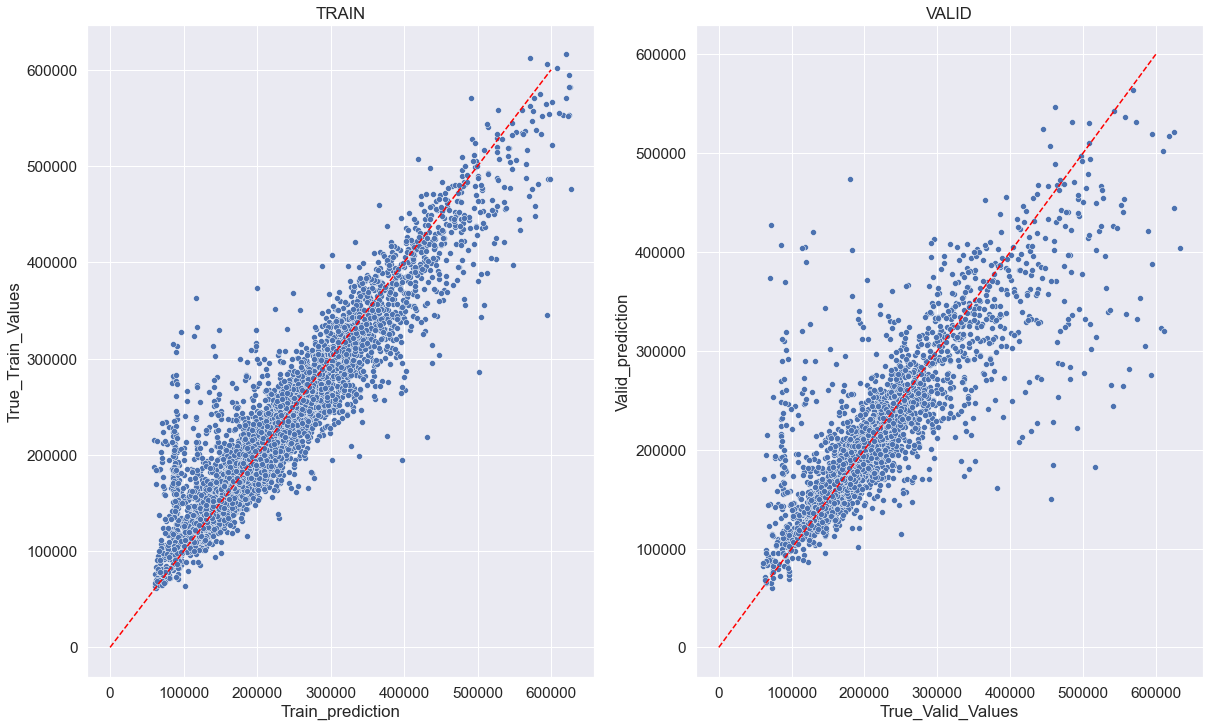

In [83]:
catb.fit(X_train, y_train, verbose=False,) #plot=True)
y_train_pred = catb.predict(X_train)
y_valid_pred = catb.predict(X_valid)
evaluate_pred(y_train, y_train_pred, y_valid, y_valid_pred)

In [84]:
catb.feature_importances_

array([2.11631966e+00, 1.27230940e+01, 4.14970805e+00, 4.74640348e+00,
       1.47126947e+00, 4.06823966e+00, 8.12525847e+00, 2.68790454e+00,
       1.83403047e-03, 7.31811164e-02, 2.20854672e+00, 3.33304860e+00,
       2.80416494e+00, 2.67198325e-01, 9.48312641e-01, 6.69431364e-02,
       8.05187328e-03, 4.46252694e-01, 0.00000000e+00, 1.91014187e-01,
       4.18855081e+00, 0.00000000e+00, 7.16269359e-01, 4.41768241e+01,
       4.81610125e-01])

In [85]:
feat_imp = pd.DataFrame(zip(X_train.columns, catb.feature_importances_), \
                        columns=['feat_name', 'feat_importance'])
feat_imp.sort_values('feat_importance', ascending=False, inplace=True)
# feat_imp['feat_importance'].sum()
feat_imp

feat_name  feat_importance
23   MedPriceByDistrict        44.176824
1                Square        12.723094
6             HouseYear         8.125258
3         KitchenSquare         4.746403
20      DistrictId_size         4.188551
2            LifeSquare         4.149708
5            HouseFloor         4.068240
11             Social_2         3.333049
12             Social_3         2.804165
7             Ecology_1         2.687905
10             Social_1         2.208547
0                 Rooms         2.116320
4                 Floor         1.471269
14              Shops_1         0.948313
22      IsDistrictLarge         0.716269
24  MedPriceByFloorYear         0.481610
17   HouseFloor_outlier         0.446253
13          Helthcare_2         0.267198
19       LifeSquare_nan         0.191014
9             Ecology_3         0.073181
15              Shops_2         0.066943
16        Rooms_outlier         0.008052
8             Ecology_2         0.001834
18    HouseYear_outlier         0.000000
21         new_district         0.000000

In [86]:
feat_imp.to_csv(RESULTS_PATH + 'catb_feat_imp.csv', index=False)

In [87]:
catb

In [88]:
with open(RESULTS_PATH + 'final_model', 'wb') as file:
    pickle.dump(catb, file)

In [89]:
with open(RESULTS_PATH + 'final_model', 'rb') as file:
    model_finale = pickle.load(file)

Train_R2:	0.8744440052430671
Valid_R2:	0.701471993823821


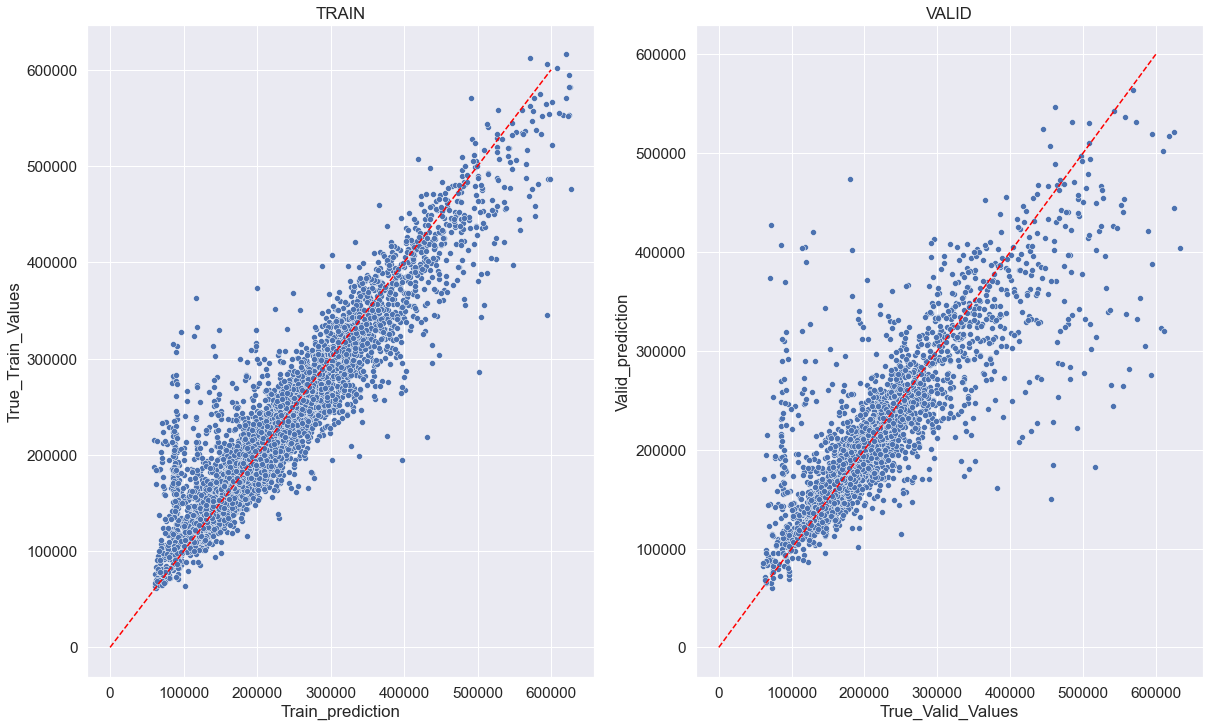

In [90]:
y_train_pred = model_finale.predict(X_train)
y_valid_pred = model_finale.predict(X_valid)
evaluate_pred(y_train, y_train_pred, y_valid, y_valid_pred)

In [91]:
cv_score = cross_val_score(catb, X_train, y_train, scoring='r2', \
                           cv=KFold(n_splits=3, shuffle=True, random_state=29))
cv_score

0:	learn: 85592.7854273	total: 3.29ms	remaining: 3.29s
1:	learn: 81190.8137020	total: 6.53ms	remaining: 3.26s
2:	learn: 77270.5253379	total: 9.38ms	remaining: 3.12s
3:	learn: 73789.4426695	total: 12.1ms	remaining: 3s
4:	learn: 70855.1422496	total: 14.7ms	remaining: 2.93s
5:	learn: 68363.5439750	total: 17.1ms	remaining: 2.84s
6:	learn: 66046.8819748	total: 19.1ms	remaining: 2.72s
7:	learn: 64118.9446127	total: 21.3ms	remaining: 2.64s
8:	learn: 62544.9172102	total: 23.5ms	remaining: 2.59s
9:	learn: 61009.9014498	total: 25.3ms	remaining: 2.51s
10:	learn: 59666.3097996	total: 27.4ms	remaining: 2.47s
11:	learn: 58495.9920106	total: 30.3ms	remaining: 2.49s
12:	learn: 57466.3968106	total: 32.8ms	remaining: 2.49s
13:	learn: 56599.3575639	total: 35ms	remaining: 2.47s
14:	learn: 55853.2447679	total: 37.3ms	remaining: 2.45s
15:	learn: 55131.9236316	total: 39.6ms	remaining: 2.44s
16:	learn: 54494.0070011	total: 41.6ms	remaining: 2.41s
17:	learn: 53973.5601849	total: 43.9ms	remaining: 2.39s
18:	lea

268:	learn: 39019.4325736	total: 343ms	remaining: 933ms
269:	learn: 38974.4872790	total: 345ms	remaining: 932ms
270:	learn: 38931.4070686	total: 346ms	remaining: 930ms
271:	learn: 38901.2070636	total: 347ms	remaining: 929ms
272:	learn: 38899.7231518	total: 348ms	remaining: 927ms
273:	learn: 38869.3936913	total: 349ms	remaining: 925ms
274:	learn: 38860.7813907	total: 350ms	remaining: 923ms
275:	learn: 38847.8697990	total: 351ms	remaining: 922ms
276:	learn: 38846.0015415	total: 352ms	remaining: 920ms
277:	learn: 38817.4512567	total: 354ms	remaining: 918ms
278:	learn: 38792.0436910	total: 355ms	remaining: 916ms
279:	learn: 38782.6265110	total: 356ms	remaining: 915ms
280:	learn: 38759.7572773	total: 357ms	remaining: 913ms
281:	learn: 38725.5138891	total: 358ms	remaining: 911ms
282:	learn: 38699.0296550	total: 359ms	remaining: 910ms
283:	learn: 38697.0449328	total: 360ms	remaining: 908ms
284:	learn: 38677.8696119	total: 362ms	remaining: 907ms
285:	learn: 38636.9324593	total: 363ms	remaining

560:	learn: 34018.6745586	total: 683ms	remaining: 534ms
561:	learn: 34012.8900479	total: 684ms	remaining: 533ms
562:	learn: 33992.8416424	total: 685ms	remaining: 532ms
563:	learn: 33986.4863821	total: 686ms	remaining: 530ms
564:	learn: 33976.7936390	total: 687ms	remaining: 529ms
565:	learn: 33962.9208108	total: 688ms	remaining: 528ms
566:	learn: 33946.5583009	total: 689ms	remaining: 526ms
567:	learn: 33946.1579283	total: 690ms	remaining: 525ms
568:	learn: 33934.2850431	total: 691ms	remaining: 524ms
569:	learn: 33913.1028957	total: 698ms	remaining: 526ms
570:	learn: 33887.5771257	total: 699ms	remaining: 525ms
571:	learn: 33861.1233674	total: 701ms	remaining: 524ms
572:	learn: 33832.9447605	total: 702ms	remaining: 523ms
573:	learn: 33825.0642781	total: 703ms	remaining: 522ms
574:	learn: 33811.6986575	total: 704ms	remaining: 521ms
575:	learn: 33807.5774710	total: 705ms	remaining: 519ms
576:	learn: 33803.6023527	total: 707ms	remaining: 518ms
577:	learn: 33788.6406348	total: 708ms	remaining

715:	learn: 32302.2406237	total: 859ms	remaining: 341ms
716:	learn: 32286.1318579	total: 860ms	remaining: 340ms
717:	learn: 32275.5044938	total: 862ms	remaining: 338ms
718:	learn: 32268.8462945	total: 863ms	remaining: 337ms
719:	learn: 32254.8029355	total: 864ms	remaining: 336ms
720:	learn: 32252.5765272	total: 865ms	remaining: 335ms
721:	learn: 32240.5846375	total: 866ms	remaining: 333ms
722:	learn: 32231.7851437	total: 867ms	remaining: 332ms
723:	learn: 32221.5773071	total: 868ms	remaining: 331ms
724:	learn: 32204.0812132	total: 881ms	remaining: 334ms
725:	learn: 32199.7735265	total: 883ms	remaining: 333ms
726:	learn: 32190.2849058	total: 884ms	remaining: 332ms
727:	learn: 32173.2765260	total: 885ms	remaining: 331ms
728:	learn: 32170.6471136	total: 886ms	remaining: 330ms
729:	learn: 32152.4924362	total: 888ms	remaining: 328ms
730:	learn: 32146.9356847	total: 889ms	remaining: 327ms
731:	learn: 32134.0500192	total: 890ms	remaining: 326ms
732:	learn: 32114.2761175	total: 891ms	remaining

980:	learn: 29865.9264138	total: 1.19s	remaining: 23.1ms
981:	learn: 29855.7982982	total: 1.2s	remaining: 21.9ms
982:	learn: 29845.4572135	total: 1.2s	remaining: 20.7ms
983:	learn: 29834.8236105	total: 1.2s	remaining: 19.5ms
984:	learn: 29817.0027350	total: 1.2s	remaining: 18.3ms
985:	learn: 29812.5329723	total: 1.2s	remaining: 17ms
986:	learn: 29811.4998544	total: 1.2s	remaining: 15.8ms
987:	learn: 29800.2375773	total: 1.2s	remaining: 14.6ms
988:	learn: 29796.8116944	total: 1.2s	remaining: 13.4ms
989:	learn: 29787.1220827	total: 1.2s	remaining: 12.2ms
990:	learn: 29775.4916514	total: 1.21s	remaining: 10.9ms
991:	learn: 29761.3675596	total: 1.21s	remaining: 9.73ms
992:	learn: 29749.5753979	total: 1.21s	remaining: 8.52ms
993:	learn: 29745.9377466	total: 1.21s	remaining: 7.3ms
994:	learn: 29734.3171793	total: 1.21s	remaining: 6.08ms
995:	learn: 29725.2357411	total: 1.21s	remaining: 4.87ms
996:	learn: 29717.1361945	total: 1.21s	remaining: 3.65ms
997:	learn: 29712.9403149	total: 1.21s	rema

177:	learn: 42102.7510119	total: 246ms	remaining: 1.14s
178:	learn: 42092.7019993	total: 247ms	remaining: 1.13s
179:	learn: 42064.1321872	total: 248ms	remaining: 1.13s
180:	learn: 42012.9101724	total: 250ms	remaining: 1.13s
181:	learn: 41978.6341557	total: 251ms	remaining: 1.13s
182:	learn: 41938.2250941	total: 252ms	remaining: 1.13s
183:	learn: 41923.0787859	total: 254ms	remaining: 1.12s
184:	learn: 41888.9213179	total: 255ms	remaining: 1.12s
185:	learn: 41864.4849550	total: 256ms	remaining: 1.12s
186:	learn: 41843.8400035	total: 258ms	remaining: 1.12s
187:	learn: 41785.3909232	total: 259ms	remaining: 1.12s
188:	learn: 41747.8591837	total: 260ms	remaining: 1.12s
189:	learn: 41695.1762748	total: 261ms	remaining: 1.11s
190:	learn: 41666.3323952	total: 263ms	remaining: 1.11s
191:	learn: 41634.2683969	total: 264ms	remaining: 1.11s
192:	learn: 41624.9648986	total: 266ms	remaining: 1.11s
193:	learn: 41596.7559804	total: 267ms	remaining: 1.11s
194:	learn: 41563.6003802	total: 268ms	remaining

384:	learn: 37433.2316652	total: 560ms	remaining: 894ms
385:	learn: 37407.2936351	total: 563ms	remaining: 896ms
386:	learn: 37374.3717120	total: 567ms	remaining: 898ms
387:	learn: 37346.1315108	total: 570ms	remaining: 900ms
388:	learn: 37343.2126716	total: 573ms	remaining: 900ms
389:	learn: 37328.4487414	total: 576ms	remaining: 901ms
390:	learn: 37306.0004636	total: 579ms	remaining: 902ms
391:	learn: 37275.4428914	total: 583ms	remaining: 904ms
392:	learn: 37252.0416263	total: 586ms	remaining: 905ms
393:	learn: 37218.0400804	total: 590ms	remaining: 907ms
394:	learn: 37212.6407830	total: 593ms	remaining: 908ms
395:	learn: 37196.1308775	total: 597ms	remaining: 911ms
396:	learn: 37192.1878374	total: 600ms	remaining: 912ms
397:	learn: 37172.1721465	total: 604ms	remaining: 913ms
398:	learn: 37140.9670694	total: 607ms	remaining: 914ms
399:	learn: 37138.2753197	total: 609ms	remaining: 914ms
400:	learn: 37135.3503338	total: 611ms	remaining: 913ms
401:	learn: 37119.8966980	total: 613ms	remaining

627:	learn: 34092.7293169	total: 896ms	remaining: 531ms
628:	learn: 34069.6148676	total: 898ms	remaining: 530ms
629:	learn: 34048.0561416	total: 899ms	remaining: 528ms
630:	learn: 34043.8711709	total: 900ms	remaining: 526ms
631:	learn: 34038.8146830	total: 901ms	remaining: 525ms
632:	learn: 34027.5583860	total: 902ms	remaining: 523ms
633:	learn: 34004.4594340	total: 903ms	remaining: 522ms
634:	learn: 33992.1499389	total: 904ms	remaining: 520ms
635:	learn: 33977.6864154	total: 906ms	remaining: 518ms
636:	learn: 33967.1626861	total: 907ms	remaining: 517ms
637:	learn: 33966.3075013	total: 908ms	remaining: 515ms
638:	learn: 33953.3662236	total: 909ms	remaining: 513ms
639:	learn: 33952.8599768	total: 910ms	remaining: 512ms
640:	learn: 33952.0706017	total: 911ms	remaining: 510ms
641:	learn: 33943.4641759	total: 912ms	remaining: 508ms
642:	learn: 33942.7400426	total: 913ms	remaining: 507ms
643:	learn: 33937.2995768	total: 914ms	remaining: 505ms
644:	learn: 33927.1709675	total: 915ms	remaining

894:	learn: 31330.6309829	total: 1.24s	remaining: 145ms
895:	learn: 31323.8955853	total: 1.24s	remaining: 144ms
896:	learn: 31307.7396596	total: 1.24s	remaining: 142ms
897:	learn: 31294.1533784	total: 1.24s	remaining: 141ms
898:	learn: 31278.4131809	total: 1.24s	remaining: 140ms
899:	learn: 31268.3117531	total: 1.24s	remaining: 138ms
900:	learn: 31262.1766847	total: 1.24s	remaining: 137ms
901:	learn: 31261.8325804	total: 1.24s	remaining: 135ms
902:	learn: 31255.0654232	total: 1.25s	remaining: 134ms
903:	learn: 31250.3035281	total: 1.25s	remaining: 132ms
904:	learn: 31247.9430024	total: 1.25s	remaining: 131ms
905:	learn: 31245.2079967	total: 1.25s	remaining: 130ms
906:	learn: 31238.1934913	total: 1.25s	remaining: 128ms
907:	learn: 31230.7141400	total: 1.25s	remaining: 127ms
908:	learn: 31221.2418663	total: 1.25s	remaining: 126ms
909:	learn: 31218.6162413	total: 1.25s	remaining: 124ms
910:	learn: 31218.3060644	total: 1.26s	remaining: 123ms
911:	learn: 31207.2436449	total: 1.26s	remaining

47:	learn: 49926.8252695	total: 166ms	remaining: 3.29s
48:	learn: 49818.9965104	total: 170ms	remaining: 3.29s
49:	learn: 49740.7796856	total: 173ms	remaining: 3.29s
50:	learn: 49636.7798647	total: 176ms	remaining: 3.28s
51:	learn: 49575.4441309	total: 179ms	remaining: 3.27s
52:	learn: 49483.6623752	total: 182ms	remaining: 3.26s
53:	learn: 49348.0744881	total: 185ms	remaining: 3.23s
54:	learn: 49270.2019964	total: 187ms	remaining: 3.21s
55:	learn: 49180.6741767	total: 190ms	remaining: 3.2s
56:	learn: 49124.0711973	total: 193ms	remaining: 3.19s
57:	learn: 49040.7468660	total: 195ms	remaining: 3.17s
58:	learn: 49004.7769816	total: 198ms	remaining: 3.16s
59:	learn: 48915.4963646	total: 201ms	remaining: 3.14s
60:	learn: 48835.6491080	total: 203ms	remaining: 3.13s
61:	learn: 48805.5737339	total: 205ms	remaining: 3.1s
62:	learn: 48731.5600406	total: 206ms	remaining: 3.06s
63:	learn: 48678.5445612	total: 207ms	remaining: 3.03s
64:	learn: 48635.6022358	total: 209ms	remaining: 3s
65:	learn: 4858

282:	learn: 39326.5185297	total: 512ms	remaining: 1.3s
283:	learn: 39308.4969938	total: 513ms	remaining: 1.29s
284:	learn: 39286.9930275	total: 514ms	remaining: 1.29s
285:	learn: 39267.6853980	total: 515ms	remaining: 1.28s
286:	learn: 39263.7146003	total: 516ms	remaining: 1.28s
287:	learn: 39205.6191453	total: 517ms	remaining: 1.28s
288:	learn: 39182.2784522	total: 518ms	remaining: 1.27s
289:	learn: 39150.8279108	total: 519ms	remaining: 1.27s
290:	learn: 39126.9999026	total: 520ms	remaining: 1.27s
291:	learn: 39106.4120889	total: 521ms	remaining: 1.26s
292:	learn: 39088.6393480	total: 523ms	remaining: 1.26s
293:	learn: 39039.3350936	total: 524ms	remaining: 1.26s
294:	learn: 39006.9894461	total: 525ms	remaining: 1.25s
295:	learn: 38980.7616136	total: 526ms	remaining: 1.25s
296:	learn: 38957.2438254	total: 528ms	remaining: 1.25s
297:	learn: 38923.4438030	total: 529ms	remaining: 1.25s
298:	learn: 38912.0973238	total: 530ms	remaining: 1.24s
299:	learn: 38875.0184325	total: 532ms	remaining:

555:	learn: 34638.8306282	total: 846ms	remaining: 675ms
556:	learn: 34637.4173945	total: 847ms	remaining: 674ms
557:	learn: 34626.7307044	total: 849ms	remaining: 672ms
558:	learn: 34608.1688649	total: 850ms	remaining: 670ms
559:	learn: 34596.0193665	total: 851ms	remaining: 668ms
560:	learn: 34581.1154106	total: 852ms	remaining: 667ms
561:	learn: 34571.7978376	total: 853ms	remaining: 665ms
562:	learn: 34557.9256255	total: 854ms	remaining: 663ms
563:	learn: 34541.2687639	total: 855ms	remaining: 661ms
564:	learn: 34525.5480952	total: 857ms	remaining: 660ms
565:	learn: 34514.6576083	total: 858ms	remaining: 658ms
566:	learn: 34500.8402888	total: 859ms	remaining: 656ms
567:	learn: 34492.7309232	total: 860ms	remaining: 654ms
568:	learn: 34470.3826435	total: 862ms	remaining: 653ms
569:	learn: 34461.1826785	total: 863ms	remaining: 651ms
570:	learn: 34453.4055669	total: 864ms	remaining: 649ms
571:	learn: 34432.6268338	total: 866ms	remaining: 648ms
572:	learn: 34418.6658894	total: 867ms	remaining

830:	learn: 31739.8637666	total: 1.19s	remaining: 241ms
831:	learn: 31739.7272519	total: 1.19s	remaining: 240ms
832:	learn: 31726.4190469	total: 1.19s	remaining: 239ms
833:	learn: 31713.5980716	total: 1.19s	remaining: 237ms
834:	learn: 31700.4870158	total: 1.19s	remaining: 236ms
835:	learn: 31680.1373587	total: 1.19s	remaining: 234ms
836:	learn: 31657.2314913	total: 1.2s	remaining: 233ms
837:	learn: 31645.6328603	total: 1.2s	remaining: 232ms
838:	learn: 31632.2328356	total: 1.2s	remaining: 230ms
839:	learn: 31620.6009022	total: 1.2s	remaining: 229ms
840:	learn: 31604.8023224	total: 1.2s	remaining: 227ms
841:	learn: 31600.4766224	total: 1.2s	remaining: 226ms
842:	learn: 31591.5548475	total: 1.2s	remaining: 224ms
843:	learn: 31572.6432135	total: 1.2s	remaining: 223ms
844:	learn: 31566.1940129	total: 1.21s	remaining: 221ms
845:	learn: 31552.0807125	total: 1.21s	remaining: 220ms
846:	learn: 31551.9479078	total: 1.21s	remaining: 218ms
847:	learn: 31547.2144540	total: 1.21s	remaining: 217ms


array([0.74904295, 0.74984301, 0.7667077 ])

In [92]:
cv_score.mean()

0.7551978859496389

**_по факту есть вопросы к финальной модели: ощутимая разница метрик (на трейне, валиде, и кросс-валидации), различимая на диаграммах._**

**_Однако данная модель (CatBoostRegressor) это лучшей результат из того что я опробовал._**

In [93]:
submit = pd.read_csv(RESULTS_PATH + 'sample_submission.csv')

In [94]:
test_pred = model_finale.predict(test_df)
submit['Price'] = test_pred

test_pred = pd.DataFrame(test_pred)
test_pred.to_csv(RESULTS_PATH + 'test_pred.csv', index=False, encoding='utf-8', sep=',')

In [95]:
submit.to_csv(RESULTS_PATH + 'catboost_submit.csv', index=False)